In [1]:
import ipympl
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=24) 
matplotlib.rc('ytick', labelsize=24) 
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["figure.facecolor"] = 'white'

#mpl.rcParams["axes.facecolor"] 
plt.rcParams["savefig.facecolor"]
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import matplotlib.colors as colors
from matplotlib import cm
import numpy as np
import scipy.special
import scipy.optimize
from scipy.optimize import curve_fit
import unyt
print('unyt version: ', unyt.__version__)
import numba
from numba import njit
print('numba version: ', numba.__version__)
import h5py
print('h5py version: ', h5py.__version__)
import struct
import copy

import os,sys

import swiftsimio as sw
print('SwiftSimIO version: ', sw.__version__)
import woma
#print('WoMa version: ', woma.__version__)
from woma.misc import utils, io
from woma.eos import tillotson, sesame, idg, hm80
from woma.eos.T_rho import T_rho
from woma.misc import glob_vars as gv
woma.load_eos_tables()
from HERCULES_structures import *

#this_dir, this_file = os.path.split(__file__)
#path = os.path.join(this_dir)
#sys.path.append(path)
#import gadget_sph

R_earth = gv.R_earth #6.371e6   # m
M_earth = gv.M_earth #5.9724e24  # kg 
G = 6.67408e-11  # m^3 kg^-1 s^-2
LEM=3.5E34 #AMof Earth-Moon system in mks

mant_mat_id = 403 #USER INPUT
core_mat_id = 402 #USER INPUT

def erfcfn(x, mFL, a, b):
    return mFL*scipy.special.erfc((x-a)/(b*np.sqrt(2)))

def arctanfn(x,a,b):
    return .5-np.arctan((x-a)/(b*np.pi))/(np.pi)

def quadlogfn(x, a, b, c, z):
    return z-10.**(a*(x**2)+b*x+c)

def quadlogfnsimple(x, a, b, c):
    return 10.**(a*(x**2)+b*x+c)

def quadlogfnfull(x, a2,a1,a0, b2,b1,b0, c2,c1,c0, z2,z1,z0):
    if np.shape(x)!=(2,):
        xQS=x[:,0]
        ytheta=x[:,1]
    else:
        xQS=x[0]
        ytheta=x[1]
    return 10.**(z2*ytheta**2+z1*ytheta+z0)-10.**((a2*ytheta**2+a1*ytheta+a0)*xQS**2+(b2*ytheta**2+b1*ytheta+b0)*xQS+(c2*ytheta**2+c1*ytheta+c0))

def quadlogfnfull2(xQS,ytheta, a2,a1,a0, b2,b1,b0, c2,c1,c0, z2,z1,z0):
    return 10.**(z2*(ytheta**2)+z1*ytheta+z0)-10.**((a2*ytheta**2+a1*ytheta+a0)*xQS**2+(b2*ytheta**2+b1*ytheta+b0)*xQS+(c2*ytheta**2+c1*ytheta+c0))

vquadlogfnfull=np.vectorize(quadlogfnfull2,excluded=[2,3,4,5,6,7,8,9,10,11,12,13])

def Tlogfnfull(x, a2,a1,a0,b2,b1,b0,c2,c1,c0):
    if np.shape(x)!=(2,):
        xQS=x[:,0]
        ytheta=x[:,1]
    else:
        xQS=x[0]
        ytheta=x[1]
    return 10.**((a2*ytheta**2+a1*ytheta+a0)*xQS**2+(b2*ytheta**2+b1*ytheta+b0)*xQS+(c2*ytheta**2+c1*ytheta+c0))

def Tlogfnlinear(x, a1,a0,b1,b0,c1,c0):
    return Tlogfnfull(x, 0,a1,a0,0,b1,b0,0,c1,c0)

def Tlogfnfull2(xQS,ytheta, a2,a1,a0,b2,b1,b0,c2,c1,c0):
    return 10.**((a2*ytheta**2+a1*ytheta+a0)*xQS**2+(b2*ytheta**2+b1*ytheta+b0)*xQS+(c2*ytheta**2+c1*ytheta+c0))

vTlogfnfull=np.vectorize(Tlogfnfull2,excluded=[2,3,4,5,6,7,8,9,10])

def coreTlogfnfull(x, a3,a2,a1,a0,b3,b2,b1,b0):
    if np.shape(x)!=(2,):
        xQS=x[:,0]
        ytheta=x[:,1]
    else:
        xQS=x[0]
        ytheta=x[1]
    return 10.**((a3*ytheta**3+a2*ytheta**2+a1*ytheta+a0)*xQS+(b3*ytheta**3+b2*ytheta**2+b1*ytheta+b0))

def coreTlogfnfull2(xQS,ytheta, a3,a2,a1,a0,b3,b2,b1,b0):
    return 10.**((a3*ytheta**3+a2*ytheta**2+a1*ytheta+a0)*xQS+(b3*ytheta**3+b2*ytheta**2+b1*ytheta+b0))

vcoreTlogfnfull=np.vectorize(coreTlogfnfull2,excluded=[2,3,4,5,6,7,8,9])

def blackbody(x, a, b):
    return (a*(x)**3/(np.exp(b*(x))-1))

print(.5-np.arctan(100)/(np.pi))
markers=['o','P','x','*','^','s','p','h','v','D','d']

def find_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    #ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="")

    return ci

unyt version:  v2.8.0
numba version:  0.59.1
h5py version:  3.6.0
SwiftSimIO version:  5.0.1
0.003182992764908188


In [2]:
def calcK(startProfile):
    [r0cgs,rho0cgs,T0,P0cgs,u0cgs,s0cgs,menclosedcgs,matID0]=np.loadtxt(startProfile,skiprows=1,unpack=True,delimiter=' ')
    r0=r0cgs/1.e2
    menclosed=menclosedcgs/1.e3
    Mt=menclosed[-1]
    Rt=r0[-1]
    Ishell=np.zeros(np.size(r0))
    for i in range(1,np.size(r0)):
        Ishell[i]=(2/5)*(menclosed[i]-menclosed[i-1])*(r0[i]**5-r0[i-1]**5)/(r0[i]**3-r0[i-1]**3)
    Itot=np.sum(Ishell,dtype='float64')
    K=Itot/Mt/(Rt**2)
    return K

In [3]:
def CMB_rubie(mplanet,mcore,mmantle):
    rhomant = 1063.83*mplanet + 3436.17
    rhocore = 2.5*rhomant
    return np.power(mcore*R_earth/(4/3*np.pi*rhocore*R_earth),1/3)
vCMB_rubie=np.vectorize(CMB_rubie)

def P_rubie(r,rCMB,rplanet,mplanet,mcore,mmantle):
    rhomant = 1063.83*mplanet + 3436.17
    rhocore = 2.5*rhomant
    b = np.power(mcore/(4/3*np.pi*rhocore),1/3)
    a = np.power((mmantle+4/3*rhomant*np.pi*b**3)/(4/3*np.pi*rhomant),1/3)
    #a = np.power(mplanet*M_earth/(4/3*np.pi*(1-(rhomant/7/(rhocore/3+rhomant/7))*(rhocore-rhomant))),1/3)
    #b = rplanet*R_earth*np.power(4/7*rhomant/(4/3*rhocore + 4/7*rhomant),1/3)
    #a = rplanet*R_earth
    #b = rCMB*R_earth
    if (r<=a and r>=b):
        return 4/3*np.pi*rhomant*G*b**3*(rhocore-rhomant)*(1/r-1/a) + 2/3*np.pi*G*rhomant**2*(a**2-r**2)
    if (r>0 and r<b):
        return 2/3*np.pi*G*rhocore**2*(b**2-r**2) + 2/3*np.pi*G*rhomant**2*(a**2-b**2) + 4/3*np.pi*rhomant*G*b**3*(rhocore-rhomant)*(1/b-1/a)
vP_rubie=np.vectorize(P_rubie)

def T_rubie(P):
    P=P/1.e9
    if P<24:
        return 1874 + 55.43*P - 1.74*P**2 + 0.0193*P**3
    if P>=24:
        return 1249 + 58.28*P - 0.395*P**2 + 0.0011*P**3

class simdata(object):
    def __init__(self,basename,label='',M_t=1,M_i=1,R_t=1,R_i=1,vi=1,theta=45,startProfile=''):
        self.basename=basename
        self.M_t = M_t
        self.M_i = M_i
        self.R_t = R_t
        self.R_i = R_i
        self.vi = vi
        self.theta = theta
        self.b=np.sin(self.theta*np.pi/180)
        self.B=(self.R_t+self.R_i)*np.sin(self.theta*np.pi/180)
        if os.path.isfile(basename+'_data.txt'):
            file_suffix='_data.txt'
        elif os.path.isfile(basename+'_data_last.txt'):
            file_suffix='_data_last.txt'
        [self.Lztot,
        self.Lzbnd,
        self.Lzplanet,
        self.Lzdisk,
        self.Lw0tot,
        self.Lw0bnd,
        self.Lw0planet,
        self.Lw0disk,
        self.Ntot,
        self.Nbound,
        self.Nplanet,
        self.Ndisk,
        self.Nmantle,
        self.Ncore,
        self.Mbound,
        self.Mplanet,
        self.Mdisk,
        self.Mmantle,
        self.Mcore,
        self.KEtot,
        self.KEbnd,
        self.KEplanet,
        self.KEdisk,
        self.KEmantle,
        self.KEcore,
        self.IEtot,
        self.IEbnd,
        self.IEplanet,
        self.IEdisk,
        self.IEmantle,
        self.IEcore,
        self.GPEtot,
        self.GPEbnd,
        self.GPEplanet,
        self.GPEdisk,
        self.GPEmantle,
        self.GPEcore,
        self.PGPEtot,
        self.PGPEbnd,
        self.PGPEplanet,
        self.PGPEdisk,
        self.PGPEmantle,
        self.PGPEcore,
        self.Etot,
        self.Ebnd,
        self.Eplanet,
        self.Edisk,
        self.Emantle,
        self.Ecore,
        self.Nh_maxtot,
        self.Nh_maxbound,
        self.Nlost,
        self.KElost,
        self.IElost,
        self.GPElost,
        self.PGPElost,
        self.Elost,
        self.Etot_adjusted,
        Etot0arr,
        Ntot0arr,
        self.time,
        GPEminarr] = np.loadtxt(basename+file_suffix,skiprows=1,unpack=True,delimiter='|')
        if os.path.isfile(basename+'_mantle_profiles.txt'):
            file_suffix='_mantle_profiles.txt'
        [self.RRRmant,
        self.RRR50mant,
        self.RRmant, 
        self.RR50mant,
        self.U25mant,
        self.U50mant,
        self.U75mant,
        self.Umeanmant,
        self.U25meanmant,
        self.U75meanmant,
        self.deltaU25mant,
        self.deltaU50mant,
        self.deltaU75mant,
        self.deltaUmeanmant,
        self.deltaU25meanmant,
        self.deltaU75meanmant,
        self.S25mant,
        self.S50mant,
        self.S75mant,
        self.Smeanmant,
        self.S25meanmant,
        self.S75meanmant,
        self.deltaS25mant,
        self.deltaS50mant,
        self.deltaS75mant,
        self.deltaSmeanmant,
        self.deltaS25meanmant,
        self.deltaS75meanmant,
        self.T25mant,
        self.T50mant,
        self.T75mant,
        self.Tmeanmant,
        self.T25meanmant,
        self.T75meanmant,
        self.deltaT25mant,
        self.deltaT50mant,
        self.deltaT75mant,
        self.deltaTmeanmant,
        self.deltaT25meanmant,
        self.deltaT75meanmant,
        self.P25mant,
        self.P50mant,
        self.P75mant,
        self.Pmeanmant,
        self.P25meanmant,
        self.P75meanmant,
        self.deltaP25mant,
        self.deltaP50mant,
        self.deltaP75mant,
        self.deltaPmeanmant,
        self.deltaP25meanmant,
        self.deltaP75meanmant,
        self.rho25mant,
        self.rho50mant,
        self.rho75mant,
        self.rhomeanmant,
        self.rho25meanmant,
        self.rho75meanmant] = np.loadtxt(basename+file_suffix,skiprows=3,unpack=True,delimiter='|')
        if os.path.isfile(basename+'_core_profiles.txt'):
            file_suffix='_core_profiles.txt'
        [self.RRRcore,
        self.RRR50core,
        self.RRcore, 
        self.RR50core,
        self.U25core,
        self.U50core,
        self.U75core,
        self.Umeancore,
        self.U25meancore,
        self.U75meancore,
        self.deltaU25core,
        self.deltaU50core,
        self.deltaU75core,
        self.deltaUmeancore,
        self.deltaU25meancore,
        self.deltaU75meancore,
        self.S25core,
        self.S50core,
        self.S75core,
        self.Smeancore,
        self.S25meancore,
        self.S75meancore,
        self.deltaS25core,
        self.deltaS50core,
        self.deltaS75core,
        self.deltaSmeancore,
        self.deltaS25meancore,
        self.deltaS75meancore,
        self.T25core,
        self.T50core,
        self.T75core,
        self.Tmeancore,
        self.T25meancore,
        self.T75meancore,
        self.deltaT25core,
        self.deltaT50core,
        self.deltaT75core,
        self.deltaTmeancore,
        self.deltaT25meancore,
        self.deltaT75meancore,
        self.P25core,
        self.P50core,
        self.P75core,
        self.Pmeancore,
        self.P25meancore,
        self.P75meancore,
        self.deltaP25core,
        self.deltaP50core,
        self.deltaP75core,
        self.deltaPmeancore,
        self.deltaP25meancore,
        self.deltaP75meancore,
        self.rho25core,
        self.rho50core,
        self.rho75core,
        self.rhomeancore,
        self.rho25meancore,
        self.rho75meancore] = np.loadtxt(basename+file_suffix,skiprows=3,unpack=True,delimiter='|')
        corecore = np.where(self.RRRcore<self.RRRmant[0])
        if os.path.isfile(basename+'_miscibility.txt'):
            file_suffix='_miscibility.txt'
        [self.miscMtot,
        self.miscMmant,
        self.miscMcore,
        self.miscmantfrac,
        self.misccorefrac] = np.loadtxt(basename+file_suffix,skiprows=1,unpack=True,delimiter='|')
        if os.path.isfile(basename+'_pressure_profiles.txt'):
            file_suffix='_pressure_profiles.txt'
        [self.radiusmeanPlist,
        self.P25profile,
        self.P50profile,
        self.P75profile,
        self.P25model,
        self.P50model,
        self.P75model] = np.loadtxt(basename+file_suffix,skiprows=1,unpack=True,delimiter='|')
        if (startProfile!='') & os.path.isfile(startProfile):
            [r0cgs,rho0cgs,self.T0,P0cgs,u0cgs,s0cgs,menclosed,matID0]=np.loadtxt(startProfile,skiprows=1,unpack=True,delimiter=' ')
            self.r0=r0cgs/1.e2
            self.rho0=rho0cgs*1.e3
            self.P0=P0cgs/10
            self.u0=u0cgs/1.e4
            self.s0=s0cgs/1.e4
            coreidx0=np.where(matID0==402)
            mantidx0=np.where(matID0==403)
            self.PCMB0=(self.P0[mantidx0][0]+self.P0[coreidx0][-1])/2
            self.TCMB0mant=self.T0[mantidx0][0]
            self.TCMB0core=self.T0[coreidx0][-1]
            self.K = calcK(startProfile)
            self.Lzstar=self.K*(self.M_t*M_earth)*(self.R_t*R_earth)**2*np.sqrt(G*(self.M_t*M_earth)/(self.R_t*R_earth)**3)/LEM
        self.P25profileCMB = self.P25profile[np.where(self.radiusmeanPlist<self.RRRmant[0])][-1]
        self.P50profileCMB = self.P50profile[np.where(self.radiusmeanPlist<self.RRRmant[0])][-1]
        self.P75profileCMB = self.P75profile[np.where(self.radiusmeanPlist<self.RRRmant[0])][-1]
        self.TCMB25 = self.T25mant[0]
        self.TCMB50 = self.T50mant[0]
        self.TCMB75 = self.T75mant[0]
        self.TCMBmean = self.Tmeanmant[0]
        self.TCMB25mean = self.T25meanmant[0]
        self.TCMB75mean = self.T75meanmant[0]
        self.PCMB25 = (self.P25mant[0]+self.P25core[corecore][-1])/2
        self.PCMB50 = (self.P50mant[0]+self.P50core[corecore][-1])/2
        self.PCMB75 = (self.P75mant[0]+self.P75core[corecore][-1])/2
        self.PCMBmean = (self.Pmeanmant[0]+self.Pmeancore[corecore][-1])/2
        self.PCMB25mean = (self.P25meanmant[0]+self.P25meancore[corecore][-1])/2
        self.PCMB75mean = (self.P75meanmant[0]+self.P75meancore[corecore][-1])/2
        self.CMBrubie = CMB_rubie(self.Mplanet[-1],self.Mcore[-1]*M_earth,(self.Mmantle[-1]+self.Mdisk[-1])*M_earth)
        self.CMBrubieFF = CMB_rubie(self.Mplanet[-1],0.3*self.Mplanet[-1]*M_earth,0.7*self.Mplanet[-1]*M_earth)
        self.P_CMBrubie = P_rubie(self.CMBrubie,self.CMBrubie,0,self.Mplanet[-1],self.Mcore[-1]*M_earth,(self.Mmantle[-1]+self.Mdisk[-1])*M_earth)
        self.P_CMBrubieFF = P_rubie(self.CMBrubieFF,self.CMBrubieFF,0,self.Mplanet[-1],0.3*self.Mplanet[-1]*M_earth,0.7*self.Mplanet[-1]*M_earth)
        self.T_CMBrubie = T_rubie(self.P_CMBrubie)
        if os.path.isfile(basename+'_final'):
            self.HERCparams=HERCULES_parameters()
            self.HERCp=HERCULES_planet()
            with open(basename+'_final', "rb") as file:
                self.HERCparams.read_binary(file)
                self.HERCp.read_binary(file)
            self.HERCp.calc_pCMB()
            self.HERC_PCMB = self.HERCp.pCMB
            self.HERC_Lz = np.abs(self.HERCp.Lout[-1]/LEM)
            self.HERC_r=np.array([])
            self.HERC_P=np.array([])
            for i in range(self.HERCp.Nlayer):
                self.HERC_r = np.append(self.HERC_r,self.HERCp.layers[-1-i].a)
                self.HERC_P = np.append(self.HERC_P,self.HERCp.press[-1-i])
        else:
            self.HERC_PCMB = float('nan')
            self.HERC_Lz = self.Lzbnd[-1]
            self.HERC_r = np.full(2,float('nan'))
            self.HERC_P = np.full(2,float('nan'))
        if os.path.isfile(basename+'_phase_data.txt'):
            file_suffix='_phase_data.txt'
        [self.Phase,
         self.NmantPhase,
         self.NmantPhaseFrac,
         self.MmantPhase,
         self.MmantPhaseFrac,
         self.RRRminmantPhase,
         self.RRRminmantEqPhase,
         self.RRRmaxmantPhase,
         self.RRRmaxmantEqPhase,
         self.NcorePhase,
         self.NcorePhaseFrac,
         self.McorePhase,
         self.McorePhaseFrac,
         self.RRRmincorePhase,
         self.RRRmaxcorePhase]=np.loadtxt(basename+file_suffix,skiprows=1,unpack=True,delimiter='|')
        self.RRRminmantPhase=self.RRRminmantPhase/R_earth
        self.RRRmincorePhase=self.RRRmincorePhase/R_earth
        self.RRRmaxmantPhase=self.RRRmaxmantPhase/R_earth
        self.RRRmaxcorePhase=self.RRRmaxcorePhase/R_earth
        self.Etot0 = Etot0arr[0]
        self.Ntot0 = Ntot0arr[0]
        self.GPEmin = GPEminarr[0]
        self.Nsnap = np.size(self.time)
        self.B_crit=self.R_t/(self.R_t+self.R_i)
        self.theta_crit=np.arcsin(self.R_t/(self.R_t+self.R_i))
        self.label=label
        self.QR = self.QRfn(self.M_t,self.M_i,self.R_t,self.R_i,self.vi)
        self.QprimeR = self.QprimeRfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        self.QS = self.QSfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        print(self.label,self.QS/1.e6)
        self.QstarprimeR = self.QstarprimeRfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        self.QstarS = self.QstarSfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        self.QSstandard = self.QSstandardfn(self.M_t,self.M_i,self.R_t,self.R_i)
        self.QstarSstandard = self.QSstandardfn(self.M_t,self.M_i,self.R_t,self.R_i,star=True)
        self.outcomemarker = 'o'
        anglelist = [0,10,20,30,45,60,75,89.7]
        for i in range(np.size(anglelist)):
            if self.theta==anglelist[i]:
                self.thetamarker=markers[i]
        mtarglist = [0.01,0.1,0.5,0.91,1.3]
        for i in range(np.size(mtarglist)):
            if np.abs(self.M_t-mtarglist[i])/mtarglist[i]<0.05:
                self.sizemarker=markers[i]
        mratiolist = [2,3,6]
        for i in range(np.size(mratiolist)):
            if np.abs((self.M_t/self.M_i)-mratiolist[i])/mratiolist[i]<0.05:
                self.ratiomarker=markers[i]
            
    def fP_T(self,fP):
        fracP = self.PCMBmean*fP
        fracR = self.radiusmeanPlist[np.where(self.Pmeanmant<fracP)][0]
        fracT = self.Tmeanmant[np.where(self.RRRmant>fracR)][0]
        return fracT
    
    def QRfn(self,M_t,M_i,R_t,R_i,Vi,):
        M_t = M_t*M_earth
        M_i = M_i*M_earth
        R_t = R_t * R_earth
        R_i = R_i * R_earth
        v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
        v_imp = Vi*v_esc
        Mtot = M_t+M_i
        mu = M_t*M_i/Mtot
        return 0.5*mu*v_imp**2/Mtot
    
    def QprimeRfn(self,M_t,M_i,R_t,R_i,theta):
        theta=theta*np.pi/180
        B=(R_t+R_i)*np.sin(theta)
        l = R_t+R_i-B
        alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
        if l>=2*R_i:
            alpha=1
        mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
        mu = M_t*M_i/(M_t+M_i)
        return (mu/mua)*self.QR
    
    def QSfn(self,M_t,M_i,R_t,R_i,theta):
        theta=theta*np.pi/180
        b=np.sin(theta)
        return self.QprimeR*(1+M_i/M_t)*(1-b)
    
    def QstarprimeRfn(self,M_t,M_i,R_t,R_i,theta):
        mubar = 0.35
        theta=theta*np.pi/180
        B=(R_t+R_i)*np.sin(theta)
        l = R_t+R_i-B
        alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
        if l>=2*R_i:
            alpha=1
        mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
        mu = M_t*M_i/(M_t+M_i)
        return (mu/mua)**(2-3*mubar/2)*self.QR
    
    def QstarSfn(self,M_t,M_i,R_t,R_i,theta):
        theta=theta*np.pi/180
        b=np.sin(theta)
        return self.QstarprimeR*(1+M_i/M_t)*(1-b)
        
    def QSstandardfn(self,M_t,M_i,R_t,R_i,theta=30.,Vi=1.0,star=False):
        theta=theta*np.pi/180
        b=np.sin(theta)
        M_t = M_t*M_earth
        M_i = M_i*M_earth
        R_t = R_t * R_earth
        R_i = R_i * R_earth
        v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
        v_imp = Vi*v_esc
        Mtot = M_t+M_i
        mu = M_t*M_i/Mtot
        QR=0.5*mu*v_imp**2/Mtot
        B=(R_t+R_i)*np.sin(theta)
        l = R_t+R_i-B
        alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
        if l>=2*R_i:
            alpha=1
        mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
        QprimeR=(mu/mua)*QR
        if star:
            mubar = 0.35
            QstarprimeR=(mu/mua)**(2-3*mubar/2)*self.QR
            return QstarprimeR*(1+M_i/M_t)*(1-b)
        return QprimeR*(1+M_i/M_t)*(1-b)
    
def QS(M_t,M_i,R_t,R_i,Vi,theta,square=False):
    theta=theta*np.pi/180
    M_t = M_t*M_earth
    M_i = M_i*M_earth
    R_t = R_t * R_earth
    R_i = R_i * R_earth
    v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
    v_imp = Vi*v_esc
    Mtot = M_t+M_i
    mu = M_t*M_i/Mtot
    QR=0.5*mu*v_imp**2/Mtot
    B=(R_t+R_i)*np.sin(theta)
    l = R_t+R_i-B
    alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
    if l>=2*R_i:
        alpha=1
    mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
    QprimeR=(mu/mua)*QR
    b=np.sin(theta)
    if square:
        return QprimeR*(1+M_i/M_t)**2*(1-b)
    return QprimeR*(1+M_i/M_t)*(1-b)

def QS_theta_v(M_t,M_i,R_t,R_i,theta,Vi0,theta0,square=False):
    theta=theta*np.pi/180
    M_t = M_t*M_earth
    M_i = M_i*M_earth
    R_t = R_t * R_earth
    R_i = R_i * R_earth
    v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
    Mtot = M_t+M_i
    mu = M_t*M_i/Mtot
    QRnov=0.5*mu/Mtot
    B=(R_t+R_i)*np.sin(theta)
    l = R_t+R_i-B
    alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
    if l>=2*R_i:
        alpha=1
    mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
    QprimeRnov=(mu/mua)*QRnov
    b=np.sin(theta)
    if square:
        QSnov=QprimeRnov*(1+M_i/M_t)**2*(1-b)
    else:
        QSnov=QprimeRnov*(1+M_i/M_t)*(1-b)
    return np.sqrt(QS(M_t/M_earth,M_i/M_earth,R_t/R_earth,R_i/R_earth,Vi0,theta0)/QSnov)/v_esc

1.1538462742304856 theta= 20  v/vesc= 1
1.3269232153650583 theta= 20  v/vesc= 1.15
1.7307694113457288 theta= 20  v/vesc= 1.5
2.307692548460971 theta= 20  v/vesc= 2.0
1.1658494416869107 theta= 30  v/vesc= 1
1.3407268579399472 theta= 30  v/vesc= 1.15
1.7487741625303663 theta= 30  v/vesc= 1.5
2.3316988833738215 theta= 30  v/vesc= 2.0
1.067238705403988 theta= 45  v/vesc= 1
1.2273245112145859 theta= 45  v/vesc= 1.15
1.6008580581059821 theta= 45  v/vesc= 1.5
2.134477410807976 theta= 45  v/vesc= 2.0
0.8092806568260472 theta= 60  v/vesc= 1
0.9306727553499543 theta= 60  v/vesc= 1.15
1.2139209852390713 theta= 60  v/vesc= 1.5
1.6185613136520944 theta= 60  v/vesc= 2.0
0.4305203993699627 theta= 75  v/vesc= 1
0.4950984592754571 theta= 75  v/vesc= 1.15
0.6457805990549442 theta= 75  v/vesc= 1.5
0.8610407987399255 theta= 75  v/vesc= 2.0
0.008755679848233843 theta= 89.7  v/vesc= 1
0.010069031825468918 theta= 89.7  v/vesc= 1.15
0.013133519772350765 theta= 89.7  v/vesc= 1.5
0.017511359696467686 theta= 89.

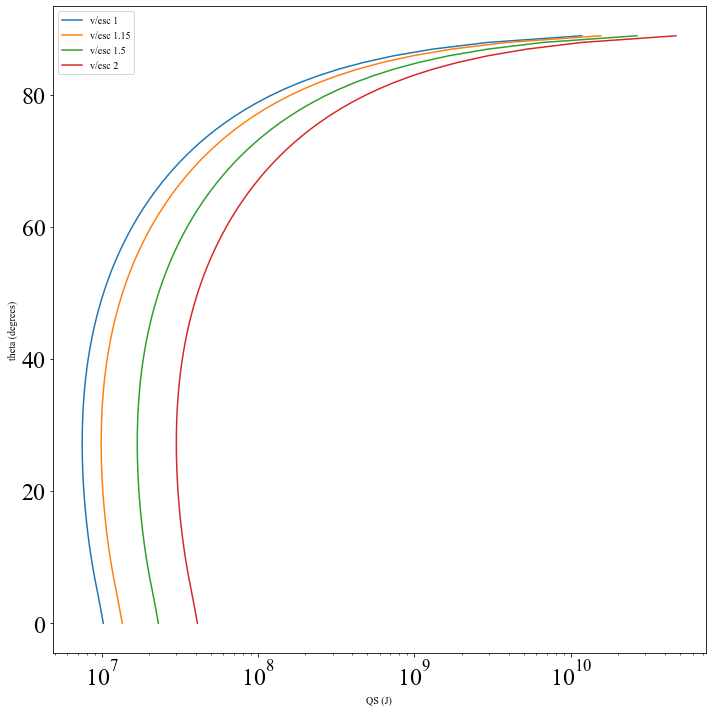

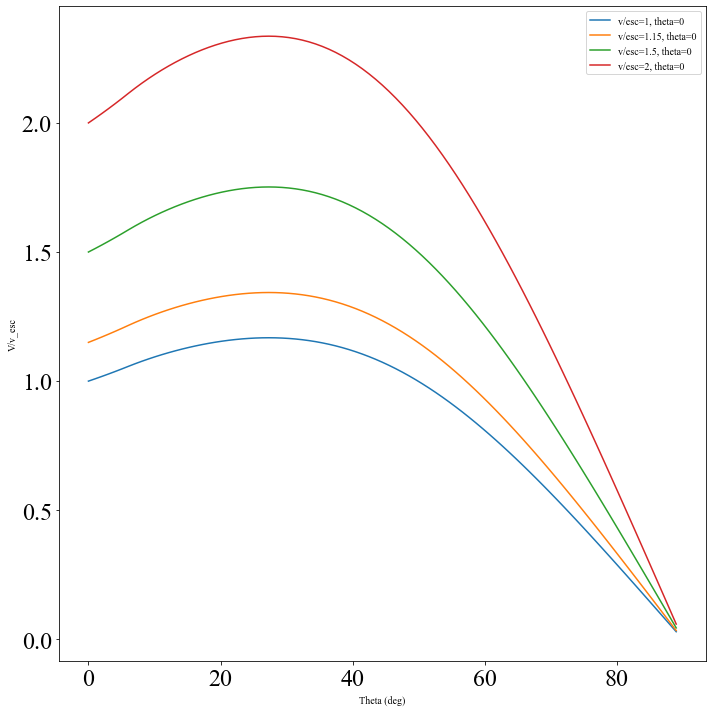

In [4]:
thetalist=[0,20,30,45,60,75,89.7]
for i in range(np.size(thetalist)-1):
    print(QS_theta_v(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,thetalist[i+1],1,0),'theta=',thetalist[i+1],' v/vesc=',1)
    print(QS_theta_v(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,thetalist[i+1],1.15,0),'theta=',thetalist[i+1],' v/vesc=',1.15)
    print(QS_theta_v(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,thetalist[i+1],1.5,0),'theta=',thetalist[i+1],' v/vesc=',1.5)
    print(QS_theta_v(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,thetalist[i+1],2.0,0),'theta=',thetalist[i+1],' v/vesc=',2.0)

vrange=np.array([1,1.15,1.5,2.0])
thetarange=np.linspace(0,90,90)
fig1,ax = plt.subplots(1, 1, figsize=(10,10))
for i in range(np.size(vrange)):
    QSarr=np.empty(np.size(thetarange))
    for j in range(np.size(thetarange)):
        QSarr[j]=QS(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,vrange[i],thetarange[j])
    ax.plot(QSarr,thetarange,label='v/esc %g'%vrange[i])
ax.set_xscale('log')
ax.set_xlabel('QS (J)')
ax.set_ylabel('theta (degrees)')
ax.legend()
plt.tight_layout()

fig2,ax = plt.subplots(1, 1, figsize=(10,10))
for i in range(np.size(vrange)):
    QS_theta_v_arr=np.empty(np.size(thetarange))
    for j in range(np.size(thetarange)):
        QS_theta_v_arr[j]=QS_theta_v(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,thetarange[j],vrange[i],0)
    ax.plot(thetarange,QS_theta_v_arr,label='v/esc=%g, theta=0'%vrange[i])
ax.set_xlabel('Theta (deg)')
ax.set_ylabel('V/v_esc')
ax.legend()
plt.tight_layout()

0.9421978976650643 theta= 20  v/vesc= 1
1.083527582314824 theta= 20  v/vesc= 1.15
1.4132968464975968 theta= 20  v/vesc= 1.5
1.8843957953301287 theta= 20  v/vesc= 2.0
0.9519993412328462 theta= 30  v/vesc= 1
1.094799242417773 theta= 30  v/vesc= 1.15
1.4279990118492696 theta= 30  v/vesc= 1.5
1.9039986824656925 theta= 30  v/vesc= 2.0
0.8714766316761184 theta= 45  v/vesc= 1
1.002198126427536 theta= 45  v/vesc= 1.15
1.3072149475141777 theta= 45  v/vesc= 1.5
1.7429532633522369 theta= 45  v/vesc= 2.0
0.6608354600711664 theta= 60  v/vesc= 1
0.7599607790818413 theta= 60  v/vesc= 1.15
0.9912531901067498 theta= 60  v/vesc= 1.5
1.321670920142333 theta= 60  v/vesc= 2.0
0.35155065648483036 theta= 75  v/vesc= 1
0.40428325495755485 theta= 75  v/vesc= 1.15
0.5273259847272457 theta= 75  v/vesc= 1.5
0.7031013129696607 theta= 75  v/vesc= 2.0
0.007149637980272586 theta= 89.7  v/vesc= 1
0.008222083677313474 theta= 89.7  v/vesc= 1.15
0.010724456970408879 theta= 89.7  v/vesc= 1.5
0.014299275960545171 theta= 89

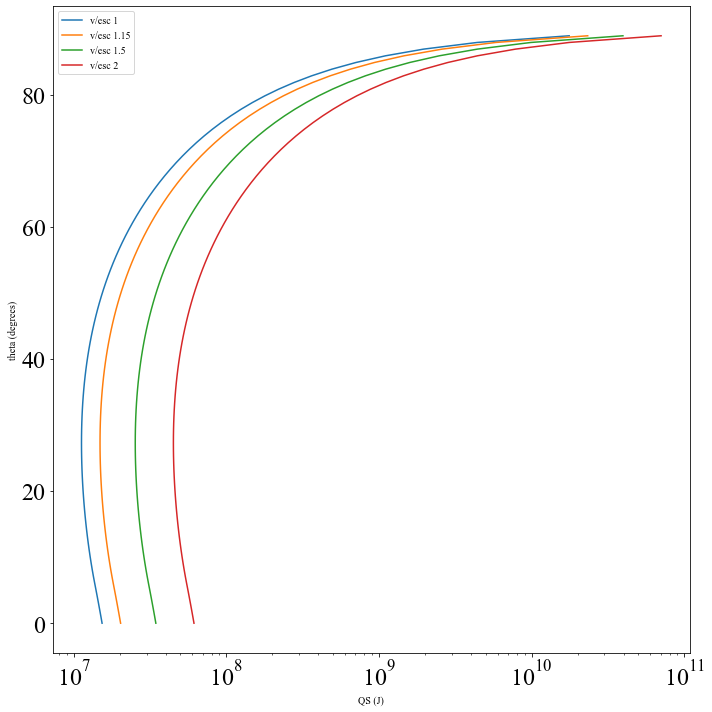

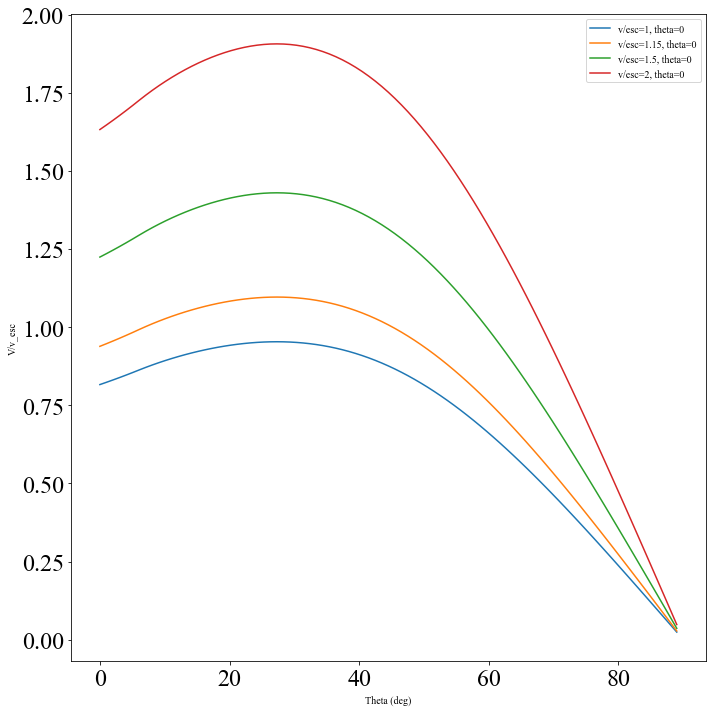

In [5]:
thetalist=[0,20,30,45,60,75,89.7]
for i in range(np.size(thetalist)-1):
    print(QS_theta_v(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,thetalist[i+1],1,0,square=True),'theta=',thetalist[i+1],' v/vesc=',1)
    print(QS_theta_v(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,thetalist[i+1],1.15,0,square=True),'theta=',thetalist[i+1],' v/vesc=',1.15)
    print(QS_theta_v(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,thetalist[i+1],1.5,0,square=True),'theta=',thetalist[i+1],' v/vesc=',1.5)
    print(QS_theta_v(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,thetalist[i+1],2.0,0,square=True),'theta=',thetalist[i+1],' v/vesc=',2.0)

vrange=np.array([1,1.15,1.5,2.0])
thetarange=np.linspace(0,90,90)
fig1,ax = plt.subplots(1, 1, figsize=(10,10))
for i in range(np.size(vrange)):
    QSarr=np.empty(np.size(thetarange))
    for j in range(np.size(thetarange)):
        QSarr[j]=QS(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,vrange[i],thetarange[j],square=True)
    ax.plot(QSarr,thetarange,label='v/esc %g'%vrange[i])
ax.set_xscale('log')
ax.set_xlabel('QS (J)')
ax.set_ylabel('theta (degrees)')
ax.legend()
plt.tight_layout()

fig2,ax = plt.subplots(1, 1, figsize=(10,10))
for i in range(np.size(vrange)):
    QS_theta_v_arr=np.empty(np.size(thetarange))
    for j in range(np.size(thetarange)):
        QS_theta_v_arr[j]=QS_theta_v(0.5004180781595339,0.25007144364074746,0.8434668074085702,0.6858380144404332,thetarange[j],vrange[i],0,square=True)
    ax.plot(thetarange,QS_theta_v_arr,label='v/esc=%g, theta=0'%vrange[i])
ax.set_xlabel('Theta (deg)')
ax.set_ylabel('V/v_esc')
ax.legend()
plt.tight_layout()

In [6]:
moon01x005v1th20 = simdata('./data/moon0.01x.005v1th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=20)
moon01x005v115th20 = simdata('./data/moon0.01x.005v1.15th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=20)
moon01x005v15th20 = simdata('./data/moon0.01x.005v1.5th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=20)
moon01x005v20th20 = simdata('./data/moon0.01x.005v2.0th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=20)
moon01x005th20list=[moon01x005v1th20,moon01x005v115th20,moon01x005v15th20,moon01x005v20th20]
moon01x005v1th30 = simdata('./data/moon0.01x.005v1th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=30)
moon01x005v115th30 = simdata('./data/moon0.01x.005v1.15th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=30)
moon01x005v145th30 = simdata('./data/moon0.01x.005v1.45th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.45th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.45,theta=30)
moon01x005v15th30 = simdata('./data/moon0.01x.005v1.5th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=30)
moon01x005v20th30 = simdata('./data/moon0.01x.005v2.0th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=30)
moon01x005th30list=[moon01x005v1th30,moon01x005v115th30,moon01x005v15th30,moon01x005v20th30,moon01x005v145th30]
moon01x005th30list_nohnr=[moon01x005v1th30,moon01x005v115th30,moon01x005v15th30,moon01x005v20th30]
moon01x005v1th45 = simdata('./data/moon0.01x.005v1th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=45)
moon01x005v115th45 = simdata('./data/moon0.01x.005v1.15th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=45)
moon01x005v135th45 = simdata('./data/moon0.01x.005v1.35th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.35th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.35,theta=45)
moon01x005v15th45 = simdata('./data/moon0.01x.005v1.5th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=45)
moon01x005v20th45 = simdata('./data/moon0.01x.005v2.0th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=45)
moon01x005th45list=[moon01x005v1th45,moon01x005v115th45,moon01x005v15th45,moon01x005v20th45,moon01x005v135th45]
moon01x005th45list_nohnr=[moon01x005v1th45,moon01x005v15th45,moon01x005v20th45]#moon01x005v115th45,
moon01x005v1th60 = simdata('./data/moon0.01x.005v1th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=60)
moon01x005v105th60 = simdata('./data/moon0.01x.005v1.05th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.05th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.05,theta=60)
moon01x005v115th60 = simdata('./data/moon0.01x.005v1.15th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=60)
moon01x005v15th60 = simdata('./data/moon0.01x.005v1.5th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=60)
moon01x005v20th60 = simdata('./data/moon0.01x.005v2.0th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=60)
moon01x005th60list=[moon01x005v1th60,moon01x005v115th60,moon01x005v15th60,moon01x005v20th60,moon01x005v105th60]
moon01x005th60list_nohnr=[moon01x005v1th60,moon01x005v115th60,moon01x005v15th60,moon01x005v20th60]
moon01x005v1th75 = simdata('./data/moon.01x.005v1th75',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=75)
moon01x005v1025th75 = simdata('./data/moon.01x.005v1.025th75',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.025th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.025,theta=75)
moon01x005v105th75 = simdata('./data/moon.01x.005v1.05th75',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.05th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.05,theta=75)
moon01x005v11th75 = simdata('./data/moon.01x.005v1.1th75',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.1,theta=75)
moon01x005th75list=[moon01x005v1th75,moon01x005v1025th75,moon01x005v11th75,moon01x005v105th75]
moon01x005v1th897 = simdata('./data/moon.01x.005v1th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=89.7)
moon01x005v1025th897 = simdata('./data/moon.01x.005v1.025th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.025th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.025,theta=89.7)
#moon01x005v105th897 = simdata('./data/moon.01x.005v1.05th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.05th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.05,theta=89.7)
moon01x005th897list=[moon01x005v1th897,moon01x005v1025th897]#,moon01x005v105th897
moon01x005v1th0 = simdata('./data/moon0.01x.005v1th0',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=0)
moon01x005v15th0 = simdata('./data/moon0.01x.005v1.5th0',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=0)
moon01x005v20th0 = simdata('./data/moon0.01x.005v2.0th0',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th10',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=0)
moon01x005v115th10 = simdata('./data/moon0.01x.005v1.15th10',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th10',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=10)
moon01x005v115th0 = simdata('./data/moon0.01x.005v1.15th0',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=0)
moon01x005th010list=[moon01x005v115th10,moon01x005v1th0,moon01x005v115th0,moon01x005v15th0,moon01x005v20th0]
print('Target K: ',moon01x005v1th30.K)
print('Target L*: ',moon01x005v1th30.Lzstar)
print(moon01x005v1th30.fP_T(.7),T_rubie(moon01x005v1th30.P_CMBrubie*.7))
print(moon01x005v1th30.HERC_PCMB/1.e9)

moon0.01x.005v1th20 0.5262909041403177
moon0.01x.005v1.15th20 0.69601972072557
moon0.01x.005v1.5th20 1.1841545343157152
moon0.01x.005v2.0th20 2.1051636165612706
moon0.01x.005v1th30 0.513337486124495
moon0.01x.005v1.15th30 0.6788888253996443
moon0.01x.005v1.45th30 1.0792920645767503
moon0.01x.005v1.5th30 1.1550093437801139
moon0.01x.005v2.0th30 2.05334994449798
moon0.01x.005v1th45 0.6093546812995713
moon0.01x.005v1.15th45 0.8058715660186828
moon0.01x.005v1.35th45 1.1105489066684684
moon0.01x.005v1.5th45 1.3710480329240353
moon0.01x.005v2.0th45 2.437418725198285
moon0.01x.005v1th60 1.0558719867943622
moon0.01x.005v1.05th60 1.1640988654407842
moon0.01x.005v1.15th60 1.3963907025355438
moon0.01x.005v1.5th60 2.3757119702873157
moon0.01x.005v2.0th60 4.223487947177449
moon0.01x.005v1th75 3.7248919726759646
moon0.01x.005v1.025th75 3.9134646287926853
moon0.01x.005v1.05th75 4.10669339987525
moon0.01x.005v1.1th75 4.507119286937916
moon0.01x.005v1th89.7 9002.51793409644
moon0.01x.005v1.025th89.7 94

In [7]:
sim=moon01x005v115th0
print((sim.T25mant[0]-sim.TCMBmean)/sim.TCMBmean)
print((sim.T75mant[0]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[1]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[2]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[3]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[4]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[9]-sim.TCMBmean)/sim.TCMBmean)

-0.03942613239264551
-0.032882760052453844
-0.038985210841880606
-0.04022775146886192
-0.04036090390085146
-0.0399372624348022
-0.06095953588852772


In [8]:
mars01x05v1th0 = simdata('./data/mars0.1x.05v1th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=0)
mars01x05v115th0 = simdata('./data/mars0.1x.05v1.15th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=0)
mars01x05v15th0 = simdata('./data/mars0.1x.05v1.5th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=0)
mars01x05v20th0 = simdata('./data/mars0.1x.05v2.0th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=0)
mars01x05th0list=[mars01x05v1th0,mars01x05v115th0,mars01x05v15th0,mars01x05v20th0]
mars01x05v1th20 = simdata('./data/mars0.1x.05v1th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=20)
mars01x05v115th20 = simdata('./data/mars0.1x.05v1.15th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=20)
mars01x05v15th20 = simdata('./data/mars0.1x.05v1.5th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=20)
mars01x05v20th20 = simdata('./data/mars0.1x.05v2.0th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=20)
mars01x05th20list=[mars01x05v1th20,mars01x05v115th20,mars01x05v15th20,mars01x05v20th20]
mars01x05v1th30 = simdata('./data/mars0.1x.05v1th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=30)
mars01x05v115th30 = simdata('./data/mars0.1x.05v1.15th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=30)
mars01x05v145th30 = simdata('./data/mars0.1x.05v1.45th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.45th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.45,theta=30)
mars01x05v15th30 = simdata('./data/mars0.1x.05v1.5th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=30)
mars01x05v20th30 = simdata('./data/mars0.1x.05v2.0th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=30)
mars01x05th30list=[mars01x05v1th30,mars01x05v115th30,mars01x05v15th30,mars01x05v20th30,mars01x05v145th30]
mars01x05th30list_nohnr=[mars01x05v1th30,mars01x05v115th30,mars01x05v15th30,mars01x05v20th30]
mars01x05v1th45 = simdata('./data/mars0.1x.05v1th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=45)
mars01x05v115th45 = simdata('./data/mars0.1x.05v1.15th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=45)
mars01x05v135th45 = simdata('./data/mars0.1x.05v1.35th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.35th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.35,theta=45)
mars01x05v15th45 = simdata('./data/mars0.1x.05v1.5th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=45)
mars01x05v20th45 = simdata('./data/mars0.1x.05v2.0th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=45)
mars01x05th45list=[mars01x05v1th45,mars01x05v115th45,mars01x05v15th45,mars01x05v20th45,mars01x05v135th45]
mars01x05th45list_nohnr=[mars01x05v1th45,mars01x05v115th45,mars01x05v15th45] #,mars01x05v20th45]
mars01x05v1th60 = simdata('./data/mars0.1x.05v1th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=60)
mars01x05v105th60 = simdata('./data/mars0.1x.05v1.05th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.05th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.05,theta=60)
mars01x05v115th60 = simdata('./data/mars0.1x.05v1.15th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=60)
mars01x05v15th60 = simdata('./data/mars0.1x.05v1.5th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=60)
mars01x05v20th60 = simdata('./data/mars0.1x.05v2.0th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=60)
mars01x05th60list=[mars01x05v1th60,mars01x05v115th60,mars01x05v15th60,mars01x05v20th60,mars01x05v105th60]
mars01x05th60list_nohnr=[mars01x05v1th60,mars01x05v115th60,mars01x05v15th60] #,mars01x05v20th60]
mars01x05v1th75 = simdata('./data/mars0.1x.05v1th75',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=75)
mars01x05v1025th75 = simdata('./data/mars0.1x.05v1.025th75',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.025th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.025,theta=75)
mars01x05v105th75 = simdata('./data/mars0.1x.05v1.05th75',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.05th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.05,theta=75)
mars01x05v11th75 = simdata('./data/mars0.1x.05v1.1th75',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.1,theta=75)
mars01x05th75list = [mars01x05v1th75,mars01x05v1025th75,mars01x05v105th75,mars01x05v11th75]
mars01x05v1th897 = simdata('./data/mars0.1x.05v1th89.7',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=89.7)
mars01x05v1025th897 = simdata('./data/mars0.1x.05v1.025th89.7',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.025th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.025,theta=89.7)
mars01x05v105th897 = simdata('./data/mars0.1x.05v1.05th89.7',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.05th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.05,theta=89.7)
mars01x05th897list = [mars01x05v1th897,mars01x05v1025th897,mars01x05v105th897]
print('Target K: ',mars01x05v1th30.K)
print('Target L*: ',mars01x05v1th30.Lzstar)

mars0.1x.05v1th0 3.3560343758801934
mars0.1x.05v1.15th0 4.438355462101556
mars0.1x.05v1.5th0 7.551077345730434
mars0.1x.05v2.0th0 13.424137503520774
mars0.1x.05v1th20 2.5079365654061325
mars0.1x.05v1.15th20 3.3167461077496103
mars0.1x.05v1.5th20 5.642857272163798
mars0.1x.05v2.0th20 10.03174626162453
mars0.1x.05v1th30 2.4504980910129848
mars0.1x.05v1.15th30 3.240783725364672
mars0.1x.05v1.45th30 5.1521722363548
mars0.1x.05v1.5th30 5.513620704779215
mars0.1x.05v2.0th30 9.801992364051939
mars0.1x.05v1th45 2.91517860373721
mars0.1x.05v1.15th45 3.85532370344246
mars0.1x.05v1.35th45 5.312913005311065
mars0.1x.05v1.5th45 6.559151858408722
mars0.1x.05v2.0th45 11.66071441494884
mars0.1x.05v1th60 5.058915891190645
mars0.1x.05v1.05th60 5.5774547700376855
mars0.1x.05v1.15th60 6.690416266099626
mars0.1x.05v1.5th60 11.382560755178948
mars0.1x.05v2.0th60 20.23566356476258
mars0.1x.05v1th75 17.858840092388558
mars0.1x.05v1.025th75 18.762943872065726
mars0.1x.05v1.05th75 19.68937120185839
mars0.1x.05v

In [9]:
sim=mars01x05v105th60
print((sim.T25mant[0]-sim.TCMBmean)/sim.TCMBmean)
print((sim.T75mant[0]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[1]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[2]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[3]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[4]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[9]-sim.TCMBmean)/sim.TCMBmean)

-0.0042452765524683845
0.005070404033846219
-0.002699876723660904
-0.004912682070833511
-0.005701140986449776
-0.015705437765534923
-0.024967371965046108


In [10]:
print((mars01x05v20th20.Mbound[-1]-mars01x05v20th20.M_t)/mars01x05v20th20.M_i)

-0.07192064326364353


In [11]:
halfearth05x025v1th0 = simdata('./data/halfearth0.5x0.25v1th0',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=0)
halfearth05x025v115th0 = simdata('./data/halfearth0.5x0.25v1.15th0',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=0)
halfearth05x025v15th0 = simdata('./data/halfearth0.5x0.25v1.5th0',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=0)
halfearth05x025v20th0 = simdata('./data/halfearth0.5x0.25v2.0th0',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=0)
halfearth05x025th0list=[halfearth05x025v1th0,halfearth05x025v115th0,halfearth05x025v15th0,halfearth05x025v20th0]
halfearth05x025v1th20 = simdata('./data/halfearth0.5x0.25v1th20',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=20)
halfearth05x025v115th20 = simdata('./data/halfearth0.5x0.25v1.15th20',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=20)
halfearth05x025v15th20 = simdata('./data/halfearth0.5x0.25v1.5th20',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=20)
halfearth05x025v20th20 = simdata('./data/halfearth0.5x0.25v2.0th20',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=20)
halfearth05x025th20list=[halfearth05x025v1th20,halfearth05x025v115th20,halfearth05x025v15th20,halfearth05x025v20th20]
halfearth05x025v1th30 = simdata('./data/halfearth0.5x0.25v1th30',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=30)
halfearth05x025v115th30 = simdata('./data/halfearth0.5x0.25v1.15th30',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=30)
halfearth05x025v145th30 = simdata('./data/halfearth0.5x0.25v1.45th30',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.45th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.45,theta=30)
halfearth05x025v15th30 = simdata('./data/halfearth0.5x0.25v1.5th30',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=30)
halfearth05x025v20th30 = simdata('./data/halfearth0.5x0.25v2.0th30',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=30)
halfearth05x025th30list=[halfearth05x025v1th30,halfearth05x025v115th30,halfearth05x025v15th30,halfearth05x025v20th30,halfearth05x025v145th30]
halfearth05x025th30list_nohnr=[halfearth05x025v1th30,halfearth05x025v115th30,halfearth05x025v15th30] #,halfearth05x025v20th30]
halfearth05x025v1th45 = simdata('./data/halfearth0.5x0.25v1th45',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=45)
halfearth05x025v115th45 = simdata('./data/halfearth0.5x0.25v1.15th45',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=45)
halfearth05x025v135th45 = simdata('./data/halfearth0.5x0.25v1.35th45',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.35th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.35,theta=45)
halfearth05x025v15th45 = simdata('./data/halfearth0.5x0.25v1.5th45',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=45)
halfearth05x025v20th45 = simdata('./data/halfearth0.5x0.25v2.0th45',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=45)
halfearth05x025th45list=[halfearth05x025v1th45,halfearth05x025v115th45,halfearth05x025v15th45,halfearth05x025v20th45,halfearth05x025v135th45]
halfearth05x025th45list_nohnr=[halfearth05x025v1th45,halfearth05x025v115th45] #,halfearth05x025v15th45,halfearth05x025v20th45]
halfearth05x025v1th60 = simdata('./data/halfearth0.5x0.25v1th60',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=60)
halfearth05x025v105th60 = simdata('./data/halfearth0.5x0.25v1.05th60',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.05th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.05,theta=60)
halfearth05x025v115th60 = simdata('./data/halfearth0.5x0.25v1.15th60',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=60)
halfearth05x025v15th60 = simdata('./data/halfearth0.5x0.25v1.5th60',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=60)
halfearth05x025v20th60 = simdata('./data/halfearth0.5x0.25v2.0th60',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2,theta=60)
halfearth05x025th60list=[halfearth05x025v1th60,halfearth05x025v115th60,halfearth05x025v15th60,halfearth05x025v20th60,halfearth05x025v105th60]
halfearth05x025th60list_nohnr=[halfearth05x025v1th60,halfearth05x025v115th60] #,halfearth05x025v15th60,halfearth05x025v20th60]
halfearth05x025v1th75 = simdata('./data/halfearth0.5x0.25v1th75',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=75)
halfearth05x025v1025th75 = simdata('./data/halfearth0.5x0.25v1.025th75',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.025th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.025,theta=75)
#halfearth05x025v105th75 = simdata('./data/halfearth0.5x0.25v1.05th75',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.05th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.05,theta=75)
halfearth05x025v11th75 = simdata('./data/halfearth0.5x0.25v1.1th75',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.1th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.1,theta=75)
halfearth05x025th75list=[halfearth05x025v1th75,halfearth05x025v1025th75,halfearth05x025v11th75]#halfearth05x025v105th75,
halfearth05x025v1th897 = simdata('./data/halfearth0.5x0.25v1th89.7',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=89.7)
halfearth05x025v1025th897 = simdata('./data/halfearth0.5x0.25v1.025th89.7',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.025th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.025,theta=89.7)
halfearth05x025v105th897 = simdata('./data/halfearth0.5x0.25v1.05th89.7',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.05th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.05,theta=89.7)
halfearth05x025th897list=[halfearth05x025v1th897,halfearth05x025v1025th897,halfearth05x025v105th897]
print('Target K: ',halfearth05x025v1th30.K)
print('Target L*: ',halfearth05x025v1th30.Lzstar)
print(halfearth05x025v1th30.RRRmant[-1]/R_earth)
#print(halfearth05x025v115th30.HERC_Lz)
#print(halfearth05x025v1th45.miscmantfrac)
#print(halfearth05x025v115th30.Mplanet[-1])

halfearth0.5x0.25v1th0 10.230638360774785
halfearth0.5x0.25v1.15th0 13.530019232124651
halfearth0.5x0.25v1.5th0 23.018936311743275
halfearth0.5x0.25v2.0th0 40.92255344309914
halfearth0.5x0.25v1th20 7.684344543074639
halfearth0.5x0.25v1.15th20 10.162545658216208
halfearth0.5x0.25v1.5th20 17.289775221917942
halfearth0.5x0.25v2.0th20 30.737378172298556
halfearth0.5x0.25v1th30 7.5269285779540995
halfearth0.5x0.25v1.15th30 9.954363044344294
halfearth0.5x0.25v1.45th30 15.825367335148488
halfearth0.5x0.25v1.5th30 16.935589300396728
halfearth0.5x0.25v2.0th30 30.107714311816398
halfearth0.5x0.25v1th45 8.98213542085189
halfearth0.5x0.25v1.15th45 11.878874094076624
halfearth0.5x0.25v1.35th45 16.369941804502567
halfearth0.5x0.25v1.5th45 20.20980469691676
halfearth0.5x0.25v2.0th45 35.92854168340756
halfearth0.5x0.25v1th60 15.620841038259083
halfearth0.5x0.25v1.05th60 17.22197724468064
halfearth0.5x0.25v1.15th60 20.658562273097633
halfearth0.5x0.25v1.5th60 35.14689233608295
halfearth0.5x0.25v2.0th60

In [12]:
sim=halfearth05x025v1th30
print((sim.T25mant[0]-sim.TCMBmean)/sim.TCMBmean)
print((sim.T75mant[0]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[1]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[2]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[3]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[4]-sim.TCMBmean)/sim.TCMBmean)
print((sim.Tmeanmant[9]-sim.TCMBmean)/sim.TCMBmean)

-0.03891419129166048
0.029707250836638496
0.004203513788299886
0.007426445799522184
0.032390271638536736
0.019790649544342575
0.039214046603294875


In [13]:
protoearth091x0455v1th20 = simdata('./data/protoearth0.91x0.455v1th20',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=20)
protoearth091x0455v115th20 = simdata('./data/protoearth0.91x0.455v1.15th20',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=20)
protoearth091x0455v15th20 = simdata('./data/protoearth0.91x0.455v1.5th20',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=20)
protoearth091x0455v20th20 = simdata('./data/protoearth0.91x0.455v2.0th20',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=20)
protoearth091x0455th20list=[protoearth091x0455v1th20,protoearth091x0455v115th20,protoearth091x0455v15th20,protoearth091x0455v20th20]
protoearth091x0455v1th30 = simdata('./data/protoearth0.91x0.455v1th30',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=30)
protoearth091x0455v115th30 = simdata('./data/protoearth0.91x0.455v1.15th30',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=30)
protoearth091x0455v145th30 = simdata('./data/protoearth0.91x0.455v1.45th30',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.45th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.45,theta=30)
protoearth091x0455v15th30 = simdata('./data/protoearth0.91x0.455v1.5th30',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=30)
protoearth091x0455v20th30 = simdata('./data/protoearth0.91x0.455v2.0th30',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=30)
protoearth091x0455th30list=[protoearth091x0455v1th30,protoearth091x0455v115th30,protoearth091x0455v145th30,protoearth091x0455v15th30,protoearth091x0455v20th30]
protoearth091x0455th30list_nohr=[protoearth091x0455v1th30,protoearth091x0455v115th30,protoearth091x0455v15th30] #,protoearth091x0455v20th30]
protoearth091x0455v1th45 = simdata('./data/protoearth0.91x0.455v1th45',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=45)
protoearth091x0455v115th45 = simdata('./data/protoearth0.91x0.455v1.15th45',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=45)
protoearth091x0455v135th45 = simdata('./data/protoearth0.91x0.455v1.35th45',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.35th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.35,theta=45)
protoearth091x0455v15th45 = simdata('./data/protoearth0.91x0.455v1.5th45',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=45)
protoearth091x0455v20th45 = simdata('./data/protoearth0.91x0.455v2.0th45',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=45)
protoearth091x0455th45list=[protoearth091x0455v1th45,protoearth091x0455v115th45,protoearth091x0455v135th45,protoearth091x0455v15th45,protoearth091x0455v20th45]
protoearth091x0455th45list_nohnr=[protoearth091x0455v1th45,protoearth091x0455v115th45] #,protoearth091x0455v15th45,protoearth091x0455v20th45]
protoearth091x0455v1th60 = simdata('./data/protoearth0.91x0.455v1th60',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=60)
protoearth091x0455v105th60 = simdata('./data/protoearth0.91x0.455v1.05th60',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.05th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.05,theta=60)
protoearth091x0455v115th60 = simdata('./data/protoearth0.91x0.455v1.15th60',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=60)
protoearth091x0455v15th60 = simdata('./data/protoearth0.91x0.455v1.5th60',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=60)
protoearth091x0455v20th60 = simdata('./data/protoearth0.91x0.455v2.0th60',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=60)
protoearth091x0455th60list=[protoearth091x0455v1th60,protoearth091x0455v105th60,protoearth091x0455v115th60,protoearth091x0455v15th60,protoearth091x0455v20th60]
protoearth091x0455th60list_nohnr=[protoearth091x0455v1th60,protoearth091x0455v115th60] #,protoearth091x0455v15th60,protoearth091x0455v20th60
protoearth091x0455v1th0 = simdata('./data/protoearth0.91x0.455v1th0',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=0)
protoearth091x0455v115th0 = simdata('./data/protoearth0.91x0.455v1.15th0',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=0)
protoearth091x0455v15th0 = simdata('./data/protoearth0.91x0.455v1.5th0',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=0)
protoearth091x0455v20th0 = simdata('./data/protoearth0.91x0.455v2.0th0',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=0)
protoearth091x0455th0list = [protoearth091x0455v1th0,protoearth091x0455v115th0,protoearth091x0455v15th0,protoearth091x0455v20th0]
protoearth091x0455v1th75 = simdata('./data/protoearth0.91x0.455v1th75',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=75)
protoearth091x0455v1025th75 = simdata('./data/protoearth0.91x0.455v1.025th75',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.025th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.025,theta=75)
protoearth091x0455v105th75 = simdata('./data/protoearth0.91x0.455v1.05th75',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.05th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.05,theta=75)
protoearth091x0455v11th75 = simdata('./data/protoearth0.91x0.455v1.1th75',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.1,theta=75)
protoearth091x0455th75list = [protoearth091x0455v1th75,protoearth091x0455v1025th75,protoearth091x0455v105th75,protoearth091x0455v11th75]
protoearth091x0455v1th897 = simdata('./data/protoearth0.91x0.455v1th89.7',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=89.7)
protoearth091x0455v1025th897 = simdata('./data/protoearth0.91x0.455v1.025th89.7',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.025th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.025,theta=89.7)
protoearth091x0455v105th897 = simdata('./data/protoearth0.91x0.455v1.05th89.7',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.05th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.05,theta=89.7)
protoearth091x0455th897list = [protoearth091x0455v1th897,protoearth091x0455v1025th897,protoearth091x0455v105th897]
print('Target K: ',protoearth091x0455v1th30.K)
print('Target L*: ',protoearth091x0455v1th30.Lzstar)
print(protoearth091x0455v15th20.HERC_Lz)

protoearth0.91x0.455v1th20 11.758628962439474
protoearth0.91x0.455v1.15th20 15.550786802826206
protoearth0.91x0.455v1.5th20 26.456915165488816
protoearth0.91x0.455v2.0th20 47.034515849757895
protoearth0.91x0.455v1th30 11.53094900429307
protoearth0.91x0.455v1.15th30 15.249680058177585
protoearth0.91x0.455v1.45th30 24.24382028152618
protoearth0.91x0.455v1.5th30 25.94463525965941
protoearth0.91x0.455v2.0th30 46.12379601717228
protoearth0.91x0.455v1th45 13.779890666004938
protoearth0.91x0.455v1.15th45 18.223905405791527
protoearth0.91x0.455v1.35th45 25.113850738794
protoearth0.91x0.455v1.5th45 31.004753998511116
protoearth0.91x0.455v2.0th45 55.11956266401975
protoearth0.91x0.455v1th60 23.988147176939712
protoearth0.91x0.455v1.05th60 26.446932262576023
protoearth0.91x0.455v1.15th60 31.72432464150276
protoearth0.91x0.455v1.5th60 53.97333114811435
protoearth0.91x0.455v2.0th60 95.95258870775885
protoearth0.91x0.455v1th0 15.616508095735957
protoearth0.91x0.455v1.15th0 20.652831956610804
protoea

In [14]:
superearth13x065v1th30 = simdata('./data/superearth1.3x0.65v1th30',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1th30',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1,theta=30)
superearth13x065v115th30 = simdata('./data/superearth1.3x0.65v1.15th30',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.15th30',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.15,theta=30)
superearth13x065v15th30 = simdata('./data/superearth1.3x0.65v1.5th30',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.5th30',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.5,theta=30)
superearth13x065v20th30 = simdata('./data/superearth1.3x0.65v2.0th30',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v2.0th30',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=2.0,theta=30)
superearth13x065th30list=[superearth13x065v1th30,superearth13x065v115th30,superearth13x065v15th30,superearth13x065v20th30]
superearth13x065v1th45 = simdata('./data/superearth1.3x0.65v1th45',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1th45',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1,theta=45)
#superearth13x065v115th45 = simdata('./data/superearth1.3x0.65v1.15th45',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.15th45',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.15,theta=45)
superearth13x065v15th45 = simdata('./data/superearth1.3x0.65v1.5th45',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.5th45',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.5,theta=45)
superearth13x065v20th45 = simdata('./data/superearth1.3x0.65v2.0th45',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v2.0th45',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=2.0,theta=45)
superearth13x065th45list=[superearth13x065v1th45,superearth13x065v15th45,superearth13x065v20th45] #superearth13x065v115th45,
superearth13x065v1th60 = simdata('./data/superearth1.3x0.65v1th60',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1th60',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1,theta=60)
superearth13x065v115th60 = simdata('./data/superearth1.3x0.65v1.15th60',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.15th60',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.15,theta=60)
superearth13x065v15th60 = simdata('./data/superearth1.3x0.65v1.5th60',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.5th60',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.5,theta=60)
superearth13x065v20th60 = simdata('./data/superearth1.3x0.65v2.0th60',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v2.0th60',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=2.0,theta=60)
superearth13x065th60list=[superearth13x065v1th60,superearth13x065v115th60,superearth13x065v15th60,superearth13x065v20th60]
print('Target K: ',superearth13x065v1th30.K)
print('Target L*: ',superearth13x065v1th30.Lzstar)

superearth1.3x0.65v1th30 14.926054263193992
superearth1.3x0.65v1.15th30 19.739706763074047
superearth1.3x0.65v1.5th30 33.58362209218649
superearth1.3x0.65v2.0th30 59.70421705277597
superearth1.3x0.65v1th45 17.854257223793482
superearth1.3x0.65v1.5th45 40.17207875353534
superearth1.3x0.65v2.0th45 71.41702889517393
superearth1.3x0.65v1th60 31.101239725074986
superearth1.3x0.65v1.15th60 41.13138953641165
superearth1.3x0.65v1.5th60 69.97778938141872
superearth1.3x0.65v2.0th60 124.40495890029995
Target K:  0.32804429724615974
Target L*:  4.395675882284611


In [15]:
moon01x003v1th0 = simdata('./data/moon.01x.003v1th0',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=0)
moon01x003v115th0 = simdata('./data/moon.01x.003v1.15th0',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=0)
moon01x003v15th0 = simdata('./data/moon.01x.003v1.5th0',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=0)
moon01x003v20th0 = simdata('./data/moon.01x.003v2.0th0',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=0)
moon01x003th0list=[moon01x003v1th0,moon01x003v115th0,moon01x003v15th0,moon01x003v20th0]
moon01x003v1th20 = simdata('./data/moon.01x.003v1th20',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=20)
moon01x003v115th20 = simdata('./data/moon.01x.003v1.15th20',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=20)
moon01x003v15th20 = simdata('./data/moon.01x.003v1.5th20',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=20)
moon01x003v20th20 = simdata('./data/moon.01x.003v2.0th20',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=20)
moon01x003th20list=[moon01x003v1th20,moon01x003v115th20,moon01x003v15th20,moon01x003v20th20]
moon01x003v1th30 = simdata('./data/moon.01x.003v1th30',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=30)
moon01x003v115th30 = simdata('./data/moon.01x.003v1.15th30',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=30)
moon01x003v15th30 = simdata('./data/moon.01x.003v1.5th30',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=30)
moon01x003v20th30 = simdata('./data/moon.01x.003v2.0th30',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=30)
moon01x003th30list=[moon01x003v1th30,moon01x003v115th30,moon01x003v15th30,moon01x003v20th30]
moon01x003th30list_nohnr=[moon01x003v1th30,moon01x003v115th30,moon01x003v15th30,moon01x003v20th30]
moon01x003v1th45 = simdata('./data/moon.01x.003v1th45',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=45)
#moon01x003v115th45 = simdata('./data/moon.01x.003v1.15th45',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=45)
moon01x003v15th45 = simdata('./data/moon.01x.003v1.5th45',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=45)
moon01x003v20th45 = simdata('./data/moon.01x.003v2.0th45',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=45)
moon01x003th45list=[moon01x003v1th45,moon01x003v15th45,moon01x003v20th45]#,moon01x003v115th45
moon01x003th45list_nohnr=[moon01x003v1th45,moon01x003v15th45,moon01x003v20th45]#,moon01x003v115th45
moon01x003v1th60 = simdata('./data/moon.01x.003v1th60',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=60)
moon01x003v115th60 = simdata('./data/moon.01x.003v1.15th60',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=60)
moon01x003v15th60 = simdata('./data/moon.01x.003v1.5th60',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=60)
moon01x003v20th60 = simdata('./data/moon.01x.003v2.0th60',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=60)
moon01x003th60list=[moon01x003v1th60,moon01x003v115th60,moon01x003v15th60,moon01x003v20th60]
moon01x003th60list_nohnr=[moon01x003v1th60,moon01x003v115th60,moon01x003v15th60,moon01x003v20th60]
#moon01x003v1th75 = simdata('./data/moon.01x.003v1th75',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=75)
moon01x003v1025th75 = simdata('./data/moon.01x.003v1.025th75',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.025th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.025,theta=75)
moon01x003v105th75 = simdata('./data/moon.01x.003v1.05th75',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.05th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.05,theta=75)
moon01x003v11th75 = simdata('./data/moon.01x.003v1.1th75',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.1,theta=75)
moon01x003th75list=[moon01x003v1025th75,moon01x003v105th75,moon01x003v11th75]#moon01x003v1th75,
moon01x003v1th897 = simdata('./data/moon.01x.003v1th89.7',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=89.7)
moon01x003v1025th897 = simdata('./data/moon.01x.003v1.025th89.7',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.025th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.025,theta=89.7)
#moon01x003v105th897 = simdata('./data/moon.01x.003v1.05th89.7',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.05th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.05,theta=89.7)
moon01x003th897list=[moon01x003v1th897,moon01x003v1025th897]#,moon01x003v105th897
print('Target K: ',moon01x003v1th30.K)
print('Target L*: ',moon01x003v1th30.Lzstar)

moon.01x.003v1th0 0.49885133761882655
moon.01x.003v1.15th0 0.659730894000898
moon.01x.003v1.5th0 1.1224155096423596
moon.01x.003v2.0th0 1.9954053504753062
moon.01x.003v1th20 0.3563252106205672
moon.01x.003v1.15th20 0.4712400910457001
moon.01x.003v1.5th20 0.8017317238962761
moon.01x.003v2.0th20 1.4253008424822688
moon.01x.003v1th30 0.3453092742521141
moon.01x.003v1.15th30 0.45667151519842086
moon.01x.003v1.5th30 0.7769458670672567
moon.01x.003v2.0th30 1.3812370970084564
moon.01x.003v1th45 0.4129658868344146
moon.01x.003v1.5th45 0.9291732453774327
moon.01x.003v2.0th45 1.6518635473376584
moon.01x.003v1th60 0.7205044050062256
moon.01x.003v1.15th60 0.9528670756207333
moon.01x.003v1.5th60 1.6211349112640072
moon.01x.003v2.0th60 2.8820176200249024
moon.01x.003v1.025th75 2.669188141545154
moon.01x.003v1.05th75 2.800980298444766
moon.01x.003v1.1th75 3.0740917561162515
moon.01x.003v1th89.7 6130.267663526495
moon.01x.003v1.025th89.7 6440.612463992525
Target K:  0.35533313214398515
Target L*:  0.0

In [16]:
mars01x03v1th0 = simdata('./data/mars0.1x.03v1th0',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=0)
mars01x03v115th0 = simdata('./data/mars0.1x.03v1.15th0',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=0)
mars01x03v15th0 = simdata('./data/mars0.1x.03v1.5th0',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=0)
mars01x03v20th0 = simdata('./data/mars0.1x.03v2.0th0',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=0)
mars01x03th0list=[mars01x03v1th0,mars01x03v115th0,mars01x03v15th0,mars01x03v20th0]
mars01x03v1th20 = simdata('./data/mars0.1x.03v1th20',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=20)
mars01x03v115th20 = simdata('./data/mars0.1x.03v1.15th20',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=20)
mars01x03v15th20 = simdata('./data/mars0.1x.03v1.5th20',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=20)
mars01x03v20th20 = simdata('./data/mars0.1x.03v2.0th20',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=20)
mars01x03th20list=[mars01x03v1th20,mars01x03v115th20,mars01x03v15th20,mars01x03v20th20]
mars01x03v1th30 = simdata('./data/mars0.1x.03v1th30',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=30)
mars01x03v115th30 = simdata('./data/mars0.1x.03v1.15th30',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=30)
mars01x03v15th30 = simdata('./data/mars0.1x.03v1.5th30',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=30)
mars01x03v20th30 = simdata('./data/mars0.1x.03v2.0th30',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=30)
mars01x03th30list=[mars01x03v1th30,mars01x03v115th30,mars01x03v15th30,mars01x03v20th30]
mars01x03th30list_nohnr=[mars01x03v1th30,mars01x03v115th30,mars01x03v15th30,mars01x03v20th30]
mars01x03v1th45 = simdata('./data/mars0.1x.03v1th45',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=45)
mars01x03v115th45 = simdata('./data/mars0.1x.03v1.15th45',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=45)
mars01x03v15th45 = simdata('./data/mars0.1x.03v1.5th45',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=45)
mars01x03v20th45 = simdata('./data/mars0.1x.03v2.0th45',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=45)
mars01x03th45list=[mars01x03v1th45,mars01x03v15th45]#mars01x03v115th45,,mars01x03v20th45
mars01x03th45list_nohnr=[mars01x03v1th45,mars01x03v15th45] #,mars01x03v20th45],mars01x03v115th45
mars01x03v1th60 = simdata('./data/mars0.1x.03v1th60',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=60)
mars01x03v115th60 = simdata('./data/mars0.1x.03v1.15th60',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=60)
mars01x03v15th60 = simdata('./data/mars0.1x.03v1.5th60',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=60)
mars01x03v20th60 = simdata('./data/mars0.1x.03v2.0th60',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=60)
mars01x03th60list=[mars01x03v1th60,mars01x03v115th60,mars01x03v15th60,mars01x03v20th60]
mars01x03th60list_nohnr=[mars01x03v1th60,mars01x03v115th60,mars01x03v15th60] #,mars01x03v20th60]
mars01x03v1th75 = simdata('./data/mars0.1x.03v1th75',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=75)
mars01x03v1025th75 = simdata('./data/mars0.1x.03v1.025th75',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.025th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.025,theta=75)
mars01x03v105th75 = simdata('./data/mars0.1x.03v1.05th75',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.05th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.05,theta=75)
mars01x03v11th75 = simdata('./data/mars0.1x.03v1.1th75',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.1,theta=75)
mars01x03th75list = [mars01x03v1th75,mars01x03v1025th75,mars01x03v11th75]#,mars01x03v105th75
mars01x03v1th897 = simdata('./data/mars0.1x.03v1th89.7',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=89.7)
mars01x03v1025th897 = simdata('./data/mars0.1x.03v1.025th89.7',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.025th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.025,theta=89.7)
mars01x03v105th897 = simdata('./data/mars0.1x.03v1.05th89.7',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.05th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.05,theta=89.7)
mars01x03th897list = [mars01x03v1th897,mars01x03v1025th897]#,mars01x03v105th897
print('Target K: ',mars01x03v1th30.K)
print('Target L*: ',mars01x03v1th30.Lzstar)
print(mars01x03v115th30.miscmantfrac)
print(mars01x03v1th0.miscmantfrac)

mars0.1x.03v1th0 2.364360517989502
mars0.1x.03v1.15th0 3.1268667850411154
mars0.1x.03v1.5th0 5.319811165476378
mars0.1x.03v2.0th0 9.457442071958008
mars0.1x.03v1th20 1.6970537534062302
mars0.1x.03v1.15th20 2.244353588879739
mars0.1x.03v1.5th20 3.8183709451640175
mars0.1x.03v2.0th20 6.788215013624921
mars0.1x.03v1th30 1.64965183545332
mars0.1x.03v1.15th30 2.1816645523870153
mars0.1x.03v1.5th30 3.7117166297699686
mars0.1x.03v2.0th30 6.59860734181328
mars0.1x.03v1th45 1.979505502558679
mars0.1x.03v1.15th45 2.6178960271338516
mars0.1x.03v1.5th45 4.453887380757027
mars0.1x.03v2.0th45 7.918022010234716
mars0.1x.03v1th60 3.4611232864745434
mars0.1x.03v1.15th60 4.5773355463625816
mars0.1x.03v1.5th60 7.787527394567721
mars0.1x.03v2.0th60 13.844493145898173
mars0.1x.03v1th75 12.216194902592445
mars0.1x.03v1.025th75 12.834639769536183
mars0.1x.03v1.05th75 13.46835488010817
mars0.1x.03v1.1th75 14.781595832136858
mars0.1x.03v1th89.7 29483.863208970823
mars0.1x.03v1.025th89.7 30976.483783924956
mars

In [17]:
halfearth05x017v1th0=simdata('./data/halfearth0.5x0.17v1th0',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=0)
halfearth05x017v115th0=simdata('./data/halfearth0.5x0.17v1.15th0',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=0)
halfearth05x017v15th0=simdata('./data/halfearth0.5x0.17v1.5th0',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=0)
halfearth05x017v20th0=simdata('./data/halfearth0.5x0.17v2.0th0',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=0)
halfearth05x017th0list=[halfearth05x017v1th0,halfearth05x017v115th0,halfearth05x017v15th0,halfearth05x017v20th0]
halfearth05x017v1th20=simdata('./data/halfearth0.5x0.17v1th20',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=20)
halfearth05x017v115th20=simdata('./data/halfearth0.5x0.17v1.15th20',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=20)
halfearth05x017v15th20=simdata('./data/halfearth0.5x0.17v1.5th20',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=20)
halfearth05x017v20th20=simdata('./data/halfearth0.5x0.17v2.0th20',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=20)
halfearth05x017th20list=[halfearth05x017v1th20,halfearth05x017v115th20,halfearth05x017v15th20,halfearth05x017v20th20]
halfearth05x017v1th30=simdata('./data/halfearth0.5x0.17v1th30',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=30)
halfearth05x017v115th30=simdata('./data/halfearth0.5x0.17v1.15th30',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=30)
halfearth05x017v15th30=simdata('./data/halfearth0.5x0.17v1.5th30',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=30)
halfearth05x017v20th30=simdata('./data/halfearth0.5x0.17v2.0th30',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=30)
halfearth05x017th30list=[halfearth05x017v1th30,halfearth05x017v115th30,halfearth05x017v15th30,halfearth05x017v20th30]
halfearth05x017th30list_nohnr=[halfearth05x017v1th30,halfearth05x017v115th30,halfearth05x017v15th30] #,halfearth05x017v20th30]
halfearth05x017v1th45=simdata('./data/halfearth0.5x0.17v1th45',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=45)
halfearth05x017v115th45=simdata('./data/halfearth0.5x0.17v1.15th45',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=45)
halfearth05x017v15th45=simdata('./data/halfearth0.5x0.17v1.5th45',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=45)
halfearth05x017v20th45=simdata('./data/halfearth0.5x0.17v2.0th45',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=45)
halfearth05x017th45list=[halfearth05x017v1th45,halfearth05x017v115th45,halfearth05x017v15th45,halfearth05x017v20th45]
halfearth05x017th45list_nohnr=[halfearth05x017v1th45,halfearth05x017v115th45] #,halfearth05x017v15th45] #,halfearth05x017v20th45]
halfearth05x017v1th60=simdata('./data/halfearth0.5x0.17v1th60',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=60)
halfearth05x017v115th60=simdata('./data/halfearth0.5x0.17v1.15th60',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=60)
halfearth05x017v15th60=simdata('./data/halfearth0.5x0.17v1.5th60',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=60)
halfearth05x017v20th60=simdata('./data/halfearth0.5x0.17v2.0th60',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=60)
halfearth05x017th60list=[halfearth05x017v1th60,halfearth05x017v115th60,halfearth05x017v15th60,halfearth05x017v20th60]
halfearth05x017th60list_nohnr=[halfearth05x017v1th60,halfearth05x017v115th60] #,halfearth05x017v15th60,halfearth05x017v20th60]
halfearth05x017v1th75=simdata('./data/halfearth0.5x0.17v1th75',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=75)
halfearth05x017v1025th75=simdata('./data/halfearth0.5x0.17v1.025th75',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.025th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.025,theta=75)
halfearth05x017v105th75=simdata('./data/halfearth0.5x0.17v1.05th75',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.05th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.05,theta=75)
halfearth05x017v11th75=simdata('./data/halfearth0.5x0.17v1.1th75',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.1th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.1,theta=75)
halfearth05x017th75list = [halfearth05x017v1th75,halfearth05x017v1025th75,halfearth05x017v11th75]#halfearth05x017v105th75,
halfearth05x017v1th897=simdata('./data/halfearth0.5x0.17v1th89.7',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=89.7)
halfearth05x017v1025th897=simdata('./data/halfearth0.5x0.17v1.025th89.7',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.025th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.025,theta=89.7)
halfearth05x017v105th897=simdata('./data/halfearth0.5x0.17v1.05th89.7',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.05th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.05,theta=89.7)
halfearth05x017th897list = [halfearth05x017v1th897,halfearth05x017v1025th897]#,halfearth05x017v105th897
print('Target K: ',halfearth05x017v1th30.K)
print('Target L*: ',halfearth05x017v1th30.Lzstar)
print(halfearth05x017v15th20.HERC_Lz)
print(halfearth05x017v1th897.Nbound[-1])

halfearth0.5x0.17v1th0 7.197135747148994
halfearth0.5x0.17v1.15th0 9.518212025604543
halfearth0.5x0.17v1.5th0 16.193555431085233
halfearth0.5x0.17v2.0th0 28.788542988595974
halfearth0.5x0.17v1th20 5.205203548112992
halfearth0.5x0.17v1.15th20 6.88388169237943
halfearth0.5x0.17v1.5th20 11.711707983254229
halfearth0.5x0.17v2.0th20 20.82081419245197
halfearth0.5x0.17v1th30 5.083001644576405
halfearth0.5x0.17v1.15th30 6.722269674952295
halfearth0.5x0.17v1.5th30 11.43675370029691
halfearth0.5x0.17v2.0th30 20.33200657830562
halfearth0.5x0.17v1th45 6.129932269723082
halfearth0.5x0.17v1.15th45 8.106835426708773
halfearth0.5x0.17v1.5th45 13.792347606876932
halfearth0.5x0.17v2.0th45 24.51972907889233
halfearth0.5x0.17v1th60 10.752518051683055
halfearth0.5x0.17v1.15th60 14.220205123350837
halfearth0.5x0.17v1.5th60 24.19316561628687
halfearth0.5x0.17v2.0th60 43.01007220673222
halfearth0.5x0.17v1th75 38.0068431892856
halfearth0.5x0.17v1.025th75 39.93093962574317
halfearth0.5x0.17v1.05th75 41.9025446

In [18]:
protoearth091x03v1th0=simdata('./data/protoearth0.91x0.3v1th0',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=0)
protoearth091x03v115th0=simdata('./data/protoearth0.91x0.3v1.15th0',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=0)
protoearth091x03v15th0=simdata('./data/protoearth0.91x0.3v1.5th0',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=0)
protoearth091x03v20th0=simdata('./data/protoearth0.91x0.3v2.0th0',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=0)
protoearth091x03th0list=[protoearth091x03v1th0,protoearth091x03v115th0,protoearth091x03v15th0,protoearth091x03v20th0]
protoearth091x03v1th20=simdata('./data/protoearth0.91x0.3v1th20',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=20)
protoearth091x03v115th20=simdata('./data/protoearth0.91x0.3v1.15th20',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=20)
protoearth091x03v15th20=simdata('./data/protoearth0.91x0.3v1.5th20',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=20)
protoearth091x03v20th20=simdata('./data/protoearth0.91x0.3v2.0th20',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=20)
protoearth091x03th20list=[protoearth091x03v1th20,protoearth091x03v115th20,protoearth091x03v15th20,protoearth091x03v20th20]
protoearth091x03v1th30=simdata('./data/protoearth0.91x0.3v1th30',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=30)
protoearth091x03v115th30=simdata('./data/protoearth0.91x0.3v1.15th30',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=30)
protoearth091x03v15th30=simdata('./data/protoearth0.91x0.3v1.5th30',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=30)
protoearth091x03v20th30=simdata('./data/protoearth0.91x0.3v2.0th30',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=30)
protoearth091x03th30list=[protoearth091x03v1th30,protoearth091x03v115th30,protoearth091x03v15th30,protoearth091x03v20th30]
protoearth091x03th30list_nohnr=[protoearth091x03v1th30,protoearth091x03v115th30,protoearth091x03v15th30] #,protoearth091x03v20th30]
protoearth091x03v1th45=simdata('./data/protoearth0.91x0.3v1th45',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=45)
protoearth091x03v115th45=simdata('./data/protoearth0.91x0.3v1.15th45',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=45)
protoearth091x03v15th45=simdata('./data/protoearth0.91x0.3v1.5th45',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=45)
protoearth091x03v20th45=simdata('./data/protoearth0.91x0.3v2.0th45',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=45)
protoearth091x03th45list=[protoearth091x03v1th45,protoearth091x03v115th45,protoearth091x03v15th45,protoearth091x03v20th45]
protoearth091x03th45list_nohnr=[protoearth091x03v1th45,protoearth091x03v115th45,protoearth091x03v15th45] #,protoearth091x03v20th45]
protoearth091x03v1th60=simdata('./data/protoearth0.91x0.3v1th60',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=60)
protoearth091x03v115th60=simdata('./data/protoearth0.91x0.3v1.15th60',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=60)
protoearth091x03v15th60=simdata('./data/protoearth0.91x0.3v1.5th60',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=60)
protoearth091x03v20th60=simdata('./data/protoearth0.91x0.3v2.0th60',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=60)
protoearth091x03th60list=[protoearth091x03v1th60,protoearth091x03v115th60,protoearth091x03v15th60,protoearth091x03v20th60]
protoearth091x03th60list_nohnr=[protoearth091x03v1th60,protoearth091x03v115th60] #,protoearth091x03v15th60,protoearth091x03v20th60]
protoearth091x03v1th75=simdata('./data/protoearth0.91x0.3v1th75',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=75)
protoearth091x03v1025th75=simdata('./data/protoearth0.91x0.3v1.025th75',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.025th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.025,theta=75)
protoearth091x03v105th75=simdata('./data/protoearth0.91x0.3v1.05th75',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.05th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.05,theta=75)
protoearth091x03v11th75=simdata('./data/protoearth0.91x0.3v1.1th75',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.1,theta=75)
protoearth091x03th75list = [protoearth091x03v1th75,protoearth091x03v1025th75,protoearth091x03v11th75]#,protoearth091x03v105th75
protoearth091x03v1th897=simdata('./data/protoearth0.91x0.3v1th89.7',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=89.7)
protoearth091x03v1025th897=simdata('./data/protoearth0.91x0.3v1.025th89.7',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.025th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.025,theta=89.7)
protoearth091x03v105th897=simdata('./data/protoearth0.91x0.3v1.05th89.7',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.05th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.05,theta=89.7)
protoearth091x03th897list = [protoearth091x03v1th897,protoearth091x03v1025th897]#,protoearth091x03v105th897
print('Target K: ',protoearth091x03v1th30.K)
print('Target L*: ',protoearth091x03v1th30.Lzstar)

protoearth0.91x0.3v1th0 10.975080533635126
protoearth0.91x0.3v1.15th0 14.514544005732446
protoearth0.91x0.3v1.5th0 24.693931200679035
protoearth0.91x0.3v2.0th0 43.9003221345405
protoearth0.91x0.3v1th20 7.967697378248494
protoearth0.91x0.3v1.15th20 10.53727978273363
protoearth0.91x0.3v1.5th20 17.927319101059112
protoearth0.91x0.3v2.0th20 31.870789512993976
protoearth0.91x0.3v1th30 7.797650011346686
protoearth0.91x0.3v1.15th30 10.312392140005988
protoearth0.91x0.3v1.5th30 17.544712525530045
protoearth0.91x0.3v2.0th30 31.190600045386745
protoearth0.91x0.3v1th45 9.426180901023185
protoearth0.91x0.3v1.15th45 12.466124241603154
protoearth0.91x0.3v1.5th45 21.208907027302164
protoearth0.91x0.3v2.0th45 37.70472360409274
protoearth0.91x0.3v1th60 16.559800631966656
protoearth0.91x0.3v1.15th60 21.900336335775897
protoearth0.91x0.3v1.5th60 37.25955142192497
protoearth0.91x0.3v2.0th60 66.23920252786662
protoearth0.91x0.3v1th75 58.57465048336335
protoearth0.91x0.3v1.025th75 61.539992164083614
protoea

In [19]:
superearth13x043v1th30=simdata('./data/superearth1.3x0.43v1th30',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1th30',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1,theta=30)
superearth13x043v115th30=simdata('./data/superearth1.3x0.43v1.15th30',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.15th30',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.15,theta=30)
superearth13x043v15th30=simdata('./data/superearth1.3x0.43v1.5th30',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.5th30',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.5,theta=30)
superearth13x043v20th30=simdata('./data/superearth1.3x0.43v2.0th30',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v2.0th30',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=2.0,theta=30)
superearth13x043th30list=[superearth13x043v1th30,superearth13x043v115th30,superearth13x043v15th30,superearth13x043v20th30]
superearth13x043v1th45=simdata('./data/superearth1.3x0.43v1th45',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1th45',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1,theta=45)
superearth13x043v115th45=simdata('./data/superearth1.3x0.43v1.15th45',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.15th45',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.15,theta=45)
superearth13x043v15th45=simdata('./data/superearth1.3x0.43v1.5th45',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.5th45',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.5,theta=45)
superearth13x043v20th45=simdata('./data/superearth1.3x0.43v2.0th45',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v2.0th45',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=2.0,theta=45)
superearth13x043th45list=[superearth13x043v1th45,superearth13x043v15th45,superearth13x043v20th45] #superearth13x043v115th45,
superearth13x043v1th60=simdata('./data/superearth1.3x0.43v1th60',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1th60',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1,theta=60)
superearth13x043v115th60=simdata('./data/superearth1.3x0.43v1.15th60',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.15th60',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.15,theta=60)
superearth13x043v15th60=simdata('./data/superearth1.3x0.43v1.5th60',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.5th60',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.5,theta=60)
superearth13x043v20th60=simdata('./data/superearth1.3x0.43v2.0th60',startProfile='M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v2.0th60',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=2.0,theta=60)
superearth13x043th60list=[superearth13x043v1th60,superearth13x043v115th60,superearth13x043v20th60,superearth13x043v15th60] #
print('Target K: ',superearth13x043v1th30.K)
print('Target L*: ',superearth13x043v1th30.Lzstar)

superearth1.3x0.43v1th30 10.095239950628608
superearth1.3x0.43v1.15th30 13.350954834706332
superearth1.3x0.43v1.5th30 22.71428988891437
superearth1.3x0.43v2.0th30 40.38095980251443
superearth1.3x0.43v1th45 12.223520513955751
superearth1.3x0.43v1.15th45 16.16560587970648
superearth1.3x0.43v1.5th45 27.502921156400436
superearth1.3x0.43v2.0th45 48.894082055823006
superearth1.3x0.43v1th60 21.496531026762966
superearth1.3x0.43v1.15th60 28.429162282894023
superearth1.3x0.43v1.5th60 48.367194810216674
superearth1.3x0.43v2.0th60 85.98612410705186
Target K:  0.32804429724615974
Target L*:  4.395675882284611


In [20]:
moon01x0017v1th0=simdata('./data/moon.01x.0017v1th0',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=0)
moon01x0017v115th0=simdata('./data/moon.01x.0017v1.15th0',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=0)
moon01x0017v15th0=simdata('./data/moon.01x.0017v1.5th0',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=0)
moon01x0017v20th0=simdata('./data/moon.01x.0017v2.0th0',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=0)
moon01x0017th0list = [moon01x0017v115th0,moon01x0017v15th0,moon01x0017v20th0]#moon01x0017v1th0,
moon01x0017v1th20=simdata('./data/moon.01x.0017v1th20',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=20)
moon01x0017v115th20=simdata('./data/moon.01x.0017v1.15th20',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=20)
moon01x0017v15th20=simdata('./data/moon.01x.0017v1.5th20',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=20)
moon01x0017v20th20=simdata('./data/moon.01x.0017v2.0th20',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=20)
moon01x0017th20list = [moon01x0017v1th20,moon01x0017v115th20,moon01x0017v15th20,moon01x0017v20th20]
moon01x0017v1th30=simdata('./data/moon.01x.0017v1th30',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=30)
moon01x0017v115th30=simdata('./data/moon.01x.0017v1.15th30',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=30)
moon01x0017v15th30=simdata('./data/moon.01x.0017v1.5th30',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=30)
moon01x0017v20th30=simdata('./data/moon.01x.0017v2.0th30',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=30)
moon01x0017th30list = [moon01x0017v1th30,moon01x0017v115th30,moon01x0017v15th30,moon01x0017v20th30]
moon01x0017th30list_nohnr = [moon01x0017v1th30,moon01x0017v115th30,moon01x0017v15th30,moon01x0017v20th30]
moon01x0017v1th45=simdata('./data/moon.01x.0017v1th45',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=45)
moon01x0017v115th45=simdata('./data/moon.01x.0017v1.15th45',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=45)
moon01x0017v15th45=simdata('./data/moon.01x.0017v1.5th45',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=45)
moon01x0017v20th45=simdata('./data/moon.01x.0017v2.0th45',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=45)
moon01x0017th45list = [moon01x0017v1th45,moon01x0017v115th45,moon01x0017v15th45,moon01x0017v20th45]
moon01x0017th45list_nohnr = [moon01x0017v1th45,moon01x0017v115th45,moon01x0017v15th45,moon01x0017v20th45]
moon01x0017v1th60=simdata('./data/moon.01x.0017v1th60',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=60)
moon01x0017v115th60=simdata('./data/moon.01x.0017v1.15th60',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=60)
moon01x0017v15th60=simdata('./data/moon.01x.0017v1.5th60',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=60)
moon01x0017v20th60=simdata('./data/moon.01x.0017v2.0th60',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=60)
moon01x0017th60list = [moon01x0017v1th60,moon01x0017v115th60,moon01x0017v15th60,moon01x0017v20th60]
moon01x0017th60list_nohnr = [moon01x0017v1th60,moon01x0017v115th60,moon01x0017v15th60,moon01x0017v20th60]
moon01x0017v1th75=simdata('./data/moon.01x.0017v1th75',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=75)
moon01x0017v1025th75=simdata('./data/moon.01x.0017v1.025th75',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.025th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.025,theta=75)
moon01x0017v105th75=simdata('./data/moon.01x.0017v1.05th75',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.05th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.05,theta=75)
moon01x0017v11th75=simdata('./data/moon.01x.0017v1.1th75',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.1,theta=75)
moon01x0017th75list = [moon01x0017v1th75,moon01x0017v11th75]#moon01x0017v1025th75,moon01x0017v105th75,
moon01x0017v1th897=simdata('./data/moon.01x.0017v1th89.7',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=89.7)
moon01x0017v1025th897=simdata('./data/moon.01x.0017v1.025th89.7',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.025th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.025,theta=89.7)
moon01x0017v105th897=simdata('./data/moon.01x.0017v1.05th89.7',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.05th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.05,theta=89.7)
moon01x0017th897list = [moon01x0017v1th897]#,moon01x0017v1025th897,moon01x0017v105th897
print('Target K: ',moon01x0017v1th30.K)
print('Target L*: ',moon01x0017v1th30.Lzstar)

moon.01x.0017v1th0 0.2724442241850812
moon.01x.0017v1.15th0 0.36030748648476985
moon.01x.0017v1.5th0 0.6129995044164327
moon.01x.0017v2.0th0 1.0897768967403247
moon.01x.0017v1th20 0.1818628854227804
moon.01x.0017v1.15th20 0.24051366597162704
moon.01x.0017v1.5th20 0.4091914922012559
moon.01x.0017v2.0th20 0.7274515416911216
moon.01x.0017v1th30 0.16796227429667854
moon.01x.0017v1.15th30 0.2221301077573574
moon.01x.0017v1.5th30 0.3779151171675268
moon.01x.0017v2.0th30 0.6718490971867142
moon.01x.0017v1th45 0.19723485804168825
moon.01x.0017v1.15th45 0.2608430997601327
moon.01x.0017v1.5th45 0.4437784305937986
moon.01x.0017v2.0th45 0.788939432166753
moon.01x.0017v1th60 0.3424159092641906
moon.01x.0017v1.15th60 0.452845040001892
moon.01x.0017v1.5th60 0.7704357958444289
moon.01x.0017v2.0th60 1.3696636370567623
moon.01x.0017v1th75 1.1991376239334024
moon.01x.0017v1.025th75 1.2598439661450307
moon.01x.0017v1.05th75 1.3220492303865765
moon.01x.0017v1.1th75 1.4509565249594176
moon.01x.0017v1th89.7 

In [21]:
mars01x017v1th30=simdata('./data/mars0.1x.017v1th30',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=30)
mars01x017v115th30=simdata('./data/mars0.1x.017v1.15th30',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.15th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.15,theta=30)
mars01x017v15th30=simdata('./data/mars0.1x.017v1.5th30',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.5th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.5,theta=30)
mars01x017v20th30=simdata('./data/mars0.1x.017v2.0th30',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v2.0th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=2.0,theta=30)
mars01x017th30list=[mars01x017v1th30,mars01x017v115th30,mars01x017v15th30,mars01x017v20th30]
mars01x017th30list_nohnr=[mars01x017v1th30,mars01x017v115th30,mars01x017v15th30,mars01x017v20th30]
mars01x017v1th45=simdata('./data/mars0.1x.017v1th45',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=45)
mars01x017v115th45=simdata('./data/mars0.1x.017v1.15th45',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.15th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.15,theta=45)
mars01x017v15th45=simdata('./data/mars0.1x.017v1.5th45',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.5th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.5,theta=45)
mars01x017v20th45=simdata('./data/mars0.1x.017v2.0th45',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v2.0th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=2.0,theta=45)
mars01x017th45list=[mars01x017v1th45,mars01x017v15th45,mars01x017v20th45]#mars01x017v115th45,
mars01x017th45list_nohnr=[mars01x017v1th45,mars01x017v15th45,mars01x017v20th45]#,mars01x017v115th45
mars01x017v1th60=simdata('./data/mars0.1x.017v1th60',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=60)
mars01x017v115th60=simdata('./data/mars0.1x.017v1.15th60',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.15th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.15,theta=60)
mars01x017v15th60=simdata('./data/mars0.1x.017v1.5th60',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.5th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.5,theta=60)
mars01x017v20th60=simdata('./data/mars0.1x.017v2.0th60',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v2.0th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=2.0,theta=60)
mars01x017th60list=[mars01x017v1th60,mars01x017v115th60,mars01x017v15th60,mars01x017v20th60]
mars01x017th60list_nohnr=[mars01x017v1th60,mars01x017v115th60,mars01x017v15th60,mars01x017v20th60]
mars01x017v1th75=simdata('./data/mars0.1x.017v1th75.hdf5',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=75)
#mars01x017v1025th75=simdata('./data/mars0.1x.017v1.025th75',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.025th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.025,theta=75)
#mars01x017v105th75=simdata('./data/mars0.1x.017v1.05th75',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.05th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.05,theta=75)
mars01x017v11th75=simdata('./data/mars0.1x.017v1.1th75.hdf5',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.1,theta=75)
mars01x017th75list = [mars01x017v1th75,mars01x017v11th75]#,mars01x017v1025th75,mars01x017v105th75
mars01x017v1th897=simdata('./data/mars0.1x.017v1th89.7.hdf5',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=89.7)
mars01x017v1025th897=simdata('./data/mars0.1x.017v1.025th89.7.hdf5',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.025th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.025,theta=89.7)
mars01x017v105th897=simdata('./data/mars0.1x.017v1.05th89.7.hdf5',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.05th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.05,theta=89.7)
mars01x017th897list = [mars01x017v1th897]#,mars01x017v1025th897,mars01x017v105th897
print('Target K: ',mars01x017v1th30.K)
print('Target L*: ',mars01x017v1th30.Lzstar)
print(mars01x017v20th30.miscmantfrac)

mars0.1x.017v1th30 0.8047878749119002
mars0.1x.017v1.15th30 1.0643319645709874
mars0.1x.017v1.5th30 1.8107727185517748
mars0.1x.017v2.0th30 3.2191514996476007
mars0.1x.017v1th45 0.9507625460939616
mars0.1x.017v1.15th45 1.2573834672092639
mars0.1x.017v1.5th45 2.139215728711413
mars0.1x.017v2.0th45 3.8030501843758464
mars0.1x.017v1th60 1.6561595626625425
mars0.1x.017v1.15th60 2.190271021621212
mars0.1x.017v1.5th60 3.7263590159907207
mars0.1x.017v2.0th60 6.62463825065017
mars0.1x.017v1th75 5.808767703666507
mars0.1x.017v1.1th75 7.028608921436476
mars0.1x.017v1th89.7 13969.074402729391
mars0.1x.017v1.025th89.7 14676.258794367566
mars0.1x.017v1.05th89.7 15400.90452900915
Target K:  0.3467146991927441
Target L*:  0.0678766490582238
0.09621829245


In [22]:
halfearth05x08v1th30=simdata('./data/halfearth0.5x.08v1th30',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=30)
halfearth05x08v115th30=simdata('./data/halfearth0.5x.08v1.15th30',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.15th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.15,theta=30)
halfearth05x08v15th30=simdata('./data/halfearth0.5x.08v1.5th30',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.5th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.5,theta=30)
halfearth05x08v20th30=simdata('./data/halfearth0.5x.08v2.0th30',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v2.0th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=2.0,theta=30)
halfearth05x08th30list=[halfearth05x08v1th30,halfearth05x08v115th30,halfearth05x08v15th30,halfearth05x08v20th30]
halfearth05x08th30list_nohnr=[halfearth05x08v1th30,halfearth05x08v115th30,halfearth05x08v15th30,halfearth05x08v20th30]
halfearth05x08v1th45=simdata('./data/halfearth0.5x.08v1th45',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=45)
halfearth05x08v115th45=simdata('./data/halfearth0.5x.08v1.15th45',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.15th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.15,theta=45)
halfearth05x08v15th45=simdata('./data/halfearth0.5x.08v1.5th45',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.5th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.5,theta=45)
halfearth05x08v20th45=simdata('./data/halfearth0.5x.08v2.0th45',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v2.0th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=2.0,theta=45)
halfearth05x08th45list=[halfearth05x08v1th45,halfearth05x08v15th45]#,halfearth05x08v115th45,halfearth05x08v20th45
halfearth05x08th45list_nohnr=[halfearth05x08v1th45,halfearth05x08v15th45,halfearth05x08v20th45]#,halfearth05x08v115th45
halfearth05x08v1th60=simdata('./data/halfearth0.5x.08v1th60',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=60)
halfearth05x08v115th60=simdata('./data/halfearth0.5x.08v1.15th60',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.15th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.15,theta=60)
halfearth05x08v15th60=simdata('./data/halfearth0.5x.08v1.5th60',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.5th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.5,theta=60)
halfearth05x08v20th60=simdata('./data/halfearth0.5x.08v2.0th60',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v2.0th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=2.0,theta=60)
halfearth05x08th60list=[halfearth05x08v1th60,halfearth05x08v115th60,halfearth05x08v15th60]#,halfearth05x08v20th60
halfearth05x08th60list_nohnr=[halfearth05x08v1th60,halfearth05x08v115th60,halfearth05x08v15th60] #,halfearth05x08v20th60]
halfearth05x08v1th75=simdata('./data/halfearth0.5x.08v1th75',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=75)
halfearth05x08v1025th75=simdata('./data/halfearth0.5x.08v1.025th75',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.025th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.025,theta=75)
halfearth05x08v105th75=simdata('./data/halfearth0.5x.08v1.05th75',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.05th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.05,theta=75)
halfearth05x08v11th75=simdata('./data/halfearth0.5x.08v1.1th75',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.1th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.1,theta=75)
halfearth05x08th75list = [halfearth05x08v1th75,halfearth05x08v11th75]#,halfearth05x08v1025th75,halfearth05x08v105th75,
halfearth05x08v1th897=simdata('./data/halfearth0.5x.08v1th89.7',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=89.7)
halfearth05x08v1025th897=simdata('./data/halfearth0.5x.08v1.025th89.7',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.025th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.025,theta=89.7)
halfearth05x08v105th897=simdata('./data/halfearth0.5x.08v1.05th89.7',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.05th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.05,theta=89.7)
halfearth05x08th897list = [halfearth05x08v1th897]#,halfearth05x08v105th897,halfearth05x08v1025th897
print('Target K: ',halfearth05x08v1th30.K)
print('Target L*: ',halfearth05x08v1th30.Lzstar)
print((halfearth05x08v1th897.Mbound[-1]-halfearth05x08v1th897.M_t)/halfearth05x08v1th897.M_i)
print((halfearth05x08v1th897.Mbound[-1]))

halfearth0.5x.08v1th30 2.486408028702307
halfearth0.5x.08v1.15th30 3.2882746179588005
halfearth0.5x.08v1.5th30 5.594418064580191
halfearth0.5x.08v2.0th30 9.945632114809229
halfearth0.5x.08v1th45 2.9644672625116324
halfearth0.5x.08v1.15th45 3.920507954671633
halfearth0.5x.08v1.5th45 6.670051340651173
halfearth0.5x.08v2.0th45 11.85786905004653
halfearth0.5x.08v1th60 5.190571802488635
halfearth0.5x.08v1.15th60 6.8645312087912185
halfearth0.5x.08v1.5th60 11.67878655559943
halfearth0.5x.08v2.0th60 20.76228720995454
halfearth0.5x.08v1th75 18.248103207985967
halfearth0.5x.08v1.025th75 19.171913432890257
halfearth0.5x.08v1.05th75 20.11853378680453
halfearth0.5x.08v1.1th75 22.08020488166303
halfearth0.5x.08v1th89.7 43910.079523847446
halfearth0.5x.08v1.025th89.7 46133.027299742236
halfearth0.5x.08v1.05th89.7 48410.86267504181
Target K:  0.3357305031317825
Target L*:  0.9385968191248246
0.7784976795240862
0.5653202198


In [23]:
protoearth091x015v1th30=simdata('./data/protoearth0.91x0.15v1th30',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=30)
protoearth091x015v115th30=simdata('./data/protoearth0.91x0.15v1.15th30',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.15th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.15,theta=30)
protoearth091x015v15th30=simdata('./data/protoearth0.91x0.15v1.5th30',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.5th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.5,theta=30)
protoearth091x015v20th30=simdata('./data/protoearth0.91x0.15v2.0th30',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v2.0th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=2.0,theta=30)
protoearth091x015th30list=[protoearth091x015v1th30,protoearth091x015v115th30,protoearth091x015v15th30,protoearth091x015v20th30]
protoearth091x015v1th45=simdata('./data/protoearth0.91x0.15v1th45',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=45)
protoearth091x015v115th45=simdata('./data/protoearth0.91x0.15v1.15th45',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.15th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.15,theta=45)
protoearth091x015v15th45=simdata('./data/protoearth0.91x0.15v1.5th45',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.5th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.5,theta=45)
protoearth091x015v20th45=simdata('./data/protoearth0.91x0.15v2.0th45',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v2.0th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=2.0,theta=45)
protoearth091x015th45list=[protoearth091x015v1th45,protoearth091x015v15th45,protoearth091x015v20th45]#,protoearth091x015v115th45
protoearth091x015v1th60=simdata('./data/protoearth0.91x0.15v1th60',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=60)
protoearth091x015v115th60=simdata('./data/protoearth0.91x0.15v1.15th60',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.15th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.15,theta=60)
protoearth091x015v15th60=simdata('./data/protoearth0.91x0.15v1.5th60',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.5th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.5,theta=60)
protoearth091x015v20th60=simdata('./data/protoearth0.91x0.15v2.0th60',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v2.0th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=2.0,theta=60)
protoearth091x015th60list=[protoearth091x015v1th60,protoearth091x015v115th60,protoearth091x015v15th60,protoearth091x015v20th60]
protoearth091x015v1th75=simdata('./data/protoearth0.91x0.15v1th75',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=75)
protoearth091x015v1025th75=simdata('./data/protoearth0.91x0.15v1.025th75',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.025th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.025,theta=75)
protoearth091x015v105th75=simdata('./data/protoearth0.91x0.15v1.05th75',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.05th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.05,theta=75)
protoearth091x015v11th75=simdata('./data/protoearth0.91x0.15v1.1th75',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.1,theta=75)
protoearth091x015th75list = [protoearth091x015v1025th75,protoearth091x015v11th75]#protoearth091x015v105th75,#protoearth091x015v1th75,
protoearth091x015v1th897=simdata('./data/protoearth0.91x0.15v1th89.7',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=89.7)
protoearth091x015v1025th897=simdata('./data/protoearth0.91x0.15v1.025th89.7',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.025th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.025,theta=89.7)
protoearth091x015v105th897=simdata('./data/protoearth0.91x0.15v1.05th89.7',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.05th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.05,theta=89.7)
protoearth091x015th897list = [protoearth091x015v1025th897]#,protoearth091x015v1th897,protoearth091x015v105th897
print('Target K: ',protoearth091x015v1th30.K)
print('Target L*: ',protoearth091x015v1th30.Lzstar)

protoearth0.91x0.15v1th30 3.8231324463177083
protoearth0.91x0.15v1.15th30 5.0560926602551675
protoearth0.91x0.15v1.5th30 8.602048004214844
protoearth0.91x0.15v2.0th30 15.292529785270833
protoearth0.91x0.15v1th45 4.578245931184773
protoearth0.91x0.15v1.15th45 6.054730243991859
protoearth0.91x0.15v1.5th45 10.301053345165741
protoearth0.91x0.15v2.0th45 18.31298372473909
protoearth0.91x0.15v1th60 8.035975765996676
protoearth0.91x0.15v1.15th60 10.6275779505306
protoearth0.91x0.15v1.5th60 18.080945473492523
protoearth0.91x0.15v2.0th60 32.143903063986706
protoearth0.91x0.15v1th75 28.2834958403323
protoearth0.91x0.15v1.025th75 29.715347817249107
protoearth0.91x0.15v1.05th75 31.18255416396636
protoearth0.91x0.15v1.1th75 34.22302996680208
protoearth0.91x0.15v1th89.7 68078.17276607447
protoearth0.91x0.15v1.025th89.7 71524.63026235695
protoearth0.91x0.15v1.05th89.7 75056.1854745971
Target K:  0.33090117284196463
Target L*:  2.473883292514736


In [24]:
superearth13x022v1th30=simdata('./data/superearth1.3x0.22v1th30',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1th30',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1,theta=30)
superearth13x022v115th30=simdata('./data/superearth1.3x0.22v1.15th30',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.15th30',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.15,theta=30)
superearth13x022v15th30=simdata('./data/superearth1.3x0.22v1.5th30',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.5th30',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.5,theta=30)
superearth13x022v20th30=simdata('./data/superearth1.3x0.22v2.0th30',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1th30',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=2.0,theta=30)
superearth13x022vth30list = [superearth13x022v1th30,superearth13x022v115th30,superearth13x022v20th30,superearth13x022v15th30] #
superearth13x022v1th45=simdata('./data/superearth1.3x0.22v1th45',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1th45',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1,theta=45)
superearth13x022v115th45=simdata('./data/superearth1.3x0.22v1.15th45',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.15th45',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.15,theta=45)
#superearth13x022v15th45=simdata('./data/superearth1.3x0.22v1.5th45',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.5th45',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.5,theta=45)
superearth13x022v20th45=simdata('./data/superearth1.3x0.22v2.0th45',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v2.0th45',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=2.0,theta=45)
superearth13x022vth45list = [superearth13x022v1th45,superearth13x022v20th45] #,superearth13x022v115th45,superearth13x022v15th45
superearth13x022v1th60=simdata('./data/superearth1.3x0.22v1th60',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1th60',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1,theta=60)
superearth13x022v115th60=simdata('./data/superearth1.3x0.22v1.15th60',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.15th60',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.15,theta=60)
superearth13x022v15th60=simdata('./data/superearth1.3x0.22v1.5th60',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.5th60',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.5,theta=60)
superearth13x022v20th60=simdata('./data/superearth1.3x0.22v2.0th60',startProfile='M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1th60',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=2.0,theta=60)
superearth13x022vth60list = [superearth13x022v1th60,superearth13x022v115th60,superearth13x022v15th60,superearth13x022v20th60] #
print('Target K: ',superearth13x022v1th30.K)
print('Target L*: ',superearth13x022v1th30.Lzstar)
print(QS(1.29894067,0.21663833,1.10792104,0.65656395,1.5,45)/1.e6)

superearth1.3x0.22v1th30 4.9518857412302895
superearth1.3x0.22v1.15th30 6.548868892777057
superearth1.3x0.22v1.5th30 11.141742917768148
superearth1.3x0.22v1th30 19.807542964921158
superearth1.3x0.22v1th45 5.947279777336507
superearth1.3x0.22v1.15th45 7.86527750552753
superearth1.3x0.22v2.0th45 23.78911910934603
superearth1.3x0.22v1th60 10.456206680410322
superearth1.3x0.22v1.15th60 13.828333334842648
superearth1.3x0.22v1.5th60 23.526465030923216
superearth1.3x0.22v1th60 41.82482672164129
Target K:  0.32804429724615974
Target L*:  4.395675882284611
13.381379499007133


In [25]:
print(protoearth091x0455v15th30.theta_crit*180/np.pi)
print(protoearth091x0455v15th30.b)
print(protoearth091x0455v15th30.B_crit)

33.36936155894365
0.49999999999999994
0.550034233457629


In [26]:
markerlist=['o','P','x','*','^','s','p','h','v','D','d']
prop_cycle = plt.rcParams['axes.prop_cycle']
colorlist = prop_cycle.by_key()['color']

def PTrubie_plot(simlistlist,labels=None,fP=1.0):
    fig1,ax = plt.subplots(1, 1, figsize=(18,10))
    for j in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[j]
        #QprimeRs=np.zeros(np.size(simlist))
        #IEplanets=np.zeros(np.size(simlist))
        for i in range(np.size(simlist)):
            sim = simlist[i]
            #print(sim.Mcore[-1],sim.Mmantle[-1]+sim.Mdisk[-1])
            #ax.plot(sim.radiusmeanPlist/R_earth,vP_rubie(sim.radiusmeanPlist, rCMB, rplanet, mtot/M_earth,mcore,mmant)/1.e9,color='black',label='T&S model',lw=3)
            #ax.scatter(sim.CMBrubie/R_earth,sim.P_CMBrubie/1.e9,s=60,label='T&S model CMB')
            if labels is not None:
                #ax.plot(sim.radiusmeanPlist/sim.RRRmant[0],sim.P25profile/1.e9,lw=1,label=labels[j])
                if i==0:
                    labelstring=labels[j]
                else:
                    labelstring=None
            else:
                labelstring=sim.label
                #ax.plot(sim.radiusmeanPlist/sim.RRRmant[0],sim.P25profile/1.e9,lw=1,label=sim.label)
            ax.plot(sim.radiusmeanPlist/sim.RRRmant[0],sim.P25profile/sim.P25profile[0],lw=1,label=labelstring)
            #ax.plot(sim.radiusmeanPlist/R_earth,sim.P50profile/1.e9,'--',lw=1)
            #ax.plot(sim.radiusmeanPlist/R_earth,sim.P75profile/1.e9,'--',lw=1,color='lime')
    #ax.set_xlabel(r"R $[R_\oplus]$")
    ax.set_xlabel('R fraction of CMB')
    ax.set_ylabel('Pressure P [GPa]')
    ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    ax.set_xlim(0,2.0)
    ax.tick_params(axis='both', which='both', labelsize=20)
    plt.show()

#PTrubie_plot(np.array([[mars01x03v115th45,mars01x03v15th45,mars01x03v20th45]]))

In [27]:
def conservation_plot(simlist):
    fig1,ax = plt.subplots(3, 1, figsize=(10,18))
    for i in range(np.size(simlist)):
        sim = simlist[i]
        ax[0].plot(sim.time/3600,sim.Etot_adjusted/sim.Etot0,label=sim.label+' (corrected for lost particles)')
        #ax[0].plot(timelist[i]/3600,Etotlist[i]/Etot0list[i],label=runlist[i]['label']+' (unadjusted)',ls='--')
    ax[0].set_xlabel('time (hours)')
    ax[0].set_ylabel('Fraction of total initial energy')
    ax[0].legend(fontsize=8)
    ax[0].set_title('Total energy conservation')

    for i in range(np.size(simlist)):
        sim = simlist[i]
        ax[1].plot(sim.time/3600,(sim.Nh_maxtot)/sim.Ntot0,label=sim.label+' total h_max particles')
        ax[1].plot(sim.time/3600,(sim.Nlost)/sim.Ntot0,label=sim.label+' total lost particles',ls='--')
    ax[1].set_xlabel('time (hours)')
    ax[1].set_ylabel('Fraction of particles')
    ax[1].legend(fontsize=8)
    ax[1].set_title('Particles lost or at density floor')

    for i in range(np.size(simlist)):
        sim = simlist[i]
        ax[2].plot(sim.time/3600,sim.Nlost/sim.Ntot0,label=sim.label+' lost particles',ls='--')
        ax[2].plot(sim.time/3600,(sim.Nh_maxtot-sim.Nh_maxbound)/sim.Ntot0,label=sim.label+' unbound h_max particles',ls='-.')
        ax[2].plot(sim.time/3600,(sim.Nh_maxbound)/sim.Ntot0,label=sim.label+' bound h_max particles',ls=':')
    ax[2].set_xlabel('time (hours)')
    ax[2].set_ylabel('Fraction of particles')
    ax[2].legend(fontsize=8)
    ax[2].set_title('Particles lost or at density floor')

    #imname = dir+'energy_conservation.png'
    plt.tight_layout()
    #plt.savefig(imname, dpi=100)
    #print('Saved image: ',imname)

In [28]:
def energyplot(sim):
    fir2, ax = plt.subplots(4, 1, figsize=(10,20))
    fir2.suptitle(sim.label+' energies')
    ax[0].plot(sim.time/3600,sim.Etot/sim.Etot0,label='Total energy (PGPE+KE+IE)')
    ax[0].plot(sim.time/3600,sim.PGPEtot/sim.Etot0,label='Participating GPE')
    ax[0].plot(sim.time/3600,sim.KEtot/sim.Etot0,label='KE')
    ax[0].plot(sim.time/3600,sim.IEtot/sim.Etot0,label='IE')
    ax[0].set_xlabel('time (hours)')
    ax[0].set_ylabel('Fraction of total initial energy')
    ax[0].legend(fontsize=8)
    ax[0].set_title('Total system energy')

    #ax[1].plot(sim.time/3600,sim.Ebnd/sim.Etot0,label='Bound energy (PGPEbnd+KEbnd+IEbnd)')
    ax[1].plot(sim.time/3600,(sim.Edisk+sim.Eplanet)/sim.Etot0,label='Bound energy (PGPEbnd+KEbnd+IEbnd)')
    #ax[1].plot(sim.time/3600,sim.PGPEbnd/sim.Etot0,label='Participating GPEbnd')
    ax[1].plot(sim.time/3600,(sim.PGPEplanet+sim.PGPEdisk)/sim.Etot0,label='Participating GPEbnd')
    #ax[1].plot(sim.time/3600,sim.KEbnd/sim.Etot0,label='KEbnd')
    ax[1].plot(sim.time/3600,(sim.KEplanet+sim.KEdisk)/sim.Etot0,label='KEbnd')
    #ax[1].plot(sim.time/3600,sim.IEbnd/sim.Etot0,label='IEbnd')
    ax[1].plot(sim.time/3600,(sim.IEplanet+sim.IEdisk)/sim.Etot0,label='IEbnd')
    ax[1].plot(sim.time/3600,sim.Eplanet/sim.Etot0,label='Planet energy (PGPEplanet+KEplanet+IEplanet)')
    ax[1].plot(sim.time/3600,sim.PGPEplanet/sim.Etot0,label='Participating GPEplanet')
    ax[1].plot(sim.time/3600,sim.KEplanet/sim.Etot0,label='KEplanet')
    ax[1].plot(sim.time/3600,sim.IEplanet/sim.Etot0,label='IEplanet')
    ax[1].plot(sim.time/3600,sim.Edisk/sim.Etot0,label='Disk energy (PGPEdisk+KEdisk+IEdisk)')
    ax[1].plot(sim.time/3600,sim.PGPEdisk/sim.Etot0,label='Participating GPEdisk')
    ax[1].plot(sim.time/3600,sim.KEdisk/sim.Etot0,label='KEdisk')
    ax[1].plot(sim.time/3600,sim.IEdisk/sim.Etot0,label='IEdisk')
    ax[1].set_xlabel('time (hours)')
    ax[1].set_ylabel('Fraction of total initial energy')
    ax[1].legend(fontsize=8)
    ax[1].set_title('Bound mass energy')

    ax[2].plot(sim.time/3600,sim.Eplanet/sim.Etot0,label='Planet energy (PGPEplanet+KEplanet+IEplanet)')
    ax[2].plot(sim.time/3600,sim.PGPEplanet/sim.Etot0,label='Participating GPEplanet')
    ax[2].plot(sim.time/3600,sim.KEplanet/sim.Etot0,label='KEplanet')
    ax[2].plot(sim.time/3600,sim.IEplanet/sim.Etot0,label='IEplanet')
    ax[2].plot(sim.time/3600,sim.Emantle/sim.Etot0,label='Mantle energy (PGPEmantle+KEmantle+IEmantle)')
    ax[2].plot(sim.time/3600,sim.PGPEmantle/sim.Etot0,label='Participating GPEmantle')
    ax[2].plot(sim.time/3600,sim.KEmantle/sim.Etot0,label='KEmantle')
    ax[2].plot(sim.time/3600,sim.IEmantle/sim.Etot0,label='IEmantle')
    ax[2].plot(sim.time/3600,sim.Ecore/sim.Etot0,label='Core energy (PGPEcore+KEcore+IEcore)')
    ax[2].plot(sim.time/3600,sim.PGPEcore/sim.Etot0,label='Participating GPEcore')
    ax[2].plot(sim.time/3600,sim.KEcore/sim.Etot0,label='KEcore')
    ax[2].plot(sim.time/3600,sim.IEcore/sim.Etot0,label='IEcore')
    ax[2].set_xlabel('time (hours)')
    ax[2].set_ylabel('Fraction of total initial energy')
    ax[2].legend(fontsize=8)
    ax[2].set_title('Planet energy')
    
    ax[3].plot(sim.time/3600,sim.IEmantle/sim.Etot0/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
    ax[3].plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax[3].set_xlabel('time (hours)')
    ax[3].set_ylabel('Fraction of total initial energy per mass fraction')
    ax[3].legend(fontsize=8)
    ax[3].set_title('Scaled internal energy per mass fraction')

    plt.tight_layout()
    #imname = basename+'_energies.png'
    #plt.savefig(imname, dpi=100)
    #print('Saved image: ',imname)
    #plt.close()

In [29]:


def Q_R_u_planet(simlistlist,labels=None,xlim=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QRs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            QRs[j] = sim.QR
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
        ax.scatter(QRs,IEplanets,label=labels[i],s=30)#/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QR(J)',size=12)
    ax.set_ylabel('Planet internal energy/Total initial energy',size=12)
    ax.legend(fontsize=8)
    ax.set_xlim(0,xlim)
    ax.set_ylim(0,None)
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()

In [30]:
def QprimeR_u_planet(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.HERC_Lz
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            if labels is None:
                ax.scatter(QprimeRs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('Planet internal energy/Total initial energy',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QprimeR_u_mantle(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.HERC_Lz
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            IEplanets[j] = sim.IEmantle[-1]/simlist[j].Etot0
            if labels is None:
                ax.scatter(QprimeRs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('Mantle internal energy/Total initial energy',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QprimeR_u_core(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.HERC_Lz
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            IEplanets[j] = sim.IEcore[-1]/simlist[j].Etot0
            if labels is None:
                ax.scatter(QprimeRs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('Core internal energy/Total initial energy',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QprimeR_u_fraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.HERC_Lz
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            IEplanets[j] = (sim.IEmantle[-1]/simlist[j].Etot0)/(sim.IEcore[-1]/sim.Etot0)
            if labels is None:
                ax.scatter(QprimeRs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('Mantle internal energy/core internal energy',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QprimeR_u_massfraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.HERC_Lz
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            IEplanets[j] = (sim.IEmantle[-1]/sim.Etot0)/(sim.IEcore[-1]/sim.Etot0)/(sim.Mmantle[-1]/sim.Mcore[-1])
            if labels is None:
                ax.scatter(QprimeRs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('(Mantle IE/core IE)/(Mantle mass/core mass)',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QprimeR_u_planetmass(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.HERC_Lz
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            massplanets[j] = (sim.Mbound[-1]/sim.M_t)
            if labels is None:
                ax.scatter(QprimeRs[j],massplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,massplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('Final bound mass/Initial target mass',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    plt.show()

def theta_vi_ICs(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        vi=np.zeros(np.size(simlist))
        theta=np.zeros(np.size(simlist))
        count=0
        logallQS=np.array([])
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            theta[j] = sim.theta
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            vi[j] = np.log10(sim.vi*np.sqrt(2 * G * (sim.M_t + sim.M_i)*M_earth / ((sim.R_t + sim.R_i)*R_earth)))
            #logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(theta[j],vi[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    ax.scatter(theta[j],vi[j],label=sim.label,s=35,marker=marker)
            #if labels is None:
                #ax.scatter(theta[j],vi[j],label=sim.label,s=60,marker=markerlist[i//3%np.size(markerlist)],color=colors[j%10])
                count+=1
        if labels is not None:
            ax.scatter(theta,vi,label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_ylabel(r'Log($[V_{imp}]$, m/s)',size=22)
    ax.set_xlabel('Impact angle (degrees)',size=22)
    #ax.set_ylim(.95,None)
    ax.set_xlim(-5,None)
    #ax.set_yscale('log')
    plt.grid(visible=True)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()
        
def QS_ICs_theta(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    fig,ax=plt.subplots(1,1,figsize=(18,8))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        theta=np.zeros(np.size(simlist))
        count=0
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            theta[j] = sim.theta
            #logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(theta[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],theta[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(theta[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],theta[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(theta),label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            else:
                ax.scatter(QSs,theta,label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J/kg)]',size=22)
        ax.set_ylabel('Log[Impact angle (degrees)]',size=22)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=22)
        ax.set_ylabel('Impact angle (degrees)',size=22)
    ax.set_ylim(-5,None)
    plt.grid(visible=True)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()
        
def QS_ICs_vi(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(18,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        vi=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            vi[j] = sim.vi
            #logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(vi[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],vi[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(vi[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],vi[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(vi),label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            else:
                ax.scatter(QSs,vi,label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J/kg)]',size=22)
        ax.set_ylabel(r'Log[$[v/v_{esc}]$]',size=22)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=22)
        ax.set_ylabel(r'$[v/v_{esc}]$',size=22)
    ax.set_ylim(.9,None)
    plt.grid(visible=True)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()
        
def QS_IE_planet(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEtot[0]/sim.Etot0
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J/kg)]',size=22)
        ax.set_ylabel('Log[Total kinetic energy]',size=22)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=22)
        ax.set_ylabel('Total kinetic energy',size=22)
    plt.show()
        
def QS_u_planet(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        markerslist=np.zeros(np.size(simlist),dtype='S')
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            markerslist[j]=marker
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=24)
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        #ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J/kg)]',size=26)
        ax.set_ylabel('Log[Planet internal energy/Total initial energy]',size=26)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=22)
        ax.set_ylabel('Planet internal energy/Total initial energy',size=22)
    plt.show()
    
def QS_u_mantle(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEmantle[-1]/simlist[j].Etot0
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J/kg)]',size=22)
        ax.set_ylabel('Log[Mantle internal energy/Total initial energy]',size=22)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=22)
        ax.set_ylabel('Mantle internal energy/Total initial energy',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    plt.show()
        
def QS_u_mantle_fraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEmantle[-1]/sim.IEplanet[-1]
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if not loglog:
        ax.set_ylim(None,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J/kg)]',size=22)
        ax.set_ylabel('Log[Mantle internal energy/Planet internal energy]',size=22)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=22)
        ax.set_ylabel('Mantle internal energy/Planet internal energy',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    plt.show()
    
def QS_u_core(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEcore[-1]/simlist[j].Etot0
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J/kg)]',size=20)
        ax.set_ylabel('Log[Core internal energy/Total initial energy]',size=20)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=20)
        ax.set_ylabel('Core internal energy/Total initial energy',size=20)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=22)
    plt.show()
        
def QS_u_core_fraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEcore[-1]/sim.IEplanet[-1]
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if not loglog:
        ax.set_ylim(None,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J/kg)]',size=22)
        ax.set_ylabel('Log[Core internal energy/Total initial energy]',size=22)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=22)
        ax.set_ylabel('Core internal energy/Total initial energy',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    plt.show()
        
def QS_u_core_mantle(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEmantle[j] = sim.IEmantle[-1]/simlist[j].Etot0
            IEcore[j] = sim.IEcore[-1]/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(IEcore[j]))
            #if labels is None:
                #if logfit:
                    #ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
                #else:
                    #ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
                #count+=1
        #if labels is not None:
            #if logfit:
                #ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #else:
                #ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    #if not loglog:
        #ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
        mantlefitfn=np.poly1d(mantlefit)
        print('Mantle polynomial coefficients, n...0 : ',mantlefit)
        mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
        print('Mantle r^2 value: ',mantleR2)
        manterr=np.sqrt(residuals/np.size(logallmantleIE))
        print('Mantle error: ',manterr)
        print('Mantle percent error: ',1-10**(-manterr),'*100')
        corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
        corefitfn=np.poly1d(corefit)
        print('Core polynomial coefficients, n...0 : ',corefit)
        coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
        print('Core r^2 value: ',coreR2)
        coreerr=np.sqrt(residuals/np.size(logallcoreIE))
        print('Core error: ',coreerr)
        print('Core percent error: ',1-10**(-coreerr),'*100')
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        ax.plot(logspace,10**mantlefitfn(logspace),label=r'Mantle fit, $R^2=$%.3f'%mantleR2)
        ax.plot(logspace,10**corefitfn(logspace),label=r'Core fit, $R^2=$%.3f'%coreR2)
        ax.scatter(logallQS,10**logallmantleIE,s=35)#,label='Mantle data'
        ax.scatter(logallQS,10**logallcoreIE,s=35)#,label='Core data'
        ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=27)
        ax.set_ylabel('Heating efficiency',size=27)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=22)
        ax.set_ylabel('Heating efficiency',size=22)
    if legend: 
        #ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=22)
        ax.legend(loc='upper right',fontsize=22)
    #if labels is None: plt.show()
    #else: plt.tight_layout()
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname)
    plt.show()
    
def QS_uPGPE_core_mantle(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    logallmantlePGPE=np.array([])
    logallcorePGPE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        PGPEmantle=np.zeros(np.size(simlist))
        PGPEcore=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEmantle[j] = sim.IEmantle[-1]/simlist[j].Etot0
            IEcore[j] = sim.IEcore[-1]/simlist[j].Etot0
            PGPEmantle[j] = sim.PGPEmantle[-1]/simlist[j].Etot0
            PGPEcore[j] = sim.PGPEcore[-1]/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(IEcore[j]))
            logallmantlePGPE=np.append(logallmantlePGPE,np.log10(PGPEmantle[j]))
            logallcorePGPE=np.append(logallcorePGPE,np.log10(PGPEcore[j]))
            count+=1
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
        mantlefitfn=np.poly1d(mantlefit)
        print('Mantle polynomial coefficients, n...0 : ',mantlefit)
        mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
        print('Mantle r^2 value: ',mantleR2)
        corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
        corefitfn=np.poly1d(corefit)
        print('Core polynomial coefficients, n...0 : ',corefit)
        coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
        print('Core r^2 value: ',coreR2)
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        ax.plot(logspace,mantlefitfn(logspace),label=r'Mantle fit in log-log, $r^2=$%.3f'%mantleR2)
        ax.plot(logspace,corefitfn(logspace),label=r'Core fit in log-log, $r^2=$%.3f'%coreR2)
        ax.scatter(logallQS,logallmantleIE,s=35,label='Mantle data')
        ax.scatter(logallQS,logallcoreIE,s=35,label='Core data')
        ax.scatter(logallQS,logallmantlePGPE,s=35,label='Mantle PGPE data')
        ax.scatter(logallQS,logallcorePGPE,s=35,label='Core PGPE data')
        ax.set_xlabel('Log[QS (J/kg)]',size=22)
        ax.set_ylabel('Log[Internal energy/Total initial energy]',size=22)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=22)
        ax.set_ylabel('Internal energy/Total initial energy',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    #if labels is None: plt.show()
    #else: plt.tight_layout()
    plt.show()
    
def QS_u_core_mantle_fraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEmantle[j] = sim.IEmantle[-1]/sim.IEplanet[-1]
            IEcore[j] = sim.IEcore[-1]/sim.IEplanet[-1]
            logallmantleIE=np.append(logallmantleIE,IEmantle[j])
            logallcoreIE=np.append(logallcoreIE,IEcore[j])
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
        mantlefitfn=np.poly1d(mantlefit)
        print('Mantle polynomial coefficients, n...0 : ',mantlefit)
        mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
        print('Mantle r^2 value: ',mantleR2)
        corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
        corefitfn=np.poly1d(corefit)
        print('Mantle polynomial coefficients, n...0 : ',corefit)
        coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
        print('Core r^2 value: ',coreR2)
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        ax.plot(logspace,mantlefitfn(logspace),label=r'Mantle fit in log-log, $r^2=$%.3f'%mantleR2)
        ax.plot(logspace,corefitfn(logspace),label=r'Core fit in log-log, $r^2=$%.3f'%coreR2)
        ax.scatter(logallQS,logallmantleIE,s=35,label='Mantle data')
        ax.scatter(logallQS,logallcoreIE,s=35,label='Core data')
        ax.set_xlabel('Log[QS (J/kg)]',size=22)
        ax.set_ylabel('Log[Planet internal energy/Total initial energy]',size=26)
    else:
        ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=24)
        ax.set_ylabel('Fraction of largest remnant internal energy',size=25)
        ax.scatter(logallQS,logallmantleIE,s=35,label='Mantle data')
        ax.scatter(logallQS,logallcoreIE,s=35,label='Core data')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    #if labels is None: plt.show()
    #else: plt.tight_layout()
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname)
    plt.show()


def QS_u_mantle_gain(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEmantle[-1]/simlist[j].IEmantle[0]
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Mantle internal energy/Initial target mantle internal energy',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
    plt.show()
        
def QS_u_core_gain(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEcore[-1]/simlist[j].IEcore[0]
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Core internal energy/Initial target core internal energy',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
    plt.show()
    
def QS_u_fraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            IEplanets[j] = (sim.IEmantle[-1]/simlist[j].Etot0)/(sim.IEcore[-1]/sim.Etot0)
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Mantle internal energy/core internal energy',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QS_u_massfraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            IEplanets[j] = (sim.IEmantle[-1]/sim.Etot0)/(sim.IEcore[-1]/sim.Etot0)/(sim.Mmantle[-1]/sim.Mcore[-1])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('(Mantle IE/core IE)/(Mantle mass/core mass)',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QS_u_planetmass(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=1
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            massplanets[j] = (sim.Mbound[-1]/sim.M_t)
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Final bound mass/Initial target mass',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    plt.show()
        
def QS_u_scaled_planetmass(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=1
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS/sim.QstarSstandard
            else:
                QSs[j] = sim.QS/sim.QSstandard
            massplanets[j] = (sim.Mbound[-1]/sim.M_t)
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('Scaled QS',size=18)
    ax.set_ylabel('Final bound mass/Initial target mass',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(None,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    plt.show()
    
def QS_u_xi(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            massplanets[j] = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Xi (L&S 2012))',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_aspect(1./ax.get_data_ratio())
    ax.set_aspect('auto',adjustable='box')
    plt.show()
    
def QS_u_scaled_xi(simlistlist,labels=None,xlim=None,star=False,loglog=False,erfcfit=False,arctanfit=False,fitlabels=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    logallQS=np.array([])
    allxi=np.array([])
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS/sim.QstarSstandard
                logallQS=np.append(logallQS,np.log10(QSs[j]))
            else:
                QSs[j] = sim.QS/sim.QSstandard
                logallQS=np.append(logallQS,np.log10(QSs[j]))
            massplanets[j] = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            allxi=np.append(allxi,massplanets[j])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets,label=labels[i],s=35,marker=marker)
            count+=1
            if erfcfit and fitlabels:
                QSspace=np.logspace(np.log10(np.amin(QSs)),np.log10(np.amax(QSs)),base=10,num=200)
                params,extras=curve_fit(erfcfn,np.log10(QSs),massplanets,p0=[0.5,np.log10(2.3),.07])
                ax.plot(QSspace,erfcfn(np.log10(QSspace),*params),label=labels[i]+'Erfc fit')
                R2=1-np.sum((massplanets-erfcfn(np.log10(QSs),*params))**2)/np.sum((massplanets-np.mean(massplanets))**2)
                print(labels[i]+' erfc fit:',params[0],np.exp(params[1]),params[2])
                print('R^2=',R2)
            if arctanfit and fitlabels:
                QSspace=np.logspace(np.log10(np.amin(QSs)),np.log10(np.amax(QSs)),base=10,num=200)
                params,extras=curve_fit(arctanfn,np.log10(QSs),massplanets,p0=[np.log10(2.3),.0001])
                R2=1-np.sum((massplanets-arctanfn(np.log10(QSs),*params))**2)/np.sum((massplanets-np.mean(massplanets))**2)
                ax.plot(QSspace,arctanfn(np.log10(QSspace),*params),label=labels[i]+r' arctan fit, $r^2=$%.3f'%R2)
                print(labels[i]+' arctan fit:',np.exp(params[0]),params[1])
                print('R^2=',R2)
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('Scaled QS',size=22)
    ax.set_ylabel('Xi (Asphaug 2010))',size=22)
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    QSspace=np.logspace(np.amin(logallQS),np.amax(logallQS),base=10,num=200)
    if erfcfit:
        #ax.set_xscale('linear')
        #QSsort=np.argsort(logallQS)
        params,extras=curve_fit(erfcfn,logallQS,allxi,p0=[0.5,np.log10(2.3),.07])
        ax.plot(QSspace,erfcfn(np.log10(QSspace),*params),label='Erfc fit (all data)')
        R2=1-np.sum((allxi-erfcfn(logallQS,*params))**2)/np.sum((allxi-np.mean(allxi))**2)
        print('Erfc fit: ',params[0],np.exp(params[1]),params[2])
        print('R^2=',R2)
    if arctanfit:
        params,extras=curve_fit(arctanfn,logallQS,allxi,p0=[np.log10(2.3),.0001])
        R2=1-np.sum((allxi-arctanfn(logallQS,*params))**2)/np.sum((allxi-np.mean(allxi))**2)
        ax.plot(QSspace,arctanfn(np.log10(QSspace),*params),label=r'Arctan fit (all data), $r^2=$%.3f'%R2,color='black',linewidth=3)
        print('Arctan fit: ',np.exp(params[0]),params[1])
        print('R^2=',R2)
    #ax.set_aspect(1./ax.get_data_ratio())
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    ax.set_aspect('auto',adjustable='box')
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%g"))
    #plt.minorticks_on()
    plt.show()
    
def accretion_eff(simlistlist,labels=None,xlim=None,markers=None,legend=True,colors=None,star=False,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massbound=np.zeros(np.size(simlist))
        massinitial=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            massbound[j] = (sim.Mbound[-1]/sim.M_t)
            massinitial[j] = sim.Mbound[-1]/(sim.M_t+sim.M_i)
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(massinitial[j],massbound[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(massinitial[j],massbound[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(massinitial,massbound,label=labels[i],s=35,marker=marker)
            count+=1
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Final Bound mass/Total initial mass',size=12)
    ax.set_ylabel('Final bound mass/Initial target mass',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    plt.show()
        
def u_xi(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Xi (L&S 2012)) * Planet internal energy/Total initial energy',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def u_accretion_eff(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = sim.Mbound[-1]/(sim.M_t+sim.M_i)
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Final Bound mass/Total initial mass * Planet internal energy/Total initial energy',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def u_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mplanet[-1]/sim.M_t)**(-1)
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            logallIE=np.append(logallIE,np.log10(massplanets[j]*IEplanets[j]))
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(massplanets[j]*IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(massplanets[j]*IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if logfit:
        ax.set_xlabel('Log[QS (J/kg)]',size=22)
        ax.set_ylabel(r'(Log[$IE_{Planet}/E^0_{tot}) * (M_{planet}/M_{target})$]',size=22)
        if labels is None:
            fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
            logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
            fitfn=np.poly1d(fit)
            ax.plot(logspace,fitfn(logspace),label='Fit in log-log (all data)')
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=22)
        ax.set_ylabel(r'Planet IE/(Total initial energy * Final bound mass $[M_\oplus]$)',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    plt.show()
        
def u_core_mantle_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(9,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mbound[-1]/sim.M_t)**(-1)
            IEmantle[j] = sim.IEmantle[-1]/simlist[j].Etot0
            IEcore[j] = sim.IEcore[-1]/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(massplanets[j]*IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(massplanets[j]*IEcore[j]))
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            #if labels is None:
            #    if logfit:
            #        ax.scatter(np.log10(QSs[j]),np.log10(massplanets[j]*IEplanets[j]),label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
            #    else:
            #        ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
            #    count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if logfit:
        ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=27)
        #ax.set_ylabel(r'Log[($IE/E^0_{tot})*(M_{target}/M_{LR})$]',size=26)
        ax.set_ylabel('Mass-normalized heating efficiency',size=27)
        if labels is None:
            mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
            print('Mantle polynomial coefficients, n...0 : ',mantlefit)
            mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
            print('Mantle R^2 value: ',mantleR2)
            manterr=np.sqrt(residuals/np.size(logallmantleIE))
            print('Mantle error: ',manterr)
            print('Mantle percent error: ',1-10**(-manterr),'*100')
            mantlefitfn=np.poly1d(mantlefit)
            corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
            print('Core polynomial coefficients, n...0 : ',corefit)
            coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
            print('Core R^2 value: ',coreR2)
            coreerr=np.sqrt(residuals/np.size(logallcoreIE))
            print('Core error: ',coreerr)
            print('Core percent error: ',1-10**(-coreerr),'*100')
            corefitfn=np.poly1d(corefit)
            logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
            ax.plot(logspace,10**mantlefitfn(logspace),label=r'Mantle fit, $R^2=$%.3f'%mantleR2)
            ax.plot(logspace,10**corefitfn(logspace),label=r'Core fit, $R^2=$%.3f'%coreR2)
            ax.scatter(logallQS,10**logallmantleIE,s=35)#label='Mantle data'
            ax.scatter(logallQS,10**logallcoreIE,s=35)#,label='Core data'
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=26)
        ax.set_ylabel(r'Planet IE/(Total initial energy * Final bound mass $[M_\oplus]$)',size=26)
    if legend: 
        ax.legend(loc='upper right',fontsize=22)#bbox_to_anchor=(1.01, 1.0), 
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label(r'$Q_S$ [J/kg]',size=18)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    #if labels is None: plt.show()
    ax.tick_params(axis='both', which='major', labelsize=24)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname)
    plt.show()
    
def PGPE_core_mantle_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mplanet[-1]/(sim.M_t+sim.M_i))**(-1)
            IEmantle[j] = sim.PGPEmantle[-1]/simlist[j].Etot0
            IEcore[j] = sim.PGPEcore[-1]/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(massplanets[j]*IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(massplanets[j]*IEcore[j]))
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            #if labels is None:
            #    if logfit:
            #        ax.scatter(np.log10(QSs[j]),np.log10(massplanets[j]*IEplanets[j]),label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
            #    else:
            #        ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
            #    count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if logfit:
        ax.set_xlabel('Log[QS (J/kg)]',size=22)
        ax.set_ylabel(r'Log[($IE/E^0_{tot})*(M_{target}/M_{LR})$]',size=26)
        if labels is None:
            mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
            print('Mantle polynomial coefficients, n...0 : ',mantlefit)
            mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
            print('Mantle R^2 value: ',mantleR2)
            mantlefitfn=np.poly1d(mantlefit)
            corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
            print('Core polynomial coefficients, n...0 : ',corefit)
            coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
            print('Core R^2 value: ',coreR2)
            corefitfn=np.poly1d(corefit)
            logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
            ax.plot(logspace,mantlefitfn(logspace),label=r'Mantle fit in log-log, $r^2=$%.3f'%mantleR2)
            ax.plot(logspace,corefitfn(logspace),label=r'Core fit in log-log, $r^2=$%.3f'%coreR2)
            ax.scatter(logallQS,logallmantleIE,s=35,label='Mantle data')
            ax.scatter(logallQS,logallcoreIE,s=35,label='Core data')
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=26)
        ax.set_ylabel(r'(Planet IE * Final bound mass $[M_\oplus]$)/($E_{tot}$ * Target mass $[M_\oplus]$)',size=26)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=22)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    #if labels is None: plt.show()
    ax.tick_params(axis='both', which='major', labelsize=24)
    plt.show()

def u_plus_PGPE_core_mantle_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] =1  #(sim.Mplanet[-1]/(sim.M_t+sim.M_i))**(-1)
            IEmantle[j] = (sim.PGPEmantle[-1]+sim.IEmantle[-1])/simlist[j].Etot0
            IEcore[j] = (sim.PGPEcore[-1]+sim.IEcore[-1])/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(massplanets[j]*IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(massplanets[j]*IEcore[j]))
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            #if labels is None:
            #    if logfit:
            #        ax.scatter(np.log10(QSs[j]),np.log10(massplanets[j]*IEplanets[j]),label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
            #    else:
            #        ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
            #    count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if logfit:
        ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=27)
        ax.set_ylabel(r'[$(IE+PGPE)/E^0_{tot}$]',size=26)
        if labels is None:
            mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
            print('Mantle polynomial coefficients, n...0 : ',mantlefit)
            mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
            print('Mantle R^2 value: ',mantleR2)
            mantlefitfn=np.poly1d(mantlefit)
            corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
            print('Core polynomial coefficients, n...0 : ',corefit)
            coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
            print('Core R^2 value: ',coreR2)
            corefitfn=np.poly1d(corefit)
            logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
            ax.plot(logspace,10**mantlefitfn(logspace))#label=r'Mantle fit in log-log, $r^2=$%.3f'%mantleR2
            ax.plot(logspace,10**corefitfn(logspace))#label=r'Core fit in log-log, $r^2=$%.3f'%coreR2
            ax.scatter(logallQS,10**logallmantleIE,s=35,label='Mantle')
            ax.scatter(logallQS,10**logallcoreIE,s=35,label='Core')
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=26)
        ax.set_ylabel(r'(Planet IE * Final bound mass $[M_\oplus]$)/($E_{tot}$ * Target mass $[M_\oplus]$)',size=26)
    if legend: ax.legend(loc='upper left',fontsize=22)#bbox_to_anchor=(1.01, 1.0), 
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    #if labels is None: plt.show()
    ax.tick_params(axis='both', which='major', labelsize=24)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname)
    plt.show()
    
def uPGPE_core_mantle_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    logallmantlePGPE=np.array([])
    logallcorePGPE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        PGPEmantle=np.zeros(np.size(simlist))
        PGPEcore=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mplanet[-1]/sim.M_t)**(-1)
            IEmantle[j] = sim.IEmantle[-1]/simlist[j].Etot0
            IEcore[j] = sim.IEcore[-1]/simlist[j].Etot0
            PGPEmantle[j] = sim.PGPEmantle[-1]/simlist[j].Etot0
            PGPEcore[j] = sim.PGPEcore[-1]/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(massplanets[j]*IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(massplanets[j]*IEcore[j]))
            logallmantlePGPE=np.append(logallmantlePGPE,np.log10(massplanets[j]*PGPEmantle[j]))
            logallcorePGPE=np.append(logallcorePGPE,np.log10(massplanets[j]*PGPEcore[j]))
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            #if labels is None:
            #    if logfit:
            #        ax.scatter(np.log10(QSs[j]),np.log10(massplanets[j]*IEplanets[j]),label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
            #    else:
            #        ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
            #    count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if logfit:
        ax.set_xlabel('Log[QS (J/kg)]',size=22)
        ax.set_ylabel(r'Log[($IE/E^0_{tot})*(M_{target}/M_{LR})$]',size=26)
        if labels is None:
            mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
            print('Mantle polynomial coefficients, n...0 : ',mantlefit)
            mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
            print('Mantle R^2 value: ',mantleR2)
            mantlefitfn=np.poly1d(mantlefit)
            corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
            print('Core polynomial coefficients, n...0 : ',corefit)
            coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
            print('Core R^2 value: ',coreR2)
            corefitfn=np.poly1d(corefit)
            logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
            ax.plot(logspace,mantlefitfn(logspace),label=r'Mantle fit in log-log, $r^2=$%.3f'%mantleR2)
            ax.plot(logspace,corefitfn(logspace),label=r'Core fit in log-log, $r^2=$%.3f'%coreR2)
            ax.scatter(logallQS,logallmantleIE,s=35,label='Mantle data')
            ax.scatter(logallQS,logallcoreIE,s=35,label='Core data')
            ax.scatter(logallQS,logallmantlePGPE,s=35,label='Mantle PGPE data')
            ax.scatter(logallQS,logallcorePGPE,s=35,label='Core PGPE data')
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=26)
        ax.set_ylabel(r'Planet IE/(Total initial energy * Final bound mass $[M_\oplus]$)',size=26)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=22)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    #if labels is None: plt.show()
    ax.tick_params(axis='both', which='major', labelsize=24)
    plt.show()
        
def u_mantle_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mbound[-1])**(-1)
            IEplanets[j] = sim.IEmantle[-1]/simlist[j].Etot0
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Log[QS (J/kg)]',size=22)
    ax.set_ylabel(r'(Log[$IE_{Mantle}/E^0_{tot}) * (M_{planet}/M_{target})$]',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    plt.show()
        
def u_core_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mbound[-1])**(-1)
            IEplanets[j] = sim.IEcore[-1]/simlist[j].Etot0
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Log[QS (J/kg)]',size=22)
    ax.set_ylabel(r'(Log[$IE_{Core}/E^0_{tot}) * (M_{planet}/M_{target})$]',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    plt.show()
        
def QS_delta_u_planet(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = (sim.IEtot[-1]-sim.IEplanet[0])/simlist[j].Etot0
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J/kg)]',size=18)
        ax.set_ylabel('Log[(Final planet IE-initial target IE)/Total initial energy]',size=18)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
        ax.set_ylabel('(Final planet IE-initial target IE)/Total initial energy',size=18)
    plt.show()
        
def scaled_u_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mbound[-1])**(-1)
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS/sim.QSstandard
                logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if logfit:
        ax.set_xlabel('Log[Scaled QS ]',size=18)
        ax.set_ylabel(r'Log[$IE_{Planet}/(E^0_{tot} * M_{bound}/M_\oplus$)]',size=18)
    else:
        ax.set_xlabel('Scaled QS',size=18)
        ax.set_ylabel(r'Planet IE/(Total initial energy * Final bound mass $[M_\oplus]$)',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    plt.show()
        
def dPT_rubie(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,fP=1.0):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        #print(np.amin(allLz),np.amaz(allLz))
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.fP_T(fP) - T_rubie(sim.P_CMBrubie*fP))/T_rubie(sim.P_CMBrubie*fP)*100
            DPplanets[j] = (sim.P25profileCMB - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(DTplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(DTplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(DTplanets,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    ax.axvline(x=0, color='k',lw=3)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    #ax.set_xlabel('T deviation (K)',size=18)
    ax.set_xlabel('Percent T deviation from Rubie15',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    ax.set_ylabel('Percent P deviation from Rubie15',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
        ax.set_xscale('log')
    plt.show()
    
def dPP_rubie(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,fP=1.0):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        #print(np.amin(allLz),np.amaz(allLz))
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DPLzplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DPLzplanets[j] = (sim.P25profileCMB - sim.HERC_PCMB)/sim.HERC_PCMB*100
            DPplanets[j] = (sim.P25profileCMB - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(DPLzplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(DPLzplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(DPLzplanets,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    ax.axvline(x=0, color='k',lw=3)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    #ax.set_xlabel('T deviation (K)',size=18)
    ax.set_xlabel('Percent P deviation from HERCULES profiles',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    ax.set_ylabel('Percent P deviation from Rubie15',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
        ax.set_xscale('log')
    plt.show()

def dPT_CMB(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allmass=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            masses[j] = sim.Mbound[-1]
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
            allmass=np.append(allmass,masses[j])
    if colors=='mass':
        pltnorm=Normalize(vmin=np.amin(allmass),vmax=np.amax(allmass))
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100
            DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if colors=='mass':c=sim.Mbound[-1]
                    ax.scatter(DTplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='cividis',norm=pltnorm)
                else:
                    ax.scatter(DTplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(DTplanets,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    ax.axvline(x=0, color='k',lw=3)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='cividis'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=22)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
        if colors=='mass':cbar.set_label(r'Mass [$M_\oplus$]',size=22)
    #ax.set_xlabel('T deviation (K)',size=18)
    ax.set_xlabel('Percent T deviation from initial CMB',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    ax.set_ylabel('Percent P deviation from initial CMB',size=24)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=18)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
        ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname)
    plt.show()
    
def T_rubie_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,fP=1.0):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.fP_T(fP) - T_rubie(sim.P_CMBrubie*fP))/T_rubie(sim.P_CMBrubie*fP)*100
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DTplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=22)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
        if colors=='mass':cbar.set_label('Mass [M_earth]',size=22)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Percent T deviation from Rubie15',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()

def P_rubie_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,logfit=False,fp=1,show=True,plain=False,line=True,rotating=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        DProtating=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        alpha=0
        if show: alpha=1
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            DPplanets[j] = (sim.PCMB25 - sim.P_CMBrubie)/sim.P_CMBrubie*100
            DProtating[j] = (sim.HERC_PCMB - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm,alpha=alpha)#label=sim.label,
                else:
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,alpha=alpha)#label=sim.label,
                if plain: 
                    if count==0: 
                        ax.scatter(QSs[j],0,s=30,c='black',marker='x',label='Static model CMB data')
                        if fp != 1: ax.scatter(QSs[j],(-1+fp)*100,s=30,c='grey',marker='+',label='Static empirical model data')
                    else:
                        ax.scatter(QSs[j],0,s=30,c='black',marker='x')
                        if fp != 1: ax.scatter(QSs[j],(-1+fp)*100,s=30,c='grey',marker='+')
                if rotating:
                    if count==0:
                        ax.scatter(QSs[j],DProtating[j],s=30,c='red',label='Rotating sub-liquidus data')
                    else:
                        ax.scatter(QSs[j],DProtating[j],s=30,c='red')
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fitind = np.where(DPplanets<0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DPplanets,label=labels[i],s=35,marker=marker,alpha=alpha)
            if plain: 
                ax.scatter(QSs,0,s=30,c='black',marker='+')
                if fp != 1: ax.scatter(QSs,(-1+fp)*100,s=30,c='grey',marker='x')
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    if line:
        ax.axhline(y=0, color='k',lw=3,label='Static sub-liquidus model CMB')
        ax.axhline(y=(-1+fp)*100,ls='--',color='k',lw=2,label='Empirical pressure model')
    if fp !=1:
        ax.legend(fontsize=20)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('Planet Lz/L*',size=22)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=24)
    ax.set_ylabel('Percent P deviation from static model',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    #if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()

def P_rubie_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,logfit=False,fp=1,show=True,plain=False,line=True):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        alpha=0
        if show: alpha=1
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            DPplanets[j] = (sim.PCMB25 - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            masses[j] = sim.Mplanet[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(masses[j],DPplanets[j],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm,alpha=alpha)#label=sim.label,
                else:
                    ax.scatter(masses[j],DPplanets[j],s=35,marker=marker,alpha=alpha)#label=sim.label,
                if plain: 
                    if count==0: 
                        ax.scatter(masses[j],0,s=30,c='black',marker='x',label='Static model CMB data')
                        if fp != 1: ax.scatter(masses[j],(-1+fp)*100,s=30,c='grey',marker='+',label='Static empirical model data')
                    else:
                        ax.scatter(masses[j],0,s=30,c='black',marker='x')
                        if fp != 1: ax.scatter(masses[j],(-1+fp)*100,s=30,c='grey',marker='+')
                count+=1
        if logfit:
            fitind = np.where(DPplanets<0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(masses[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(masses)),np.amax(np.log10(masses)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(masses,DPplanets,label=labels[i],s=35,marker=marker,alpha=alpha)
            if plain: 
                ax.scatter(masses,0,s=30,c='black',marker='+')
                if fp != 1: ax.scatter(masses,(-1+fp)*100,s=30,c='grey',marker='x')
                
    if line:
        ax.axhline(y=0, color='k',lw=3,label='Static sub-liquidus model CMB')
        ax.axhline(y=(-1+fp)*100,ls='--',color='k',lw=2,label='Empirical pressure model')
    if fp !=1:
        ax.legend(fontsize=20)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('Planet Lz/L*',size=22)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel(r'Planet Mass ($M_\oplus$)',size=24)
    ax.set_ylabel('Percent P deviation from static model',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    #if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def P_HERC_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,logfit=False,fp=1,show=True,plain=False,fit=True,fill=True,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfP=np.array([])
    allfP1=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        fPs=np.zeros(np.size(simlist))
        fPs1=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            fPs[j] = (sim.P_CMBrubie*fp-sim.HERC_PCMB)/sim.HERC_PCMB*100
            fPs1[j] = (sim.P_CMBrubie*1-sim.HERC_PCMB)/sim.HERC_PCMB*100
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
            allfP=np.append(allfP,fPs[j])
            allfP1=np.append(allfP1,fPs1[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    alpha=0
    if show: alpha=1
    index = np.isfinite(allfP)
    allQS = allQS[index]
    allfP = allfP[index]
    allfP1 = allfP1[index]
    QSsort = np.argsort(allQS)
    polydeg = 3
    fPfit,cov = np.polyfit(np.log10(allQS),allfP,polydeg,cov=True)
    pfPfit = np.poly1d(fPfit)
    n = np.size(allQS)
    m = polydeg+1
    dof = n-m
    t1 = scipy.stats.t.ppf(0.9999, n - m)
    t2 = scipy.stats.t.ppf(0.001, n - m)
    resid = allfP - pfPfit(np.log10(allQS))
    chi2 = np.sum((resid / pfPfit(np.log10(allQS)))**2,dtype='float64')
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)
    logspace=np.logspace(np.amin(np.log10(allQS)),np.amax(np.log10(allQS)),base=10)
    ci1=find_ci_manual(t1, s_err, n, np.log10(allQS), np.log10(logspace), pfPfit(np.log10(logspace)))
    ci2=find_ci_manual(t2, s_err, n, np.log10(allQS), np.log10(logspace), pfPfit(np.log10(logspace)))
    if fit: ax.plot(allQS[QSsort],pfPfit(np.log10(allQS[QSsort])),ls='--',color='k',lw=2,label='Static empirical pressure model')
    if fill: ax.fill_between(logspace,pfPfit(np.log10(logspace))+2.5*ci1,pfPfit(np.log10(logspace))+2.5*ci2, color='#b9cfe7')
    if plain: ax.scatter(allQS[QSsort],allfP1[QSsort],marker='x',color='black',s=30,label='Static model CMB data')
    ax.scatter(allQS[QSsort],allfP[QSsort],marker='+',color='gray',s=30,label='Static empirical model data')
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            #DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.HERC_PCMB*100
            DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.HERC_PCMB*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm,alpha=alpha)#label=sim.label,
                else:
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,alpha=alpha)#label=sim.label,
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fitind = np.where(DPplanets<0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DPplanets,label=labels[i],s=35,marker=marker,alpha=alpha)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='red',lw=3,label='Rotating sub-liquidus CMB')
    if fp !=1:
        ax.legend(fontsize=20)
    #ax.axhline(y=(-1+fp)*100,ls='--',color='k',lw=2,label='Adjusted for fP')
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('Planet Lz/L*',size=22)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel(r'Specific Impact Energy $Q_S$ (J/kg)',size=24)
    ax.set_ylabel('%P deviation from rotating model',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()
    
def P_HERC_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,logfit=False,fp=1,show=True,plain=False,fit=True,fill=True):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allmass=np.array([])
    allLz=np.array([])
    allfP=np.array([])
    allfP1=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        fPs=np.zeros(np.size(simlist))
        fPs1=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            masses[j] = sim.Mplanet[-1]
            fPs[j] = (sim.P_CMBrubie*fp-sim.HERC_PCMB)/sim.HERC_PCMB*100
            fPs1[j] = (sim.P_CMBrubie*1-sim.HERC_PCMB)/sim.HERC_PCMB*100
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
            allmass=np.append(allmass,masses[j])
            allfP=np.append(allfP,fPs[j])
            allfP1=np.append(allfP1,fPs1[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    alpha=0
    if show: alpha=1
    index = np.isfinite(allfP)
    allQS = allQS[index]
    allmass = allmass[index]
    allfP = allfP[index]
    allfP1 = allfP1[index]
    QSsort = np.argsort(allQS)
    masssort = np.argsort(allmass)
    polydeg = 3
    fPfit,cov = np.polyfit(np.log10(allmass),allfP,polydeg,cov=True)
    pfPfit = np.poly1d(fPfit)
    n = np.size(allmass)
    m = polydeg+1
    dof = n-m
    t1 = scipy.stats.t.ppf(0.9999, n - m)
    t2 = scipy.stats.t.ppf(0.001, n - m)
    resid = allfP - pfPfit(np.log10(allmass))
    chi2 = np.sum((resid / pfPfit(np.log10(allmass)))**2,dtype='float64')
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)
    logspace=np.logspace(np.amin(np.log10(allmass)),np.amax(np.log10(allmass)),base=10)
    ci1=find_ci_manual(t1, s_err, n, np.log10(allmass), np.log10(logspace), pfPfit(np.log10(logspace)))
    ci2=find_ci_manual(t2, s_err, n, np.log10(allmass), np.log10(logspace), pfPfit(np.log10(logspace)))
    if fit: ax.plot(logspace,pfPfit(np.log10(logspace)),ls='--',color='k',lw=2,label='Static empirical pressure model')
    if fill: ax.fill_between(logspace,pfPfit(np.log10(logspace))+2.5*ci1,pfPfit(np.log10(logspace))+2.5*ci2, color='#b9cfe7')
    if plain: ax.scatter(allmass[masssort],allfP1[masssort],marker='x',color='black',s=30,label='Static model CMB data')
    ax.scatter(allmass[masssort],allfP[masssort],marker='+',color='gray',s=30,label='Static empirical model data')
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            #DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.HERC_PCMB*100
            DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.HERC_PCMB*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            masses[j] = sim.Mplanet[-1]
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(masses[j],DPplanets[j],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm,alpha=alpha)#label=sim.label,
                else:
                    ax.scatter(masses[j],DPplanets[j],s=35,marker=marker,alpha=alpha)#label=sim.label,
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fitind = np.where(DPplanets<0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(masses[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(masses)),np.amax(np.log10(masses)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(masses,DPplanets,label=labels[i],s=35,marker=marker,alpha=alpha)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3,label='Rotating sub-liquidus CMB')
    if fp !=1:
        ax.legend(fontsize=20)
    #ax.axhline(y=(-1+fp)*100,ls='--',color='k',lw=2,label='Adjusted for fP')
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('Planet Lz/L*',size=22)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel(r'Planet Mass ($M_\oplus$)',size=24)
    ax.set_ylabel('%P deviation from rotating model',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def Pvalue_HERC_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,logfit=False,fp=1,show=True,plain=False,fit=True,fill=True,FF=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    count=0
    allQS=np.array([])
    allmass=np.array([])
    allLz=np.array([])
    allfP=np.array([])
    allfP1=np.array([])
    allHERC=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        fPs=np.zeros(np.size(simlist))
        fPs1=np.zeros(np.size(simlist))
        HERCs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            masses[j] = sim.Mplanet[-1]
            fPs[j] = (sim.P_CMBrubie*fp)/1.e9
            fPs1[j] = (sim.P_CMBrubie*1)/1.e9
            HERCs[j] = sim.HERC_PCMB/1.e9
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
            allmass=np.append(allmass,masses[j])
            allfP=np.append(allfP,fPs[j])
            allfP1=np.append(allfP1,fPs1[j])
            allHERC=np.append(allHERC,HERCs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    alpha=0
    if show: alpha=1
    index = np.isfinite(allfP)
    allQS = allQS[index]
    allfP = allfP[index]
    allfP1 = allfP1[index]
    hercdex = np.isfinite(allHERC)
    hercmass = allmass[hercdex]
    allHERC = allHERC[hercdex]
    allmass = allmass[index]
    QSsort = np.argsort(allQS)
    masssort = np.argsort(allmass)
    polydeg = 4
    fP1fit,cov = np.polyfit(np.log10(allmass),allfP1,polydeg,cov=True)
    pfP1fit = np.poly1d(fP1fit)
    HERCfit,cov = np.polyfit(np.log10(hercmass),allHERC,polydeg,cov=True)
    pHERCfit = np.poly1d(HERCfit)
    fPfit,cov = np.polyfit(np.log10(allmass),allfP,polydeg,cov=True)
    pfPfit = np.poly1d(fPfit)
    n = np.size(allmass)
    m = polydeg+1
    dof = n-m
    t1 = scipy.stats.t.ppf(0.9999, n - m)
    t2 = scipy.stats.t.ppf(0.001, n - m)
    resid = allfP - pfPfit(np.log10(allmass))
    chi2 = np.sum((resid / pfPfit(np.log10(allmass)))**2,dtype='float64')
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)
    logspace=np.logspace(np.amin(np.log10(allmass)),np.amax(np.log10(allmass)),base=10)
    ci1=find_ci_manual(t1, s_err, n, np.log10(allmass), np.log10(logspace), pfPfit(np.log10(logspace)))
    ci2=find_ci_manual(t2, s_err, n, np.log10(allmass), np.log10(logspace), pfPfit(np.log10(logspace)))
    if fit: 
        if FF:
            FFCMBs=vCMB_rubie(logspace,0.3*logspace*M_earth,0.7*logspace*M_earth)
            FFs=vP_rubie(FFCMBs,FFCMBs,FFCMBs+1,logspace,0.3*logspace*M_earth,0.7*logspace*M_earth)/1.e9
            ax.plot(logspace,FFs,color='k',lw=2,label='Fixed-fraction static sub-liquidus CMB')
            ax.plot(logspace,FFs*fp,ls='--',color='k',lw=2,label='Fixed-fraction empirical pressure model')
            ax.scatter(hercmass,allHERC,marker='o',color='red',s=20,label='Rotating sub-liquidus data')
        else:
            ax.plot(logspace,pfP1fit(np.log10(logspace)),color='k',lw=2,label='Static sub-liquidus CMB')
            ax.plot(logspace,pfPfit(np.log10(logspace)),ls='--',color='k',lw=2,label='Static empirical pressure model')
        #ax.plot(logspace,pHERCfit(np.log10(logspace)),ls='--',color='red',lw=2,label='Rotating sub-liquidus CMB')
    #if fill: ax.fill_between(logspace,pfPfit(np.log10(logspace))+2.5*ci1,pfPfit(np.log10(logspace))+2.5*ci2, color='#b9cfe7')
    if plain: ax.scatter(allmass[masssort],allfP1[masssort],marker='x',color='black',s=30,label='Static model CMB data')
    ax.scatter(allmass[masssort],allfP[masssort],marker='+',color='gray',s=30,label='Static empirical model data')
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            #DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.HERC_PCMB*100
            #DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.P_CMBrubie*100
            DPplanets[j] = (sim.PCMB25)/1.e9
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            masses[j] = sim.Mplanet[-1]
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(masses[j],DPplanets[j],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm,alpha=alpha)#label=sim.label,
                else:
                    ax.scatter(masses[j],DPplanets[j],s=35,marker=marker,alpha=alpha)#label=sim.label,
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fitind = np.where(DPplanets<0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(masses[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(masses)),np.amax(np.log10(masses)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(masses,DPplanets,label=labels[i],s=35,marker=marker,alpha=alpha)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axhline(y=0, color='k',lw=3,label='Rotating sub-liquidus CMB')
    if fp !=1:
        ax.legend(fontsize=18)
    #ax.axhline(y=(-1+fp)*100,ls='--',color='k',lw=2,label='Adjusted for fP')
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('Planet Lz/L*',size=22)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel(r'Planet Mass [$M_\oplus$]',size=24)
    ax.set_ylabel('CMB Pressure [GPa]',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    #if loglog:
    ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()
    
def Pvalue_HERC_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,logfit=False,fp=1,show=True,plain=False,fit=True,fill=True,FF=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    count=0
    allQS=np.array([])
    allmass=np.array([])
    allLz=np.array([])
    allfP=np.array([])
    allfP1=np.array([])
    allHERC=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        fPs=np.zeros(np.size(simlist))
        fPs1=np.zeros(np.size(simlist))
        HERCs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            masses[j] = sim.Mplanet[-1]
            fPs[j] = (sim.P_CMBrubie*fp)/1.e9
            fPs1[j] = (sim.P_CMBrubie*1)/1.e9
            HERCs[j] = sim.HERC_PCMB/1.e9
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
            allmass=np.append(allmass,masses[j])
            allfP=np.append(allfP,fPs[j])
            allfP1=np.append(allfP1,fPs1[j])
            allHERC=np.append(allHERC,HERCs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    alpha=0
    if show: alpha=1
    index = np.isfinite(allfP)
    allfP = allfP[index]
    allfP1 = allfP1[index]
    hercdex = np.isfinite(allHERC)
    hercQS = allQS[hercdex]
    allQS = allQS[index]
    allHERC = allHERC[hercdex]
    allmass = allmass[index]
    QSsort = np.argsort(allQS)
    masssort = np.argsort(allmass)
    polydeg = 4
    fP1fit,cov = np.polyfit(np.log10(allQS),allfP1,polydeg,cov=True)
    pfP1fit = np.poly1d(fP1fit)
    HERCfit,cov = np.polyfit(np.log10(hercQS),allHERC,polydeg,cov=True)
    pHERCfit = np.poly1d(HERCfit)
    fPfit,cov = np.polyfit(np.log10(allQS),allfP,polydeg,cov=True)
    pfPfit = np.poly1d(fPfit)
    n = np.size(allmass)
    m = polydeg+1
    dof = n-m
    t1 = scipy.stats.t.ppf(0.9999, n - m)
    t2 = scipy.stats.t.ppf(0.001, n - m)
    resid = allfP - pfPfit(np.log10(allQS))
    chi2 = np.sum((resid / pfPfit(np.log10(allQS)))**2,dtype='float64')
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)
    logspace=np.logspace(np.amin(np.log10(allQS)),np.amax(np.log10(allQS)),base=10)
    ci1=find_ci_manual(t1, s_err, n, np.log10(allQS), np.log10(logspace), pfPfit(np.log10(logspace)))
    ci2=find_ci_manual(t2, s_err, n, np.log10(allQS), np.log10(logspace), pfPfit(np.log10(logspace)))
    if fit: 
        ax.plot(logspace,pfP1fit(np.log10(logspace)),color='k',lw=2,label='Static sub-liquidus CMB')
        ax.plot(logspace,pfPfit(np.log10(logspace)),ls='--',color='k',lw=2,label='Static empirical pressure model')
        ax.plot(logspace,pHERCfit(np.log10(logspace)),ls='--',color='red',lw=2,label='Rotating sub-liquidus CMB')
    ax.scatter(hercQS,allHERC,marker='o',color='red',s=20,label='Rotating sub-liquidus data')
    #if fill: ax.fill_between(logspace,pfPfit(np.log10(logspace))+2.5*ci1,pfPfit(np.log10(logspace))+2.5*ci2, color='#b9cfe7')
    if plain: ax.scatter(allQS[QSsort],allfP1[QSsort],marker='x',color='black',s=30,label='Static model CMB data')
    ax.scatter(allQS[QSsort],allfP[QSsort],marker='+',color='gray',s=30,label='Static empirical model data')
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            #DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.HERC_PCMB*100
            #DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.P_CMBrubie*100
            DPplanets[j] = (sim.PCMB25)/1.e9
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            masses[j] = sim.Mplanet[-1]
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm,alpha=alpha)#label=sim.label,
                else:
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,alpha=alpha)#label=sim.label,
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fitind = np.where(DPplanets>0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DPplanets,label=labels[i],s=35,marker=marker,alpha=alpha)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axhline(y=0, color='k',lw=3,label='Rotating sub-liquidus CMB')
    if fp !=1:
        ax.legend(fontsize=18)
    #ax.axhline(y=(-1+fp)*100,ls='--',color='k',lw=2,label='Adjusted for fP')
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('Planet Lz/L*',size=22)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel(r'Specific Impact Energy $Q_S$ (J/kg)',size=24)
    ax.set_ylabel('CMB Pressure [GPa]',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    #if loglog:
    ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()
    
def P_diff_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,logfit=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            DPplanets[j] = (sim.HERC_PCMB - sim.P_CMBrubie)/(sim.PCMB25 - sim.P_CMBrubie)*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fitind = np.where(DPplanets<0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Fraction of Rubie P diff due to rotation',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    ax.set_ylim(-100,200)
    ax.set_xscale('log')
    plt.show()
    
def P_rubie_Lzstar(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        eLzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            eLzs[j] = sim.HERC_Lz/sim.Lzstar
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(eLzs[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(eLzs[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(eLzs,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Lz/L*',size=18)
    ax.set_ylabel('Percent P deviation from Rubie15',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()

def P_rubie_Lz(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        eLzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            eLzs[j]=sim.HERC_Lz
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(eLzs[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(eLzs[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(eLzs,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
    ax.set_ylabel('Percent P deviation from Rubie15',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()

def T_rubie_Lz(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,fP=1.0):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        eLzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.fP_T(fP) - T_rubie(sim.P_CMBrubie*fP))/T_rubie(sim.P_CMBrubie*fP)*100
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            eLzs[j]=sim.HERC_Lz
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(eLzs[j],DTplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(eLzs[j],DTplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(eLzs,DTplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
    ax.set_ylabel('Percent T deviation from Rubie15',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()

def dP_CMB_Lz0(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,quadlogfit=False,Lz0=False):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allmass=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            masses[j] = sim.Mbound[-1]
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
            allmass=np.append(allmass,masses[j])
    if colors=='mass':
        pltnorm=Normalize(vmin=np.amin(allmass),vmax=np.amax(allmass))
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100
            if normalize: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/(sim.M_t/sim.Mbound[-1])/1.e9 #/sim.PCMB0*100
            else: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/1.e9 #/sim.PCMB0*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if Lz0: Lzs[j]=sim.Lztot[0]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(Lzs[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(Lzs[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if quadlogfit:
            params,extras=curve_fit(quadlogfn,np.log10(Lzs),DPplanets,p0=[0.1,0.7,0.7,0],maxfev=10000000)
            logspace=np.logspace(np.amin(np.log10(Lzs)),np.amax(np.log10(Lzs)),base=10)
            ax.scatter(Lzs,quadlogfn(np.log10(Lzs),*params))
            for i in range(np.size(Lzs)):
                print('Lz: ',Lzs[i],' fit: ',quadlogfn(np.log10(Lzs[i]),*params))
            ax.plot(logspace,quadlogfn(np.log10(logspace),*params),label='Quadlog fit')
            R2=1-np.sum((DPplanets-quadlogfn(np.log10(Lzs),*params))**2)/np.sum((DPplanets-np.mean(DPplanets))**2)
            print('Quad-log fit:',params[0],params[1],params[2],params[3])
            print('R^2=',R2)
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fitind = np.where(DPplanets<0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(Lzs[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(Lzs)),np.amax(np.log10(Lzs)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(Lzs,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=22)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel('$L_z$ [LEM]',size=24)
    ax.set_ylabel('P deviation from initial CMB [GPa]',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=18)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def dP_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,quadlogfit=False,plus=0,setparams=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allmass=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            masses[j] = sim.Mbound[-1]
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
            allmass=np.append(allmass,masses[j])
    if colors=='mass':
        pltnorm=Normalize(vmin=np.amin(allmass),vmax=np.amax(allmass))
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100
            if normalize: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/(sim.M_t/sim.Mbound[-1])/1.e9 #/sim.PCMB0*100
            else: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/1.e9 #/sim.PCMB0*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if quadlogfit:
            params,extras=curve_fit(quadlogfn,np.log10(QSs),DPplanets,p0=[0.2,-2.,5.,0],maxfev=10000000)
            if plus!=0:
                params[-1]=plus
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),base=10)
            ax.scatter(QSs,quadlogfn(np.log10(QSs),*params))
            for i in range(np.size(QSs)):
                print('QS: ',QSs[i],' fit: ',quadlogfn(np.log10(QSs[i]),*params))
            ax.plot(logspace,quadlogfn(np.log10(logspace),*params),label='Quadlog fit')
            R2=1-np.sum((DPplanets-quadlogfn(np.log10(QSs),*params))**2)/np.sum((DPplanets-np.mean(DPplanets))**2)
            print('Quad-log fit:',params[0],params[1],params[2],params[3])
            print('R^2=',R2)
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fitind = np.where(DPplanets<0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if setparams is not None:
            ax.plot(logspace,quadlogfn(np.log10(logspace),*setparams),label='Model Quadlog fit')
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=22)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=24)
    ax.set_ylabel('P deviation from initial CMB [GPa]',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=18)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def dT_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfits = np.zeros([np.shape(simlistlist)[0],logfit+1])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if normalize: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100/(sim.M_t/sim.Mbound[-1])
            else: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100
            #DTplanets[j] = (sim.TCMBmean)/sim.TCMB0mant/(sim.M_t/sim.Mbound[-1])
            DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(DTplanets),logfit,full=True)
            allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(DTplanets)-np.mean(np.log10(DTplanets)))**2))
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
            fitfn=np.poly1d(fit)
            ax.plot(logspace,np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DTplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Percent T deviation from initial CMB',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    return allfits

def deltaT_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,core=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfits = np.zeros([np.shape(simlistlist)[0],logfit+1])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if core:
                r = sim.RRRmant[0]
                rcore = np.where(sim.RRRcore<r)
                DTplanets[j] = sim.Tmeancore[rcore][-1]-sim.TCMB0core
            else:
                DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
            if normalize: DTplanets[j] = DTplanets[j]/(sim.M_t/sim.Mbound[-1])
            #DTplanets[j] = (sim.TCMBmean)/sim.TCMB0mant/(sim.M_t/sim.Mbound[-1])
            DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            DTplanets=np.abs(DTplanets)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(DTplanets),logfit,full=True)
            allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            R2=1-residuals/np.sum((np.log10(DTplanets)-np.mean(np.log10(DTplanets)))**2)
            print('R^2 value: ',R2)
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
            fitfn=np.poly1d(fit)
            ax.plot(logspace,np.power(10,fitfn(np.log10(logspace))),label=r'Fit in log-log, $r^2=$%.3f'%R2)
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DTplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=24)
    if core: ax.set_ylabel('Core side T change from initial CMB',size=26)
    else: ax.set_ylabel('Mantle side T change from initial CMB',size=26)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=18)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    return allfits


def dT_CMB_Lz(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        eLzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if normalize: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100/(sim.M_t/sim.Mbound[-1])
            else: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100
            #DTplanets[j] = (sim.TCMBmean)/sim.TCMB0mant
            DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            eLzs[j]=sim.HERC_Lz
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(eLzs[j],DTplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(eLzs[j],DTplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(eLzs),np.log10(DTplanets),logfit,full=True)
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(DTplanets)-np.mean(np.log10(DTplanets)))**2))
            logspace=np.logspace(np.amin(np.log10(eLzs)),np.amax(np.log10(eLzs)),100)
            fitfn=np.poly1d(fit)
            ax.plot(logspace,np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(eLzs,DTplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Lz (LEM)',size=18)
    ax.set_ylabel('Percent T deviation from initial CMB',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def dP_CMB_Lz(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        eLzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if normalize: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100/(sim.M_t/sim.Mbound[-1])
            else: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            #DTplanets[j] = (sim.TCMBmean)/sim.TCMB0mant
            DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            eLzs[j]=sim.HERC_Lz
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(eLzs[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(eLzs[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(eLzs),np.log10(DTplanets),logfit,full=True)
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(DTplanets)-np.mean(np.log10(DTplanets)))**2))
            logspace=np.logspace(np.amin(np.log10(eLzs)),np.amax(np.log10(eLzs)),100)
            fitfn=np.poly1d(fit)
            ax.plot(logspace,np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(eLzs,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Lz (LEM)',size=18)
    ax.set_ylabel('Percent P deviation from initial CMB',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def T_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Tplanets[j] = sim.deltaT25meanmant[0]
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,Tplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('CMB Temperature [K]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def T_core_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            r = sim.RRRmant[0]
            rcore = np.where(sim.RRRcore<r)
            Tplanets[j] = sim.deltaT25meancore[rcore][-1]
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,Tplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Core CMB Temperature [K]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def P_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        Pplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Tplanets[j] = sim.deltaT25meanmant[0]
            if normalize: Pplanets[j] = sim.P25profileCMB/(sim.M_t/sim.Mbound[-1])
            else: Pplanets[j] = sim.P25profileCMB
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,Pplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('CMB Pressure [GPa]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def rho_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        Pplanets=np.zeros(np.size(simlist))
        rhoplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            #Tplanets[j] = sim.deltaT25meanmant[0]
            #Pplanets[j] = sim.P25profileCMB
            rhoplanets[j] = sim.rho25mant[0]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],rhoplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],rhoplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,rhoplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Mantle CMB density [GPa]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def P_CMB_scaled_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        Pplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Tplanets[j] = sim.deltaT25meanmant[0]
            Pplanets[j] = sim.P25profileCMB/(sim.M_t/sim.Mbound[-1])
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,Pplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('CMB Pressure [GPa] * (Mbound/Mtarg)',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def P_CMB_core(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        Pplanets=np.zeros(np.size(simlist))
        Pcores=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Tplanets[j] = sim.deltaT25meanmant[0]
            Pplanets[j] = sim.P25profileCMB
            Pcores[j] = sim.P25profile[0]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(Pcores[j]/1.e9,Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(Pcores[j]/1.e9,Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(Pcores/1.e9,Pplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Core Pressure [GPa]',size=18)
    ax.set_ylabel('CMB Pressure [GPa]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def M_RCMB(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Mplanets=np.zeros(np.size(simlist))
        RCMBs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Mplanets[j] = sim.Mbound[-1]
            RCMBs[j] = sim.RRRmant[0]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(RCMBs[j]/R_earth,Mplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(RCMBs[j]/R_earth,Mplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(RCMBs/R_earth,Mplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Core Radius',size=18)
    ax.set_ylabel(r'Planet Mass $[M_{\oplus}]$',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def Pcore_M(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Mplanets=np.zeros(np.size(simlist))
        Pplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Mplanets[j] = sim.Mbound[-1]
            Pplanets[j] = sim.P25profileCMB
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(Mplanets[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(Mplanets[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(Mplanets,Pplanets/1.e9,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel(r'Planet Mass $[M_{\oplus}]$',size=18)
    ax.set_ylabel('CMB Pressure [GPa]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def PCMB_M(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Mplanets=np.zeros(np.size(simlist))
        Pplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Mplanets[j] = sim.Mbound[-1]
            Pplanets[j] = sim.P25profile[0]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(Mplanets[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(Mplanets[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(Mplanets,Pplanets/1.e9,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel(r'Planet Mass $[M_{\oplus}]$',size=18)
    ax.set_ylabel('Core Pressure [GPa]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def S_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Splanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Splanets[j] = sim.deltaS25meanmant[0]
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Splanets[j]/1.e3,label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Splanets[j]/1.e3,label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,Splanets/1.e3,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('Mantle Sp. Entropy at CMB [kJ/K/kg]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def T_CMB_QS_Lz(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allTplanets=np.array([])
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            Tplanets[j] = sim.deltaT25meanmant[0]
            allTplanets=np.append(allTplanets,Tplanets[j])
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            allQS=np.append(allQS,QSs[j])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            if colors is not None:
                if colors=='Lz':c=Lzs
                if colors=='QS':c=QSs
                ax.scatter(QSs,Tplanets,label=labels[i],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
            else:
                ax.scatter(QSs,Tplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel('CMB Temperature [K]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def mant_misc_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        fracplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            fracplanets[j] = sim.miscmantfrac
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            #DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],fracplanets[j],label=sim.label,s=65,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],fracplanets[j],label=sim.label,s=65,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,fracplanets,label=labels[i],s=65,marker=marker)
               
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=22)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=24)
    ax.set_ylabel('Mantle fraction above Fe-MgO solvus',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()
    
def core_misc_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        fracplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            fracplanets[j] = sim.misccorefrac
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            #DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],fracplanets[j],label=sim.label,s=65,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],fracplanets[j],label=sim.label,s=65,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,fracplanets,label=labels[i],s=65,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=22)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=24)
    ax.set_ylabel('Core fraction above Fe-MgO solvus',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()
    
def QS_Lz(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,Lz0=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allTplanets=np.array([])
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        realLzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            realLzs[j]=sim.HERC_Lz
            if Lz0==True: realLzs=sim.Lztot[0]
            if normalize: realLzs[j]=realLzs[j]/(sim.M_t/sim.Mbound[-1])
            Tplanets[j] = sim.deltaT25meanmant[0]
            allTplanets=np.append(allTplanets,Tplanets[j])
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            allQS=np.append(allQS,QSs[j])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],realLzs[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],realLzs[j],label=sim.label,s=35,marker=marker)
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(realLzs),logfit,full=True)
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(realLzs)-np.mean(np.log10(realLzs)))**2))
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
            fitfn=np.poly1d(fit)
            ax.plot(logspace,np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            if colors is not None:
                if colors=='Lz':c=Lzs
                if colors=='QS':c=QSs
                ax.scatter(QSs,realLzs,label=labels[i],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
            else:
                ax.scatter(QSs,realLzs,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=18)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=18)
    ax.set_ylabel(r'$Bound L_{Z}$ [$L_{EM}$]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def mantle_phase_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=False):
    infernomap = plt.cm.get_cmap('inferno',8)
    norm=colors.Normalize(vmin=1,vmax=8,clip=True)
    allsims=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if hasattr(sim, 'NmantPhaseFrac'):
                allsims=np.append(allsims,sim)
    for k in range(1,9):
        phases=np.array([])
        QSs=np.array([])
        mantfracs=np.array([])
        for j in range(np.size(allsims)):
            sim=allsims[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker='o'
            if star:
                QSs=np.append(QSs,sim.QstarS)
            else:
                QSs=np.append(QSs,sim.QS)
            mantfracs = np.append(mantfracs,sim.NmantPhaseFrac[k])
            phases=np.append(phases,sim.Phase[k])
            points=plt.scatter(QSs[j],mantfracs[j],c=k,marker=marker,cmap=infernomap,norm=norm,s=90)
        QSsort=np.argsort(QSs)
        stuff=plt.plot(QSs[QSsort],mantfracs[QSsort],c=infernomap((k-1)/7),lw=3)
    phasestrings=['Solid ','Solid + vapor ','Melt ','Liquid ','Liquid + vapor ','Vapor ','Gas ','Supercritical ']
    cmant=plt.colorbar(points,cmap=infernomap,norm=norm)
    cmant.set_label('Phase',size=28)
    cmant.ax.set_yticklabels(phasestrings)
    plt.gca().set_facecolor('gray')
    plt.gca().set_xlabel('QS [J/kg]',size=24)
    plt.gca().set_ylabel('Fraction of total particles', size=26)
    plt.gca().set_xscale('log')
    plt.gcf().set_size_inches(18,12)
    plt.show()
    
def mantle_phase_depth_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=False):
    infernomap = plt.cm.get_cmap('inferno',9)
    norm=colors.Normalize(vmin=0,vmax=8,clip=True)
    allsims=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if hasattr(sim, 'RRRminmantEqPhase'):
                allsims=np.append(allsims,sim)
    for k in range(9):
        phases=np.array([])
        QSs=np.array([])
        mantfracs=np.array([])
        for j in range(np.size(allsims)):
            sim=allsims[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker='o'
            if star:
                QSs=np.append(QSs,sim.QstarS)
            else:
                QSs=np.append(QSs,sim.QS)
            mantP = sim.P25profile[np.where(sim.radiusmeanPlist<sim.RRRminmantEqPhase[k])][-1]
            mantfracs = np.append(mantfracs,mantP/sim.P25profileCMB)
            phases=np.append(phases,sim.Phase[k])
            points=plt.scatter(QSs[j],mantfracs[j],c=k,marker=marker,cmap=infernomap,norm=norm,s=30)
        QSsort=np.argsort(QSs)
        stuff=plt.plot(QSs[QSsort],mantfracs[QSsort],c=infernomap(k/8),lw=3)
    phasestrings=['Error ','Solid ','Solid + vapor ','Melt ','Liquid ','Liquid + vapor ','Vapor ','Gas ','Supercritical ']
    cmant=plt.colorbar(points,cmap=infernomap,norm=norm)
    cmant.set_label('Phase',size=28)
    cmant.ax.set_yticklabels(phasestrings)
    plt.gca().set_ylim(0,None)
    plt.gca().set_xlabel('QS [J/kg]',size=24)
    plt.gca().set_ylabel('Fraction of CMB Pressure', size=26)
    plt.gca().set_xscale('log')
    plt.gcf().set_size_inches(18,12)
    plt.show()
    
def mantle_phase_bar_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=False,title=None,savefig=None):
    infernomap = plt.cm.get_cmap('inferno',8)
    norm=colors.Normalize(vmin=1,vmax=8,clip=True)
    allsims=np.array([])
    QSs=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if hasattr(sim, 'NmantPhaseFrac'):
                allsims=np.append(allsims,sim)
            if star:
                QSs=np.append(QSs,sim.QstarS)
            else:
                QSs=np.append(QSs,sim.QS)
    QSsort=np.argsort(QSs)
    phase=np.zeros(np.size(QSs))
    width=np.zeros(np.size(QSs))
    phases=np.zeros((8,np.size(QSs)))
    for i in range(np.size(QSs)):
        sim=allsims[QSsort][i]
        for k in range(8):
            phases[k,i]=sim.NmantPhaseFrac[k+1]
        if i<(np.size(QSs)-1):
            width[i]=QSs[QSsort][i+1]-QSs[QSsort][i]
        else:
            width[i]=QSs[QSsort][i]-QSs[QSsort][i-1]
    bottom=np.zeros(np.size(QSs))
    for k in range(8):
        plt.gca().bar(QSs[QSsort],phases[k,:],width=width,bottom=bottom,align='edge',
                           color=infernomap(k/7),edgecolor='black')
        bottom+=phases[k]
    phasestrings=['Solid ','Solid + vapor ','Melt ','Liquid ','Liquid + vapor ','Vapor ','Gas ','Supercritical ']
    cmant=plt.colorbar(cm.ScalarMappable(norm=norm, cmap=infernomap),ax=plt.gca())
    cmant.set_label('Phase',size=28)
    cmant.ax.set_yticklabels(phasestrings)
    if title is not None:
        plt.title(title,size=28)
    plt.gca().set_xscale('log')
    plt.gca().set_xlim(QSs[QSsort][0],QSs[QSsort][-1]+width[-1])
    plt.gca().set_xlabel(r'Specific Impact Energy $Q_S$ [J/kg]',size=24)
    plt.gcf().set_size_inches(18,12)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()
    
def mantle_phase_bar_combined(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=False,title=None,savefig=None):
    infernomap = plt.cm.get_cmap('inferno',8)
    norm=colors.Normalize(vmin=1,vmax=8,clip=True)
    allsims=np.array([])
    QSs=np.array([])
    QS0=np.array([])
    QS20=np.array([])
    QS30=np.array([])
    QS45=np.array([])
    QS60=np.array([])
    QS75=np.array([])
    QS897=np.array([])
    sim0=np.array([])
    sim20=np.array([])
    sim30=np.array([])
    sim45=np.array([])
    sim60=np.array([])
    sim75=np.array([])
    sim897=np.array([])
    thetabool=np.zeros(7)
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if hasattr(sim, 'NmantPhaseFrac'):
                allsims=np.append(allsims,sim)
            if star:
                QSs=np.append(QSs,sim.QstarS)
            else:
                QSs=np.append(QSs,sim.QS)
            if sim.theta<10: 
                QS0=np.append(QS0,QSs[-1])
                sim0=np.append(sim0,sim)
                thetabool[0]=1
            if sim.theta==20: 
                QS20=np.append(QS20,QSs[-1])
                sim20=np.append(sim20,sim)
                thetabool[1]=1
            if sim.theta==30: 
                QS30=np.append(QS30,QSs[-1])
                sim30=np.append(sim30,sim)
                thetabool[2]=1
            if sim.theta==45: 
                QS45=np.append(QS45,QSs[-1])
                sim45=np.append(sim45,sim)
                thetabool[3]=1
            if sim.theta==60: 
                QS60=np.append(QS60,QSs[-1])
                sim60=np.append(sim60,sim)
                thetabool[4]=1
            if sim.theta==75: 
                QS75=np.append(QS75,QSs[-1])
                sim75=np.append(sim75,sim)
                thetabool[5]=1
            if sim.theta>89: 
                QS897=np.append(QS897,QSs[-1])
                sim897=np.append(sim897,sim)
                thetabool[6]=1
    
    #phase=np.zeros(np.size(QSs))
    phases=np.zeros((8,np.size(QSs)))
    phase0=np.zeros((8,np.size(QS0)))
    phase20=np.zeros((8,np.size(QS20)))
    phase30=np.zeros((8,np.size(QS30)))
    phase45=np.zeros((8,np.size(QS45)))
    phase60=np.zeros((8,np.size(QS60)))
    phase75=np.zeros((8,np.size(QS75)))
    phase897=np.zeros((8,np.size(QS897)))
    thetastrings=['Head-on',r'$\theta$=20$^{\circ}$',r'$\theta$=30$^{\circ}$',r'$\theta$=45$^{\circ}$',r'$\theta$=60$^{\circ}$',
                 r'$\theta$=75$^{\circ}$',r'$\theta$=90$^{\circ}$']
    QSlist=[QS0,QS20,QS30,QS45,QS60,QS75,QS897]
    simslist=[sim0,sim20,sim30,sim45,sim60,sim75,sim897]
    phaselist=[phase0,phase20,phase30,phase45,phase60,phase75,phase897]
    
    fig,ax=plt.subplots(np.sum(thetabool,dtype='int'),1,figsize=(11,21))
    jj=-1
    for j in range(7):
        if thetabool[j]==1:
            jj+=1
            QSsort=np.argsort(QSlist[j])
            width=np.zeros(np.size(QSsort))
            for i in range(np.size(QSlist[j])):
                sim=simslist[j][QSsort][i]
                for k in range(8):
                    phaselist[j][k][i]=sim.NmantPhaseFrac[k+1]
                if i<(np.size(QSsort)-1):
                    width[i]=QSlist[j][QSsort][i+1]-QSlist[j][QSsort][i]
                else:
                    width[i]=QSlist[j][QSsort][i]-QSlist[j][QSsort][i-1]
            bottom=np.zeros(np.size(QSsort))
            for k in range(8):
                ax[jj].bar(QSlist[j][QSsort],phaselist[j][k,:],width=width,bottom=bottom,align='edge',
                                   color=infernomap(k/7),edgecolor='black')
                bottom+=phaselist[j][k]
            ax[jj].set_xscale('log')
            ax[jj].set_xlim(QSlist[j][QSsort][0],QSlist[j][QSsort][-1]+width[-1])
            ax[jj].tick_params(axis='both', which='major', labelsize=18)
            ax[jj].tick_params(axis='both', which='minor', labelsize=16)
            ax[jj].set_yticks((0.0,0.5,1.0))
            ax[jj].set_title(thetastrings[j],size=20)
    phasestrings=['Solid ','Solid + vapor ','Melt ','Liquid ','Liquid + vapor ','Vapor ','Gas ','Supercritical ']
    plt.gca().set_xlabel(r'$Q_S$ [J/kg]',size=24)
    #fig.subplots_adjust(right=0.8)
    fig.supylabel('Mantle phase fraction',size=26)
    if title is not None:
        fig.suptitle(title+'\n',size=28)
    plt.tight_layout()
    cbar_ax = fig.add_axes([1., .05, 0.05, .93])
    cmant=plt.colorbar(cm.ScalarMappable(norm=norm, cmap=infernomap),cax=cbar_ax)
    cmant.set_label('Phase',size=28)
    cmant.ax.set_yticklabels(phasestrings)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    #plt.gcf().set_size_inches(18,12)
    plt.show()

In [31]:
infernomap=plt.cm.get_cmap('inferno',9)
print(infernomap(2/9))
print(infernomap(2.1/9))

(0.3415, 0.062325, 0.429425, 1.0)
(0.3415, 0.062325, 0.429425, 1.0)


# Q'R plots

In [32]:
mass1to2list = [moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list,moon01x005th897list,mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list,mars01x05th897list,halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,halfearth05x025th897list,protoearth091x0455th0list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list,protoearth091x0455th897list,superearth13x065th30list,superearth13x065th45list,superearth13x065th60list]
mass1to2listno0 = [moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list,superearth13x065th30list,superearth13x065th45list,superearth13x065th60list]
mass1to2list_nohnr = [moon01x005th30list_nohnr,moon01x005th45list_nohnr,moon01x005th60list_nohnr,mars01x05th30list_nohnr,mars01x05th45list_nohnr,mars01x05th60list_nohnr,halfearth05x025th30list_nohnr,halfearth05x025th45list_nohnr,halfearth05x025th60list_nohnr,protoearth091x0455th30list_nohr,protoearth091x0455th45list_nohnr,protoearth091x0455th60list_nohnr]
mass1to2labels = ['moon 1:2 impact th0-10','moon 1:2 impact th20','moon 1:2 impact th30','moon 1:2 impact th45','moon 1:2 impact th60','moon 1:2 impact th75','moon 1:2 impact th89.7','mars 1:2 th0','mars 1:2 th20','mars 1:2 th30','mars 1:2 th45','mars 1:2 th60','mars 1:2 th75','mars 1:2 th89.7','halfearth 1:2 th0','halfearth 1:2 th20','halfearth 1:2 th30','halfearth 1:2 th45','halfearth 1:2 th60','halfearth 1:2 th75','halfearth 1:2 th89.7','protoearth 1:2 th0','protoearth 1:2 th20','protoearth 1:2 th30','protoearth 1:2 th45','protoearth 1:2 th60','protoearth 1:2 th75','protoearth 1:2 th89.7','superearth 1:3 th30','superearth 1:3 th45','superearth 1:3 th60']
mass1to2no0labels = ['moon 1:2 impact th20','moon 1:2 impact th30','moon 1:2 impact th45','moon 1:2 impact th60','moon 1:2 impact th75','mars 1:2 th20','mars 1:2 th30','mars 1:2 th45','mars 1:2 th60','mars 1:2 th75','halfearth 1:2 th20','halfearth 1:2 th30','halfearth 1:2 th45','halfearth 1:2 th60','halfearth 1:2 th75','protoearth 1:2 th20','protoearth 1:2 th30','protoearth 1:2 th45','protoearth 1:2 th60','protoearth 1:2 th75','superearth 1:3 th30','superearth 1:3 th45','superearth 1:3 th60']

## Mass 1:2

In [ ]:
#print(np.shape(mass1to2list,dtype="object"))
QprimeR_u_planet(mass1to2list,mass1to2labels,xlim=3e8)
QprimeR_u_mantle(mass1to2list,mass1to2labels,xlim=3e8)
QprimeR_u_core(mass1to2list,mass1to2labels,xlim=3e8)
QprimeR_u_fraction(mass1to2list,mass1to2labels,xlim=3e8)
#QprimeR_u_planet(mass1to2list_nohnr,mass1to2labels,xlim=3e8)
#QprimeR_u_mantle(mass1to2list_nohnr,mass1to2labels,xlim=3e8)
#QprimeR_u_core(mass1to2list_nohnr,mass1to2labels,xlim=3e8)
#QprimeR_u_fraction(mass1to2list_nohnr,mass1to2labels,xlim=3e8)

In [ ]:
moon1to6list=[moon01x0017th30list,moon01x0017th45list,moon01x0017th60list]

#QprimeR_u_planet(moon1to6list)
print(protoearth091x015v115th30.Mbound[-1])

## Mass 1:3

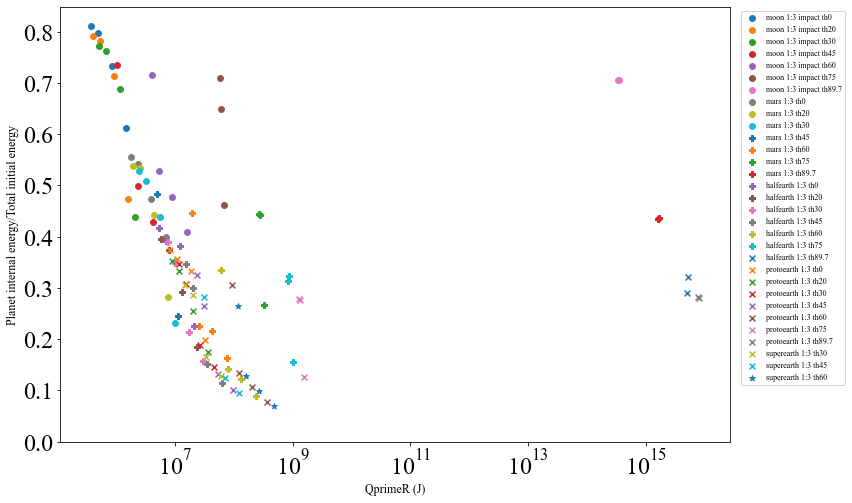

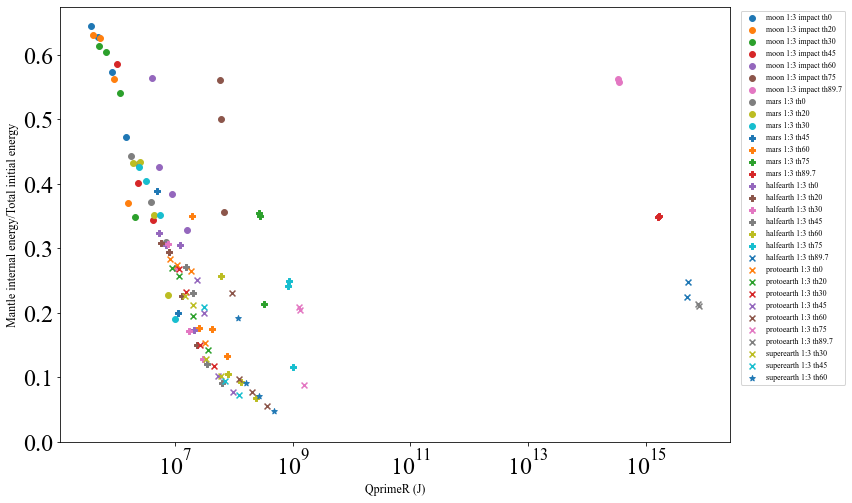

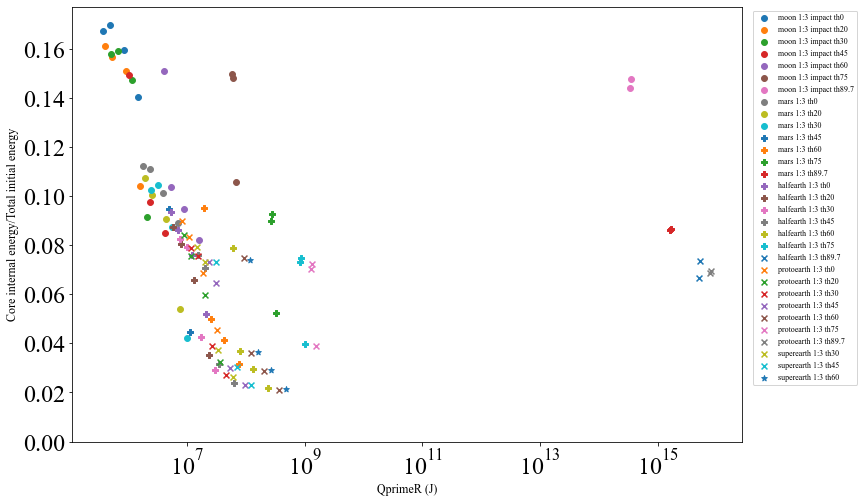

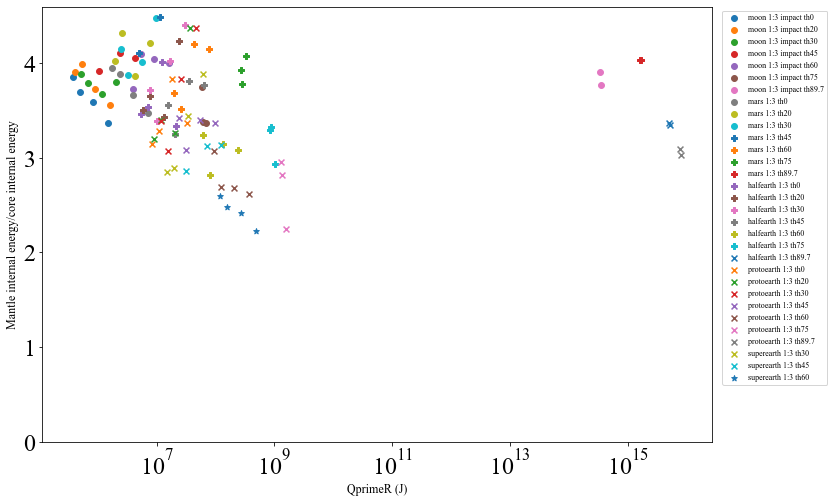

In [33]:
mass1to3list = [moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,moon01x003th897list,mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,mars01x03th897list,halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,halfearth05x017th897list,protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,protoearth091x03th897list,superearth13x043th30list,superearth13x043th45list,superearth13x043th60list]
mass1to3listno0 = [moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,superearth13x043th30list,superearth13x043th45list,superearth13x043th60list]
mass1to3list_nohnr = [moon01x003th30list_nohnr,moon01x003th45list_nohnr,moon01x003th60list_nohnr,mars01x03th30list_nohnr,mars01x03th45list_nohnr,mars01x03th60list_nohnr,halfearth05x017th30list_nohnr,halfearth05x017th45list_nohnr,halfearth05x017th60list_nohnr,protoearth091x03th30list_nohnr,protoearth091x03th45list_nohnr,protoearth091x03th60list_nohnr]
mass1to3labels = ['moon 1:3 impact th0','moon 1:3 impact th20','moon 1:3 impact th30','moon 1:3 impact th45','moon 1:3 impact th60','moon 1:3 impact th75','moon 1:3 impact th89.7','mars 1:3 th0','mars 1:3 th20','mars 1:3 th30','mars 1:3 th45','mars 1:3 th60','mars 1:3 th75','mars 1:3 th89.7','halfearth 1:3 th0','halfearth 1:3 th20','halfearth 1:3 th30','halfearth 1:3 th45','halfearth 1:3 th60','halfearth 1:3 th75','halfearth 1:3 th89.7','protoearth 1:3 th0','protoearth 1:3 th20','protoearth 1:3 th30','protoearth 1:3 th45','protoearth 1:3 th60','protoearth 1:3 th75','protoearth 1:3 th89.7','superearth 1:3 th30','superearth 1:3 th45','superearth 1:3 th60']
mass1to3no0labels = ['moon 1:3 impact th20','moon 1:3 impact th30','moon 1:3 impact th45','moon 1:3 impact th60','moon 1:3 impact th75','mars 1:3 th20','mars 1:3 th30','mars 1:3 th45','mars 1:3 th60','mars 1:3 th75','halfearth 1:3 th20','halfearth 1:3 th30','halfearth 1:3 th45','halfearth 1:3 th60','halfearth 1:3 th75','protoearth 1:3 th20','protoearth 1:3 th30','protoearth 1:3 th45','protoearth 1:3 th60','protoearth 1:3 th75','superearth 1:3 th30','superearth 1:3 th45','superearth 1:3 th60']
QprimeR_u_planet(mass1to3list,labels=mass1to3labels)
QprimeR_u_mantle(mass1to3list,labels=mass1to3labels)
QprimeR_u_core(mass1to3list,labels=mass1to3labels)
QprimeR_u_fraction(mass1to3list,labels=mass1to3labels)
#QprimeR_u_planet(mass1to3list_nohnr,labels=mass1to3labels)
#QprimeR_u_mantle(mass1to3list_nohnr,labels=mass1to3labels)
#QprimeR_u_core(mass1to3list_nohnr,labels=mass1to3labels)
#QprimeR_u_fraction(mass1to3list_nohnr,labels=mass1to3labels)

## Mass 1:6

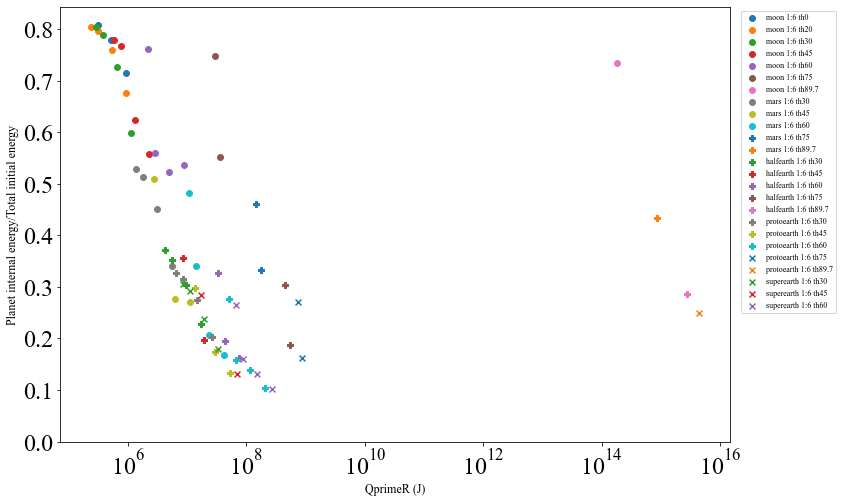

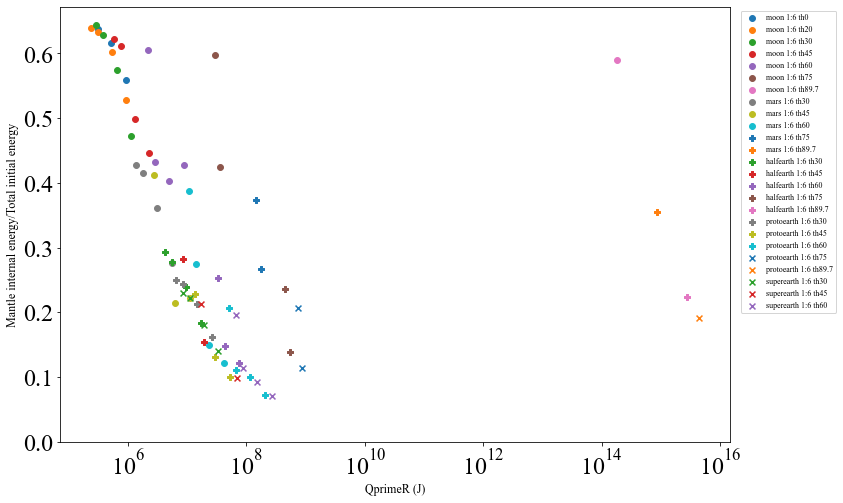

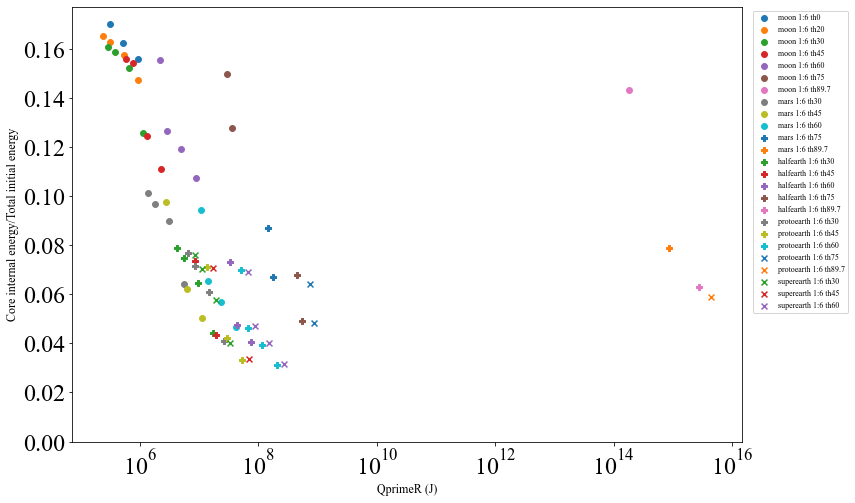

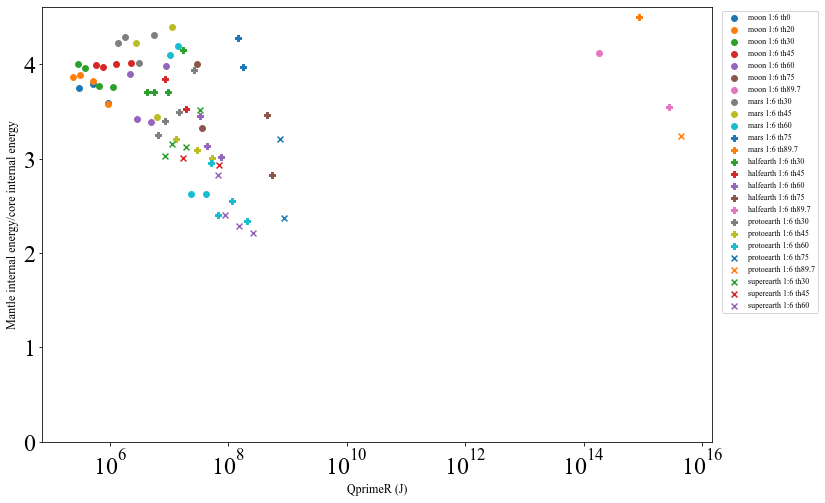

In [34]:
mass1to6list=[moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,moon01x0017th897list,mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,mars01x017th897list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list,halfearth05x08th897list,protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,protoearth091x015th897list,superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list]
mass1to6listno0=[moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list,protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list]
mass1to6list_nohnr=[moon01x0017th30list_nohnr,moon01x0017th45list_nohnr,moon01x0017th60list_nohnr,mars01x017th30list_nohnr,mars01x017th45list_nohnr,mars01x017th60list_nohnr,halfearth05x08th30list_nohnr,halfearth05x08th45list_nohnr,halfearth05x08th60list_nohnr]
mass1to6labels=['moon 1:6 th0','moon 1:6 th20','moon 1:6 th30','moon 1:6 th45','moon 1:6 th60','moon 1:6 th75','moon 1:6 th89.7','mars 1:6 th30','mars 1:6 th45','mars 1:6 th60','mars 1:6 th75','mars 1:6 th89.7','halfearth 1:6 th30','halfearth 1:6 th45','halfearth 1:6 th60','halfearth 1:6 th75','halfearth 1:6 th89.7','protoearth 1:6 th30','protoearth 1:6 th45','protoearth 1:6 th60','protoearth 1:6 th75','protoearth 1:6 th89.7','superearth 1:6 th30','superearth 1:6 th45','superearth 1:6 th60']
mass1to6no0labels=['moon 1:6 th20','moon 1:6 th30','moon 1:6 th45','moon 1:6 th60','moon 1:6 th75','mars 1:6 th30','mars 1:6 th45','mars 1:6 th60','mars 1:6 th75','halfearth 1:6 th30','halfearth 1:6 th45','halfearth 1:6 th60','halfearth 1:6 th75','protoearth 1:6 th30','protoearth 1:6 th45','protoearth 1:6 th60','protoearth 1:6 th75','superearth 1:6 th30','superearth 1:6 th45','superearth 1:6 th60']
QprimeR_u_planet(mass1to6list,labels=mass1to6labels)
QprimeR_u_mantle(mass1to6list,labels=mass1to6labels)
QprimeR_u_core(mass1to6list,labels=mass1to6labels)
QprimeR_u_fraction(mass1to6list,labels=mass1to6labels)
#QprimeR_u_planet(mass1to6list_nohnr,labels=mass1to6labels)
#QprimeR_u_mantle(mass1to6list_nohnr,labels=mass1to6labels)
#QprimeR_u_core(mass1to6list_nohnr,labels=mass1to6labels)
#QprimeR_u_fraction(mass1to6list_nohnr,labels=mass1to6labels)

In [35]:
theta010list=np.concatenate((moon01x005th010list,moon01x003th0list,moon01x0017th0list,mars01x05th0list,mars01x03th0list,halfearth05x025th0list,halfearth05x017th0list,protoearth091x0455th0list,protoearth091x03th0list),axis=0)
theta20list=np.concatenate((moon01x003th20list,moon01x005th20list,moon01x0017th20list,mars01x03th20list,mars01x05th20list,halfearth05x017th20list,halfearth05x025th20list,protoearth091x03th20list,protoearth091x0455th20list),axis=0)
theta30list=np.concatenate((moon01x0017th30list,moon01x003th30list,moon01x005th30list,mars01x017th30list,mars01x03th30list,mars01x05th30list,halfearth05x017th30list,halfearth05x025th30list,halfearth05x08th30list,protoearth091x015th30list,protoearth091x03th30list,protoearth091x0455th30list,superearth13x022vth30list,superearth13x043th30list,superearth13x043th30list,superearth13x065th30list),axis=0)
theta45list=np.concatenate((moon01x0017th45list,moon01x003th45list,moon01x005th45list,mars01x017th45list,mars01x03th45list,mars01x05th45list,halfearth05x017th45list,halfearth05x025th45list,halfearth05x08th45list,protoearth091x015th45list,protoearth091x03th45list,protoearth091x0455th45list,superearth13x043th45list,superearth13x043th45list,superearth13x065th45list),axis=0)
theta60list=np.concatenate((moon01x0017th60list,moon01x003th60list,moon01x005th60list,mars01x017th60list,mars01x03th60list,mars01x05th60list,halfearth05x017th60list,halfearth05x025th60list,halfearth05x08th60list,protoearth091x015th60list,protoearth091x03th60list,protoearth091x0455th60list,superearth13x043th60list,superearth13x043th60list,superearth13x065th60list),axis=0)
theta75list=np.concatenate((moon01x0017th75list,moon01x003th75list,moon01x005th75list,mars01x017th75list,mars01x03th75list,mars01x05th75list,halfearth05x017th75list,halfearth05x025th75list,halfearth05x08th75list,protoearth091x015th75list,protoearth091x03th75list,protoearth091x0455th75list),axis=0)
theta897list=np.concatenate((moon01x0017th897list,moon01x003th897list,moon01x005th897list,mars01x017th897list,mars01x03th897list,mars01x05th897list,halfearth05x017th897list,halfearth05x025th897list,halfearth05x08th897list,protoearth091x015th897list,protoearth091x03th897list,protoearth091x0455th897list),axis=0)
thetalabels=[r'$[\theta_{imp}=0-10]$',r'$[\theta_{imp}=20]$',r'$[\theta_{imp}=30]$',r'$[\theta_{imp}=45]$',r'$[\theta_{imp}=60]$',r'$[\theta_{imp}=75]$',r'$[\theta_{imp}=89.7]$']
thetano0labels=[r'$[\theta_{imp}=20]$',r'$[\theta_{imp}=30]$',r'$[\theta_{imp}=45]$',r'$[\theta_{imp}=60]$',r'$[\theta_{imp}=75]$']
moonlistall = np.concatenate((moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,moon01x0017th897list,moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,moon01x003th897list,moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list,moon01x005th897list),axis=0)
moonlistallno0 = np.concatenate((moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list),axis=0)
marslistall = np.concatenate((mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,mars01x017th897list,mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,mars01x03th897list,mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list,mars01x05th897list),axis=0)
marslistallno0 = np.concatenate((mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list),axis=0)
halfearthlistall = np.concatenate((halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,halfearth05x017th897list,halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,halfearth05x025th897list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list,halfearth05x08th897list),axis=0)
halfearthlistallno0 = np.concatenate((halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list),axis=0)
protoearthlistall = np.concatenate((protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,protoearth091x015th897list,protoearth091x0455th0list,protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,protoearth091x03th897list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list,protoearth091x0455th897list),axis=0)
protoearthlistallno0 = np.concatenate((protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list),axis=0)
superearthlistall = np.concatenate((superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list,superearth13x043th30list,superearth13x043th45list,superearth13x043th60list,superearth13x065th30list,superearth13x065th45list,superearth13x065th60list),axis=0)
superearthlistalln0 = np.concatenate((superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list,superearth13x043th30list,superearth13x043th45list,superearth13x043th60list,superearth13x065th30list,superearth13x065th45list,superearth13x065th60list),axis=0)
sizelabels=[r'Moon target $[0.01 M_\oplus]$',r'Mars target $[0.1 M_\oplus]$',r'Half-earth target $[0.5 M_\oplus]$',r'Proto-earth target $[0.91 M_\oplus]$',r'Super-earth target $[1.3 M_\oplus]$']
mass1to2concat = np.concatenate(mass1to2list,axis=0)
mass1to2no0concat = np.concatenate(mass1to2listno0,axis=0)
mass1to3concat = np.concatenate(mass1to3list,axis=0)
mass1to3no0concat = np.concatenate(mass1to3listno0,axis=0)
mass1to6concat = np.concatenate(mass1to6list,axis=0)
mass1to6no0concat = np.concatenate(mass1to6listno0,axis=0)

## All Q'R data

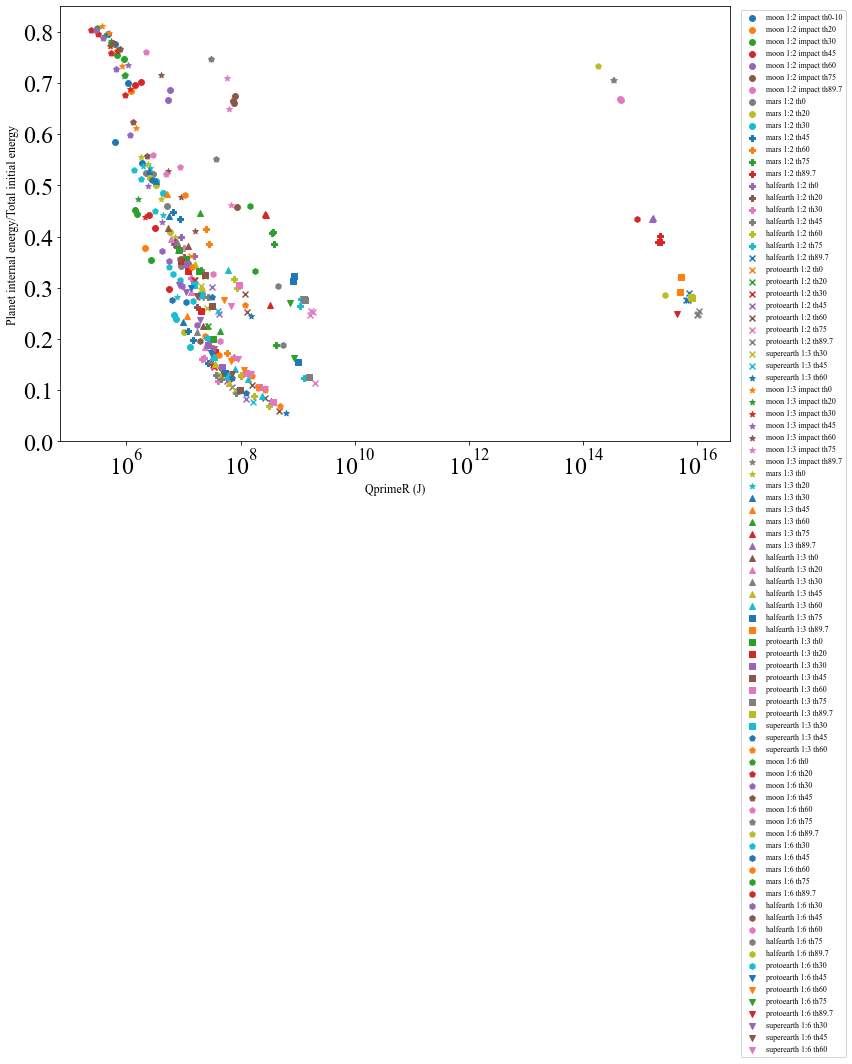

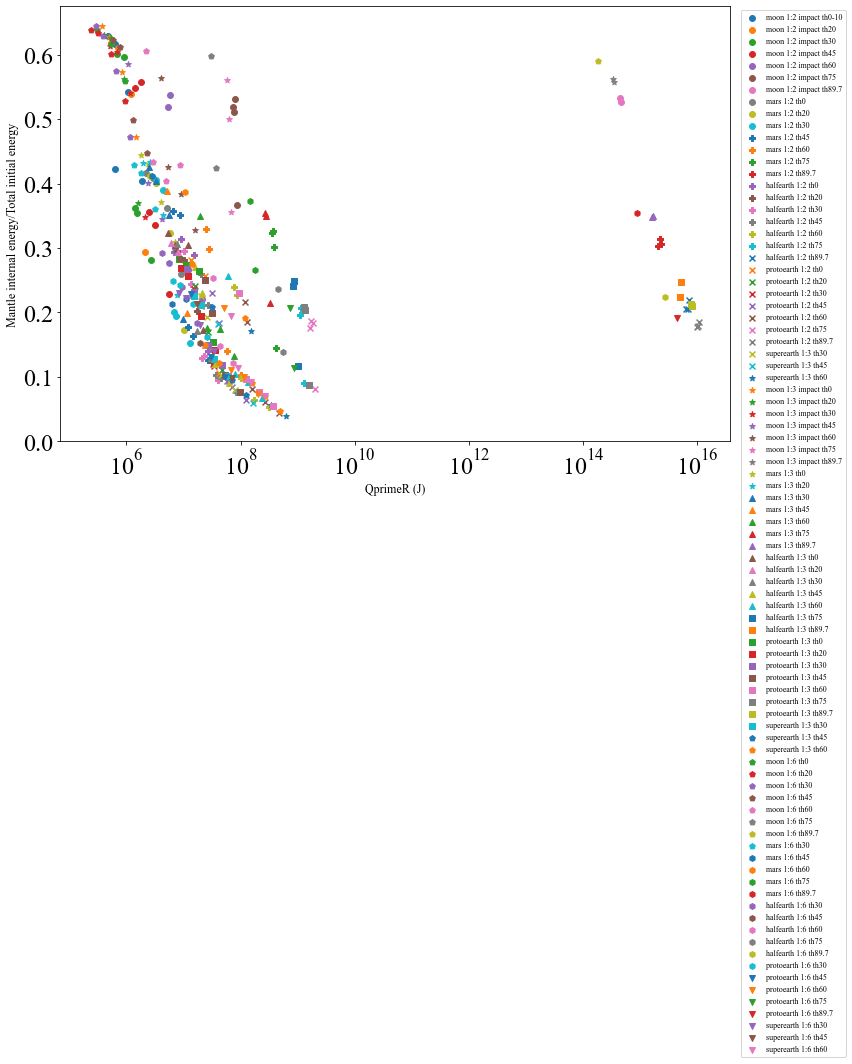

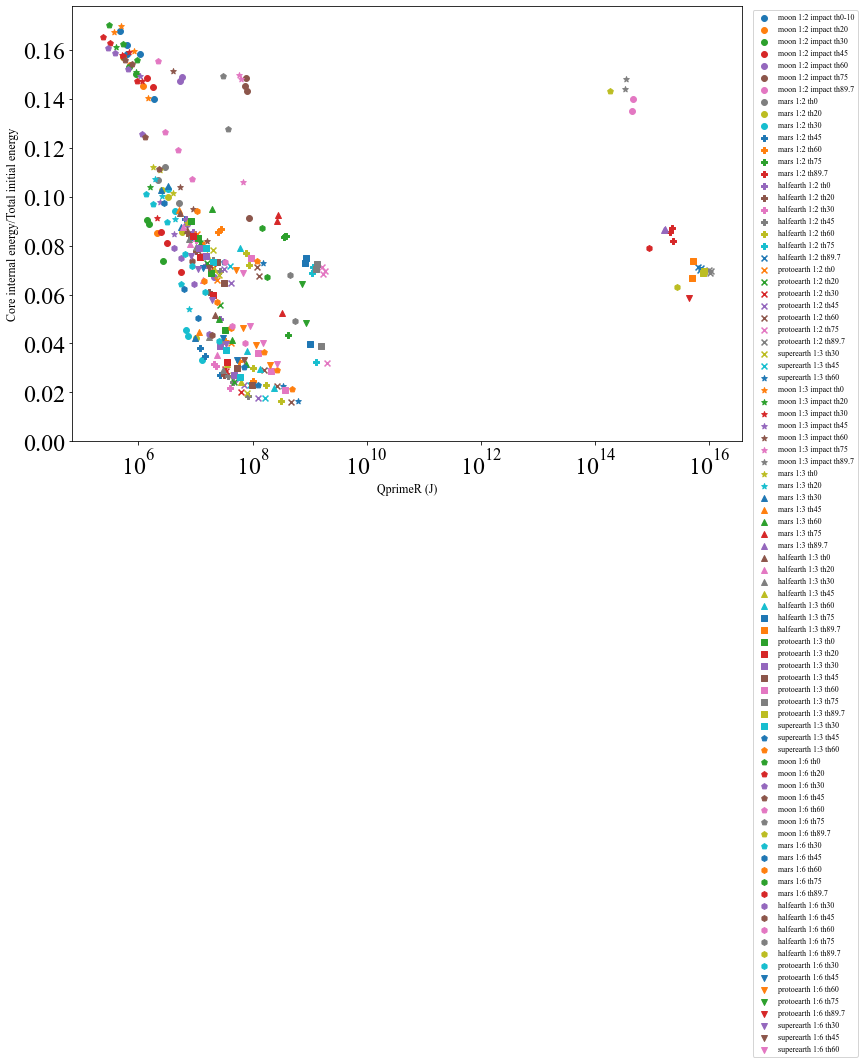

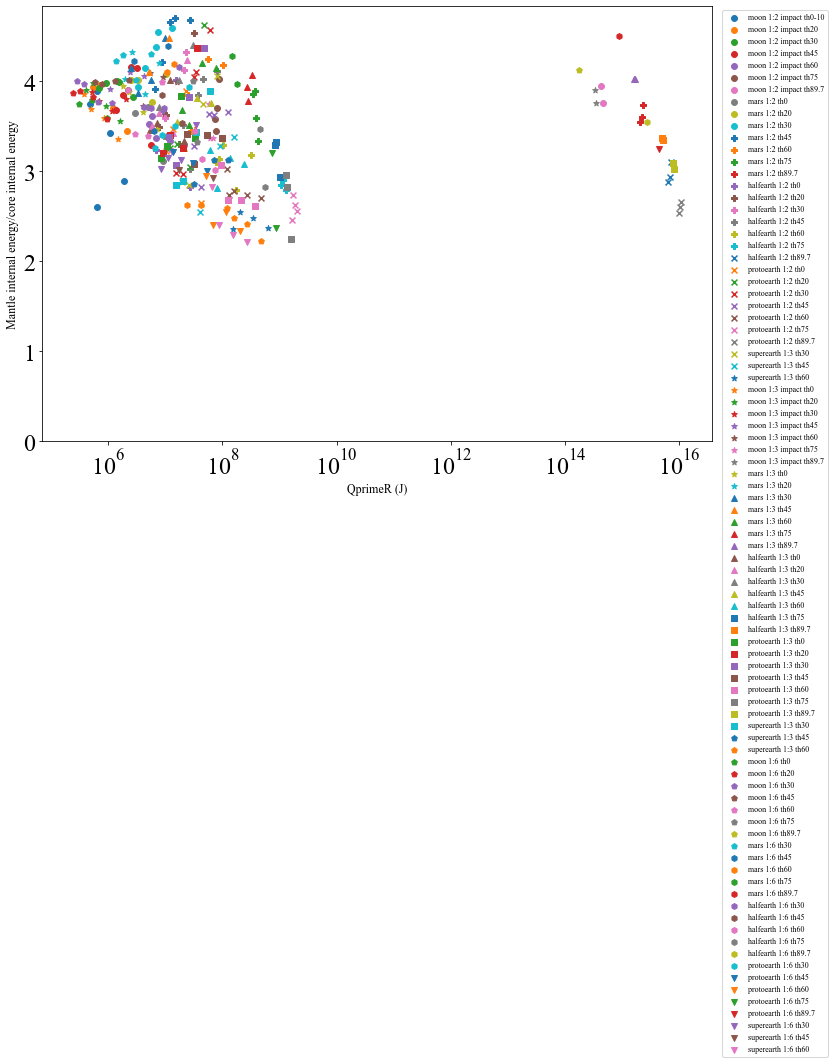

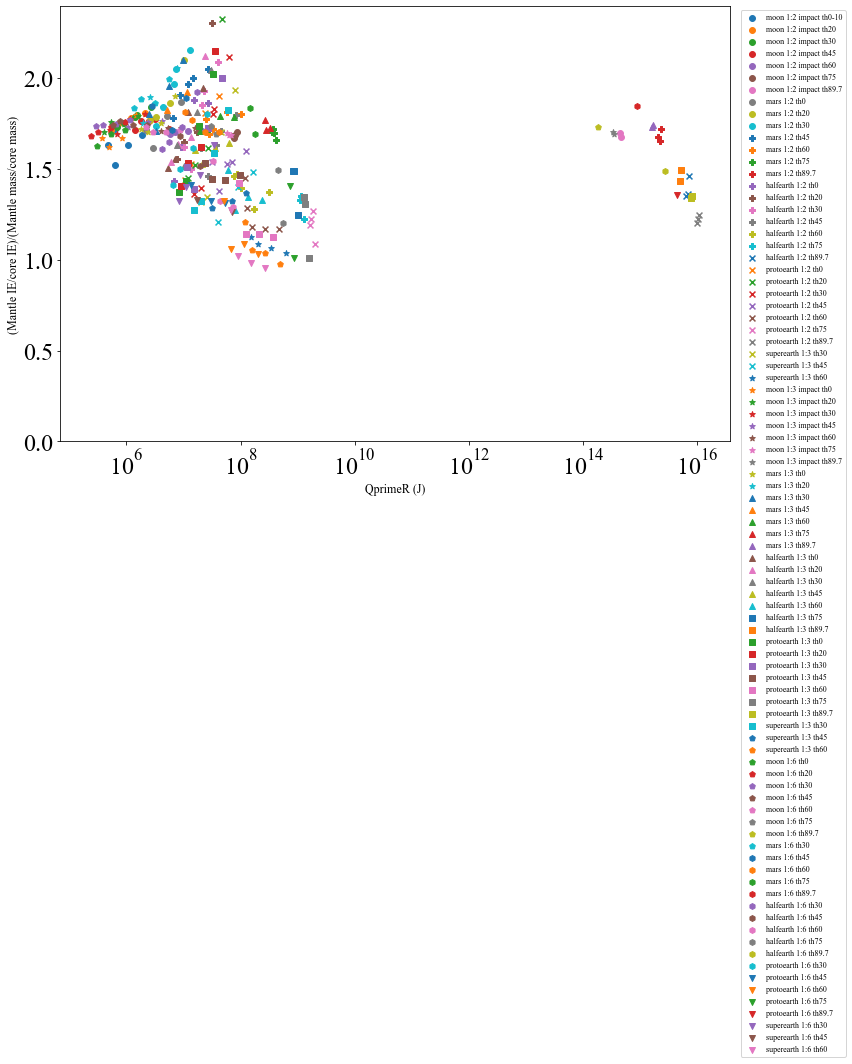

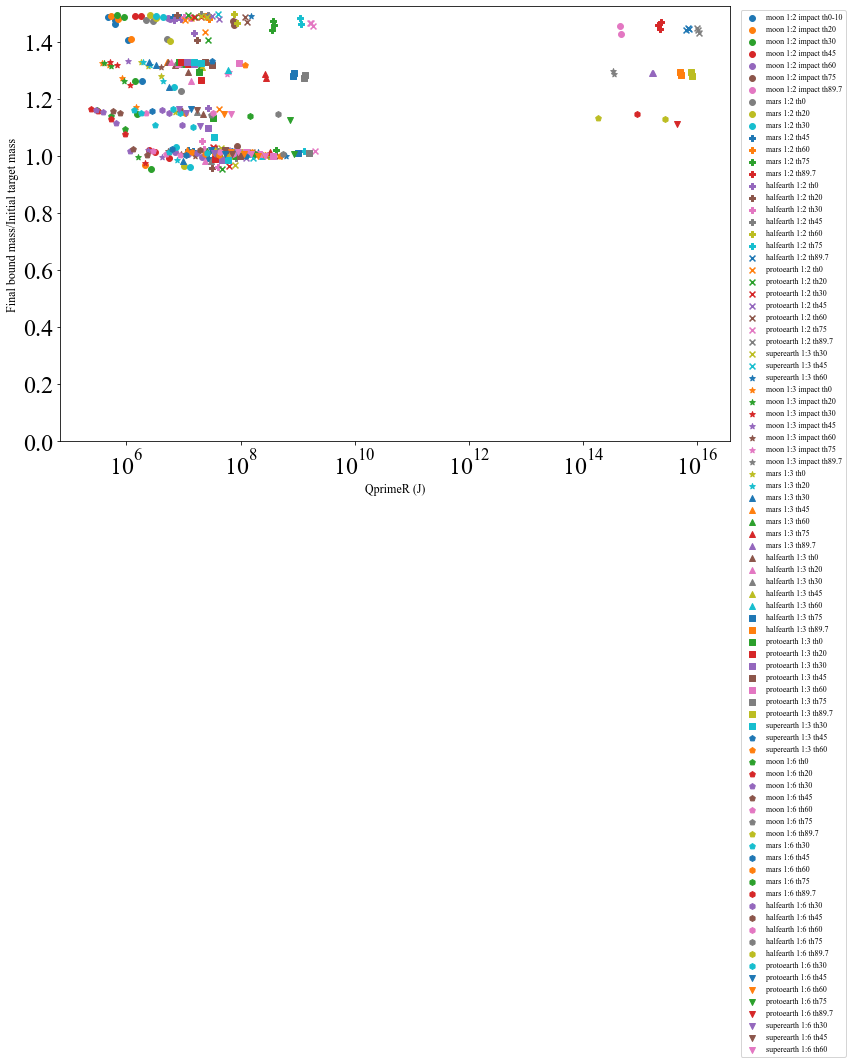

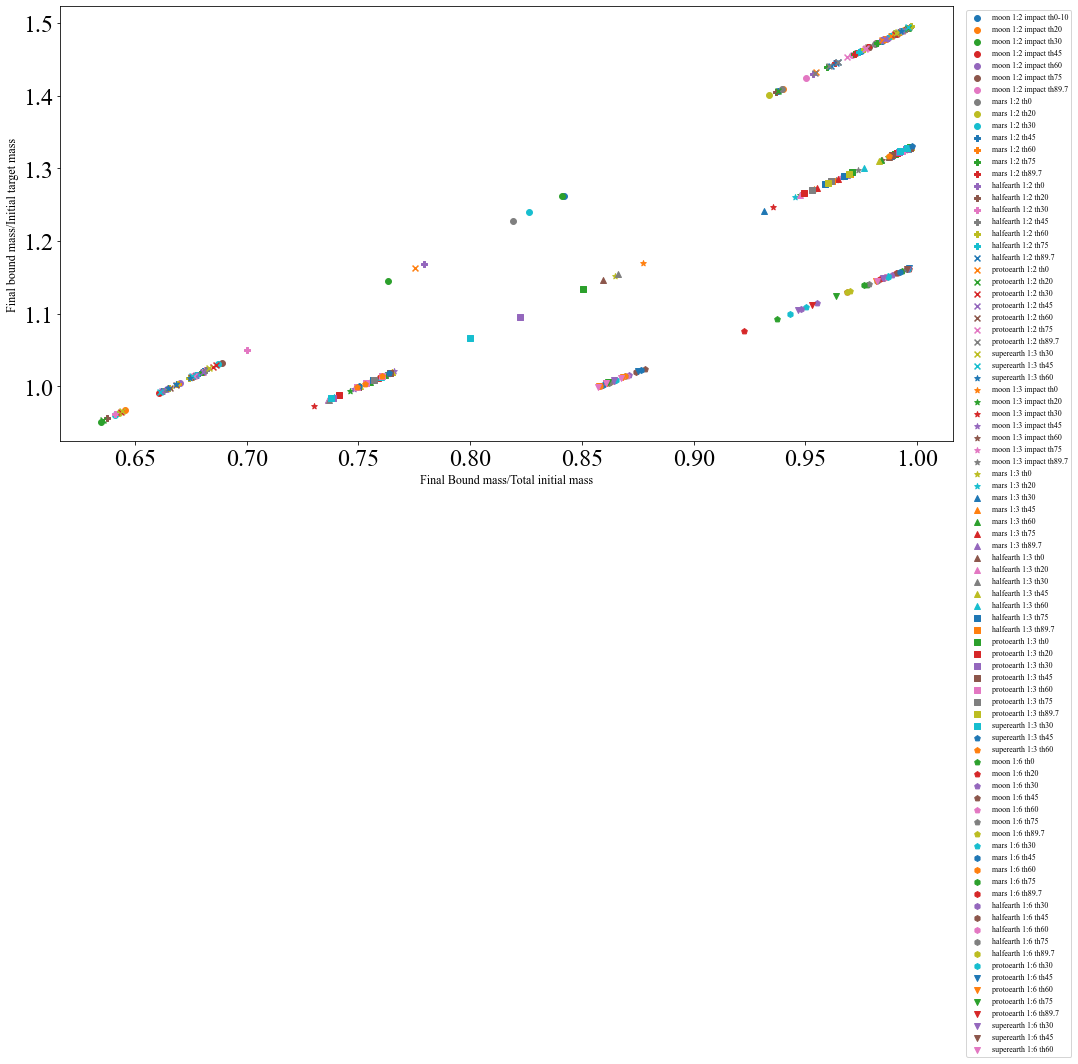

In [36]:
alldatalist = mass1to2list+mass1to3list+mass1to6list
alldatalistno0 = mass1to2listno0+mass1to3listno0+mass1to6listno0
alllabels = mass1to2labels+mass1to3labels+mass1to6labels
alllabelsno0 = mass1to2no0labels+mass1to3no0labels+mass1to6no0labels
massratiolabels=['Mass ratio 1:2','Mass ratio 1:3','Mass ratio 1:6']
QprimeR_u_planet(alldatalist,labels=alllabels)
QprimeR_u_mantle(alldatalist,labels=alllabels)
QprimeR_u_core(alldatalist,labels=alllabels)
QprimeR_u_fraction(alldatalist,labels=alllabels)
QprimeR_u_massfraction(alldatalist,labels=alllabels)
QprimeR_u_planetmass(alldatalist,labels=alllabels)
accretion_eff(alldatalist,labels=alllabels)

### Q'R data by mass ratio

In [ ]:
QprimeR_u_planet([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QprimeR_u_mantle([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QprimeR_u_core([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QprimeR_u_fraction([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QprimeR_u_massfraction([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QprimeR_u_planetmass([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
accretion_eff([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)

### Q'R data by impact angle

In [ ]:
QprimeR_u_planet([theta30list,theta45list,theta60list],labels=thetalabels)
QprimeR_u_mantle([theta30list,theta45list,theta60list],labels=thetalabels)
QprimeR_u_core([theta30list,theta45list,theta60list],labels=thetalabels)
QprimeR_u_fraction([theta30list,theta45list,theta60list],labels=thetalabels)
QprimeR_u_massfraction([theta30list,theta45list,theta60list],labels=thetalabels)
QprimeR_u_planetmass([theta30list,theta45list,theta60list],labels=thetalabels)
accretion_eff([theta30list,theta45list,theta60list],labels=thetalabels)

### Q'R data by target size

In [ ]:
QprimeR_u_planet([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels)
QprimeR_u_mantle([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels)
QprimeR_u_core([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels)
QprimeR_u_fraction([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels)
QprimeR_u_massfraction([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels)
QprimeR_u_planetmass([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels)
accretion_eff([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels)

# Q*'R plots

## Mass 1:2

In [ ]:
QprimeR_u_planet(mass1to2list,mass1to2labels,star=True)
QprimeR_u_mantle(mass1to2list,mass1to2labels,star=True)
QprimeR_u_core(mass1to2list,mass1to2labels,star=True)
QprimeR_u_fraction(mass1to2list,mass1to2labels,star=True)

## Mass 1:3

In [ ]:
QprimeR_u_planet(mass1to3list,labels=mass1to3labels,star=True)
QprimeR_u_mantle(mass1to3list,labels=mass1to3labels,star=True)
QprimeR_u_core(mass1to3list,labels=mass1to3labels,star=True)
QprimeR_u_fraction(mass1to3list,labels=mass1to3labels,star=True)

## Mass 1:6

In [ ]:
QprimeR_u_planet(mass1to6list,labels=mass1to6labels,star=True)
QprimeR_u_mantle(mass1to6list,labels=mass1to6labels,star=True)
QprimeR_u_core(mass1to6list,labels=mass1to6labels,star=True)
QprimeR_u_fraction(mass1to6list,labels=mass1to6labels,star=True)

## All Q*'R data

In [ ]:
QprimeR_u_planet(alldatalist,labels=alllabels,star=True)
QprimeR_u_mantle(alldatalist,labels=alllabels,star=True)
QprimeR_u_core(alldatalist,labels=alllabels,star=True)
QprimeR_u_fraction(alldatalist,labels=alllabels,star=True)
QprimeR_u_massfraction(alldatalist,labels=alllabels,star=True)
QprimeR_u_planetmass(alldatalist,labels=alllabels,star=True)
accretion_eff(alldatalist,labels=alllabels)

### Q*'R data by mass ratio

In [ ]:
QprimeR_u_planet([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels,star=True)
QprimeR_u_mantle([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels,star=True)
QprimeR_u_core([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels,star=True)
QprimeR_u_fraction([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels,star=True)
QprimeR_u_massfraction([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels,star=True)
QprimeR_u_planetmass([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels,star=True)
accretion_eff([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)

### Q*'R data by impact angle

In [ ]:
QprimeR_u_planet([theta30list,theta45list,theta60list],labels=thetalabels,star=True)
QprimeR_u_mantle([theta30list,theta45list,theta60list],labels=thetalabels,star=True)
QprimeR_u_core([theta30list,theta45list,theta60list],labels=thetalabels,star=True)
QprimeR_u_fraction([theta30list,theta45list,theta60list],labels=thetalabels,star=True)
QprimeR_u_massfraction([theta30list,theta45list,theta60list],labels=thetalabels,star=True)
QprimeR_u_planetmass([theta30list,theta45list,theta60list],labels=thetalabels,star=True)
accretion_eff([theta30list,theta45list,theta60list],labels=thetalabels)

### Q*'R data by target size

In [ ]:
QprimeR_u_planet([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels,star=True)
QprimeR_u_mantle([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels,star=True)
QprimeR_u_core([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels,star=True)
QprimeR_u_fraction([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels,star=True)
QprimeR_u_massfraction([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels,star=True)
QprimeR_u_planetmass([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels,star=True)
accretion_eff([moonlistall,marslistall,halfearthlistall,protoearthlistall],labels=sizelabels)

# QS plots

In [37]:
moonlists = [moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list,moon01x005th897list,moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,moon01x003th897list,moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,moon01x0017th897list]
moonlabels = ['moon 1:2 th0-10','moon 1:2 th20','moon 1:2 th30','moon 1:2 th45','moon 1:2 th60','moon 1:2 th75','moon 1:2 th89.7','moon 1:3 th0','moon 1:3 th20','moon 1:3 th30','moon 1:3 th45','moon 1:3 th60','moon 1:3 th75','moon 1:3 th89.7','moon 1:6 th0','moon 1:6 th20','moon 1:6 th30','moon 1:6 th45','moon 1:6 th60','moon 1:6 th75','moon 1:6 th89.7']
moon1to2list=np.concatenate((moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list,moon01x005th897list),axis=0)
moon1to3list=np.concatenate((moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,moon01x003th897list),axis=0)
moon1to6list=np.concatenate((moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,moon01x0017th897list),axis=0)
marslists = [mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list,mars01x05th897list,mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,mars01x03th897list,mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,mars01x017th897list]
marslabels = ['mars 1:2 th0','mars 1:2 th20','mars 1:2 th30','mars 1:2 th45','mars 1:2 th60','mars 1:2 th75','mars 1:2 th89.7','mars 1:3 th0','mars 1:3 th20','mars 1:3 th30','mars 1:3 th45','mars 1:3 th60','mars 1:3 th75','mars 1:3 th89.7','mars 1:6 th30','mars 1:6 th45','mars 1:6 th60','mars 1:6 th75','mars 1:6 th89.7']
mars1to2list=np.concatenate((mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list,mars01x05th897list),axis=0)
mars1to3list=np.concatenate((mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,mars01x03th897list),axis=0)
mars1to6list=np.concatenate((mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,mars01x017th897list),axis=0)
halfearthlists = [halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,halfearth05x025th897list,halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,halfearth05x017th897list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list,halfearth05x08th897list]
halfearthlabels = ['halfearth 1:2 th0','halfearth 1:2 th20','halfearth 1:2 th30','halfearth 1:2 th45','halfearth 1:2 th60','halfearth 1:2 th75','halfearth 1:2 th89.7','halfearth 1:3 th0','halfearth 1:3 th20','halfearth 1:3 th30','halfearth 1:3 th45','halfearth 1:3 th60','halfearth 1:3 th75','halfearth 1:3 th89.7','halfearth 1:6 th30','halfearth 1:6 th45','halfearth 1:6 th60','halfearth 1:6 th75','halfearth 1:6 th89.7']
halfearth1to2list=np.concatenate((halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,halfearth05x025th897list),axis=0)
halfearth1to3list=np.concatenate((halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,halfearth05x017th897list),axis=0)
halfearth1to6list=np.concatenate((halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list,halfearth05x08th897list),axis=0)
protoearthlists = [protoearth091x0455th0list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list,protoearth091x0455th897list,protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,protoearth091x03th897list,protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,protoearth091x015th897list]
protoearthlabels = ['protoearth 1:2 th0','protoearth 1:2 th20','protoearth 1:2 th30','protoearth 1:2 th45','protoearth 1:2 th60','protoearth 1:2 th75','protoearth 1:2 th89.7','protoearth 1:3 th0','protoearth 1:3 th20','protoearth 1:3 th30','protoearth 1:3 th45','protoearth 1:3 th60','protoearth 1:3 th75','protoearth 1:3 th89.7','protoearth 1:6 th30','protoearth 1:6 th45','protoearth 1:6 th60','protoearth 1:6 th75','protoearth 1:6 th89.7']
protoearth1to2list=np.concatenate((protoearth091x0455th0list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list,protoearth091x0455th897list),axis=0)
protoearth1to3list=np.concatenate((protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,protoearth091x03th897list),axis=0)
protoearth1to6list=np.concatenate((protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,protoearth091x015th897list),axis=0)
superearthlists=[superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list,superearth13x043th30list,superearth13x043th45list,superearth13x043th60list,superearth13x065th30list,superearth13x065th45list,superearth13x065th60list]
superearthlabels = ['superearth 1:6 th30','superearth 1:6 th45','superearth 1:6 th60','superearth 1:3 th30','superearth 1:3 th45','superearth 1:3 th60','superearth 1:2 th30','superearth 1:2 th45','superearth 1:2 th60']
superearth1to2list=np.concatenate((superearth13x065th30list,superearth13x065th45list,superearth13x065th60list),axis=0)
superearth1to3list=np.concatenate((superearth13x043th30list,superearth13x043th45list,superearth13x043th60list),axis=0)
superearth1to6list=np.concatenate((superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list),axis=0)
massandratiolist=[moon1to2list,moon1to3list,moon1to6list,mars1to2list,mars1to3list,mars1to6list,halfearth1to2list,halfearth1to3list,halfearth1to6list,protoearth1to2list,protoearth1to3list,protoearth1to6list,superearth1to2list,superearth1to3list,superearth1to6list]
massandratiolabels=[r'Moon 1:2 $[0.01:0.005 M_\oplus]$',r'Moon 1:3 $[0.01:0.00333 M_\oplus]$',r'Moon 1:6 $[0.01:0.00167 M_\oplus]$',r'Mars 1:2 $[0.1:0.05 M_\oplus]$',r'Mars 1:3 $[0.1:0.0333 M_\oplus]$',r'Mars 1:6 $[0.1:0.0167 M_\oplus]$',r'Half-earth 1:2 $[0.5:0.25 M_\oplus]$',r'Half-earth 1:3 $[0.5:0.167 M_\oplus]$',r'Half-earth 1:6 $[0.5:0.083 M_\oplus]$',r'Proto-earth 1:2 $[0.91:0.455 M_\oplus]$',r'Proto-earth 1:3 $[0.91:0.303 M_\oplus]$',r'Proto-earth 1:6 $[0.91:0.152 M_\oplus]$',r'Super-earth 1:2 $[1.3:0.65 M_\oplus]$',r'Super-earth 1:3 $[1.3:0.43 M_\oplus]$',r'Super-earth 1:6 $[1.3:0.22 M_\oplus]$']

accretionlist=[]
accretionlistno0=[]
accretionlistno90=[]
accretion010list=[]
accretion20list=[]
accretion30list=[]
accretion45list=[]
accretion60list=[]
accretion75list=[]
accretion897list=[]
partialaccretionlist=[]
partialaccretionlistno0=[]
partialaccretionlistno90=[]
partialaccretion010list=[]
partialaccretion20list=[]
partialaccretion30list=[]
partialaccretion45list=[]
partialaccretion60list=[]
partialaccretion75list=[]
partialaccretion897list=[]
hitandrunlist=[]
hitandrunlistno0=[]
hitandrunlistno90=[]
hitandrun010list=[]
hitandrun20list=[]
hitandrun30list=[]
hitandrun45list=[]
hitandrun60list=[]
hitandrun75list=[]
hitandrun897list=[]
thetasubcritlist=[]
thetasupercritlist=[]
outcomelabels=['Accretion','Partial accretion','Hit-and-run']
for i in range(np.shape(alldatalist)[0]):
        simlist = alldatalist[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if sim.b>=sim.B_crit: thetasupercritlist.append(sim)
            if sim.b<sim.B_crit: thetasubcritlist.append(sim)
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                accretionlist.append(sim)
                if (sim.theta>0.) & (sim.theta<89.7): accretionlistno0.append(sim)
                if (sim.theta!=89.7): accretionlistno90.append(sim)
                sim.outcomemarker=markerlist[0]
                if sim.theta==0: accretion010list.append(sim)
                if sim.theta==20: accretion20list.append(sim)
                if sim.theta==30: accretion30list.append(sim)
                if sim.theta==45: accretion45list.append(sim)
                if sim.theta==60: accretion60list.append(sim)
                if sim.theta==75: accretion75list.append(sim)
                if sim.theta==89.7: accretion897list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                partialaccretionlist.append(sim)
                if (sim.theta>0.) & (sim.theta<89.7): partialaccretionlistno0.append(sim)
                if (sim.theta!=89.7): partialaccretionlistno90.append(sim)
                sim.outcomemarker=markerlist[1]
                if sim.theta==0: partialaccretion010list.append(sim)
                if sim.theta==20: partialaccretion20list.append(sim)
                if sim.theta==30: partialaccretion30list.append(sim)
                if sim.theta==45: partialaccretion45list.append(sim)
                if sim.theta==60: partialaccretion60list.append(sim)
                if sim.theta==75: partialaccretion75list.append(sim)
                if sim.theta==89.7: partialaccretion897list.append(sim)
            elif xi<=0.2:
                hitandrunlist.append(sim)
                if (sim.theta>0.) & (sim.theta<89.7): hitandrunlistno0.append(sim)
                if (sim.theta!=89.7): hitandrunlistno90.append(sim)
                sim.outcomemarker=markerlist[2]
                if sim.theta==0: hitandrun010list.append(sim)
                if sim.theta==20: hitandrun20list.append(sim)
                if sim.theta==30: hitandrun30list.append(sim)
                if sim.theta==45: hitandrun45list.append(sim)
                if sim.theta==60: hitandrun60list.append(sim)
                if sim.theta==75: hitandrun75list.append(sim)
                if sim.theta==89.7: hitandrun897list.append(sim)
                
moonaccretionlist=[]
moonaccretion010list=[]
moonaccretion20list=[]
moonaccretion30list=[]
moonaccretion45list=[]
moonaccretion60list=[]
moonaccretion75list=[]
moonaccretion897list=[]
moonpartiallist=[]
moonhitandrunlist=[]
for i in range(np.shape(moonlists)[0]):
        simlist = moonlists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                moonaccretionlist.append(sim)
                if sim.theta==0: moonaccretion010list.append(sim)
                if sim.theta==20: moonaccretion20list.append(sim)
                if sim.theta==30: moonaccretion30list.append(sim)
                if sim.theta==45: moonaccretion45list.append(sim)
                if sim.theta==60: moonaccretion60list.append(sim)
                if sim.theta==75: moonaccretion75list.append(sim)
                if sim.theta==89.7: moonaccretion897list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                moonpartiallist.append(sim)
            elif xi<=0.2:
                moonhitandrunlist.append(sim)
                
marsaccretionlist=[]
marsaccretion010list=[]
marsaccretion20list=[]
marsaccretion30list=[]
marsaccretion45list=[]
marsaccretion60list=[]
marsaccretion75list=[]
marsaccretion897list=[]
marspartiallist=[]
marshitandrunlist=[]
for i in range(np.shape(marslists)[0]):
        simlist = marslists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                marsaccretionlist.append(sim)
                if sim.theta==0: marsaccretion010list.append(sim)
                if sim.theta==20: marsaccretion20list.append(sim)
                if sim.theta==30: marsaccretion30list.append(sim)
                if sim.theta==45: marsaccretion45list.append(sim)
                if sim.theta==60: marsaccretion60list.append(sim)
                if sim.theta==75: marsaccretion75list.append(sim)
                if sim.theta==89.7: marsaccretion897list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                marspartiallist.append(sim)
            elif xi<=0.2:
                marshitandrunlist.append(sim)

halfearthaccretionlist=[]
halfearthaccretion010list=[]
halfearthaccretion20list=[]
halfearthaccretion30list=[]
halfearthaccretion45list=[]
halfearthaccretion60list=[]
halfearthaccretion75list=[]
halfearthaccretion897list=[]
halfearthpartiallist=[]
halfearthhitandrunlist=[]
for i in range(np.shape(halfearthlists)[0]):
        simlist = halfearthlists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                halfearthaccretionlist.append(sim)
                if sim.theta==0: halfearthaccretion010list.append(sim)
                if sim.theta==20: halfearthaccretion20list.append(sim)
                if sim.theta==30: halfearthaccretion30list.append(sim)
                if sim.theta==45: halfearthaccretion45list.append(sim)
                if sim.theta==60: halfearthaccretion60list.append(sim)
                if sim.theta==75: halfearthaccretion75list.append(sim)
                if sim.theta==89.7: halfearthaccretion897list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                halfearthpartiallist.append(sim)
            elif xi<=0.2:
                halfearthhitandrunlist.append(sim)
                
protoearthaccretionlist=[]
protoearthaccretion010list=[]
protoearthaccretion20list=[]
protoearthaccretion30list=[]
protoearthaccretion45list=[]
protoearthaccretion60list=[]
protoearthaccretion75list=[]
protoearthaccretion897list=[]
protoearthpartiallist=[]
protoearthhitandrunlist=[]
for i in range(np.shape(protoearthlists)[0]):
        simlist = protoearthlists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                protoearthaccretionlist.append(sim)
                if sim.theta==0: protoearthaccretion010list.append(sim)
                if sim.theta==20: protoearthaccretion20list.append(sim)
                if sim.theta==30: protoearthaccretion30list.append(sim)
                if sim.theta==45: protoearthaccretion45list.append(sim)
                if sim.theta==60: protoearthaccretion60list.append(sim)
                if sim.theta==75: protoearthaccretion75list.append(sim)
                if sim.theta==89.7: protoearthaccretion897list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                protoearthpartiallist.append(sim)
            elif xi<=0.2:
                protoearthhitandrunlist.append(sim)
                
superearthaccretionlist=[]
superearthaccretion010list=[]
superearthaccretion20list=[]
superearthaccretion30list=[]
superearthaccretion45list=[]
superearthaccretion60list=[]
superearthpartiallist=[]
superearthhitandrunlist=[]
for i in range(np.shape(superearthlists)[0]):
        simlist = superearthlists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                superearthaccretionlist.append(sim)
                if sim.theta==0: superearthaccretion010list.append(sim)
                if sim.theta==20: superearthaccretion20list.append(sim)
                if sim.theta==30: superearthaccretion30list.append(sim)
                if sim.theta==45: superearthaccretion45list.append(sim)
                if sim.theta==60: superearthaccretion60list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                superearthpartiallist.append(sim)
            elif xi<=0.2:
                superearthhitandrunlist.append(sim)
                
print('total accretion: ',np.size(accretionlist))
print('partial accretion: ',np.size(partialaccretionlist))
print('hit-and-run',np.size(hitandrunlist))
print('accretion fraction: ',np.size(accretionlist)/(np.size(accretionlist)+np.size(partialaccretionlist)+np.size(hitandrunlist)))
print('partial accretion fraction: ',np.size(partialaccretionlist)/(np.size(accretionlist)+np.size(partialaccretionlist)+np.size(hitandrunlist)))
print('hit-and-run fraction',np.size(hitandrunlist)/(np.size(accretionlist)+np.size(partialaccretionlist)+np.size(hitandrunlist)))
print('halfearth accretion: ',np.size(halfearthaccretionlist))
print('protoearth accretion: ',np.size(protoearthaccretionlist))

total accretion:  162
partial accretion:  32
hit-and-run 116
accretion fraction:  0.5225806451612903
partial accretion fraction:  0.1032258064516129
hit-and-run fraction 0.3741935483870968
halfearth accretion:  36
protoearth accretion:  36


# QS Plots:
# Mass 1:2

In [ ]:
#QS_ICs_theta(mass1to2list,mass1to2labels)
#QS_ICs_vi(mass1to2list,mass1to2labels)
QS_u_planet(mass1to2list,mass1to2labels,xlim=3e8)
QS_u_mantle(mass1to2list,mass1to2labels,xlim=3e8)
QS_u_core(mass1to2list,mass1to2labels,xlim=3e8)
QS_u_fraction(mass1to2list,mass1to2labels,xlim=3e8)
QS_u_massfraction(mass1to2list,labels=mass1to2labels)
QS_u_planetmass(mass1to2list,labels=mass1to2labels)
QS_u_xi(mass1to2list,labels=mass1to2labels)
QS_u_scaled_xi(mass1to2list,labels=mass1to2labels,erfcfit=True,arctanfit=True)
accretion_eff(mass1to2list,labels=mass1to2labels)
QS_u_scaled_planetmass(mass1to2list,labels=mass1to2labels)

## Mass 1:3

In [ ]:
QS_u_planet(mass1to3list,labels=mass1to3labels)
QS_u_mantle(mass1to3list,labels=mass1to3labels)
QS_u_core(mass1to3list,labels=mass1to3labels)
QS_u_fraction(mass1to3list,labels=mass1to3labels)
QS_u_massfraction(mass1to3list,labels=mass1to3labels)
QS_u_planetmass(mass1to3list,labels=mass1to3labels)
QS_u_xi(mass1to3list,labels=mass1to3labels)
QS_u_scaled_xi(mass1to3list,labels=mass1to3labels,erfcfit=True,arctanfit=True)
accretion_eff(mass1to3list,labels=mass1to3labels)
QS_u_scaled_planetmass(mass1to3list,labels=mass1to3labels)

## Mass 1:6

In [ ]:
QS_u_planet(mass1to6list,labels=mass1to6labels)
QS_u_mantle(mass1to6list,labels=mass1to6labels)
QS_u_core(mass1to6list,labels=mass1to6labels)
QS_u_fraction(mass1to6list,labels=mass1to6labels)
QS_u_massfraction(mass1to6list,labels=mass1to6labels)
QS_u_planetmass(mass1to6list,labels=mass1to6labels)
QS_u_xi(mass1to6list,labels=mass1to6labels)
QS_u_scaled_xi(mass1to6list,labels=mass1to6labels,erfcfit=True,arctanfit=True)
accretion_eff(mass1to6list,labels=mass1to6labels)
QS_u_scaled_planetmass(mass1to6list,labels=mass1to6labels)

## All QS data

In [ ]:
#QS_IE_planet(alldatalist,labels=alllabels,loglog=True)
QS_u_planet(alldatalist,labels=alllabels)
QS_u_mantle(alldatalist,labels=alllabels)
QS_u_core(alldatalist,labels=alllabels)
QS_u_mantle_fraction(alldatalist,labels=alllabels)
QS_u_core_fraction(alldatalist,labels=alllabels)
QS_u_fraction(alldatalist,labels=alllabels)
QS_u_massfraction(alldatalist,labels=alllabels)
QS_u_planetmass(alldatalist,labels=alllabels)
QS_u_xi(alldatalist,labels=alllabels)
QS_u_scaled_xi(alldatalist,labels=alllabels)
accretion_eff(alldatalist,labels=alllabels)
QS_u_scaled_planetmass(alldatalist,labels=alllabels)
QS_u_scaled_planetmass(alldatalist,labels=None,colors='Lz',markers='outcome')
#QS_delta_u_planet(alldatalist,labels=alllabels,loglog=True)
T_CMB_QS_Lz(alldatalist,markers='outcome',colors='Lz',legend=False)

### QS data by mass ratio

In [ ]:
QS_u_planet([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QS_u_mantle([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QS_u_core([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QS_u_fraction([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QS_u_massfraction([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QS_u_planetmass([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QS_u_xi([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QS_u_scaled_xi([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels,arctanfit=True,fitlabels=True)
accretion_eff([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)
QS_u_scaled_planetmass([mass1to2concat,mass1to3concat,mass1to6concat],labels=massratiolabels)

### QS data by impact angle

In [ ]:
QS_u_planet([theta010list,theta20list,theta30list,theta45list,theta60list,theta75list,theta897list],labels=thetalabels)
QS_u_mantle([theta010list,theta20list,theta30list,theta45list,theta60list,theta75list,theta897list],labels=thetalabels)
QS_u_core([theta010list,theta20list,theta30list,theta45list,theta60list,theta75list,theta897list],labels=thetalabels)
QS_u_fraction([theta010list,theta20list,theta30list,theta45list,theta60list,theta75list,theta897list],labels=thetalabels)
QS_u_massfraction([theta010list,theta20list,theta30list,theta45list,theta60list,theta75list,theta897list],labels=thetalabels)
QS_u_planetmass([theta010list,theta20list,theta30list,theta45list,theta60list,theta75list,theta897list],labels=thetalabels)
QS_u_xi([theta010list,theta20list,theta30list,theta45list,theta60list,theta75list,theta897list],labels=thetalabels)
QS_u_scaled_xi([theta010list,theta20list,theta30list,theta45list,theta60list,theta75list,theta897list],labels=thetalabels,erfcfit=False,arctanfit=False)
accretion_eff([theta010list,theta20list,theta30list,theta45list,theta60list,theta75list,theta897list],labels=thetalabels)
QS_u_scaled_planetmass([theta010list,theta20list,theta30list,theta45list,theta60list,theta75list,theta897list],labels=thetalabels)
S_CMB_QS([theta010list,theta20list,theta30list,theta45list,theta60list,theta75list,theta897list],labels=thetalabels)

### QS data by angle criticality

In [ ]:
QS_u_planet([thetasubcritlist,thetasupercritlist],labels=['Sub-critical','Super-critical'])
QS_u_mantle([thetasubcritlist,thetasupercritlist],labels=['Sub-critical','Super-critical'])
QS_u_core([thetasubcritlist,thetasupercritlist],labels=['Sub-critical','Super-critical'])
QS_u_fraction([thetasubcritlist,thetasupercritlist],labels=['Sub-critical','Super-critical'])
QS_u_massfraction([thetasubcritlist,thetasupercritlist],labels=['Sub-critical','Super-critical'])
QS_u_planetmass([thetasubcritlist,thetasupercritlist],labels=['Sub-critical','Super-critical'])
QS_u_xi([thetasubcritlist,thetasupercritlist],labels=['Sub-critical','Super-critical'])
QS_u_scaled_xi([thetasubcritlist,thetasupercritlist],labels=['Sub-critical','Super-critical'])
accretion_eff([thetasubcritlist,thetasupercritlist],labels=['Sub-critical','Super-critical'])
QS_u_scaled_planetmass([thetasubcritlist,thetasupercritlist],labels=['Sub-critical','Super-critical'])

### QS data by target size

In [ ]:
theta_vi_ICs([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
QS_ICs_theta([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
QS_ICs_vi([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
QS_u_planet([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
QS_u_mantle([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
QS_u_core([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
QS_u_fraction([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
QS_u_massfraction([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
QS_u_planetmass([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
QS_u_xi([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
accretion_eff([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
QS_u_scaled_planetmass([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels)
T_CMB_QS([moonlistall,marslistall,halfearthlistall,protoearthlistall,superearthlistall],labels=sizelabels,loglog=True)

### QS data by size and mass ratio

In [ ]:
theta_vi_ICs(massandratiolist,labels=massandratiolabels)
QS_ICs_theta(massandratiolist,labels=massandratiolabels,savefig='QS_theta_ICs')
QS_ICs_vi(massandratiolist,labels=massandratiolabels,savefig='QS_v_ICs')
QS_u_planet(massandratiolist,labels=massandratiolabels)
QS_u_mantle(massandratiolist,labels=massandratiolabels)
QS_u_core(massandratiolist,labels=massandratiolabels)
QS_u_mantle_gain(massandratiolist,labels=massandratiolabels,loglog=True)
QS_u_core_gain(massandratiolist,labels=massandratiolabels,loglog=True)
QS_u_fraction(massandratiolist,labels=massandratiolabels)
QS_u_massfraction(massandratiolist,labels=massandratiolabels)
QS_u_planetmass(massandratiolist,labels=massandratiolabels)
QS_u_xi(massandratiolist,labels=massandratiolabels)
QS_u_scaled_xi(massandratiolist,labels=massandratiolabels)
accretion_eff(massandratiolist,labels=massandratiolabels)
QS_u_scaled_planetmass(massandratiolist,labels=massandratiolabels)
S_CMB_QS(massandratiolist,labels=massandratiolabels)
P_CMB_QS(massandratiolist,labels=massandratiolabels)
P_CMB_scaled_QS(massandratiolist,labels=massandratiolabels)

### QS data by outcome

In [ ]:
QS_u_planet([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels,loglog=True,logfit=True)
QS_u_mantle([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
QS_u_core([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
QS_u_mantle_fraction([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
QS_u_core_fraction([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
QS_u_mantle_gain([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels,loglog=True)
QS_u_core_gain([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels,loglog=True)
QS_u_fraction([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
QS_u_massfraction([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
QS_u_planetmass([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
QS_u_xi([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
QS_u_scaled_xi([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
accretion_eff([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
QS_u_scaled_planetmass([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
T_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
T_core_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
P_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
P_CMB_scaled_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
S_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels,loglog=True)
QS_u_core_mantle_fraction([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels)
QS_u_core_mantle_fraction([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=outcomelabels)
QS_u_core_mantle_fraction([accretionlistno0],labels=outcomelabels)
QS_u_core_mantle_fraction([hitandrunlist],labels=outcomelabels)
M_RCMB([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels,loglog=True)
Pcore_M([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels,loglog=True)
mant_misc_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=outcomelabels,loglog=True)

### QS data by outcome, Lz and QS colors
Icon legend:
'o' = Accretion
'+' = Partial accretion
'x' = Hit-and-run

In [ ]:
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome')
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome',fP=.73)
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',fP=.73)
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True,fP=.73)
dPP_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome')
dPP_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome',fP=.73)
dPP_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
dPP_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',fP=.73)
dPP_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dPP_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True,fP=.73)
dPT_CMB([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome')
dPT_CMB([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_CMB([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome')
T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome',fP=.73)
T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',fP=.73)
T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True,fP=.73)
P_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_rubie_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome')
T_rubie_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_rubie_Lzstar([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome')
P_rubie_Lzstar([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dT_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
dT_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_core_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_core_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dP_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
dP_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_CMB_scaled_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_scaled_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
S_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
S_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
M_RCMB([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
M_RCMB([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
Pcore_M([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
Pcore_M([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
PCMB_M([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
PCMB_M([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
mant_misc_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
mant_misc_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
QS_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)

In [ ]:
QS_u_scaled_xi([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_rubie([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='QS',legend=False,markers='outcome')
dPT_rubie([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_rubie([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dPT_CMB([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='QS',legend=False,markers='outcome')
dPT_CMB([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_CMB([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_rubie_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='QS',legend=False,markers='outcome')
T_rubie_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
T_rubie_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_rubie_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
P_rubie_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
T_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dT_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
dT_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_core_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
T_core_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dP_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
dP_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_CMB_scaled_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_scaled_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
S_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
S_CMB_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
M_RCMB([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
M_RCMB([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
Pcore_M([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
Pcore_M([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
mant_misc_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
mant_misc_QS([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
QS_Lz([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
QS_u_scaled_xi([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,erfcfit=True,arctanfit=True,colors='Lz')

### QS data by outcome, Lz and QS colors, without HNR

In [ ]:
dPT_rubie([accretionlist,partialaccretionlist],labels=None,colors='QS',legend=False,markers='outcome')
dPT_rubie([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_rubie([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dPT_CMB([accretionlist,partialaccretionlist],labels=None,colors='mass',legend=False,markers='outcome',savefig='dPT_CMB_mass')
dPT_CMB([accretionlist,partialaccretionlist],labels=None,colors='QS',legend=False,markers='outcome')
dPT_CMB([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_CMB([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='QS',legend=False,markers='outcome')
T_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73)
P_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,fp=.73)
P_HERC_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73)
P_HERC_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,fp=.73)
P_diff_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size')
P_diff_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dT_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome')
dT_CMB_QS([accretionlist],labels=None,colors='Lz',legend=False,markers='outcome',logfit=False,normalize=True)
deltaT_CMB_QS([accretionlist],labels=None,colors='Lz',legend=False,markers='outcome',loglog=True,logfit=2,normalize=True)
dT_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome')
dT_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dT_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)
dT_CMB_Lz([accretionlist,partialaccretionlist],labels=None,colors='QS',legend=False,markers='outcome')
dT_CMB_Lz([accretionlist,partialaccretionlist],labels=None,colors='QS',loglog=True,legend=False,markers='outcome')
dT_CMB_Lz([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dT_CMB_Lz([accretionlist,partialaccretionlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)
T_core_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_core_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dP_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome')
dP_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_CMB_scaled_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_scaled_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
S_CMB_QS([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
S_CMB_QS([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
M_RCMB([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
M_RCMB([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
Pcore_M([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
Pcore_M([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
mant_misc_QS([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
mant_misc_QS([accretionlist,partialaccretionlist],labels=None,loglog=False,colors='Lz',legend=False,markers='size')
mant_misc_QS([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
core_misc_QS([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
core_misc_QS([accretionlist,partialaccretionlist],labels=None,loglog=False,colors='Lz',legend=False,markers='size')
core_misc_QS([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
QS_Lz([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)

In [ ]:
mant_misc_QS([accretionlistno90,partialaccretionlistno90],labels=None,loglog=False,colors='Lz',legend=False,markers='size',savefig='mant_misc_QS')
mant_misc_QS([accretionlistno90,partialaccretionlistno90],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
core_misc_QS([accretionlistno90,partialaccretionlistno90],labels=None,loglog=False,colors='Lz',legend=False,markers='size',savefig='core_misc_QS')
core_misc_QS([accretionlistno90,partialaccretionlistno90],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)

In [ ]:
mantle_phase_QS([accretionlistno90,partialaccretionlistno90],markers='size',labels=None)
mantle_phase_QS([accretion010list,partialaccretion010list],markers='size',labels=None)
mantle_phase_QS([accretion20list,partialaccretion20list],markers='size',labels=None)
mantle_phase_QS([accretion30list,partialaccretion30list],markers='size',labels=None)
mantle_phase_QS([accretion45list,partialaccretion45list],markers='size',labels=None)
mantle_phase_QS([accretion60list,partialaccretion60list],markers='size',labels=None)
mantle_phase_QS([accretion75list,partialaccretion75list],markers='size',labels=None)
mantle_phase_QS([accretion897list,partialaccretion897list],markers='size',labels=None)

In [ ]:
mantle_phase_bar_QS([accretion010list,partialaccretion010list],markers='size',labels=None,title='Accretionary, Head-on only',savefig='Mantbar_0')
mantle_phase_bar_QS([accretion20list,partialaccretion20list],markers='size',labels=None,title=r'Accretionary, $\theta=20^{\circ}$')
mantle_phase_bar_QS([accretion30list,partialaccretion30list],markers='size',labels=None,title=r'Accretionary, $\theta=30^{\circ}$',savefig='Mantbar_30')
mantle_phase_bar_QS([accretion45list,partialaccretion45list],markers='size',labels=None,title=r'Accretionary, $\theta=45^{\circ}$',savefig='Mantbar_45')
mantle_phase_bar_QS([accretion60list,partialaccretion60list],markers='size',labels=None,title=r'Accretionary, $\theta=60^{\circ}$')
mantle_phase_bar_QS([accretion75list,partialaccretion75list],markers='size',labels=None,title=r'Accretionary, $\theta=75^{\circ}$')
mantle_phase_bar_QS([accretion897list,partialaccretion897list],markers='size',labels=None,title=r'Accretionary, $\theta=90^{\circ}$')

In [ ]:
mantle_phase_bar_combined([accretionlist,partialaccretionlist],markers='size',labels=None,title='    Accretionary data',savefig='melt_frac_accretion')

In [ ]:
#mantle_phase_bar_QS([accretion010list,partialaccretion010list],markers='size',labels=None,title='Accretionary, Head-on only')
mantle_phase_bar_QS([hitandrun20list],markers='size',labels=None,title=r'Hit-and-run, $\theta=20^{\circ}$')
mantle_phase_bar_QS([hitandrun30list],markers='size',labels=None,title=r'Hit-and-run, $\theta=30^{\circ}$')
mantle_phase_bar_QS([hitandrun45list],markers='size',labels=None,title=r'Hit-and-run, $\theta=45^{\circ}$')
mantle_phase_bar_QS([hitandrun60list],markers='size',labels=None,title=r'Hit-and-run, $\theta=60^{\circ}$')
mantle_phase_bar_QS([hitandrun75list],markers='size',labels=None,title=r'Hit-and-run, $\theta=75^{\circ}$')
#mantle_phase_bar_QS([accretion897list,partialaccretion897list],markers='size',labels=None,title=r'Accretionary, $\theta=90^{\circ}$')

In [ ]:
mantle_phase_bar_combined([hitandrunlist],markers='size',labels=None,title='Hit-and-run data',savefig='melt_frac_hnr')

In [ ]:
P_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73)
P_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,plain=True,line=False)
#P_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True)
P_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,line=False,rotating=True)
P_HERC_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=False,fill=False)
#P_HERC_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=False,fit=True,fill=False)
P_HERC_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=False,fit=True,fill=True)
P_HERC_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73)
#P_HERC_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73)
#P_diff_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size')
#P_diff_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73)

In [ ]:
P_rubie_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,savefig='hercules_a')
P_rubie_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,plain=True,line=False,savefig='hercules_b')
#P_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True)
P_rubie_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,line=False,rotating=True,savefig='hercules_c')
P_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=False,fill=False,savefig='hercules_d')
#P_HERC_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=False,fit=True,fill=False)
P_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=False,fit=True,fill=True,savefig='hercules_e')
P_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,savefig='hercules_f')
#P_HERC_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73)
#P_diff_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size')
#P_diff_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)

In [ ]:
P_rubie_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73)
P_rubie_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,plain=True,line=False)
#P_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True)
P_rubie_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,line=False)
P_HERC_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=False,fill=False)
#P_HERC_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=False,fit=True,fill=False)
P_HERC_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=False,fit=True,fill=True)
P_HERC_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73)

In [ ]:
Pvalue_HERC_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=False,fill=False)
Pvalue_HERC_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=True,fill=True)
Pvalue_HERC_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=True,fill=True,FF=True,savefig='Pvalue_mass')
Pvalue_HERC_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73)
Pvalue_HERC_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,FF=True)

In [ ]:
Pvalue_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=False,fill=False,savefig='Pvalue_QS')
Pvalue_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=True,fill=True)
Pvalue_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=True,fill=True,FF=True)
Pvalue_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73)
Pvalue_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,FF=True)

In [ ]:
dPT_rubie([accretionlistno0,partialaccretionlistno0],labels=None,colors='QS',legend=False,markers='outcome')
dPT_rubie([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_rubie([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dPP_rubie([accretionlistno0,partialaccretionlistno0],labels=None,colors='QS',legend=False,markers='outcome')
dPP_rubie([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
dPP_rubie([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dPT_CMB([accretionlistno0,partialaccretionlistno0],labels=None,colors='QS',legend=False,markers='outcome')
dPT_CMB([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_CMB([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dPT_CMB([accretionlistno0,partialaccretionlistno0],labels=None,colors='mass',legend=False,markers='outcome')
T_rubie_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='QS',legend=False,markers='outcome')
T_rubie_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
T_rubie_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_rubie_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
P_rubie_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_rubie_QS([accretionlistno0],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_QS([accretionlistno0],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
T_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dT_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
dT_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome')
dT_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dT_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)
dT_CMB_Lz([accretionlistno0,partialaccretionlistno0],labels=None,colors='QS',legend=False,markers='outcome')
dT_CMB_Lz([accretionlistno0,partialaccretionlistno0],labels=None,colors='QS',loglog=True,legend=False,markers='outcome')
dT_CMB_Lz([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dT_CMB_Lz([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)
T_core_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
T_core_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dP_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
dP_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dP_CMB_Lz([accretionlistno0,partialaccretionlistno0],labels=None,colors='QS',legend=False,markers='outcome')
dP_CMB_Lz([accretionlistno0,partialaccretionlistno0],labels=None,colors='QS',loglog=True,legend=False,markers='outcome')
dP_CMB_Lz([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dP_CMB_Lz([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)
P_CMB_scaled_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_scaled_QS([accretionlistno0,partialaccretionlistno0],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
S_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
S_CMB_QS([accretionlistno0,partialaccretionlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
M_RCMB([accretionlistno0,partialaccretionlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
M_RCMB([accretionlistno0,partialaccretionlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
Pcore_M([accretionlistno0,partialaccretionlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
Pcore_M([accretionlistno0,partialaccretionlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
mant_misc_QS([accretionlistno0,partialaccretionlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
mant_misc_QS([accretionlistno0,partialaccretionlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
QS_Lz([accretionlistno0,partialaccretionlistno0],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)

In [ ]:
QS_u_core_mantle_fraction([accretion010list,partialaccretion010list,hitandrun010list],labels='outcome')

In [ ]:
dPT_rubie([thetasupercritlist],labels=None,colors='QS',legend=False,markers='outcome')
dPT_rubie([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_rubie([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dPT_CMB([thetasupercritlist],labels=None,colors='QS',legend=False,markers='outcome')
dPT_CMB([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_CMB([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_rubie_QS([thetasupercritlist],labels=None,colors='QS',legend=False,markers='outcome')
T_rubie_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_rubie_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_rubie_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_rubie_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_CMB_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_CMB_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dT_CMB_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome')
dT_CMB_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_core_CMB_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_core_CMB_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_CMB_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dP_CMB_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome')
dP_CMB_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_CMB_scaled_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_scaled_QS([thetasupercritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
S_CMB_QS([thetasupercritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
S_CMB_QS([thetasupercritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
M_RCMB([thetasupercritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
M_RCMB([thetasupercritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
Pcore_M([thetasupercritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
Pcore_M([thetasupercritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
mant_misc_QS([thetasupercritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
mant_misc_QS([thetasupercritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
QS_Lz([thetasupercritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)

In [ ]:
dPT_rubie([thetasubcritlist],labels=None,colors='QS',legend=False,markers='outcome')
dPT_rubie([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_rubie([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dPT_CMB([thetasubcritlist],labels=None,colors='QS',legend=False,markers='outcome')
dPT_CMB([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome')
dPT_CMB([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_rubie_QS([thetasubcritlist],labels=None,colors='QS',legend=False,markers='outcome')
T_rubie_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_rubie_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_rubie_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_rubie_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_CMB_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_CMB_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dT_CMB_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome')
dT_CMB_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
T_core_CMB_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome')
T_core_CMB_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_CMB_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
dP_CMB_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome')
dP_CMB_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
P_CMB_scaled_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_scaled_QS([thetasubcritlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)
S_CMB_QS([thetasubcritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
S_CMB_QS([thetasubcritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
M_RCMB([thetasubcritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
M_RCMB([thetasubcritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
Pcore_M([thetasubcritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
Pcore_M([thetasubcritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
mant_misc_QS([thetasubcritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
mant_misc_QS([thetasubcritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
QS_Lz([thetasubcritlist],labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)

In [ ]:
dPT_rubie([accretion010list],labels=None,colors='QS',legend=False,markers='size')
dPT_rubie([accretion010list],labels=None,colors='Lz',legend=False,markers='size')
dPT_rubie([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPP_rubie([accretion010list],labels=None,colors='QS',legend=False,markers='size')
dPP_rubie([accretion010list],labels=None,colors='Lz',legend=False,markers='size')
dPP_rubie([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPT_CMB([accretion010list],labels=None,colors='QS',legend=False,markers='size')
dPT_CMB([accretion010list],labels=None,colors='Lz',legend=False,markers='size')
dPT_CMB([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_rubie_QS([accretion010list],labels=None,colors='QS',legend=False,markers='size')
T_rubie_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size')
T_rubie_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',fp=0.73)
P_rubie_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,fp=0.73)
P_HERC_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size')
P_HERC_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_diff_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size')
P_diff_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_Lzstar([accretion010list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lzstar([accretion010list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_Lz([accretion010list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lz([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size')
T_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dT_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
#dT_CMB_QS([accretion010list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',normalize=True)
#dT_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_QS([accretion010list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
dT_CMB_QS([accretion010list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
deltaT_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
deltaT_CMB_QS([accretion010list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion010list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
dT_CMB_Lz([accretion010list],labels=None,colors='QS',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_Lz([accretion010list],labels=None,colors='QS',loglog=True,legend=False,markers='size',normalize=True)
dT_CMB_Lz([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_Lz([accretion010list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
T_core_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size')
T_core_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dP_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',logfit=True)
dP_CMB_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
P_CMB_scaled_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_scaled_QS([accretion010list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
S_CMB_QS([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
S_CMB_QS([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
M_RCMB([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
M_RCMB([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
Pcore_M([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
Pcore_M([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
PCMB_M([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
PCMB_M([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
mant_misc_QS([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
mant_misc_QS([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
QS_Lz([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=1)
QS_Lz([accretion010list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)

In [ ]:
P_rubie_QS([moonaccretion30list,marsaccretion30list,halfearthaccretion30list,protoearthaccretion30list,superearthaccretion30list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_QS([moonaccretion30list,marsaccretion30list,halfearthaccretion30list,protoearthaccretion30list,superearthaccretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)

In [ ]:
dPT_rubie([accretion20list],labels=None,colors='QS',legend=False,markers='size')
dPT_rubie([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
dPT_rubie([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPP_rubie([accretion20list],labels=None,colors='QS',legend=False,markers='size')
dPP_rubie([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
dPP_rubie([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPT_CMB([accretion20list],labels=None,colors='QS',legend=False,markers='size')
dPT_CMB([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
dPT_CMB([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_rubie_QS([accretion20list],labels=None,colors='QS',legend=False,markers='size')
T_rubie_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
T_rubie_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_HERC_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
P_HERC_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_diff_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
P_diff_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_Lzstar([accretion20list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lzstar([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_Lz([accretion20list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lz([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
T_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,loglog=True,markers='size')
T_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,loglog=True,markers='size',Lzstar=True)
dT_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
#dT_CMB_QS([accretion20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',normalize=True)
#dT_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_QS([accretion20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
dT_CMB_QS([accretion20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
deltaT_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
deltaT_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
deltaT_CMB_QS([accretion20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
dT_CMB_Lz([accretion20list],labels=None,colors='QS',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_Lz([accretion20list],labels=None,colors='QS',loglog=True,legend=False,markers='size',normalize=True)
dT_CMB_Lz([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_Lz([accretion20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
T_core_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
T_core_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',loglog=True)
P_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',loglog=True,Lzstar=True)
dP_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',logfit=True)
dP_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,quadlogfit=True)
P_CMB_scaled_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_scaled_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
S_CMB_QS([accretion20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
S_CMB_QS([accretion20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
M_RCMB([accretion20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
M_RCMB([accretion20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
Pcore_M([accretion20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
Pcore_M([accretion20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
mant_misc_QS([accretion20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
mant_misc_QS([accretion20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
QS_Lz([accretion20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
QS_Lz([accretion20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=True)

In [ ]:
dPT_rubie([accretion30list],labels=None,colors='QS',legend=False,markers='size')
dPT_rubie([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
dPT_rubie([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPP_rubie([accretion30list],labels=None,colors='QS',legend=False,markers='size')
dPP_rubie([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
dPP_rubie([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPT_CMB([accretion30list],labels=None,colors='QS',legend=False,markers='size')
dPT_CMB([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
dPT_CMB([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_rubie_QS([accretion30list],labels=None,colors='QS',legend=False,markers='size')
T_rubie_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
T_rubie_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_HERC_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
P_HERC_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_diff_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
P_diff_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_Lzstar([accretion30list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lzstar([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_Lz([accretion30list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lz([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
T_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,loglog=True,markers='size')
T_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,loglog=True,markers='size',Lzstar=True)
dT_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
#dT_CMB_QS([accretion30list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',normalize=True)
#dT_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_QS([accretion30list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
dT_CMB_QS([accretion30list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
deltaT_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
deltaT_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
deltaT_CMB_QS([accretion30list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion30list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
dT_CMB_Lz([accretion30list],labels=None,colors='QS',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_Lz([accretion30list],labels=None,colors='QS',loglog=True,legend=False,markers='size',normalize=True)
dT_CMB_Lz([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_Lz([accretion30list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
T_core_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
T_core_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dP_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',logfit=True)
dP_CMB_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
P_CMB_scaled_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_scaled_QS([accretion30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
S_CMB_QS([accretion30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
S_CMB_QS([accretion30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
M_RCMB([accretion30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
M_RCMB([accretion30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
Pcore_M([accretion30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
Pcore_M([accretion30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
mant_misc_QS([accretion30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
mant_misc_QS([accretion30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
QS_Lz([accretion30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
QS_Lz([accretion30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=True)

In [ ]:
dPT_rubie([accretion45list],labels=None,colors='QS',legend=False,markers='size')
dPT_rubie([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
dPT_rubie([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPP_rubie([accretion45list],labels=None,colors='QS',legend=False,markers='size')
dPP_rubie([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
dPP_rubie([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPT_CMB([accretion45list],labels=None,colors='QS',legend=False,markers='size')
dPT_CMB([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
dPT_CMB([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_rubie_QS([accretion45list],labels=None,colors='QS',legend=False,markers='size')
T_rubie_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
T_rubie_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_HERC_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
P_HERC_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_diff_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
P_diff_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_Lzstar([accretion45list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lzstar([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_Lz([accretion45list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lz([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
T_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,loglog=True,markers='size')
T_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,loglog=True,markers='size',Lzstar=True)
dT_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
#dT_CMB_QS([accretion45list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',normalize=True)
#dT_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_QS([accretion45list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
dT_CMB_QS([accretion45list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
deltaT_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
deltaT_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
deltaT_CMB_QS([accretion45list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion45list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
dT_CMB_Lz([accretion45list],labels=None,colors='QS',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_Lz([accretion45list],labels=None,colors='QS',loglog=True,legend=False,markers='size',normalize=True)
dT_CMB_Lz([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_Lz([accretion45list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
T_core_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
T_core_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dP_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',logfit=True)
dP_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
P_CMB_scaled_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_scaled_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
S_CMB_QS([accretion45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
S_CMB_QS([accretion45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
M_RCMB([accretion45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
M_RCMB([accretion45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
Pcore_M([accretion45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
Pcore_M([accretion45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
mant_misc_QS([accretion45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
mant_misc_QS([accretion45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
QS_Lz([accretion45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
QS_Lz([accretion45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=True)

In [ ]:
dPT_rubie([accretion60list],labels=None,colors='QS',legend=False,markers='size')
dPT_rubie([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
dPT_rubie([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPP_rubie([accretion60list],labels=None,colors='QS',legend=False,markers='size')
dPP_rubie([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
dPP_rubie([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPT_CMB([accretion60list],labels=None,colors='QS',legend=False,markers='size')
dPT_CMB([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
dPT_CMB([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_rubie_QS([accretion60list],labels=None,colors='QS',legend=False,markers='size')
T_rubie_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
T_rubie_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_HERC_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
P_HERC_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_diff_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
P_diff_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_Lzstar([accretion60list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lzstar([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_Lz([accretion60list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lz([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
T_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,loglog=True,markers='size')
T_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,loglog=True,markers='size',Lzstar=True)
dT_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
#dT_CMB_QS([accretion60list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',normalize=True)
#dT_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_QS([accretion60list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
dT_CMB_QS([accretion60list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
deltaT_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
deltaT_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
deltaT_CMB_QS([accretion60list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion60list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
dT_CMB_Lz([accretion60list],labels=None,colors='QS',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_Lz([accretion60list],labels=None,colors='QS',loglog=True,legend=False,markers='size',normalize=True)
dT_CMB_Lz([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_Lz([accretion60list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
dT_CMB_Lz([accretion60list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
T_core_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
T_core_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dP_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',logfit=True)
dP_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_scaled_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_scaled_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
S_CMB_QS([accretion60list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
S_CMB_QS([accretion60list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
M_RCMB([accretion60list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
M_RCMB([accretion60list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
Pcore_M([accretion60list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
Pcore_M([accretion60list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
mant_misc_QS([accretion60list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
mant_misc_QS([accretion60list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
QS_Lz([accretion60list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
QS_Lz([accretion60list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=True)

In [ ]:
dPT_rubie([accretion75list],labels=None,colors='QS',legend=False,markers='size')
dPT_rubie([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
dPT_rubie([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPP_rubie([accretion75list],labels=None,colors='QS',legend=False,markers='size')
dPP_rubie([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
dPP_rubie([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPT_CMB([accretion75list],labels=None,colors='QS',legend=False,markers='size')
dPT_CMB([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
dPT_CMB([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_rubie_QS([accretion75list],labels=None,colors='QS',legend=False,markers='size')
T_rubie_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
T_rubie_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_HERC_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
P_HERC_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_diff_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
P_diff_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_Lzstar([accretion75list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lzstar([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_Lz([accretion75list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lz([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
T_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,loglog=True,markers='size')
T_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,loglog=True,markers='size',Lzstar=True)
dT_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
#dT_CMB_QS([accretion75list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',normalize=True)
#dT_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_QS([accretion75list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
dT_CMB_QS([accretion75list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
deltaT_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
deltaT_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
deltaT_CMB_QS([accretion75list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion75list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
dT_CMB_Lz([accretion75list],labels=None,colors='QS',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_Lz([accretion75list],labels=None,colors='QS',loglog=True,legend=False,markers='size',normalize=True)
dT_CMB_Lz([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_Lz([accretion75list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
dT_CMB_Lz([accretion75list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
T_core_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
T_core_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dP_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',logfit=True)
dP_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_scaled_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_scaled_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
S_CMB_QS([accretion75list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
S_CMB_QS([accretion75list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
M_RCMB([accretion75list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
M_RCMB([accretion75list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
Pcore_M([accretion75list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
Pcore_M([accretion75list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
mant_misc_QS([accretion75list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
mant_misc_QS([accretion75list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
QS_Lz([accretion75list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
QS_Lz([accretion75list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=True)

In [ ]:
dPT_rubie([accretion897list],labels=None,colors='QS',legend=False,markers='size')
dPT_rubie([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
dPT_rubie([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPP_rubie([accretion897list],labels=None,colors='QS',legend=False,markers='size')
dPP_rubie([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
dPP_rubie([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPT_CMB([accretion897list],labels=None,colors='QS',legend=False,markers='size')
dPT_CMB([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
dPT_CMB([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_rubie_QS([accretion897list],labels=None,colors='QS',legend=False,markers='size')
T_rubie_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
T_rubie_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_HERC_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
P_HERC_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_diff_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
P_diff_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_Lzstar([accretion897list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lzstar([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_Lz([accretion897list],labels=None,colors='QS',legend=False,markers='size')
P_rubie_Lz([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
T_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,loglog=True,markers='size')
T_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,loglog=True,markers='size',Lzstar=True)
dT_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
#dT_CMB_QS([accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',normalize=True)
#dT_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_QS([accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
dT_CMB_QS([accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
deltaT_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=2)
deltaT_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,logfit=1)
deltaT_CMB_QS([accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
dT_CMB_Lz([accretion897list],labels=None,colors='QS',legend=False,markers='size',normalize=True,logfit=2)
dT_CMB_Lz([accretion897list],labels=None,colors='QS',loglog=True,legend=False,markers='size',normalize=True)
dT_CMB_Lz([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_Lz([accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2)
dT_CMB_Lz([accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,normalize=True,logfit=1)
T_core_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
T_core_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dP_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',logfit=True)
dP_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_scaled_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_scaled_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
S_CMB_QS([accretion897list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
S_CMB_QS([accretion897list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
M_RCMB([accretion897list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
M_RCMB([accretion897list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
Pcore_M([accretion897list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
Pcore_M([accretion897list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
mant_misc_QS([accretion897list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
mant_misc_QS([accretion897list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
QS_Lz([accretion897list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
QS_Lz([accretion897list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=True)

In [ ]:
dP_CMB_Lz0([theta010list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=True)
dP_CMB_Lz0([theta010list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=2)
dP_CMB_Lz0([theta010list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,quadlogfit=True)
dP_CMB_Lz0([theta20list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=True)
dP_CMB_Lz0([theta20list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=2)
dP_CMB_Lz0([theta20list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,quadlogfit=True)
dP_CMB_Lz0([theta30list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=True)
dP_CMB_Lz0([theta30list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=2)
dP_CMB_Lz0([theta30list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,quadlogfit=True)
dP_CMB_Lz0([accretion45list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=True)
dP_CMB_Lz0([accretion45list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=2)
dP_CMB_Lz0([accretion45list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,quadlogfit=True)
dP_CMB_Lz0([accretion60list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=True)
dP_CMB_Lz0([accretion60list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=2)
dP_CMB_Lz0([accretion60list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,quadlogfit=True)
dP_CMB_Lz0([accretion75list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=True)
dP_CMB_Lz0([accretion75list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=2)
dP_CMB_Lz0([accretion75list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,quadlogfit=True)
dP_CMB_Lz0([accretion897list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=True)
dP_CMB_Lz0([accretion897list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=2)
dP_CMB_Lz0([accretion897list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,quadlogfit=True)
dP_CMB_Lz0([theta20list,theta30list,accretion45list,accretion60list],labels=None,colors='QS',legend=False,markers='size',Lz0=True,logfit=2)

In [43]:
fitlist=np.array([[0.54715247,3.5245628],[0.70289647,0.96738012],[0.54044468,0.89467109],[0.638175,0.90433236],[0.60789114,0.87062467]])
fitlist2=np.array([[0.22285214,3.43544885,12.2352688],[0.07771196,0.88532844,0.97155443],[0.04557641,0.66406166,0.89986328],[0.08286075,0.82561798,0.87594688],[-0.01916816,0.57232597,0.88078077]])
thetalist = np.array([0,20,30,45,60,75,89.7])
thetalist2 = np.array([20,30,45,60,75])
#plt.scatter(thetalist2,fitlist[1:,1])
#plt.show()
#plt.scatter(thetalist2,fitlist2[1:,1])

QS:  779275.7741661337  fit:  -0.053279443683811864
QS:  706814.88073648  fit:  -0.0529670612434256
QS:  934762.6797739944  fit:  -0.05432542635178
QS:  1590333.4816570801  fit:  -0.06819468019885805
QS:  2827259.52294592  fit:  -0.17130957324503698
QS:  498851.33761882654  fit:  -0.05249605854238162
QS:  659730.894000898  fit:  -0.052811706547202894
QS:  1122415.5096423596  fit:  -0.05648667038074644
QS:  1995405.3504753062  fit:  -0.08852255520513794
QS:  360307.48648476985  fit:  -0.052398227511887496
QS:  612999.5044164327  fit:  -0.05268920448939727
QS:  1089776.8967403248  fit:  -0.05602721214398371
QS:  3356034.3758801934  fit:  -0.2587869329672498
QS:  4438355.462101555  fit:  -0.535193505712246
QS:  7551077.345730434  fit:  -2.10635856652784
QS:  13424137.503520774  fit:  -7.74132568287728
QS:  2364360.517989502  fit:  -0.11769378068129227
QS:  3126866.7850411152  fit:  -0.21725522267617553
QS:  5319811.165476378  fit:  -0.8630755831771993
QS:  9457442.071958007  fit:  -3.6021

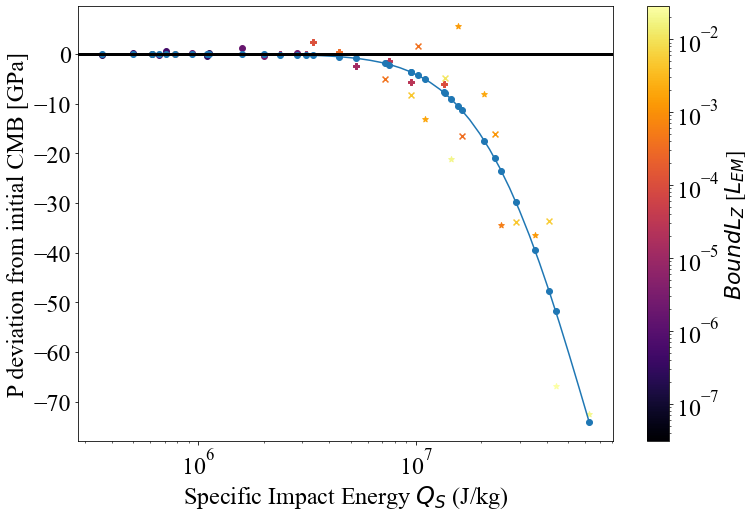

polynomial coefficients, n...0 :  [ 1.43003714 -9.30109791]
R^2 value:  [0.70245387]


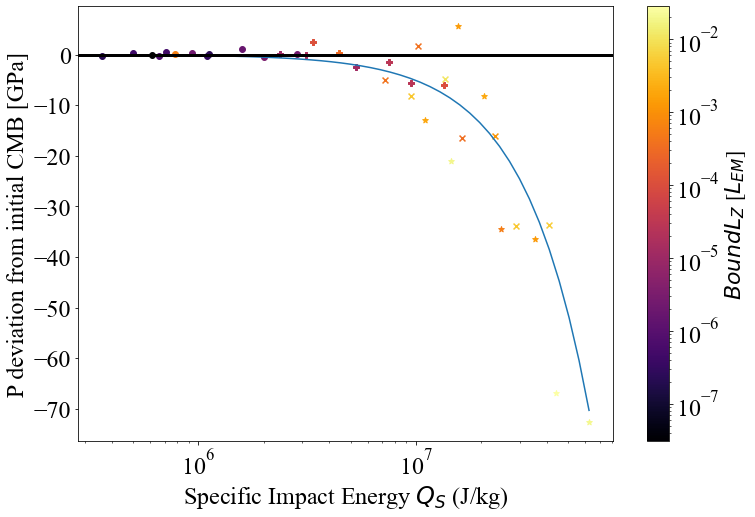

QS:  526290.9041403177  fit:  0.18979678754548618
QS:  696019.72072557  fit:  0.11578449665485821
QS:  1184154.534315715  fit:  -0.15008400393322385
QS:  2507936.5654061325  fit:  -1.1536575596577725
QS:  3316746.10774961  fit:  -1.9164880846722467
QS:  5642857.272163798  fit:  -4.566994134766194
QS:  7684344.543074639  fit:  -7.325987037476084
QS:  10162545.658216208  fit:  -11.098688191715919
QS:  17289775.221917942  fit:  -23.89804737925536
QS:  11758628.962439474  fit:  -13.73568356346759
QS:  15550786.802826205  fit:  -20.548236016291405
QS:  26456915.165488817  fit:  -43.45210842949279
QS:  356325.2106205672  fit:  0.25189018102960586
QS:  471240.0910457001  fit:  0.21133455515177835
QS:  1697053.7534062301  fit:  -0.4966588819082318
QS:  2244353.588879739  fit:  -0.9271080303394602
QS:  5205203.548112992  fit:  -4.0238539129677
QS:  6883881.69237943  fit:  -6.20264024192289
QS:  7967697.378248494  fit:  -7.73550603313524
QS:  10537279.78273363  fit:  -11.704233908875695
QS:  181

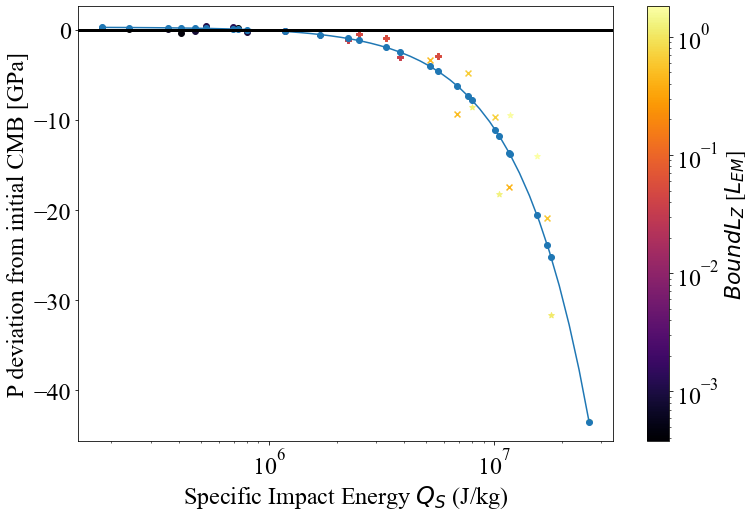

polynomial coefficients, n...0 :  [ 1.52440349 -9.70195465]
R^2 value:  [0.91998704]


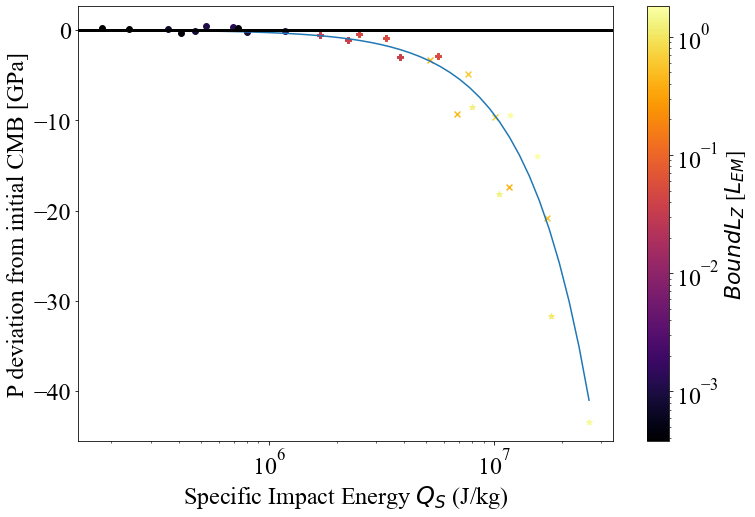

QS:  513337.48612449504  fit:  -0.4771181831340128
QS:  678888.8253996443  fit:  -0.8029318185269734
QS:  2450498.091012985  fit:  -3.8672953195816246
QS:  3240783.725364672  fit:  -5.09146686055115
QS:  7526928.5779540995  fit:  -11.235330999045367
QS:  9954363.044344295  fit:  -14.569062038635394
QS:  11530949.004293071  fit:  -16.715857683145146
QS:  15249680.058177585  fit:  -21.764983970947412
QS:  14926054.263193991  fit:  -21.32541862273991
QS:  19739706.763074048  fit:  -27.886124668480225
QS:  345309.2742521141  fit:  -0.14628403522980093
QS:  456671.51519842085  fit:  -0.3646639008865282
QS:  1649651.83545332  fit:  -2.5579484597513664
QS:  2181664.5523870154  fit:  -3.4372361036640307
QS:  5083001.644576405  fit:  -7.799916522763952
QS:  6722269.674952295  fit:  -10.11652339512241
QS:  7797650.011346687  fit:  -11.609807177472085
QS:  10312392.140005989  fit:  -15.057400789548204
QS:  10095239.950628608  fit:  -14.761284098024039
QS:  13350954.834706333  fit:  -19.1872695049

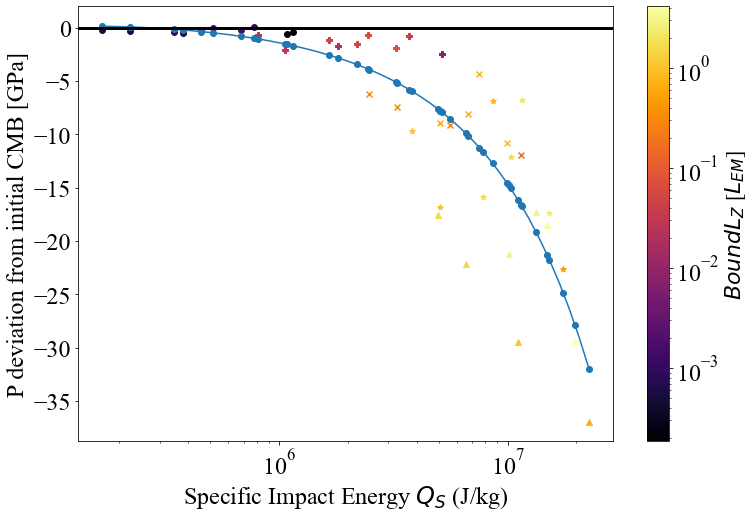

polynomial coefficients, n...0 :  [ 1.14517942 -6.98923692]
R^2 value:  [0.84491777]


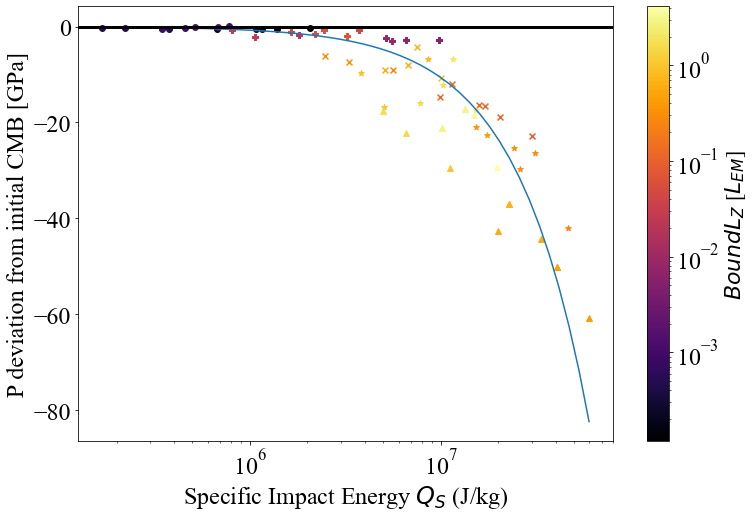

QS:  609354.6812995713  fit:  0.07483798844341116
QS:  805871.5660186828  fit:  -0.3323419998421251
QS:  2915178.60373721  fit:  -5.010468287273262
QS:  3855323.70344246  fit:  -6.893080071360412
QS:  8982135.42085189  fit:  -15.91200666630143
QS:  11878874.094076624  fit:  -20.509250598293875
QS:  13779890.666004939  fit:  -23.41630354346099
QS:  18223905.40579153  fit:  -29.980435212097134
QS:  17854257.22379348  fit:  -29.44430933932464
QS:  412965.8868344146  fit:  0.3634128821838605
QS:  1979505.5025586789  fit:  -3.010532855380223
QS:  6129932.269723082  fit:  -11.090432602752962
QS:  8106835.426708774  fit:  -14.470435092407765
QS:  9426180.901023185  fit:  -16.63280124263566
QS:  12466124.241603155  fit:  -21.4151578890515
QS:  12223520.513955751  fit:  -21.041822787775423
QS:  197234.85804168825  fit:  0.06670601699972423
QS:  260843.09976013273  fit:  0.3096278003153081
QS:  950762.5460939616  fit:  -0.6582985397930141
QS:  2964467.2625116324  fit:  -5.112029041956827
QS:  45

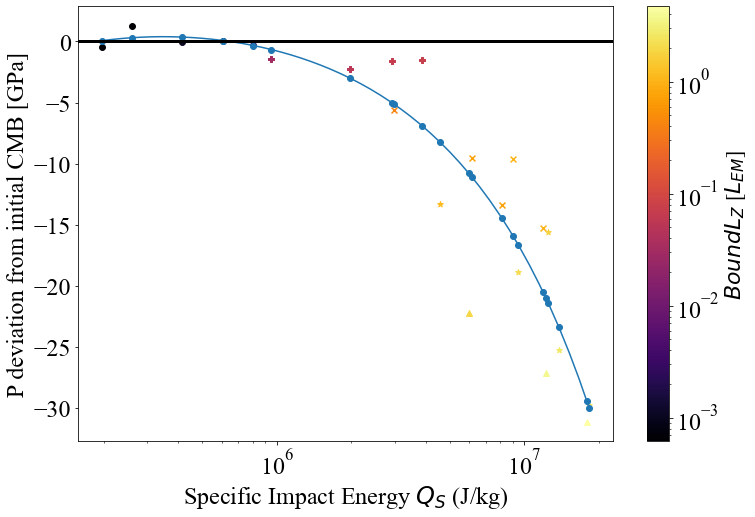

polynomial coefficients, n...0 :  [ 1.30410861 -7.93054062]
R^2 value:  [0.81435592]


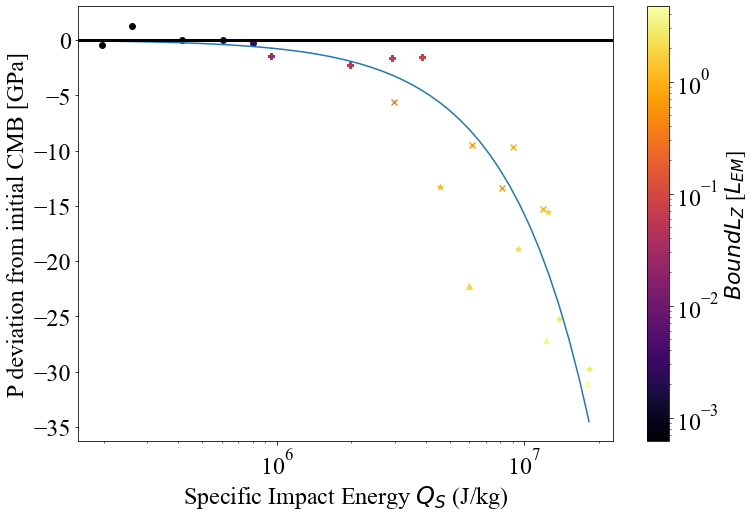

QS:  1055871.9867943623  fit:  -0.6729848917032026
QS:  1164098.8654407843  fit:  -0.7379065292733922
QS:  5058915.891190644  fit:  -3.3519438879355814
QS:  5577454.7700376855  fit:  -3.7389570508327843
QS:  15620841.038259083  fit:  -13.076230183170722
QS:  17221977.24468064  fit:  -14.88596477352789
QS:  23988147.17693971  fit:  -23.5014949050677
QS:  26446932.262576025  fit:  -27.020097470188198
QS:  31101239.725074988  fit:  -34.248340341345546
QS:  720504.4050062256  fit:  -0.47771814686306247
QS:  3461123.286474543  fit:  -2.2177845365083533
QS:  10752518.051683055  fit:  -8.114279345054358
QS:  16559800.631966656  fit:  -14.126875526287433
QS:  21496531.026762966  fit:  -20.14686991489676
QS:  342415.9092641906  fit:  -0.2922083031282352
QS:  1656159.5626625426  fit:  -1.0397884820647711
QS:  5190571.802488635  fit:  -3.4493212988994024
QS:  8035975.765996676  fit:  -5.701339965725558
QS:  10456206.680410322  fit:  -7.8386479627593
Quad-log fit: 0.34202407838787874 -3.6736697870

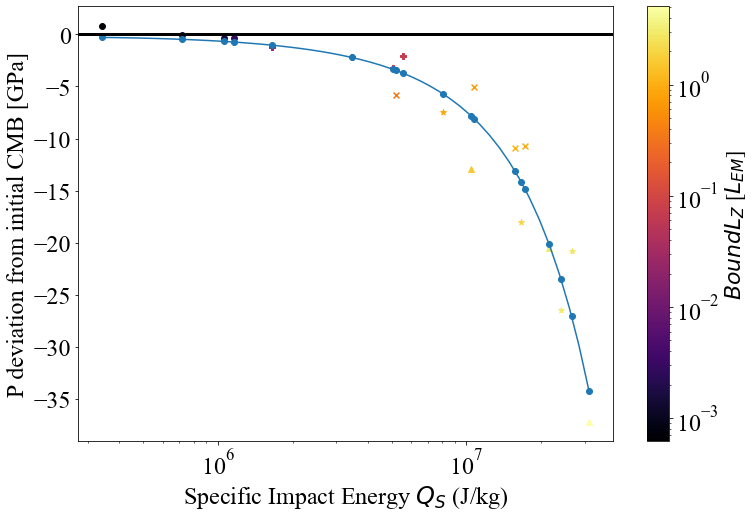

polynomial coefficients, n...0 :  [ 1.37611892 -8.76146012]
R^2 value:  [0.94516406]


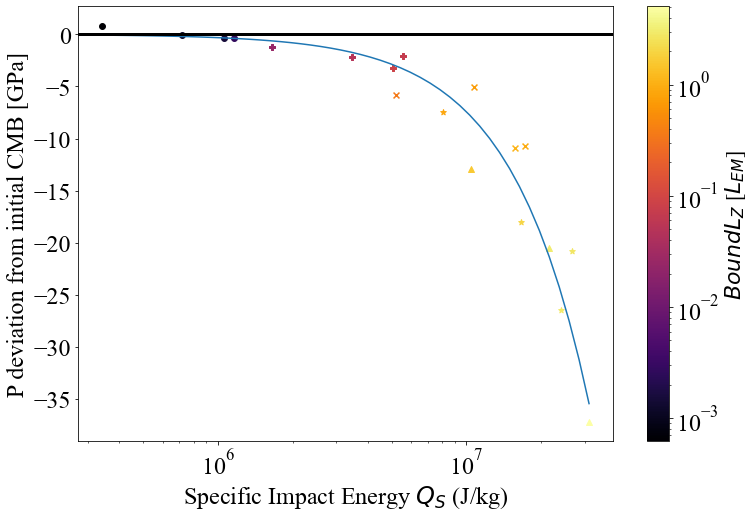

QS:  3724891.9726759647  fit:  0.503918333713666
QS:  3913464.6287926855  fit:  0.4899652018970509
QS:  4106693.39987525  fit:  0.47462290633141946
QS:  17858840.09238856  fit:  -2.5013124025517306
QS:  18762943.872065727  fit:  -2.7688817020211394
QS:  19689371.20185839  fit:  -3.046582814589787
QS:  55196973.32750255  fit:  -13.155621205223277
QS:  57991320.10220736  fit:  -13.803691492939345
QS:  84800706.1300271  fit:  -18.8531764979532
QS:  89093741.87785971  fit:  -19.487242203591812
QS:  93492778.50835486  fit:  -20.093886104437562
QS:  2669188.141545154  fit:  0.5635219972723189
QS:  2800980.2984447656  fit:  0.557772646198774
QS:  12216194.902592445  fit:  -0.9553140280105697
QS:  12834639.769536184  fit:  -1.110570212968756
QS:  38006843.1892856  fit:  -8.622926870638823
QS:  39930939.62574317  fit:  -9.175358478055745
QS:  58574650.48336335  fit:  -13.935863050346835
QS:  61539992.164083615  fit:  -14.591324217123148
QS:  1199137.6239334024  fit:  0.5985577488962401
QS:  580

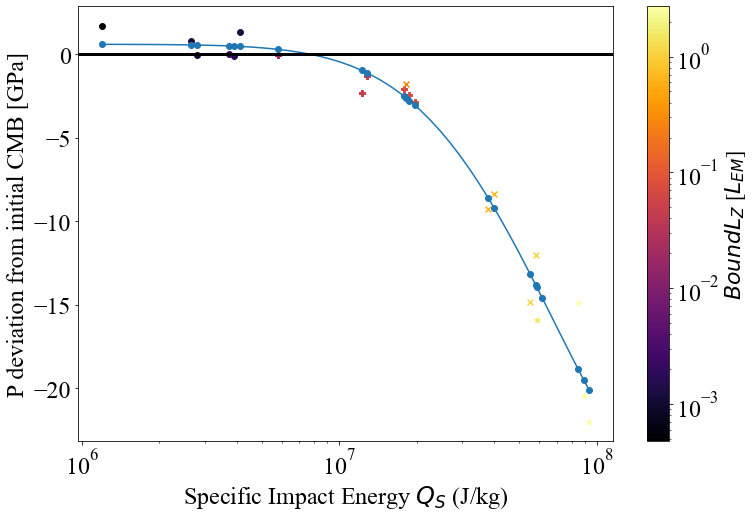

polynomial coefficients, n...0 :  [  1.87087475 -13.37656273]
R^2 value:  [0.93595377]


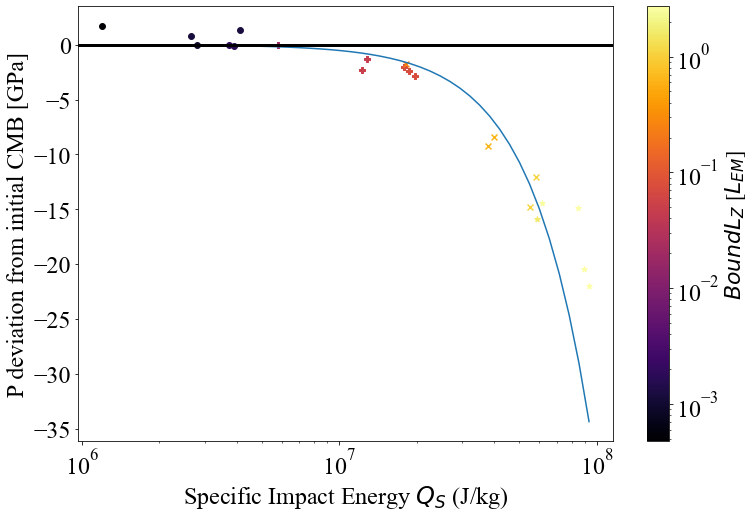

QS:  9002517934.096441  fit:  0.3705393915762498
QS:  9458270404.510073  fit:  0.3460515100385899
QS:  43168755476.952  fit:  -2.267660374563796
QS:  45354173722.97269  fit:  -2.467194322910505
QS:  47593552913.339584  fit:  -2.673845023243941
QS:  133451354715.04648  fit:  -11.42569925174641
QS:  140207329547.4957  fit:  -12.14590110679668
QS:  147130118573.33878  fit:  -12.885623571325507
QS:  205045617491.77194  fit:  -19.105999210121453
QS:  215426051877.2929  fit:  -20.221687555638244
QS:  226062793284.6786  fit:  -21.363943376129985
QS:  6130267663.526495  fit:  0.510821223057304
QS:  6440612463.992525  fit:  0.4969642176432875
QS:  29483863208.97082  fit:  -1.0776596360314605
QS:  30976483783.924957  fit:  -1.201528359744895
QS:  91761695063.56743  fit:  -7.044563853095564
QS:  96407130876.1605  fit:  -7.525090624327488
QS:  141443299503.0562  fit:  -12.27784954068642
QS:  148603866540.3984  fit:  -13.043293031212604
QS:  13969074402.729391  fit:  0.07778193871946992
Quad-log fi

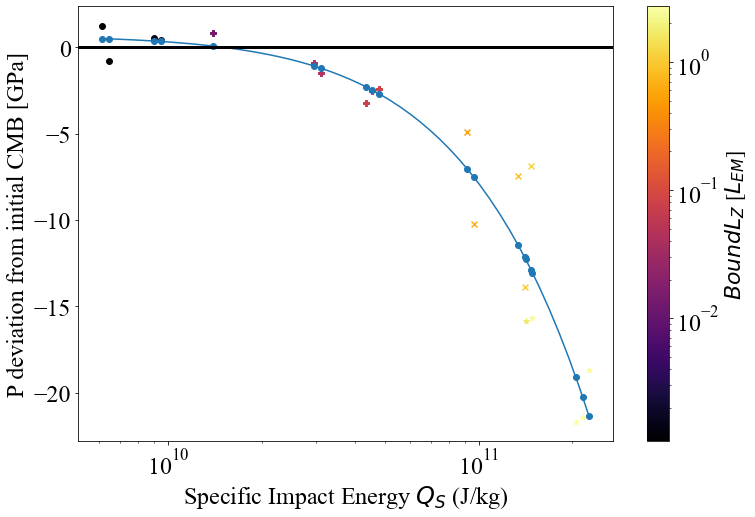

polynomial coefficients, n...0 :  [  1.10462251 -11.28274242]
R^2 value:  [0.87429527]


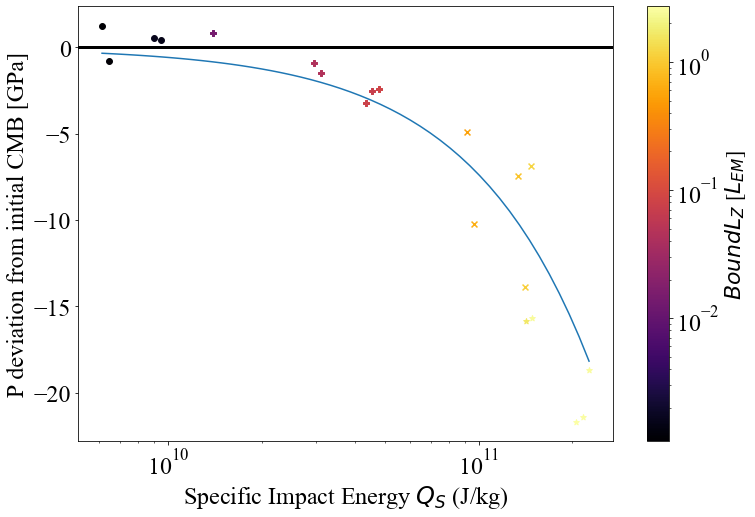

QS:  779275.7741661337  fit:  -0.053279443683811864
QS:  706814.88073648  fit:  -0.0529670612434256
QS:  934762.6797739944  fit:  -0.05432542635178
QS:  1590333.4816570801  fit:  -0.06819468019885805
QS:  2827259.52294592  fit:  -0.17130957324503698
QS:  498851.33761882654  fit:  -0.05249605854238162
QS:  659730.894000898  fit:  -0.052811706547202894
QS:  1122415.5096423596  fit:  -0.05648667038074644
QS:  1995405.3504753062  fit:  -0.08852255520513794
QS:  360307.48648476985  fit:  -0.052398227511887496
QS:  612999.5044164327  fit:  -0.05268920448939727
QS:  1089776.8967403248  fit:  -0.05602721214398371
QS:  3356034.3758801934  fit:  -0.2587869329672498
QS:  4438355.462101555  fit:  -0.535193505712246
QS:  7551077.345730434  fit:  -2.10635856652784
QS:  13424137.503520774  fit:  -7.74132568287728
QS:  2364360.517989502  fit:  -0.11769378068129227
QS:  3126866.7850411152  fit:  -0.21725522267617553
QS:  5319811.165476378  fit:  -0.8630755831771993
QS:  9457442.071958007  fit:  -3.6021

QS:  3724891.9726759647  fit:  0.503918333713666
QS:  3913464.6287926855  fit:  0.4899652018970509
QS:  4106693.39987525  fit:  0.47462290633141946
QS:  17858840.09238856  fit:  -2.5013124025517306
QS:  18762943.872065727  fit:  -2.7688817020211394
QS:  19689371.20185839  fit:  -3.046582814589787
QS:  55196973.32750255  fit:  -13.155621205223277
QS:  57991320.10220736  fit:  -13.803691492939345
QS:  84800706.1300271  fit:  -18.8531764979532
QS:  89093741.87785971  fit:  -19.487242203591812
QS:  93492778.50835486  fit:  -20.093886104437562
QS:  2669188.141545154  fit:  0.5635219972723189
QS:  2800980.2984447656  fit:  0.557772646198774
QS:  12216194.902592445  fit:  -0.9553140280105697
QS:  12834639.769536184  fit:  -1.110570212968756
QS:  38006843.1892856  fit:  -8.622926870638823
QS:  39930939.62574317  fit:  -9.175358478055745
QS:  58574650.48336335  fit:  -13.935863050346835
QS:  61539992.164083615  fit:  -14.591324217123148
QS:  1199137.6239334024  fit:  0.5985577488962401
QS:  580

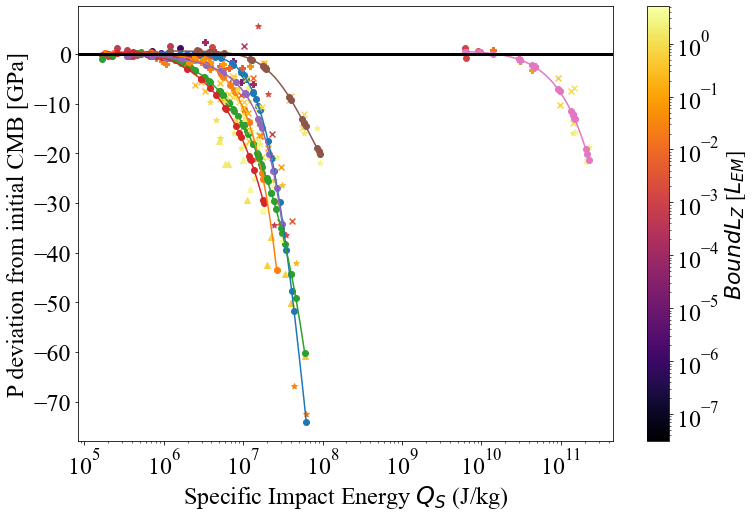

In [44]:
dP_CMB_QS([theta010list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([theta010list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
dP_CMB_QS([accretion20list+partialaccretion20list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([accretion20list+partialaccretion20list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
dP_CMB_QS([accretion30list+partialaccretion30list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([theta30list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
dP_CMB_QS([accretion45list+partialaccretion45list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([accretion45list+partialaccretion45list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
dP_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
dP_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([accretion75list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
dP_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([accretion897list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
dP_CMB_QS([theta010list,accretion20list+partialaccretion20list,theta30list,accretion45list+partialaccretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)

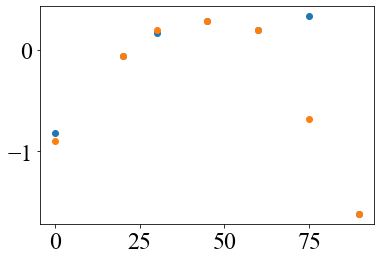

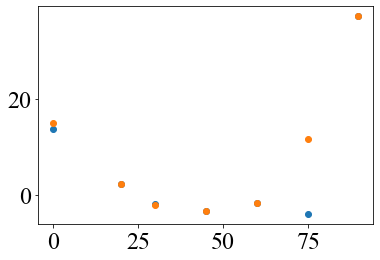

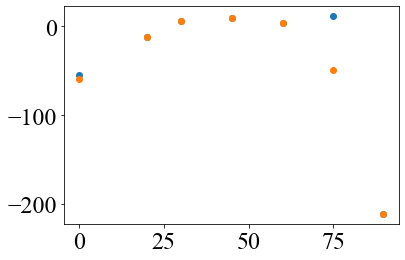

[1.00000000e-05 3.21822475e-01 9.03054531e+00 5.34473745e+00
 8.25545338e-01 1.20773049e+00 4.08188000e-01]


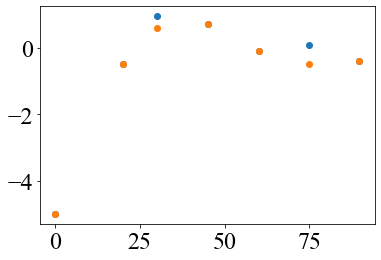

In [45]:
fitlist=np.array([[1.36671218,-8.83811186],[ 1.50512106,-9.61624966],[1.0887764,-6.6676996],[1.32417694,-8.1277394],[ 1.35478696,-8.63028641]])
fitlist2=np.array([[0.44413886,-4.51360613,10.40408025],[0.1514094,-0.50785127,-2.97164983],[0.09228413,-0.10571331,-2.83767036],[0.25609353,-1.92019732,2.06362077],[-0.38352698,6.46949829,-25.58774656]])
fitlist3=np.array([[1.43003714,-9.30109791],[ 1.52440349,-9.70195465],[ 1.14517942,-6.98923692],[ 1.37818282,-8.46448189],[1.37611892,-8.76146012],[1.81771051,-13.0179629],[1.13497239,-11.71211422]])
fitlist4=np.array([[ 1.52440349,-9.70195465],[ 1.14517942,-6.98923692],[ 1.37818282,-8.46448189],[1.37611892,-8.76146012],[1.81771051,-13.0179629]])

quadfitlist = np.array([[-0.8243729722818424,13.749432717148489,-55.216984779001265,-0.014542573483870044],
                        [-0.05574219064469961,2.208640599576798,-11.681431406599119,0.3218224746099478],
                        [0.16667384862777843,-1.853734919141187,6.113885021403047,9.030545305562516],
                        [0.28972065488797355,-3.221551253286434,9.662126456411363,5.344737446300689],
                        [0.1980044168351539,-1.712169111685492,3.1994330955580605,0.8255453384555637],
                        [0.33188162699868123,-3.8943392607812712,11.265295810629063,1.2077304944432108],
                        [-1.6179662585325425,37.06139962704084,-211.04866275307145,0.40818800033252306]])
quadfitlistnew = np.array([[-0.895910936177469,14.842784895449245,-59.39361182452958,-0.054265621001744306],
                           [-0.05590702971280816,2.2107956415165186,-11.688325966031096,0.32474357800215736],
                           [0.19586893180122242,-2.0105537754140017,5.747019666047481,4.020463520291142],
                           [0.28972065488797355,-3.221551253286434,9.662126456411363,5.344737446300689],
                           [0.1980044168351539,-1.712169111685492,3.1994330955580605,0.8255453384555637],
                           [-0.678135085536728,11.674572659451842,-48.649493157309145,0.3338000348249578],
                           [-1.6179662585325425,37.06139962704084,-211.04866275307145,0.40818800033252306]])

thetalist = np.array([0,20,30,45,60,75,89.7])
thetalist2 = np.array([20,30,45,60,75])

ws = np.array([0.8957504125992902,0.93795206734534,0.8775840962164625,0.8974882931934074,0.9026756746423119,0.7458251714682104,0.7235806967280269])
wsnew = np.array([0.8957504125992902,0.93795206734534,0.7452679281911481,0.8567270946330554,0.9291428745198197])
ws2 = np.array([0.73250503,0.92489988,0.8209984,0.80059433,0.92944441,0.68038725,0.76706994])
ws2new = np.array([0.73117467,0.91998704,0.84333656,0.81243921,0.94516406])

plt.scatter(thetalist,quadfitlist[:,0])
plt.scatter(thetalist,quadfitlistnew[:,0])
plt.show()
plt.scatter(thetalist,quadfitlist[:,1])
plt.scatter(thetalist,quadfitlistnew[:,1])
plt.show()
plt.scatter(thetalist,quadfitlist[:,2])
plt.scatter(thetalist,quadfitlistnew[:,2])
plt.show()
quadfitlist[0,3]=(1.e-5)
quadfitlistnew[0,3]=(1.e-5)
plt.scatter(thetalist,np.log10(quadfitlist[:,3]))
plt.scatter(thetalist,np.log10(quadfitlistnew[:,3]))
#plt.scatter(thetalist,quadfitlist[:,3])
print(quadfitlist[:,3])

QS:  706814.88073648  fit:  -0.06317104730460364
QS:  934762.6797739944  fit:  -0.06451048108282581
QS:  1590333.4816570801  fit:  -0.07823203933370329
QS:  3356034.3758801934  fit:  -0.26758728471637855
QS:  4438355.462101555  fit:  -0.54275084566112
QS:  7551077.345730434  fit:  -2.1096845914562854
QS:  10230638.360774785  fit:  -4.309703429206126
QS:  13530019.23212465  fit:  -7.864800627458359
QS:  23018936.311743274  fit:  -21.022028513892923
QS:  15616508.095735958  fit:  -10.472889349364014
QS:  20652831.956610803  fit:  -17.50278952864983
QS:  35137143.215405904  fit:  -39.38149647108214
QS:  498851.33761882654  fit:  -0.06270771410583745
QS:  659730.894000898  fit:  -0.06301809665907697
QS:  1122415.5096423596  fit:  -0.0666450589940404
QS:  2364360.517989502  fit:  -0.12733662984511385
QS:  3126866.7850411152  fit:  -0.22627997516654624
QS:  5319811.165476378  fit:  -0.8694717899887975
QS:  7197135.747148993  fit:  -1.8746638736038683
QS:  9518212.025604542  fit:  -3.65670631

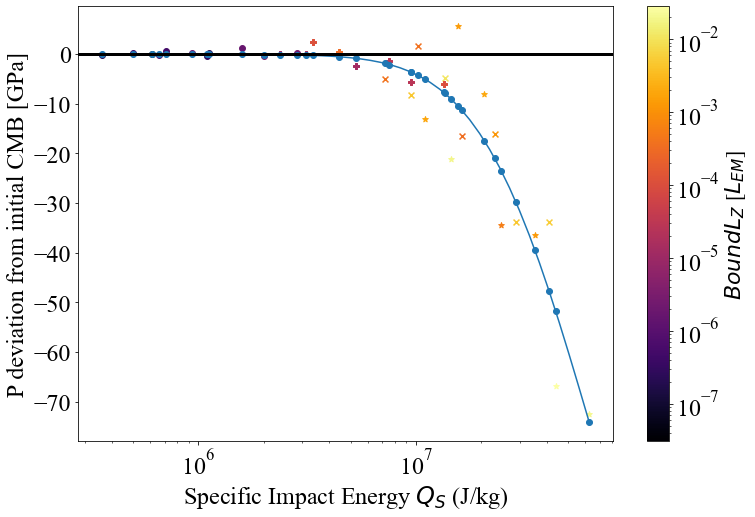

polynomial coefficients, n...0 :  [ 1.43003714 -9.30109791]
R^2 value:  [0.70245387]


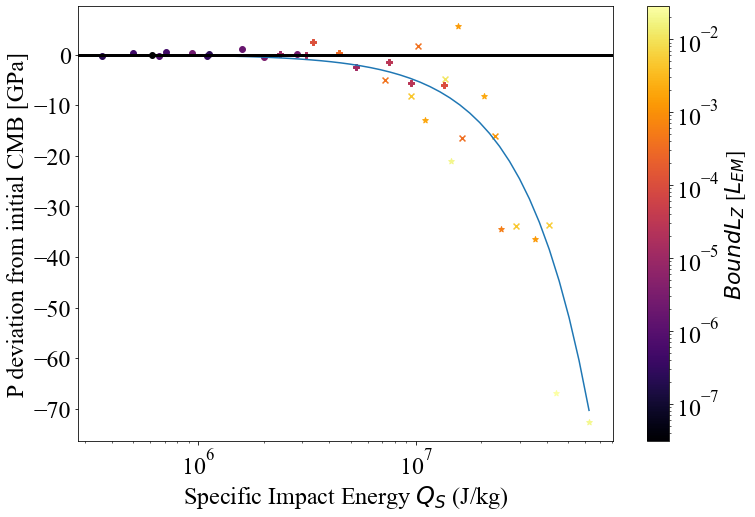

QS:  526290.9041403177  fit:  0.18979678754548618
QS:  696019.72072557  fit:  0.11578449665485821
QS:  1184154.534315715  fit:  -0.15008400393322385
QS:  2507936.5654061325  fit:  -1.1536575596577725
QS:  3316746.10774961  fit:  -1.9164880846722467
QS:  5642857.272163798  fit:  -4.566994134766194
QS:  7684344.543074639  fit:  -7.325987037476084
QS:  10162545.658216208  fit:  -11.098688191715919
QS:  17289775.221917942  fit:  -23.89804737925536
QS:  11758628.962439474  fit:  -13.73568356346759
QS:  15550786.802826205  fit:  -20.548236016291405
QS:  26456915.165488817  fit:  -43.45210842949279
QS:  356325.2106205672  fit:  0.25189018102960586
QS:  471240.0910457001  fit:  0.21133455515177835
QS:  1697053.7534062301  fit:  -0.4966588819082318
QS:  2244353.588879739  fit:  -0.9271080303394602
QS:  5205203.548112992  fit:  -4.0238539129677
QS:  6883881.69237943  fit:  -6.20264024192289
QS:  7967697.378248494  fit:  -7.73550603313524
QS:  10537279.78273363  fit:  -11.704233908875695
QS:  181

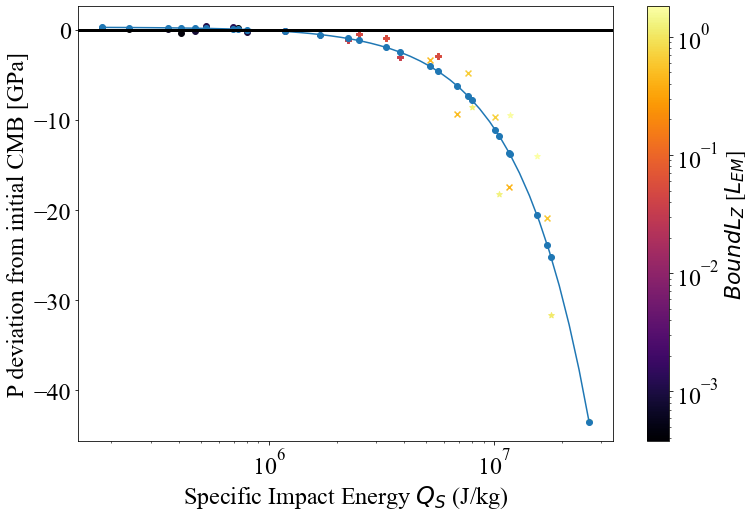

polynomial coefficients, n...0 :  [ 1.52440349 -9.70195465]
R^2 value:  [0.91998704]


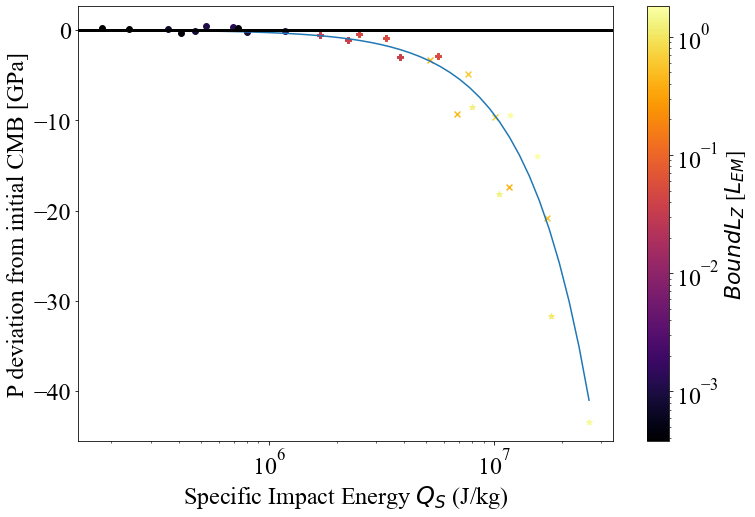

QS:  513337.48612449504  fit:  -0.4771181831340128
QS:  678888.8253996443  fit:  -0.8029318185269734
QS:  2450498.091012985  fit:  -3.8672953195816246
QS:  3240783.725364672  fit:  -5.09146686055115
QS:  7526928.5779540995  fit:  -11.235330999045367
QS:  9954363.044344295  fit:  -14.569062038635394
QS:  11530949.004293071  fit:  -16.715857683145146
QS:  15249680.058177585  fit:  -21.764983970947412
QS:  14926054.263193991  fit:  -21.32541862273991
QS:  19739706.763074048  fit:  -27.886124668480225
QS:  345309.2742521141  fit:  -0.14628403522980093
QS:  456671.51519842085  fit:  -0.3646639008865282
QS:  1649651.83545332  fit:  -2.5579484597513664
QS:  2181664.5523870154  fit:  -3.4372361036640307
QS:  5083001.644576405  fit:  -7.799916522763952
QS:  6722269.674952295  fit:  -10.11652339512241
QS:  7797650.011346687  fit:  -11.609807177472085
QS:  10312392.140005989  fit:  -15.057400789548204
QS:  10095239.950628608  fit:  -14.761284098024039
QS:  13350954.834706333  fit:  -19.1872695049

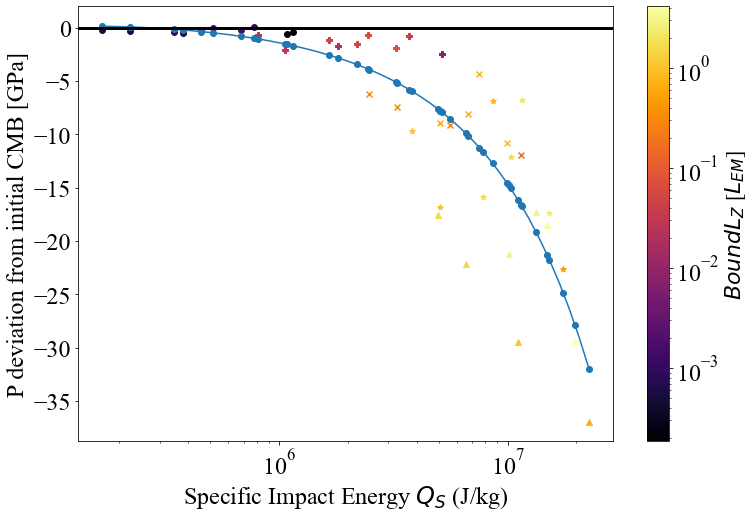

polynomial coefficients, n...0 :  [ 1.18416919 -7.18642679]
R^2 value:  [0.81256147]


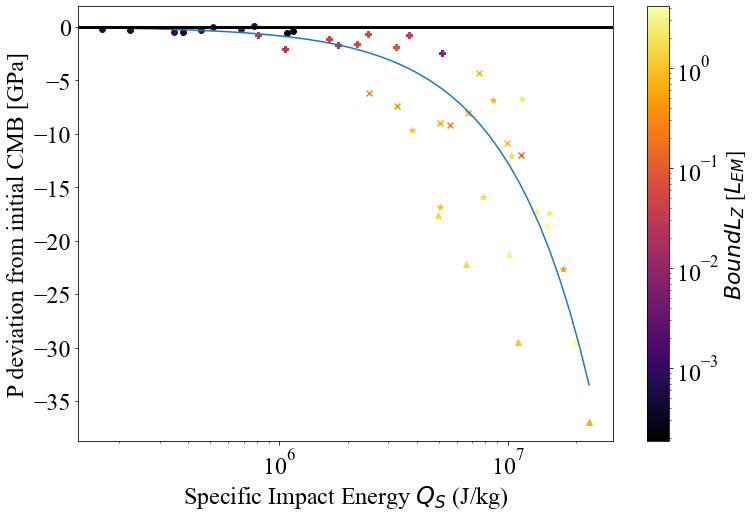

QS:  609354.6812995713  fit:  0.07483798844341116
QS:  805871.5660186828  fit:  -0.3323419998421251
QS:  2915178.60373721  fit:  -5.010468287273262
QS:  3855323.70344246  fit:  -6.893080071360412
QS:  8982135.42085189  fit:  -15.91200666630143
QS:  11878874.094076624  fit:  -20.509250598293875
QS:  13779890.666004939  fit:  -23.41630354346099
QS:  18223905.40579153  fit:  -29.980435212097134
QS:  17854257.22379348  fit:  -29.44430933932464
QS:  412965.8868344146  fit:  0.3634128821838605
QS:  1979505.5025586789  fit:  -3.010532855380223
QS:  6129932.269723082  fit:  -11.090432602752962
QS:  8106835.426708774  fit:  -14.470435092407765
QS:  9426180.901023185  fit:  -16.63280124263566
QS:  12466124.241603155  fit:  -21.4151578890515
QS:  12223520.513955751  fit:  -21.041822787775423
QS:  197234.85804168825  fit:  0.06670601699972423
QS:  260843.09976013273  fit:  0.3096278003153081
QS:  950762.5460939616  fit:  -0.6582985397930141
QS:  2964467.2625116324  fit:  -5.112029041956827
QS:  45

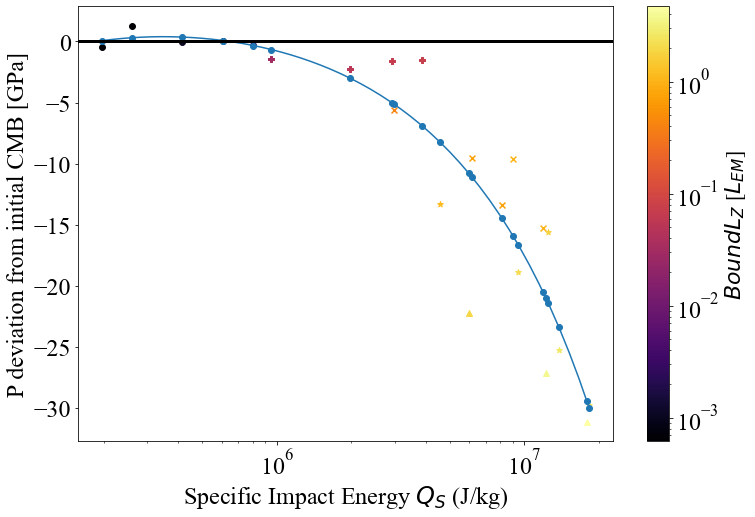

polynomial coefficients, n...0 :  [ 1.30410861 -7.93054062]
R^2 value:  [0.81435592]


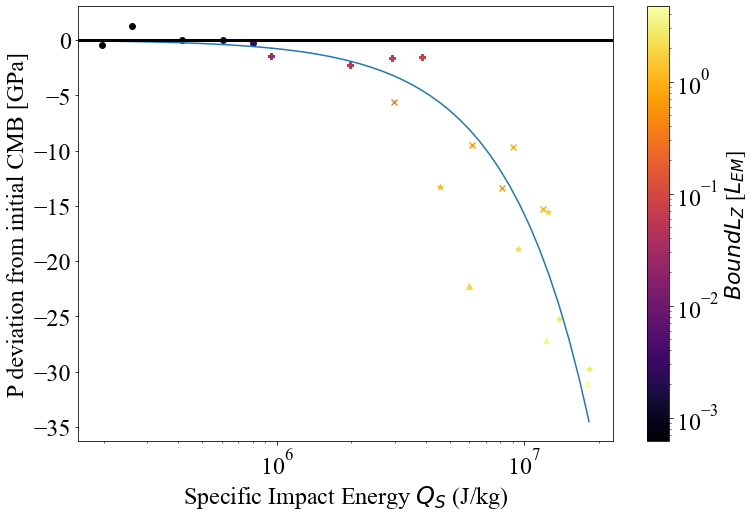

QS:  1055871.9867943623  fit:  -0.6729848917032026
QS:  1164098.8654407843  fit:  -0.7379065292733922
QS:  5058915.891190644  fit:  -3.3519438879355814
QS:  5577454.7700376855  fit:  -3.7389570508327843
QS:  15620841.038259083  fit:  -13.076230183170722
QS:  17221977.24468064  fit:  -14.88596477352789
QS:  23988147.17693971  fit:  -23.5014949050677
QS:  26446932.262576025  fit:  -27.020097470188198
QS:  31101239.725074988  fit:  -34.248340341345546
QS:  720504.4050062256  fit:  -0.47771814686306247
QS:  3461123.286474543  fit:  -2.2177845365083533
QS:  10752518.051683055  fit:  -8.114279345054358
QS:  16559800.631966656  fit:  -14.126875526287433
QS:  21496531.026762966  fit:  -20.14686991489676
QS:  342415.9092641906  fit:  -0.2922083031282352
QS:  1656159.5626625426  fit:  -1.0397884820647711
QS:  5190571.802488635  fit:  -3.4493212988994024
QS:  8035975.765996676  fit:  -5.701339965725558
QS:  10456206.680410322  fit:  -7.8386479627593
Quad-log fit: 0.34202407838787874 -3.6736697870

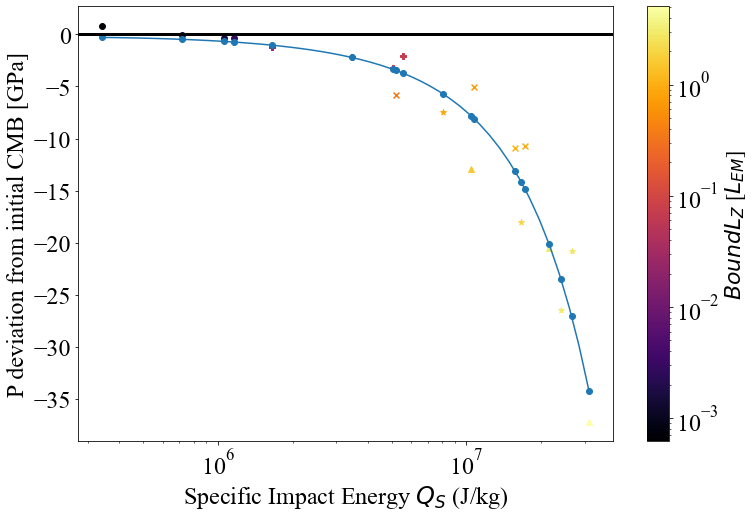

polynomial coefficients, n...0 :  [ 1.37611892 -8.76146012]
R^2 value:  [0.94516406]


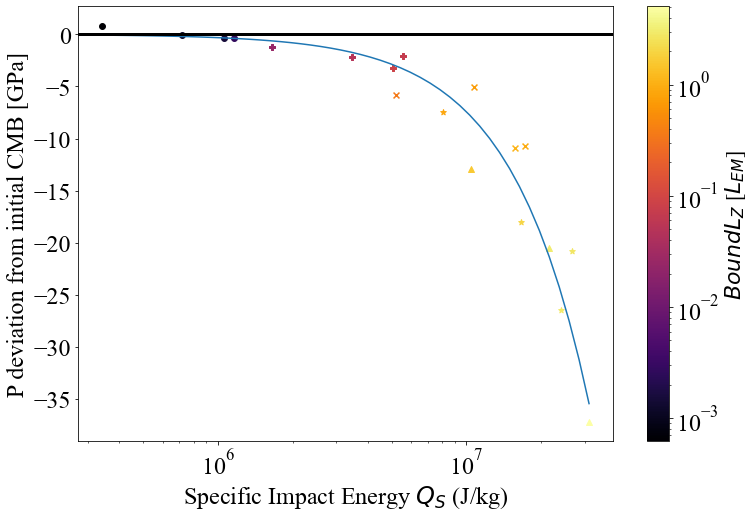

In [46]:
dP_CMB_QS([accretion010list+partialaccretion010list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([accretion010list+partialaccretion010list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
dP_CMB_QS([accretion20list+partialaccretion20list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([accretion20list+partialaccretion20list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
dP_CMB_QS([accretion30list+partialaccretion30list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([accretion30list+partialaccretion30list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
dP_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([accretion45list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
dP_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',quadlogfit=True)
dP_CMB_QS([accretion60list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)


polynomial coefficients, n...0 :  [ 0.35496081 -3.95678622 12.13410658]
R^2 value:  [0.92472086]
polynomial coefficients, n...0 :  [ 0.23659521 -2.34690458  6.72659862]
R^2 value:  [0.94771386]
polynomial coefficients, n...0 :  [ 0.1784787  -1.69914478  4.99751388]
R^2 value:  [0.93870235]
polynomial coefficients, n...0 :  [ 0.10303792 -0.85731569  2.66367579]
R^2 value:  [0.9373782]
polynomial coefficients, n...0 :  [ 0.02200906  0.11846304 -0.34826228]
R^2 value:  [0.94100389]
polynomial coefficients, n...0 :  [ 0.03601161 -0.09712309  0.19742898]
R^2 value:  [0.97971003]
polynomial coefficients, n...0 :  [ 0.04103056 -0.47143844  1.76099437]
R^2 value:  [0.96634811]


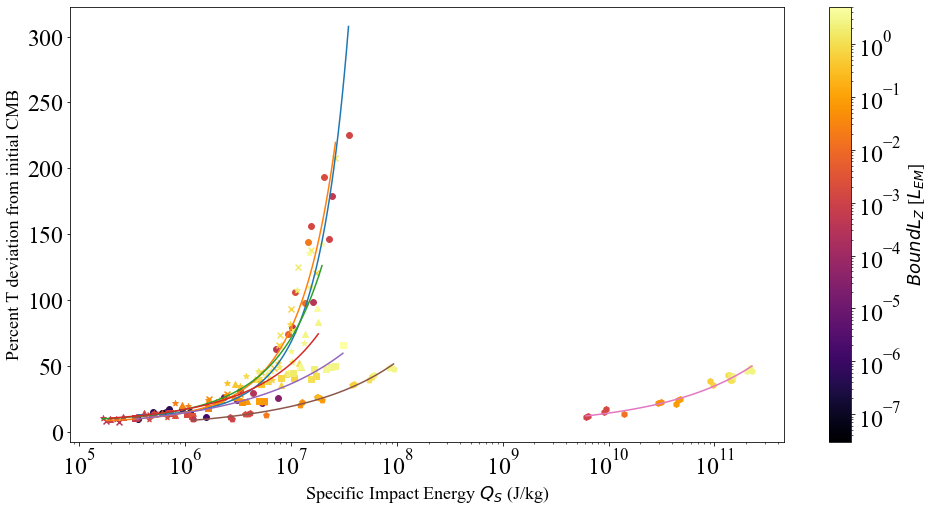

polynomial coefficients, n...0 :  [ 0.68814892 -2.93207366]
R^2 value:  [0.8704255]
polynomial coefficients, n...0 :  [ 0.64838451 -2.65372433]
R^2 value:  [0.91122448]
polynomial coefficients, n...0 :  [ 0.55089902 -2.02844044]
R^2 value:  [0.9102462]
polynomial coefficients, n...0 :  [ 0.44742136 -1.42524844]
R^2 value:  [0.92447371]
polynomial coefficients, n...0 :  [ 0.40850242 -1.29595134]
R^2 value:  [0.94025429]
polynomial coefficients, n...0 :  [ 0.41583845 -1.6174188 ]
R^2 value:  [0.97794029]
polynomial coefficients, n...0 :  [ 0.39712457 -2.82361772]
R^2 value:  [0.96464216]


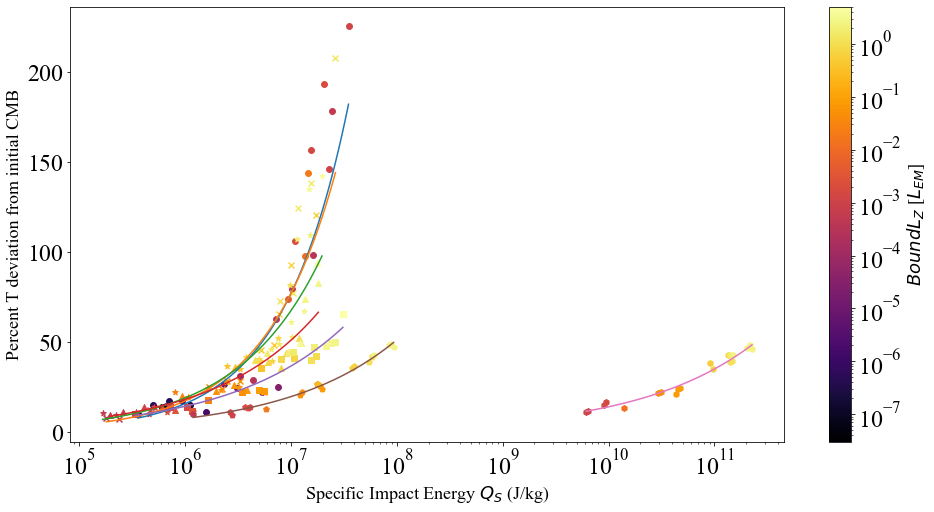

polynomial coefficients, n...0 :  [ 0.35496081 -3.95678622 12.13410658]
R^2 value:  [0.92472086]
polynomial coefficients, n...0 :  [ 0.23659521 -2.34690458  6.72659862]
R^2 value:  [0.94771386]
polynomial coefficients, n...0 :  [ 0.1784787  -1.69914478  4.99751388]
R^2 value:  [0.93870235]
polynomial coefficients, n...0 :  [ 0.10303792 -0.85731569  2.66367579]
R^2 value:  [0.9373782]
polynomial coefficients, n...0 :  [ 0.02200906  0.11846304 -0.34826228]
R^2 value:  [0.94100389]
polynomial coefficients, n...0 :  [ 0.03601161 -0.09712309  0.19742898]
R^2 value:  [0.97971003]
polynomial coefficients, n...0 :  [ 0.04103056 -0.47143844  1.76099437]
R^2 value:  [0.96634811]


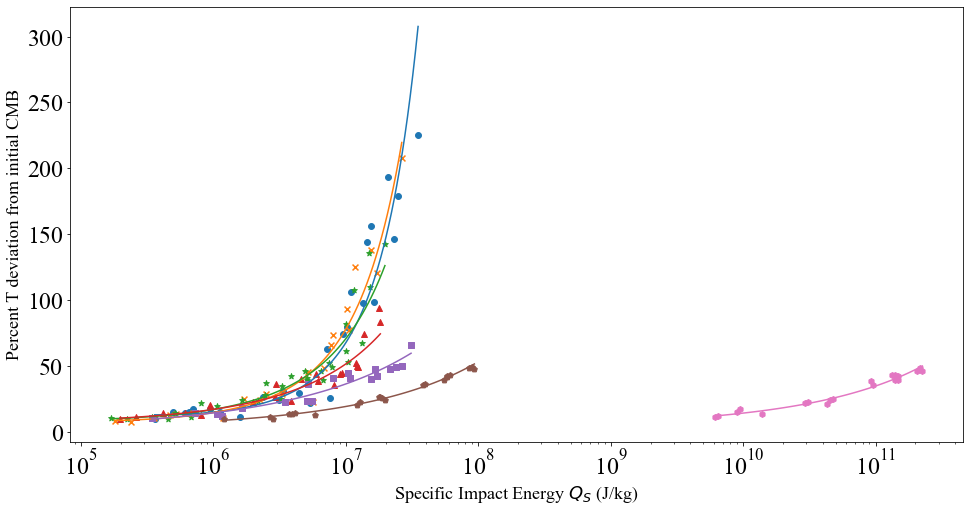

polynomial coefficients, n...0 :  [ 0.35496081 -3.95678622 12.13410658]
R^2 value:  [0.92472086]
polynomial coefficients, n...0 :  [ 0.23659521 -2.34690458  6.72659862]
R^2 value:  [0.94771386]
polynomial coefficients, n...0 :  [ 0.1784787  -1.69914478  4.99751388]
R^2 value:  [0.93870235]
polynomial coefficients, n...0 :  [ 0.10303792 -0.85731569  2.66367579]
R^2 value:  [0.9373782]
polynomial coefficients, n...0 :  [ 0.02200906  0.11846304 -0.34826228]
R^2 value:  [0.94100389]
polynomial coefficients, n...0 :  [ 0.03601161 -0.09712309  0.19742898]
R^2 value:  [0.97971003]
polynomial coefficients, n...0 :  [ 0.04103056 -0.47143844  1.76099437]
R^2 value:  [0.96634811]


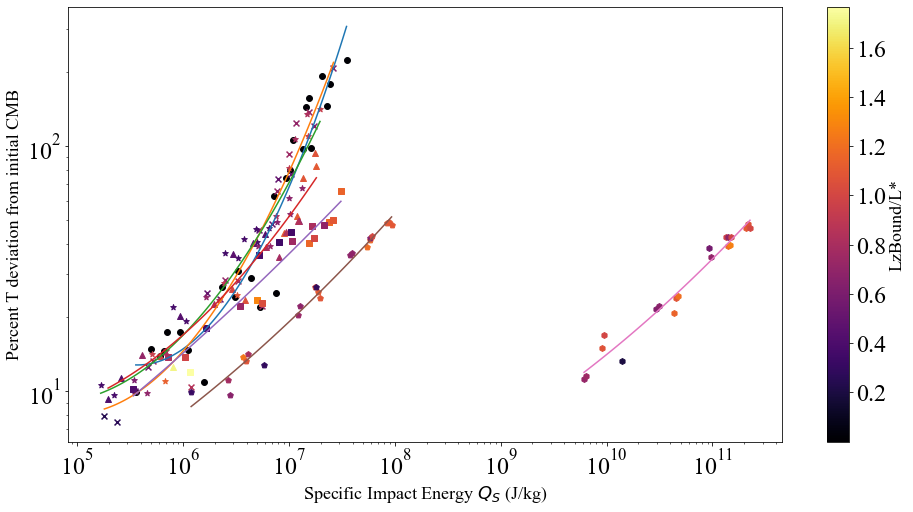

polynomial coefficients, n...0 :  [ 0.68814892 -2.93207366]
R^2 value:  [0.8704255]
polynomial coefficients, n...0 :  [ 0.64838451 -2.65372433]
R^2 value:  [0.91122448]
polynomial coefficients, n...0 :  [ 0.55089902 -2.02844044]
R^2 value:  [0.9102462]
polynomial coefficients, n...0 :  [ 0.44742136 -1.42524844]
R^2 value:  [0.92447371]
polynomial coefficients, n...0 :  [ 0.40850242 -1.29595134]
R^2 value:  [0.94025429]
polynomial coefficients, n...0 :  [ 0.41583845 -1.6174188 ]
R^2 value:  [0.97794029]
polynomial coefficients, n...0 :  [ 0.39712457 -2.82361772]
R^2 value:  [0.96464216]


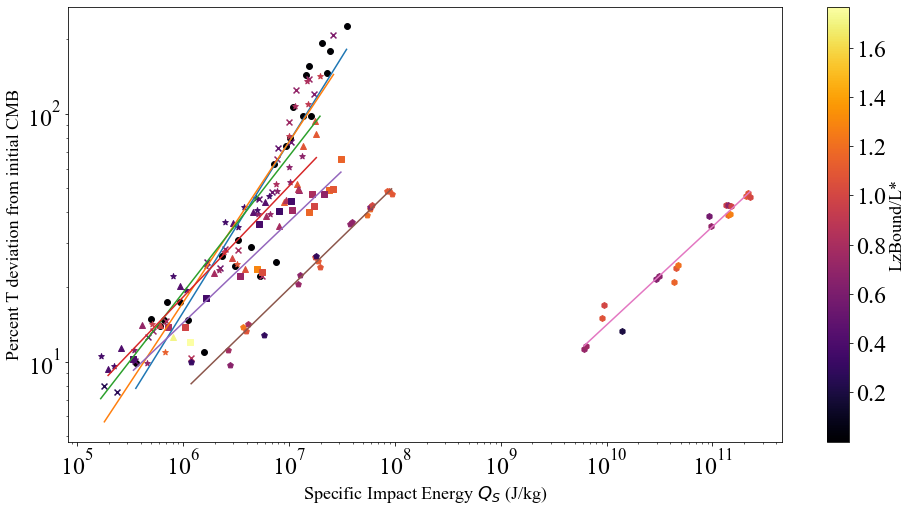

polynomial coefficients, n...0 :  [ 0.35496081 -3.95678622 12.13410658]
R^2 value:  [0.92472086]
polynomial coefficients, n...0 :  [ 0.23659521 -2.34690458  6.72659862]
R^2 value:  [0.94771386]
polynomial coefficients, n...0 :  [ 0.1784787  -1.69914478  4.99751388]
R^2 value:  [0.93870235]
polynomial coefficients, n...0 :  [ 0.10303792 -0.85731569  2.66367579]
R^2 value:  [0.9373782]
polynomial coefficients, n...0 :  [ 0.02200906  0.11846304 -0.34826228]
R^2 value:  [0.94100389]
polynomial coefficients, n...0 :  [ 0.03601161 -0.09712309  0.19742898]
R^2 value:  [0.97971003]
polynomial coefficients, n...0 :  [ 0.04103056 -0.47143844  1.76099437]
R^2 value:  [0.96634811]


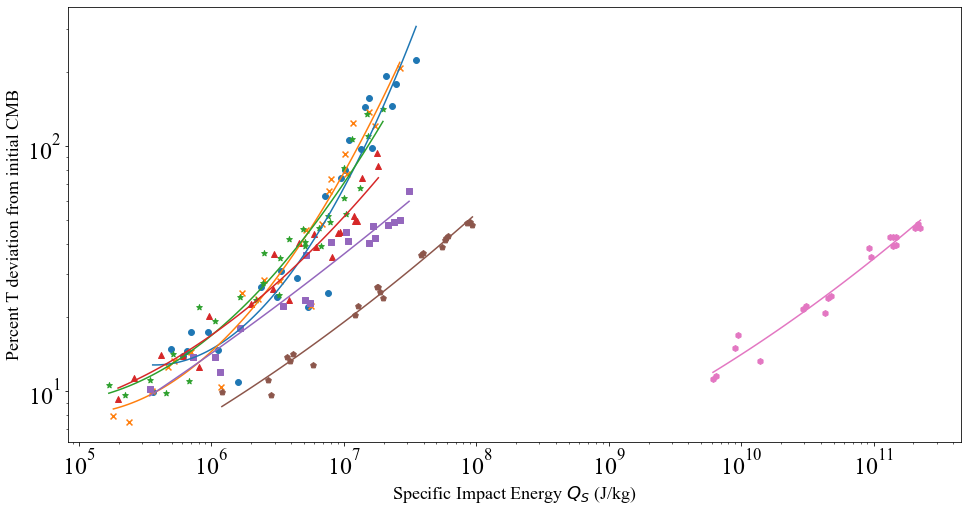

polynomial coefficients, n...0 :  [0.01622213 0.3876529  2.96225347]
R^2 value:  [0.807595]
polynomial coefficients, n...0 :  [0.0594227  0.49195076 1.96890104]
R^2 value:  [0.93566627]
polynomial coefficients, n...0 :  [0.04275249 0.35736004 1.73613068]
R^2 value:  [0.90283306]
polynomial coefficients, n...0 :  [0.02876559 0.2772789  1.65141309]
R^2 value:  [0.93759058]
polynomial coefficients, n...0 :  [0.01554553 0.22593351 1.61051961]
R^2 value:  [0.98293154]
polynomial coefficients, n...0 :  [0.01120331 0.20997586 1.58598449]
R^2 value:  [0.95863862]
polynomial coefficients, n...0 :  [0.0187211  0.21713683 1.58461359]
R^2 value:  [0.94877022]


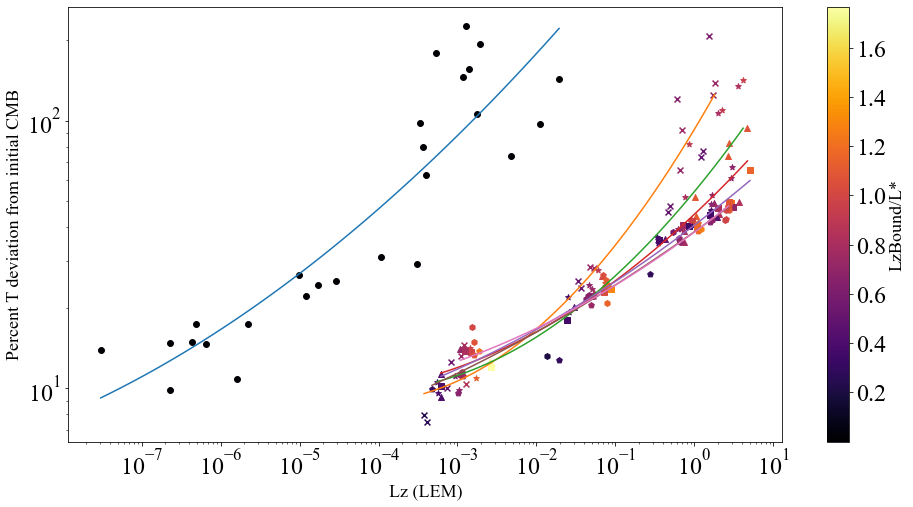

polynomial coefficients, n...0 :  [0.24055326 2.67297741]
R^2 value:  [0.80022648]
polynomial coefficients, n...0 :  [0.30673602 1.9357526 ]
R^2 value:  [0.91079523]
polynomial coefficients, n...0 :  [0.24544344 1.74294737]
R^2 value:  [0.87814771]
polynomial coefficients, n...0 :  [0.2032633  1.66081444]
R^2 value:  [0.92185799]
polynomial coefficients, n...0 :  [0.18809058 1.61524561]
R^2 value:  [0.97674709]
polynomial coefficients, n...0 :  [0.17983836 1.58501748]
R^2 value:  [0.95519112]
polynomial coefficients, n...0 :  [0.17110989 1.58533886]
R^2 value:  [0.93901696]


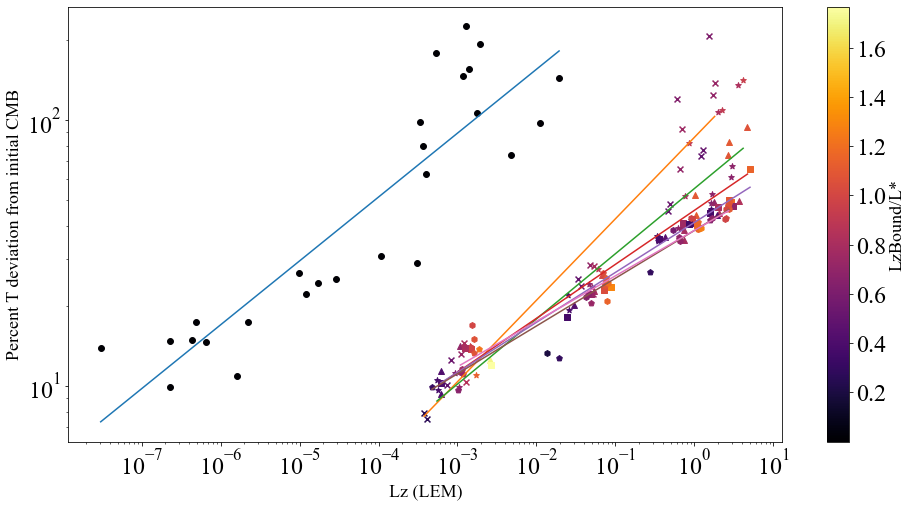

In [47]:
fitlist2d = dT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',legend=False,markers='theta',normalize=True,logfit=2)
fitlist1d = dT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',legend=False,markers='theta',normalize=True,logfit=1)
dT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=thetalabels,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=2)

dT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=2)
dT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=1)
dT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=thetalabels,loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=2)

dT_CMB_Lz([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=2)
dT_CMB_Lz([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=1)

polynomial coefficients, n...0 :  [ 0.38487737 -4.24957102 14.17531843]
R^2 value:  [0.9238537]
polynomial coefficients, n...0 :  [ 0.26744168 -2.64623389  8.78693743]
R^2 value:  [0.94787073]
polynomial coefficients, n...0 :  [ 0.192265   -1.76530878  6.29583462]
R^2 value:  [0.94536164]
polynomial coefficients, n...0 :  [ 0.12296732 -1.00804572  4.23915228]
R^2 value:  [0.9352596]
polynomial coefficients, n...0 :  [ 0.04371301 -0.06022154  1.30905499]
R^2 value:  [0.92655235]
polynomial coefficients, n...0 :  [ 0.07582428 -0.56212573  2.89487672]
R^2 value:  [0.98224747]
polynomial coefficients, n...0 :  [ 0.08731904 -1.34329706  7.21172359]
R^2 value:  [0.97512799]


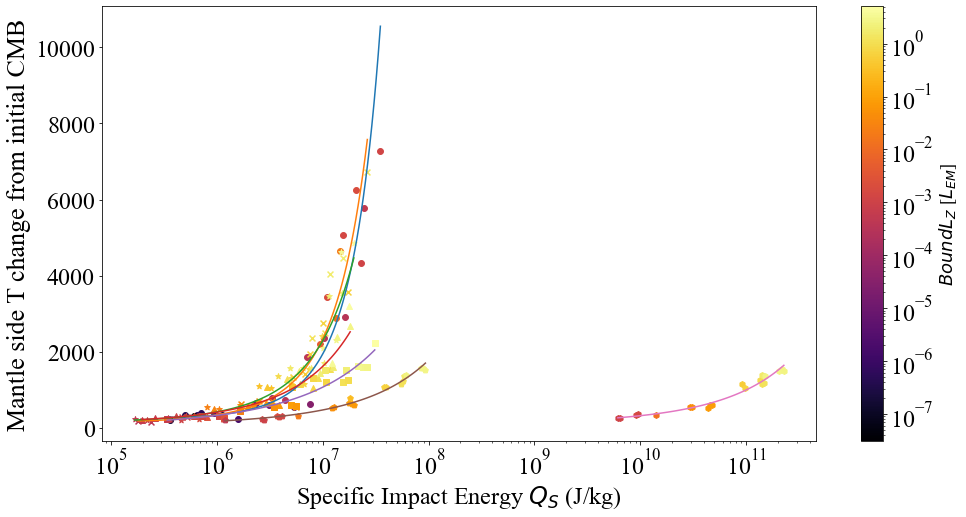

polynomial coefficients, n...0 :  [ 0.78684522 -2.16065887]
R^2 value:  [0.8747852]
polynomial coefficients, n...0 :  [ 0.73957069 -1.81635979]
R^2 value:  [0.91200415]
polynomial coefficients, n...0 :  [ 0.65853601 -1.27282813]
R^2 value:  [0.92195497]
polynomial coefficients, n...0 :  [ 0.54905114 -0.64064405]
R^2 value:  [0.92307319]
polynomial coefficients, n...0 :  [ 0.51583643 -0.57318539]
R^2 value:  [0.92472854]
polynomial coefficients, n...0 :  [ 0.51794083 -0.92637738]
R^2 value:  [0.9771939]
polynomial coefficients, n...0 :  [ 0.50513228 -2.5450026 ]
R^2 value:  [0.97032443]


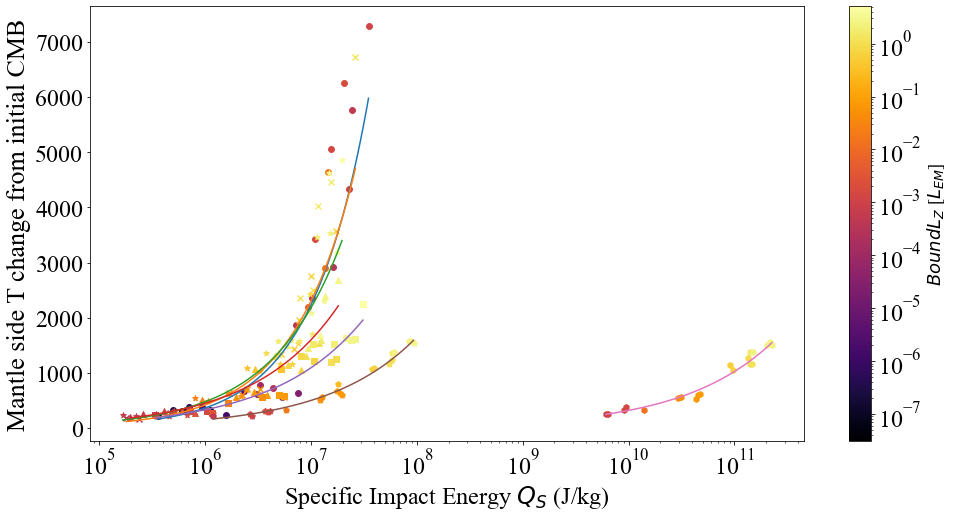

polynomial coefficients, n...0 :  [ 0.38487737 -4.24957102 14.17531843]
R^2 value:  [0.9238537]
polynomial coefficients, n...0 :  [ 0.26744168 -2.64623389  8.78693743]
R^2 value:  [0.94787073]
polynomial coefficients, n...0 :  [ 0.192265   -1.76530878  6.29583462]
R^2 value:  [0.94536164]
polynomial coefficients, n...0 :  [ 0.12296732 -1.00804572  4.23915228]
R^2 value:  [0.9352596]
polynomial coefficients, n...0 :  [ 0.04371301 -0.06022154  1.30905499]
R^2 value:  [0.92655235]
polynomial coefficients, n...0 :  [ 0.07582428 -0.56212573  2.89487672]
R^2 value:  [0.98224747]
polynomial coefficients, n...0 :  [ 0.08731904 -1.34329706  7.21172359]
R^2 value:  [0.97512799]


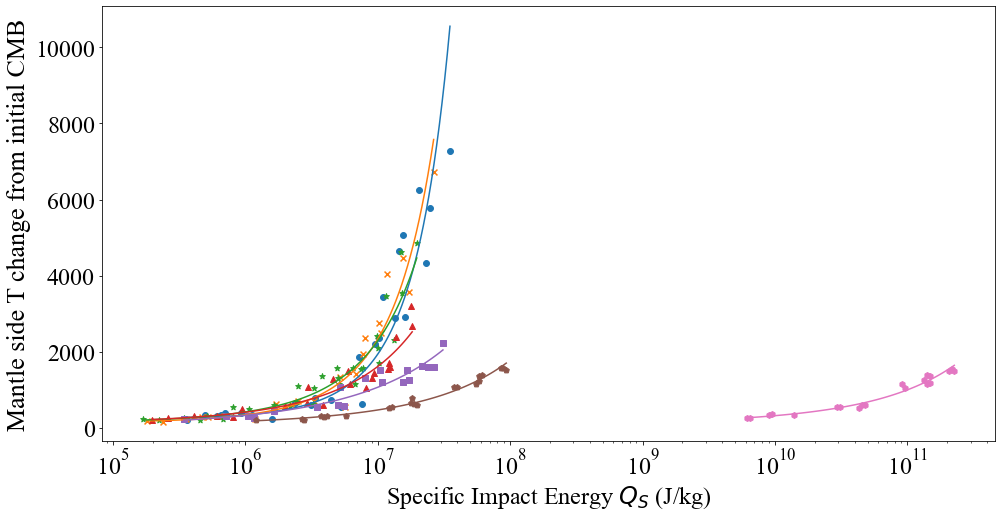

polynomial coefficients, n...0 :  [ 0.38487737 -4.24957102 14.17531843]
R^2 value:  [0.9238537]
polynomial coefficients, n...0 :  [ 0.26744168 -2.64623389  8.78693743]
R^2 value:  [0.94787073]
polynomial coefficients, n...0 :  [ 0.192265   -1.76530878  6.29583462]
R^2 value:  [0.94536164]
polynomial coefficients, n...0 :  [ 0.12296732 -1.00804572  4.23915228]
R^2 value:  [0.9352596]
polynomial coefficients, n...0 :  [ 0.04371301 -0.06022154  1.30905499]
R^2 value:  [0.92655235]
polynomial coefficients, n...0 :  [ 0.07582428 -0.56212573  2.89487672]
R^2 value:  [0.98224747]
polynomial coefficients, n...0 :  [ 0.08731904 -1.34329706  7.21172359]
R^2 value:  [0.97512799]


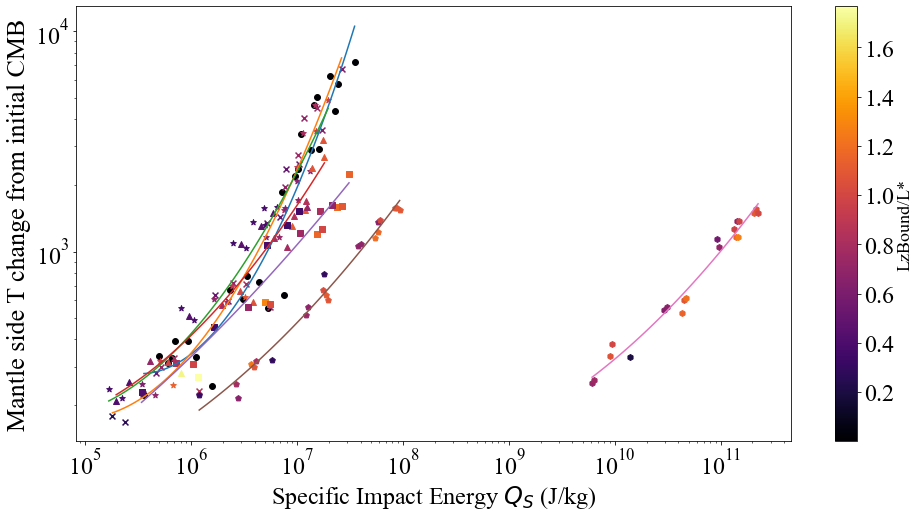

polynomial coefficients, n...0 :  [ 0.78684522 -2.16065887]
R^2 value:  [0.8747852]
polynomial coefficients, n...0 :  [ 0.73957069 -1.81635979]
R^2 value:  [0.91200415]
polynomial coefficients, n...0 :  [ 0.65853601 -1.27282813]
R^2 value:  [0.92195497]
polynomial coefficients, n...0 :  [ 0.54905114 -0.64064405]
R^2 value:  [0.92307319]
polynomial coefficients, n...0 :  [ 0.51583643 -0.57318539]
R^2 value:  [0.92472854]
polynomial coefficients, n...0 :  [ 0.51794083 -0.92637738]
R^2 value:  [0.9771939]
polynomial coefficients, n...0 :  [ 0.50513228 -2.5450026 ]
R^2 value:  [0.97032443]


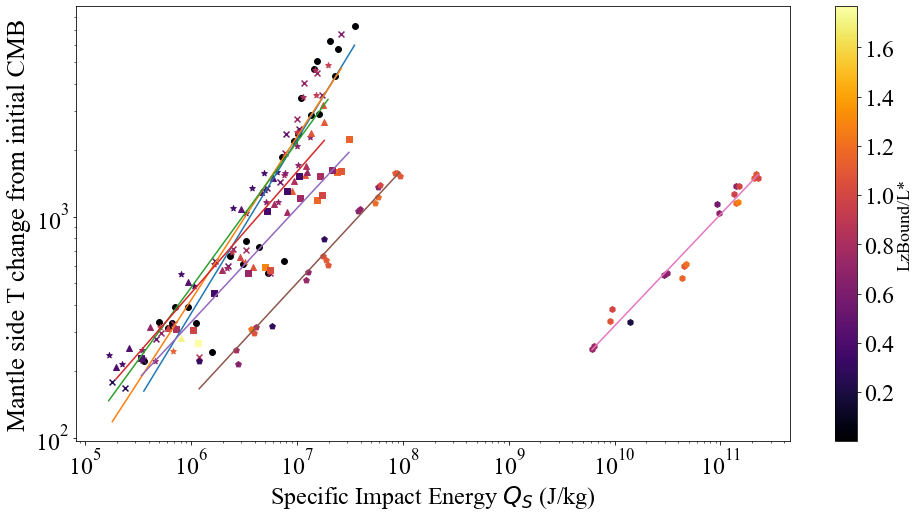

polynomial coefficients, n...0 :  [ 0.38487737 -4.24957102 14.17531843]
R^2 value:  [0.9238537]
polynomial coefficients, n...0 :  [ 0.26744168 -2.64623389  8.78693743]
R^2 value:  [0.94787073]
polynomial coefficients, n...0 :  [ 0.192265   -1.76530878  6.29583462]
R^2 value:  [0.94536164]
polynomial coefficients, n...0 :  [ 0.12296732 -1.00804572  4.23915228]
R^2 value:  [0.9352596]
polynomial coefficients, n...0 :  [ 0.04371301 -0.06022154  1.30905499]
R^2 value:  [0.92655235]
polynomial coefficients, n...0 :  [ 0.07582428 -0.56212573  2.89487672]
R^2 value:  [0.98224747]
polynomial coefficients, n...0 :  [ 0.08731904 -1.34329706  7.21172359]
R^2 value:  [0.97512799]


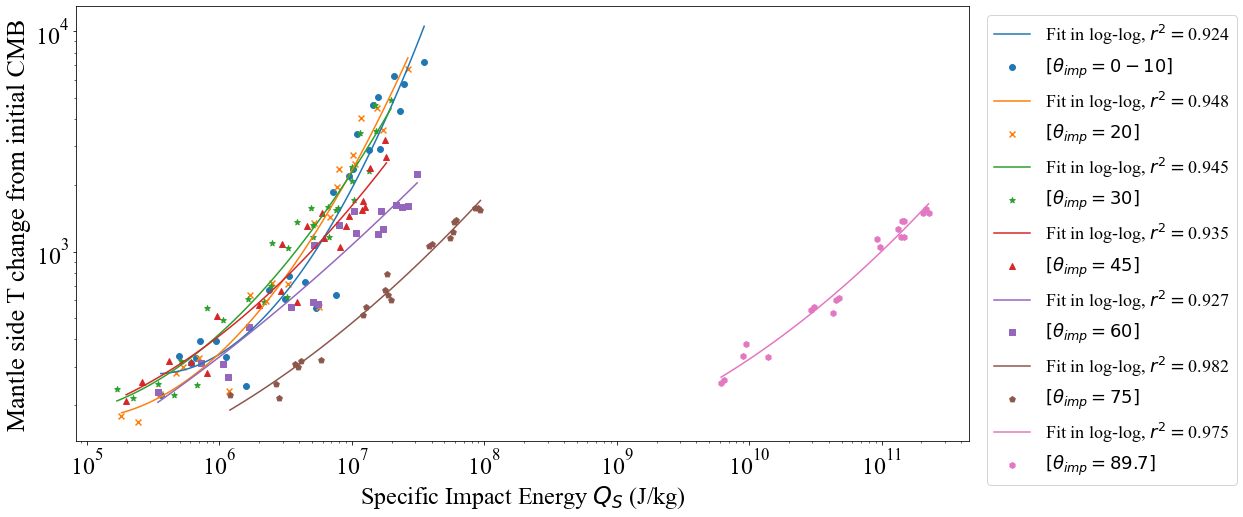

polynomial coefficients, n...0 :  [ -0.29029962   4.70510374 -14.53600539]
R^2 value:  [0.94856731]
polynomial coefficients, n...0 :  [-0.09766709  2.05709366 -5.35474603]
R^2 value:  [0.93748108]
polynomial coefficients, n...0 :  [ -0.21885575   3.63539365 -10.36476208]
R^2 value:  [0.96223213]
polynomial coefficients, n...0 :  [-0.15649593  2.93074895 -8.5860192 ]
R^2 value:  [0.88821949]
polynomial coefficients, n...0 :  [ -0.17933007   3.40598212 -11.00399962]
R^2 value:  [0.86454378]
polynomial coefficients, n...0 :  [ -0.5842641    9.52069709 -34.46617232]
R^2 value:  [0.9586585]
polynomial coefficients, n...0 :  [ -0.47588158  11.1750315  -61.22305506]
R^2 value:  [0.93054899]


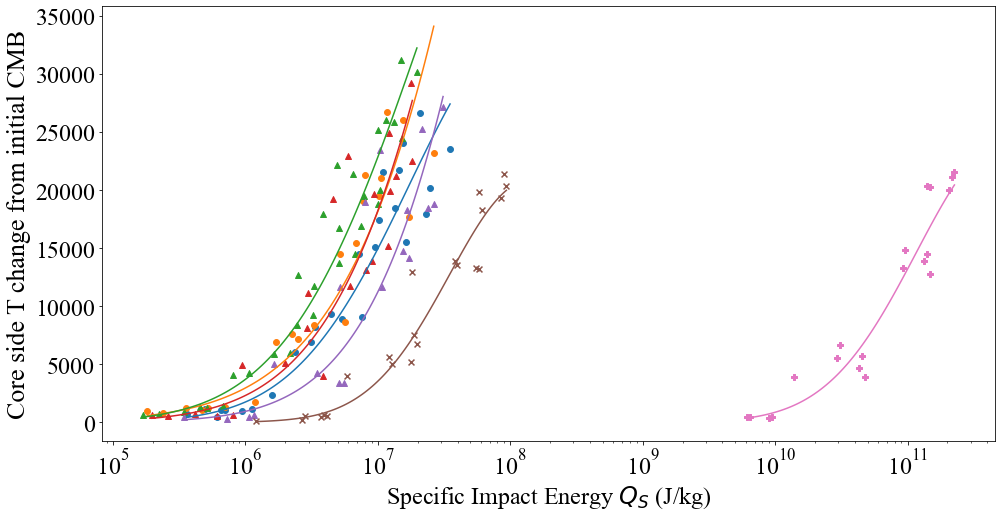

polynomial coefficients, n...0 :  [ -0.29029962   4.70510374 -14.53600539]
R^2 value:  [0.94856731]
polynomial coefficients, n...0 :  [-0.09766709  2.05709366 -5.35474603]
R^2 value:  [0.93748108]
polynomial coefficients, n...0 :  [ -0.21885575   3.63539365 -10.36476208]
R^2 value:  [0.96223213]
polynomial coefficients, n...0 :  [-0.15649593  2.93074895 -8.5860192 ]
R^2 value:  [0.88821949]
polynomial coefficients, n...0 :  [ -0.17933007   3.40598212 -11.00399962]
R^2 value:  [0.86454378]
polynomial coefficients, n...0 :  [ -0.5842641    9.52069709 -34.46617232]
R^2 value:  [0.9586585]
polynomial coefficients, n...0 :  [ -0.47588158  11.1750315  -61.22305506]
R^2 value:  [0.93054899]


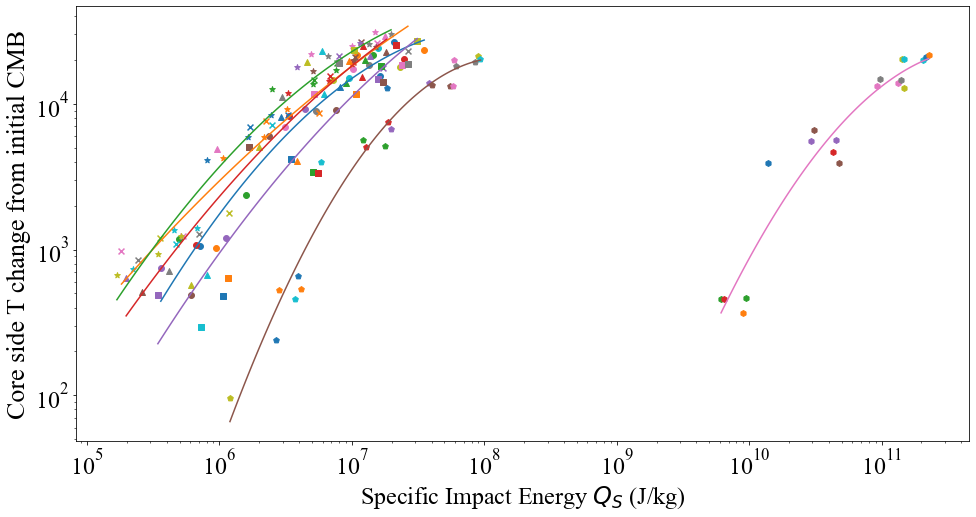

polynomial coefficients, n...0 :  [ 0.90630999 -2.21434541]
R^2 value:  [0.92628706]
polynomial coefficients, n...0 :  [ 0.82063094 -1.4825256 ]
R^2 value:  [0.93350448]
polynomial coefficients, n...0 :  [ 0.87632481 -1.74933355]
R^2 value:  [0.94468281]
polynomial coefficients, n...0 :  [ 0.94908976 -2.37568414]
R^2 value:  [0.88190845]
polynomial coefficients, n...0 :  [ 1.04273778 -3.28221783]
R^2 value:  [0.85757756]
polynomial coefficients, n...0 :  [ 1.19824216 -5.02149138]
R^2 value:  [0.90664369]
polynomial coefficients, n...0 :  [ 1.10124362 -8.04969964]
R^2 value:  [0.90262504]


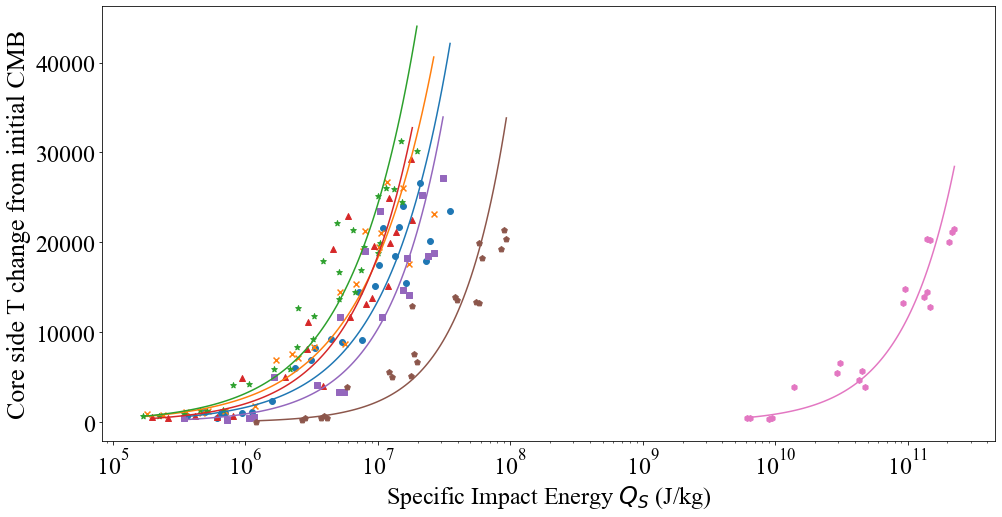

polynomial coefficients, n...0 :  [ 0.90630999 -2.21434541]
R^2 value:  [0.92628706]
polynomial coefficients, n...0 :  [ 0.82063094 -1.4825256 ]
R^2 value:  [0.93350448]
polynomial coefficients, n...0 :  [ 0.87632481 -1.74933355]
R^2 value:  [0.94468281]
polynomial coefficients, n...0 :  [ 0.94908976 -2.37568414]
R^2 value:  [0.88190845]
polynomial coefficients, n...0 :  [ 1.04273778 -3.28221783]
R^2 value:  [0.85757756]
polynomial coefficients, n...0 :  [ 1.19824216 -5.02149138]
R^2 value:  [0.90664369]
polynomial coefficients, n...0 :  [ 1.10124362 -8.04969964]
R^2 value:  [0.90262504]


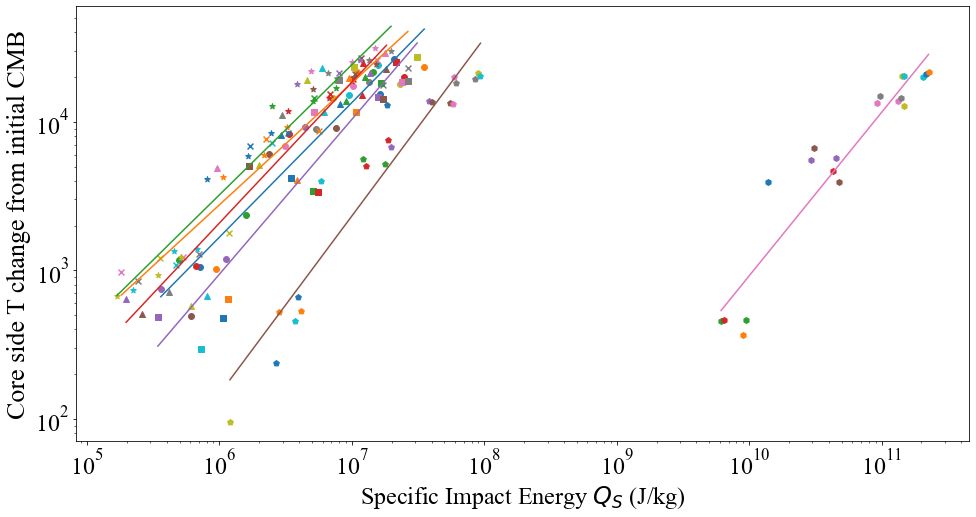

array([[ 0.90630999, -2.21434541],
       [ 0.82063094, -1.4825256 ],
       [ 0.87632481, -1.74933355],
       [ 0.94908976, -2.37568414],
       [ 1.04273778, -3.28221783],
       [ 1.19824216, -5.02149138],
       [ 1.10124362, -8.04969964]])

In [48]:
deltafitlist2d = deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',legend=False,markers='theta',normalize=True,logfit=2)
deltafitlist1d = deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',legend=False,markers='theta',normalize=True,logfit=1)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=thetalabels,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=2)

deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=1)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=thetalabels,loglog=True,legend=True,markers='theta',Lzstar=True,normalize=True,logfit=2)

corefitlist2d=deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=thetalabels,legend=False,markers='size',Lzstar=True,normalize=True,logfit=2,core=True)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=2,core=True)
corefitlist1d=deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=thetalabels,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=1,core=True)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=1,core=True)

polynomial coefficients, n...0 :  [ 0.38487737 -4.24957102 14.17531843]
R^2 value:  [0.9238537]
polynomial coefficients, n...0 :  [ 0.26744168 -2.64623389  8.78693743]
R^2 value:  [0.94787073]
polynomial coefficients, n...0 :  [ 0.192265   -1.76530878  6.29583462]
R^2 value:  [0.94536164]
polynomial coefficients, n...0 :  [ 0.12296732 -1.00804572  4.23915228]
R^2 value:  [0.9352596]
polynomial coefficients, n...0 :  [ 0.04371301 -0.06022154  1.30905499]
R^2 value:  [0.92655235]
polynomial coefficients, n...0 :  [ 0.07582428 -0.56212573  2.89487672]
R^2 value:  [0.98224747]


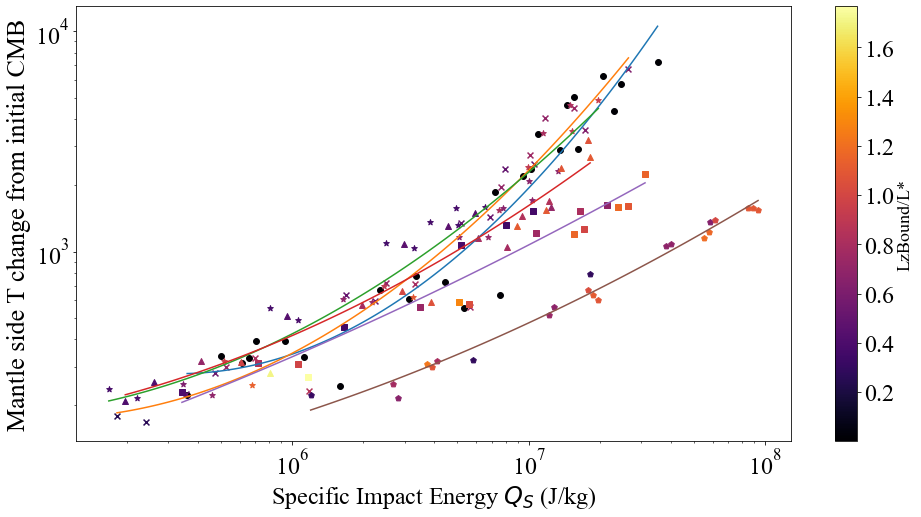

polynomial coefficients, n...0 :  [ 0.78684522 -2.16065887]
R^2 value:  [0.8747852]
polynomial coefficients, n...0 :  [ 0.73957069 -1.81635979]
R^2 value:  [0.91200415]
polynomial coefficients, n...0 :  [ 0.65853601 -1.27282813]
R^2 value:  [0.92195497]
polynomial coefficients, n...0 :  [ 0.54905114 -0.64064405]
R^2 value:  [0.92307319]
polynomial coefficients, n...0 :  [ 0.51583643 -0.57318539]
R^2 value:  [0.92472854]
polynomial coefficients, n...0 :  [ 0.51794083 -0.92637738]
R^2 value:  [0.9771939]


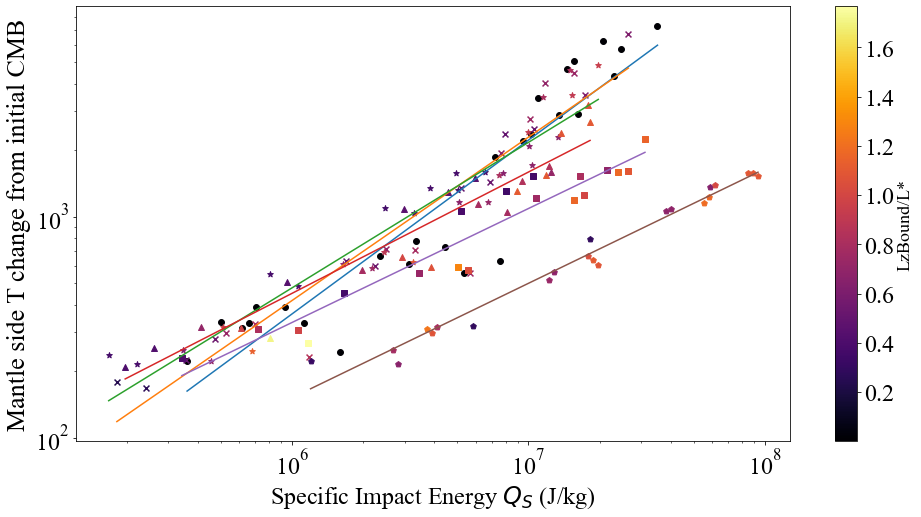

polynomial coefficients, n...0 :  [ 0.38487737 -4.24957102 14.17531843]
R^2 value:  [0.9238537]
polynomial coefficients, n...0 :  [ 0.26744168 -2.64623389  8.78693743]
R^2 value:  [0.94787073]
polynomial coefficients, n...0 :  [ 0.192265   -1.76530878  6.29583462]
R^2 value:  [0.94536164]
polynomial coefficients, n...0 :  [ 0.12296732 -1.00804572  4.23915228]
R^2 value:  [0.9352596]
polynomial coefficients, n...0 :  [ 0.04371301 -0.06022154  1.30905499]
R^2 value:  [0.92655235]
polynomial coefficients, n...0 :  [ 0.07582428 -0.56212573  2.89487672]
R^2 value:  [0.98224747]


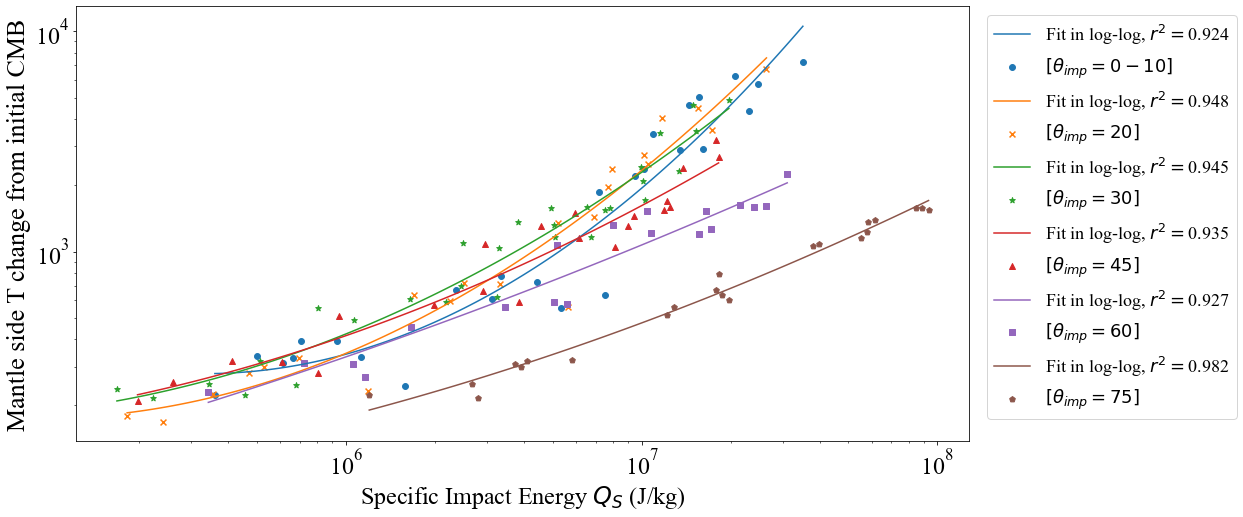

array([[ 0.38487737, -4.24957102, 14.17531843],
       [ 0.26744168, -2.64623389,  8.78693743],
       [ 0.192265  , -1.76530878,  6.29583462],
       [ 0.12296732, -1.00804572,  4.23915228],
       [ 0.04371301, -0.06022154,  1.30905499],
       [ 0.07582428, -0.56212573,  2.89487672]])

In [49]:
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list],labels=None,colors='Lz',loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list],labels=None,colors='Lz',loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=1)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list],labels=thetalabels,loglog=True,legend=True,markers='theta',Lzstar=True,normalize=True,logfit=2)

In [50]:
w2ds = np.array([0.92765402,0.94787073,0.94536164,0.9346964,0.92655235,0.85977129,0.88950642])
corew2ds = np.array([0.94856731,0.93748108,0.96223213,0.8814006,0.86454378,0.93655381,0.90923015])

### Fitting CMB differences by angle

In [51]:
thetalist = np.array([0, 20, 30, 45, 60, 75, 89.7])
#fitlist1d = np.array([[ 0.64866161, -2.65125147],[ 0.64973542, -2.6638763 ],[ 0.52256506, -1.85684601],[ 0.45610999, -1.50681735],[ 0.38744696, -1.14579257]])
#fitlist2d = np.array([[ 0.32909685, -3.62374561, 11.0783027 ],[ 0.24076615, -2.39835762,  6.88181238],[ 0.1598681,  -1.46978543,  4.29739432],[ 0.1078483,  -0.90424418,  2.74674454],[-0.0147106,   0.57961963, -1.76811044]])

def plot_theta_fits(fitlist,regfit=1,lastleg=0,w=None):
    thetalist = np.array([0, 20, 30, 45, 60, 75, 89.7])
    nfit=np.size(fitlist[0,:])
    fitstring='Fitting polynomial y = '
    allfits = np.zeros([np.size(fitlist[0,:]),regfit+1])
    for i in range(nfit):
        fitstring=fitstring+'K_%g'%(nfit-i-1)
        if i<(nfit-2): fitstring=fitstring+'(x^%g) '%(nfit-i-1)
        elif i<(nfit-1): fitstring=fitstring+'(x) '
        if i<(nfit-1):fitstring=fitstring+'+ '
    print(fitstring)
    fitrange=nfit
    #if (lastleg>0)|(lastcheb>0): fitrange=nfit-1
    #fitlist[:,nfit-1]=np.log10(fitlist[:,nfit-1])
    for i in range(fitrange):
        fit,residuals,rank,singular_values,rcond=np.polyfit(thetalist,fitlist[:,i],regfit,full=True,w=w)
        print('Polynomial coefficient K_%g regression fit'%(nfit-i-1),fit)
        print('R^2 value: ',1-residuals/np.sum((fitlist[:,i]-np.mean(fitlist[:,i]))**2))
        allfits[i,:]=fit
        space=np.linspace(thetalist[0],90,50)
        fitfn=np.poly1d(fit)
        plt.plot(thetalist,fitlist[:,i])
        #print(fitfn(30))
        plt.plot(space,fitfn(space))
        plt.gca().set_xlabel('Theta (degrees)',size=20)
        plt.gca().set_ylabel(r'Polynomial coefficient $K_{%g}$'%(nfit-i-1),size=20)
        plt.show()
    return allfits

def bbfit(fitlist,w=None):
    if w is not None:
        sigma=w**(-1/2)
    else: sigma=None
    thetalist = np.array([0, 20, 30, 45, 60, 75, 89.7])
    params,extras=curve_fit(quadlogfnsimple,thetalist,fitlist,p0=[-3.61553173e-03,2.96612328e-01,-4.95670451e+00],sigma=sigma)
    R2=1-np.sum((fitlist-quadlogfnsimple(thetalist,*params))**2)/np.sum((fitlist-np.mean(fitlist))**2)
    print('Quadratic log coeffcient K_0 regression fit: ',params)
    print('R^2 value: ',R2)
    space=np.linspace(thetalist[0],thetalist[-1],50)
    plt.plot(thetalist,fitlist)
    plt.plot(space,quadlogfnsimple(space,*params))
    plt.plot(space,quadlogfnsimple(space,-4.16995470e-03,2.52604924e-01,-2.92760730e+00))
    print(quadlogfnsimple(30,*params))
    plt.gca().set_xlabel('Theta (degrees)',size=20)
    plt.gca().set_ylabel(r'Polynomial coefficient $K_{%g}$'%(0),size=20)
    plt.ylim(0,np.amax(quadlogfnsimple(space,*params)))
    plt.show()
    return params
        
#print(np.size(deltafitlist1d[0,:]))
#plot_theta_fits(deltafitlist1d)


Fitting polynomial y = K_2(x^2) + K_1(x) + K_0
Polynomial coefficient K_2 regression fit [ 5.97864813e-05 -8.92889166e-03  3.99576678e-01]
R^2 value:  [0.97905182]


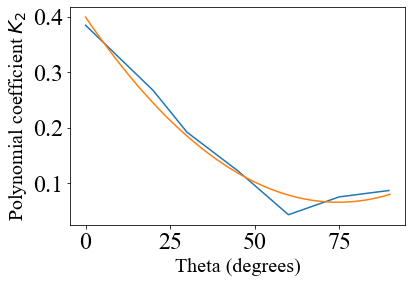

Polynomial coefficient K_1 regression fit [-9.55729500e-04  1.22707542e-01 -4.45612876e+00]
R^2 value:  [0.96999006]


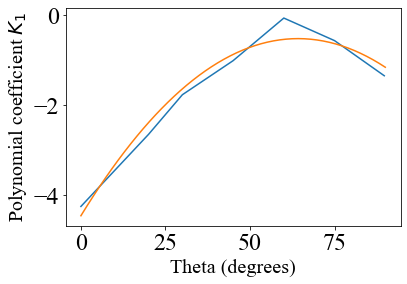

Polynomial coefficient K_0 regression fit [ 3.48927184e-03 -4.09727304e-01  1.48782986e+01]
R^2 value:  [0.95377625]


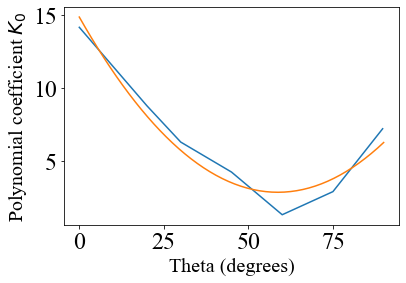

array([[ 5.97864813e-05, -8.92889166e-03,  3.99576678e-01],
       [-9.55729500e-04,  1.22707542e-01, -4.45612876e+00],
       [ 3.48927184e-03, -4.09727304e-01,  1.48782986e+01]])

In [52]:
plot_theta_fits(deltafitlist2d,regfit=2,w=w2ds)


Fitting polynomial y = K_1(x) + K_0
Polynomial coefficient K_1 regression fit [-2.92312322e-06  4.18449448e-04 -1.17015722e-02  9.09965419e-01]
R^2 value:  [0.96521248]


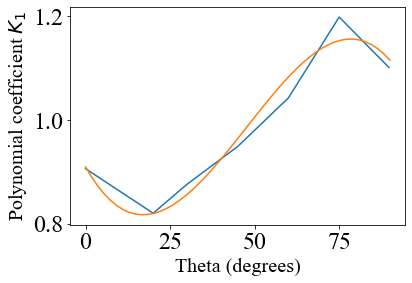

Polynomial coefficient K_0 regression fit [-6.99592589e-06 -5.03484625e-04  3.66816879e-02 -2.15907743e+00]
R^2 value:  [0.99682016]


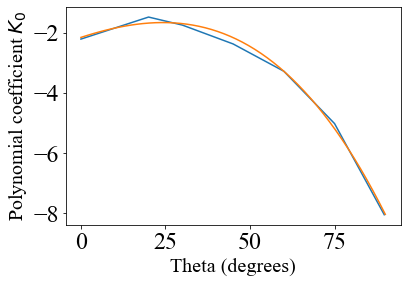

[[-2.92312322e-06  4.18449448e-04 -1.17015722e-02  9.09965419e-01]
 [-6.99592589e-06 -5.03484625e-04  3.66816879e-02 -2.15907743e+00]]


In [53]:
corefits=plot_theta_fits(corefitlist1d,regfit=3,w=corew2ds)
print(corefits)

[1.00000000e-05 3.24743578e-01 4.02046352e+00 5.34473745e+00
 8.25545338e-01 3.33800035e-01 4.08188000e-01]
Fitting polynomial y = K_3(x^3) + K_2(x^2) + K_1(x) + K_0
Polynomial coefficient K_3 regression fit [-7.90784757e-04  6.36941752e-02 -9.48611302e-01]
R^2 value:  [0.98583161]


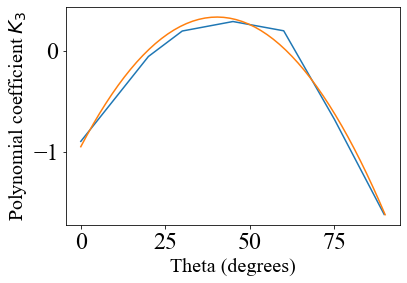

Polynomial coefficient K_2 regression fit [ 1.49603127e-02 -1.15196202e+00  1.70005127e+01]
R^2 value:  [0.96310623]


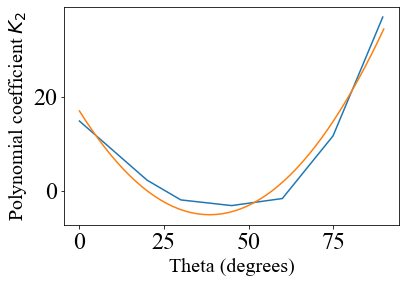

Polynomial coefficient K_1 regression fit [-7.44412709e-02  5.47453896e+00 -7.55975011e+01]
R^2 value:  [0.91306441]


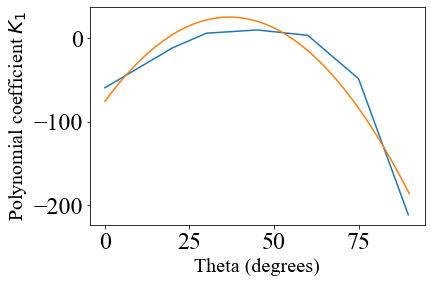

Polynomial coefficient K_0 regression fit [-0.00169504  0.14822417 -0.17407917]
R^2 value:  [0.44851404]


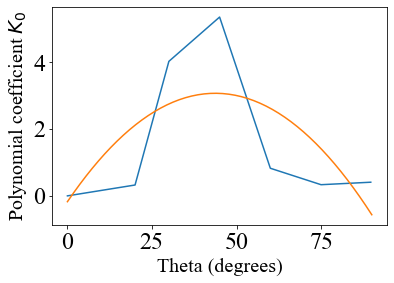

Quadratic log coeffcient K_0 regression fit:  [-2.53480005e-03  2.00013237e-01 -3.13242297e+00]
R^2 value:  0.9806839385865325
3.860593777226325


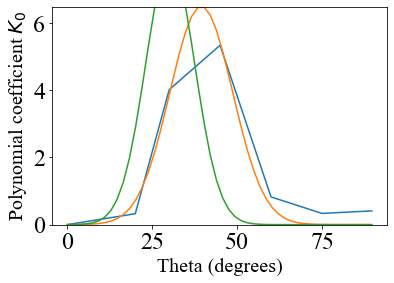

[[-7.90784757e-04  6.36941752e-02 -9.48611302e-01]
 [ 1.49603127e-02 -1.15196202e+00  1.70005127e+01]
 [-7.44412709e-02  5.47453896e+00 -7.55975011e+01]
 [-1.69504137e-03  1.48224169e-01 -1.74079167e-01]]
[-2.53480005e-03  2.00013237e-01 -3.13242297e+00]
[[-7.90784757e-04  6.36941752e-02 -9.48611302e-01]
 [ 1.49603127e-02 -1.15196202e+00  1.70005127e+01]
 [-7.44412709e-02  5.47453896e+00 -7.55975011e+01]
 [-2.53480005e-03  2.00013237e-01 -3.13242297e+00]]


In [54]:
print(quadfitlistnew[:,3])
testfitlist=copy.deepcopy(quadfitlistnew)
quadlogfit=plot_theta_fits(testfitlist,regfit=2)#,w=ws2new
quadzfit=bbfit(quadfitlistnew[:,3])#,w=ws2new
print(quadlogfit)
print(quadzfit)
quadlogfit[-1,:]=quadzfit
print(quadlogfit)

Fitting polynomial y = K_2(x^2) + K_1(x) + K_0
Polynomial coefficient K_2 regression fit [ 5.97864813e-05 -8.92889166e-03  3.99576678e-01]
R^2 value:  [0.97905182]


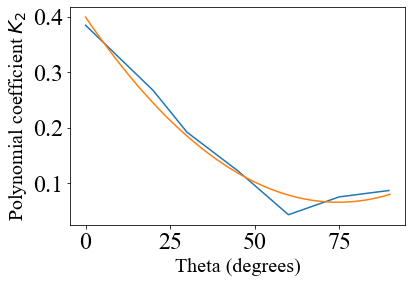

Polynomial coefficient K_1 regression fit [-9.55729500e-04  1.22707542e-01 -4.45612876e+00]
R^2 value:  [0.96999006]


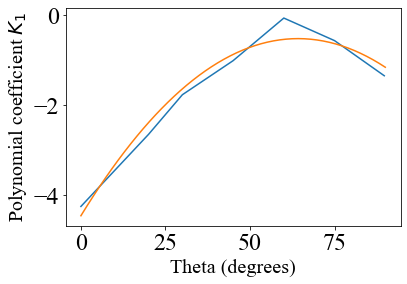

Polynomial coefficient K_0 regression fit [ 3.48927184e-03 -4.09727304e-01  1.48782986e+01]
R^2 value:  [0.95377625]


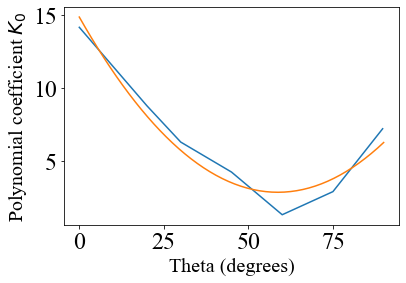

In [55]:
thetafits=plot_theta_fits(deltafitlist2d,regfit=2,w=w2ds)

R^2:  0.9134564873989526


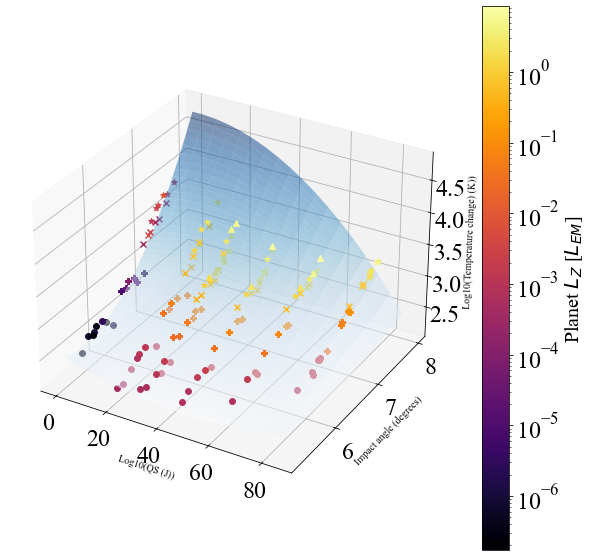

R^2:  0.708546117454041


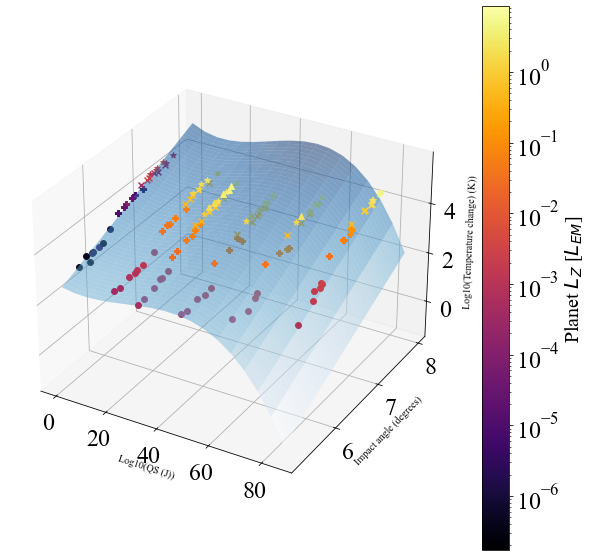

In [56]:
def logdeltaT3D(QS,theta,fitlist):
    logdeltaT=0
    nfit=np.size(fitlist[:,0])
    #print(nfit)
    for i in range(nfit):
        coeff=0
        fitsize=np.size(fitlist[i,:])
        #print(fitsize)
        for j in range(fitsize):
            coeff+=fitlist[i,j]*(theta**(fitsize-1-j))
            #print(coeff)
        logdeltaT+=coeff*(np.log10(QS)**(nfit-1-i))
    return logdeltaT

vlogdeltaT3D=np.vectorize(logdeltaT3D,excluded=[2])


def deltaT_CMB_QS3D(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,fitlist=None,core=False):
    if logfit==True:
        logfit=1
    fig = plt.figure(1,figsize=(10,10))
    ax = plt.axes(projection='3d',computed_zorder=False)
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfits = np.zeros([np.shape(simlistlist)[0],logfit+1])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
        
    QSfield=np.logspace(np.log10(np.amin(allQS)),np.log10(np.amax(allQS)))
    thetafield=np.arange(0,90,5)
    thetafield,QSfield = np.meshgrid(thetafield,QSfield)
    Z=vlogdeltaT3D(QSfield,thetafield,fitlist)
    
    #Z=np.power(10,vlogdeltaT3D(QSfield,thetafield,fitlist))
    
    #ax.set_zscale('log')
    
    overlist=np.array([])
    allDTs=np.array([])
    allthetas=np.array([])
    allQSs=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        thetas=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if core:
                r = sim.RRRmant[0]
                rcore = np.where(sim.RRRcore<r)
                DTplanets[j] = sim.Tmeancore[rcore][-1]-sim.TCMB0core
            else:
                DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
            if normalize: DTplanets[j] = DTplanets[j]/(sim.M_t/sim.Mbound[-1])
            thetas[j] = sim.theta
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            allDTs=np.append(allDTs,DTplanets[j])
            allthetas=np.append(allthetas,thetas[j])
            allQSs=np.append(allQSs,QSs[j])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logdeltaT3D(QSs[j],thetas[j],fitlist)<np.log10(DTplanets[j]):
                        overlist=np.append(overlist,sim)
                    else:
                        ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    if logdeltaT3D(QSs[j],thetas[j],fitlist)<np.log10(DTplanets[j]):
                        overlist=np.append(overlist,sim)
                    else:
                        ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker)
                count+=1
        
        if labels is not None:
            #if logfit:
            ax.scatter(thetas,np.log10(QSs),np.log10(DTplanets),label=labels[i],s=35,marker=marker)
    R2=1-np.sum((np.log10(allDTs)-vlogdeltaT3D(allQSs,allthetas,fitlist))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
    print('R^2: ',R2)
    ax.plot_surface(thetafield,np.log10(QSfield),  Z,alpha=0.5,cmap='Blues')
    DTplanets=np.zeros(np.size(overlist))
    DPplanets=np.zeros(np.size(overlist))
    QSs=np.zeros(np.size(overlist))
    Lzs=np.zeros(np.size(overlist))
    thetas=np.zeros(np.size(overlist))
    for j in range(np.size(overlist)):
        sim=overlist[j]
        if markers=='theta':marker=sim.thetamarker
        elif markers=='size':marker=sim.sizemarker
        elif markers=='ratio':marker=sim.ratiomarker
        elif markers=='outcome':marker=sim.outcomemarker
        if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
        if core:
            r = sim.RRRmant[0]
            rcore = np.where(sim.RRRcore<r)
            DTplanets[j] = sim.Tmeancore[rcore][-1]-sim.TCMB0core
        else:
            DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
        if normalize: DTplanets[j] = DTplanets[j]/(sim.M_t/sim.Mbound[-1])
        thetas[j] = sim.theta
        if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
        else: Lzs[j]=sim.Lzbnd[-1]
        if star:
            QSs[j] = sim.QstarS
            #logallQS=np.append(logallQS,np.log10(sim.QstarS))
        else:
            QSs[j] = sim.QS
            #logallQS=np.append(logallQS,np.log10(sim.QS))
        if labels is None:
            if colors is not None:
                if colors=='Lz':c=Lzs[j]
                if colors=='QS':c=QSs[j]
                ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
            else:
                ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker)
            count+=1
    
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=20)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=20)
        if colors=='QS':cbar.set_label('QS [J]',size=20)
    ax.set_xlabel('Log10(QS (J))',size=10)
    ax.set_ylabel('Impact angle (degrees)',size=10)
    #ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel('Log10(Temperature change) (K))',size=10)
    
    plt.show()
    
deltaT_CMB_QS3D([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,fitlist=thetafits)
deltaT_CMB_QS3D([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,core=True,fitlist=corefits)

In [57]:
def quadfitparams(QS,theta,fitlist):
    #assuming last term is special
    nfit=np.size(fitlist[:,0])
    params=np.zeros(nfit)
    #print(nfit)
    for i in range(nfit-1):
        fitsize=np.size(fitlist[i,:])
        coeff=0
        #print(fitsize)
        for j in range(fitsize):
            coeff+=fitlist[i,j]*(theta**(fitsize-1-j))
            #print(coeff)
        params[i]=coeff
    params[-1]=quadlogfnsimple(theta,*fitlist[-1,:])
    #return params
    return quadlogfn(np.log10(QS),*params)

vquadparams=np.vectorize(quadfitparams,excluded=[2])
print(vquadparams)
print(quadfitparams(1.e5,30,quadlogfit))

-27157122.01437009


In [58]:
print(thetafits)

[[ 5.97864813e-05 -8.92889166e-03  3.99576678e-01]
 [-9.55729500e-04  1.22707542e-01 -4.45612876e+00]
 [ 3.48927184e-03 -4.09727304e-01  1.48782986e+01]]


In [59]:
def logTlogfnfull(x,a2,a1,a0,b2,b1,b0,c2,c1,c0):
    return np.log10(Tlogfnfull(x,a2,a1,a0,b2,b1,b0,c2,c1,c0))

def corelogTlogfnfull(x,a3,a2,a1,a0,b3,b2,b1,b0):
    return np.log10(coreTlogfnfull(x,a3,a2,a1,a0,b3,b2,b1,b0))

def fit_deltaT_CMB(simlistlist,normalize=False,core=False):
    allDTs=np.array([])
    allthetas=np.array([])
    allQSs=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        thetas=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            QSs[j] = sim.QS
            allQSs=np.append(allQSs,QSs[j])
            thetas[j] = sim.theta
            allthetas=np.append(allthetas,thetas[j])
            if core:
                r = sim.RRRmant[0]
                rcore = np.where(sim.RRRcore<r)
                DTplanets[j] = sim.Tmeancore[rcore][-1]-sim.TCMB0core
                #DTplanets[j] = np.amax(sim.Tmeancore)-sim.TCMB0core
            else:
                DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
            if normalize: DTplanets[j] = DTplanets[j]/(sim.M_t/sim.Mbound[-1])
            allDTs=np.append(allDTs,DTplanets[j])
    allx=np.stack((np.log10(allQSs),allthetas),axis=-1)
    print(np.shape(allx))
    print(np.shape(allDTs))
    if core:
        p0= [-4.09329849e-06,4.72920684e-04,-1.10967093e-02,8.89456821e-01,
             2.32015049e-05,-3.12788333e-03,8.44398990e-02,-2.10083428e+00]
    else:
        p0=[1.56468107e-05,-6.63974519e-03,3.89728327e-01,
        -3.39416858e-04,8.98433801e-02,-4.29938899e+00,
        1.39887809e-03,-2.95388474e-01,1.42879395e+01,]
    #print(quadlogfnfull(allx[0],*p0))
    if core:
        params,extras=curve_fit(corelogTlogfnfull,allx,np.log10(allDTs),p0)
        #params,extras=curve_fit(coreTlogfnfull,allx,(allDTs),p0)
        R2=1-np.sum((np.log10(allDTs)-np.log10(coreTlogfnfull(allx,*params)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
        #R2=1-np.sum(((allDTs)-(coreTlogfnfull(allx,*params)))**2)/np.sum(((allDTs)-np.mean((allDTs)))**2)
    else:
        params,extras=curve_fit(logTlogfnfull,allx,np.log10(allDTs),p0)
        #params,extras=curve_fit(Tlogfnfull,allx,(allDTs),p0)
        R2=1-np.sum((np.log10(allDTs)-np.log10(Tlogfnfull(allx,*params)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
        #R2=1-np.sum(((allDTs)-(Tlogfnfull(allx,*params)))**2)/np.sum(((allDTs)-np.mean((allDTs)))**2)
    print('R^2: ',R2)
    
    return params
            
#deltaP_CMB_QS3D(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,fitlist=None):
Tquadfit=fit_deltaT_CMB([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],normalize=True)    
print(Tquadfit)
coreTquadfit=fit_deltaT_CMB([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],normalize=True,core=True)    
print(coreTquadfit)

(119, 2)
(119,)
R^2:  0.934039632512224
[ 3.55907399e-05 -6.73212443e-03  3.64851071e-01 -5.99854823e-04
  9.07061776e-02 -3.97120631e+00  2.24104151e-03 -2.96804734e-01
  1.32120871e+01]
(119, 2)
(119,)
R^2:  0.9073348093521388
[-2.66949609e-06  3.64859195e-04 -9.95973149e-03  9.06618417e-01
  1.41359773e-05 -2.45226560e-03  7.80689720e-02 -2.21953260e+00]


In [60]:
def deltaT_CMB_QS3D(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,fitlist=None,fullparams=None,core=False,residuals=False,savefig=None):
    if logfit==True:
        logfit=1
    fig = plt.figure(1,figsize=(18,10))#
    ax = plt.axes(projection='3d',computed_zorder=False)
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfits = np.zeros([np.shape(simlistlist)[0],logfit+1])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
        
    QSfield0=np.logspace(np.log10(np.amin(allQS)),np.log10(np.amax(allQS)))
    thetafield0=np.arange(0,90,1)
    thetafield,QSfield = np.meshgrid(thetafield0,QSfield0)
    logthetafield,logQSfield = np.meshgrid(thetafield0,np.log10(QSfield0))
    if fitlist is not None:
        #Z=10.**(vlogdeltaT3D(QSfield,thetafield,fitlist))
        Z=(vlogdeltaT3D(QSfield,thetafield,fitlist))
        #print(Z)
    if fullparams is not None:
        #Z=vTlogfnfull(logQSfield,logthetafield,*fullparams)
        if core: Z=np.log10(vcoreTlogfnfull(logQSfield,logthetafield,*fullparams))
        else: Z=np.log10(vTlogfnfull(logQSfield,logthetafield,*fullparams))
        #print(Z)
    
    #Z=np.power(10,vlogdeltaT3D(QSfield,thetafield,fitlist))
    
    #ax.set_zscale('log')
    
    overlist=np.array([])
    allDTs=np.array([])
    allthetas=np.array([])
    allQSs=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        thetas=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if core:
                r = sim.RRRmant[0]
                rcore = np.where(sim.RRRcore<r)
                DTplanets[j] = sim.Tmeancore[rcore][-1]-sim.TCMB0core
                #DTplanets[j]=np.amax(sim.Tmeancore)-sim.TCMB0core
            else:
                DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
            if normalize: DTplanets[j] = DTplanets[j]/(sim.M_t/sim.Mbound[-1])
            thetas[j] = sim.theta
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            allDTs=np.append(allDTs,DTplanets[j])
            allthetas=np.append(allthetas,thetas[j])
            allQSs=np.append(allQSs,QSs[j])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    one=True
                    two=True
                    if (fitlist is not None):
                        if core: overT=(10.**(logdeltaT3D(QSs[j],thetas[j],fitlist)))
                        else: overT=(10.**(logdeltaT3D(QSs[j],thetas[j],fitlist)))
                        if (overT<DTplanets[j]):
                            overlist=np.append(overlist,sim)
                            one=False
                    if (fullparams is not None):
                        if core: overT=(coreTlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))
                        else: overT=(Tlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))
                        if overT<DTplanets[j]:
                            overlist=np.append(overlist,sim)
                            two=False
                    if one&two:
                        ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                        #ax.scatter(np.log10(QSs[j]),thetas[j],vquadparams(QSs[j],thetas[j],fitlist),s=35,color='blue')
                else:
                    one=True
                    two=True
                    if (fitlist is not None):
                        if core: overT=(10.**(logdeltaT3D(QSs[j],thetas[j],fitlist)))
                        else: overT=(10.**(logdeltaT3D(QSs[j],thetas[j],fitlist)))
                        if (overT<DTplanets[j]):
                            overlist=np.append(overlist,sim)
                            one=False
                    if (fullparams is not None):
                        if core: overT=(Tlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))
                        else: overT=(Tlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))
                        if overT<DTplanets[j]:
                            overlist=np.append(overlist,sim)
                            two=False
                    if one&two:
                        ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker)
                count+=1
        
        if labels is not None:
            #if logfit:
            ax.scatter(thetas,np.log10(QSs),np.log10(DTplanets),label=labels[i],s=35,marker=marker)
    if fitlist is not None:
        if core:
            R2=1-np.sum((allDTs-10.**(vlogdeltaT3D(allQSs,allthetas,fitlist)))**2)/np.sum((allDTs-np.mean(allDTs))**2)
            print('R^2: ',R2)
            logR2=1-np.sum((np.log10(allDTs)-(vlogdeltaT3D(allQSs,allthetas,fitlist)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
            print('log R^2: ',logR2)
        else:
            R2=1-np.sum((allDTs-10.**(vlogdeltaT3D(allQSs,allthetas,fitlist)))**2)/np.sum((allDTs-np.mean(allDTs))**2)
            print('R^2: ',R2)
            logR2=1-np.sum((np.log10(allDTs)-(vlogdeltaT3D(allQSs,allthetas,fitlist)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
            print('log R^2: ',logR2)
    if fullparams is not None:
        if core:
            R2=1-np.sum((allDTs-(vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.sum((allDTs-np.mean(allDTs))**2)
            print('R^2: ',R2)
            err=np.sqrt(np.sum((allDTs-(vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.size(allDTs))
            print('Error: ',err,' K')
            percenterr=np.sqrt(np.sum(((allDTs-(vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))/vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams))**2)/np.size(allDTs))*100
            print('Percent standard error: ',percenterr)
            logR2=1-np.sum((np.log10(allDTs)-np.log10(vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
            print('log R^2: ',logR2)
            err=np.sqrt(np.sum((np.log10(allDTs)-np.log10(vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.size(allDTs))
            print('Error in log-log fit: ',10**err,' K')
            print('Error in log-log fit in logK: ',err,' K')
        else:
            R2=1-np.sum((allDTs-(vTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.sum((allDTs-np.mean(allDTs))**2)
            print('R^2: ',R2)
            err=np.sqrt(np.sum((allDTs-(vTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.size(allDTs))
            print('Error: ',err,' K')
            percenterr=np.sqrt(np.sum(((allDTs-(vTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))/vTlogfnfull(np.log10(allQSs),allthetas,*fullparams))**2)/np.size(allDTs))*100
            print('Percent standard error: ',percenterr)
            logR2=1-np.sum((np.log10(allDTs)-np.log10(vTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
            print('log R^2: ',logR2)
            err=np.sqrt(np.sum((np.log10(allDTs)-np.log10(vTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.size(allDTs))
            print('Error in log-log fit: ',10**err,' K')
            print('Error in log-log fit in logK: ',err,' K')
    ax.plot_surface(thetafield,np.log10(QSfield),  Z,alpha=0.5,cmap='Blues')
    #ax.plot_surface(logQSfield,logthetafield,  Z,alpha=0.5,cmap='Blues')
    DTplanets=np.zeros(np.size(overlist))
    DPplanets=np.zeros(np.size(overlist))
    QSs=np.zeros(np.size(overlist))
    Lzs=np.zeros(np.size(overlist))
    thetas=np.zeros(np.size(overlist))
    for j in range(np.size(overlist)):
        sim=overlist[j]
        if markers=='theta':marker=sim.thetamarker
        elif markers=='size':marker=sim.sizemarker
        elif markers=='ratio':marker=sim.ratiomarker
        elif markers=='outcome':marker=sim.outcomemarker
        if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
        if core:
            r = sim.RRRmant[0]
            rcore = np.where(sim.RRRcore<r)
            DTplanets[j] = sim.Tmeancore[rcore][-1]-sim.TCMB0core
            #DTplanets[j]=np.amax(sim.Tmeancore)-sim.TCMB0core
        else:
            DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
        if normalize: DTplanets[j] = DTplanets[j]/(sim.M_t/sim.Mbound[-1])
        thetas[j] = sim.theta
        if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
        else: Lzs[j]=sim.Lzbnd[-1]
        if star:
            QSs[j] = sim.QstarS
            #logallQS=np.append(logallQS,np.log10(sim.QstarS))
        else:
            QSs[j] = sim.QS
            #logallQS=np.append(logallQS,np.log10(sim.QS))
        if labels is None:
            if colors is not None:
                if colors=='Lz':c=Lzs[j]
                if colors=='QS':c=QSs[j]
                ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                #ax.scatter(np.log10(QSs[j]),thetas[j],vquadparams(QSs[j],thetas[j],fitlist),s=35,color='blue')
            else:
                ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker)
            count+=1
    
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=20)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=20)
        if colors=='QS':cbar.set_label('QS [J]',size=20)
    ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=18)
    ax.set_ylabel('Impact angle (degrees)',size=18)
    #ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel(r'Log$_{10}[\Delta K$]',size=18)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname)
    plt.show()
    
    if residuals:
        fig1,ax1=plt.subplots(1,1,figsize=(16,8))
        for i in range(np.shape(simlistlist)[0]):
            simlist = simlistlist[i]
            Lzs=np.zeros(np.size(simlist))
            QSs=np.zeros(np.size(simlist))
            thetas=np.zeros(np.size(simlist))
            DTplanets=np.zeros(np.size(simlist))
            resids=np.zeros(np.size(simlist))
            for j in range(np.size(simlist)):
                #print(i,j)
                sim=simlist[j]
                marker=sim.thetamarker
                if core:
                    r = sim.RRRmant[0]
                    rcore = np.where(sim.RRRcore<r)
                    DTplanets[j] = sim.Tmeancore[rcore][-1]-sim.TCMB0core
                    #DTplanets[j]=np.amax(sim.Tmeancore)-sim.TCMB0core
                else:
                    DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
                
                if normalize: DTplanets[j] = DTplanets[j]/(sim.M_t/sim.Mbound[-1])
                thetas[j] = sim.theta
                QSs[j] = sim.QS
                if (fitlist is not None):
                    resids[j]=np.log10(DTplanets[j])-logdeltaT3D(QSs[j],thetas[j],fitlist)
                if (fullparams is not None):
                    if core: resids[j]=(np.log10(DTplanets[j])-np.log10(coreTlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams)))/np.log10(coreTlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))*100
                    #if core: resids[j]=(DTplanets[j]-coreTlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))/coreTlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams)*100
                    else: resids[j]=(np.log10(DTplanets[j])-np.log10(Tlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams)))/np.log10(Tlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))*100
                
            ax1.scatter(np.log10(QSs),resids,s=35,marker=marker,label=r'$\theta_i$ = %g'%sim.theta)
            #ax1.scatter(np.log10(QSs),DTplanets,s=35,marker=marker,label=r'$\theta_i$ = %g'%sim.theta)
        ax1.hlines(0,np.amin(np.log10(allQSs))-0.5,np.amax(np.log10(allQSs))+0.5,color='black')
        ax1.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=24)
        ax1.set_xlim(np.amin(np.log10(allQSs))-0.1,np.amax(np.log10(allQSs))+0.1)
        ax1.set_ylabel(r'Log$_{10}$($\Delta T$) Percent Residuals',size=24)
        ax1.legend(fontsize=20)
        plt.tight_layout()
        if savefig is not None:
            imname=savefig+'_residuals.pdf'
            plt.savefig(imname)
    plt.show()

R^2:  0.8768000161591385
Error:  496.8401850934127  K
Percent standard error:  25.3209242394369
log R^2:  0.9268569286460595
Error in log-log fit:  1.2910235687731633  K
Error in log-log fit in logK:  0.11093417076734811  K


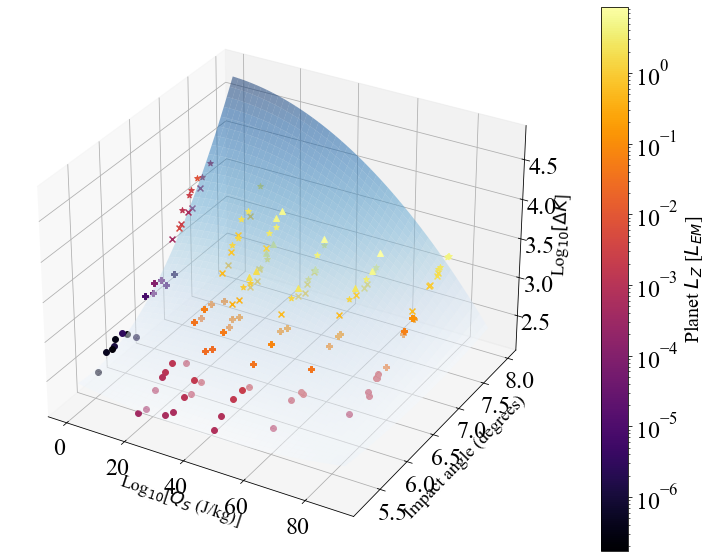

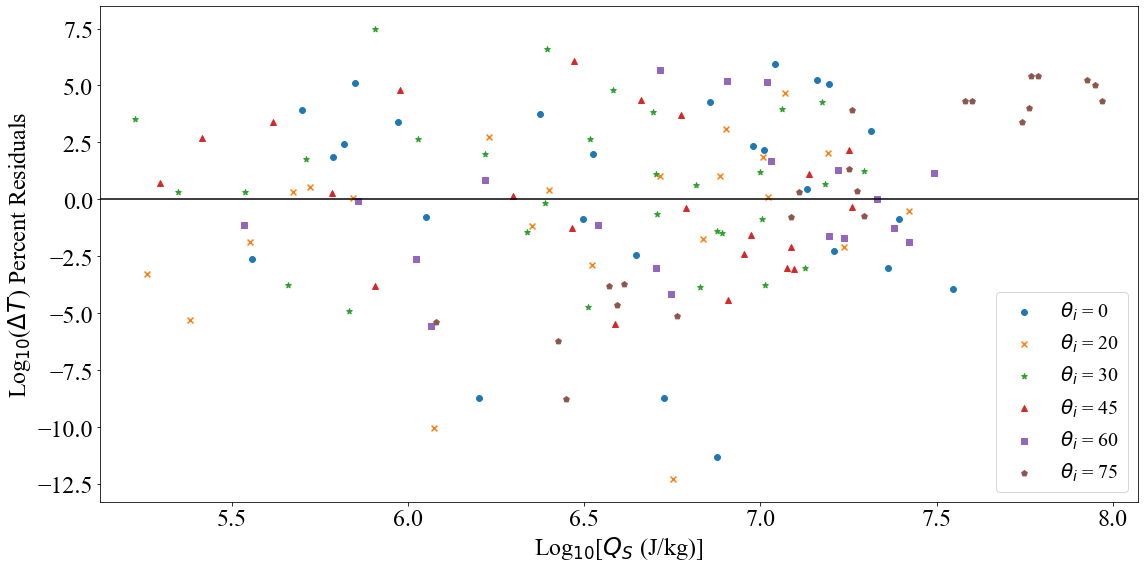

R^2:  0.6987445580690685
Error:  4890.183663789032  K
Percent standard error:  50.27464034205966
log R^2:  0.906823158032121
Error in log-log fit:  1.5259276117058145  K
Error in log-log fit in logK:  0.1835339316644742  K


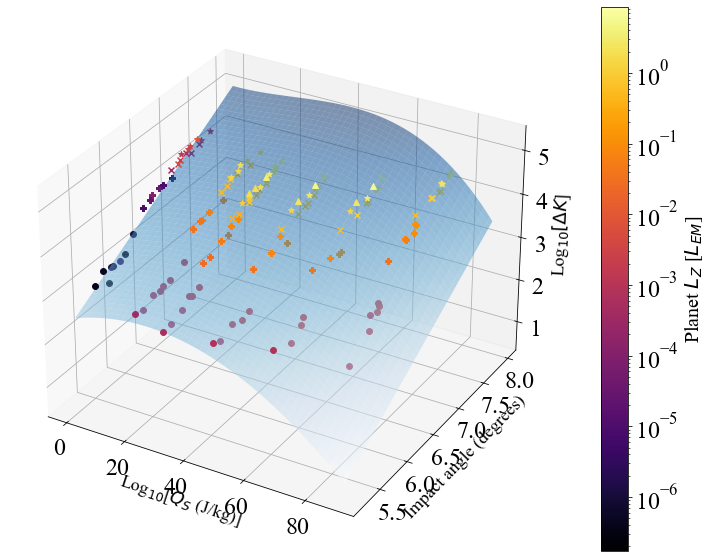

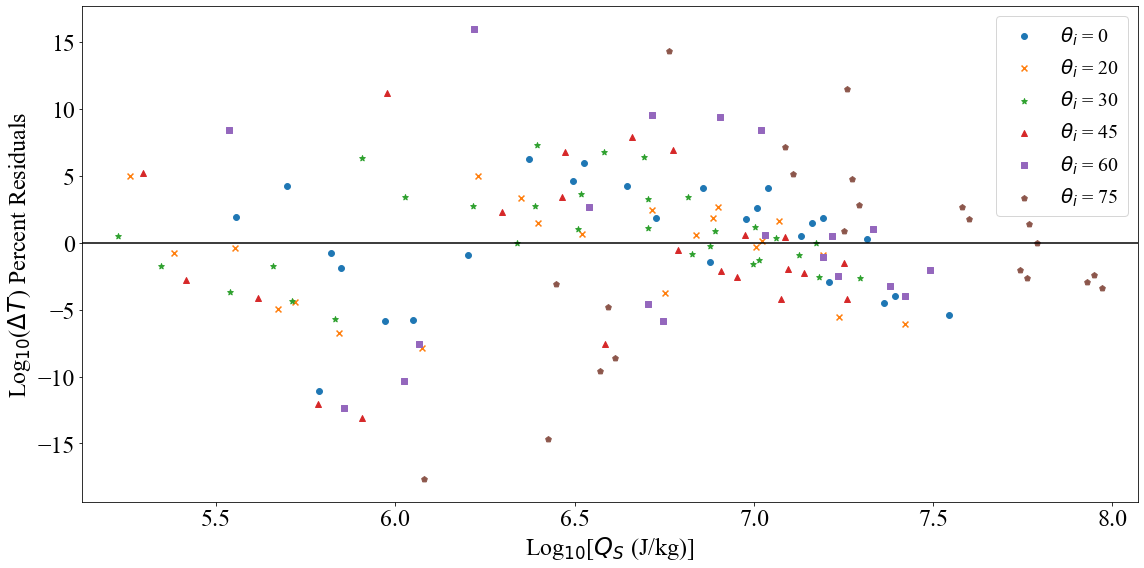

In [61]:
#deltaT_CMB_QS3D([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,fitlist=thetafits)
deltaT_CMB_QS3D([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,fullparams=Tquadfit,residuals=True,savefig='deltaT_mantle0-75')
#deltaT_CMB_QS3D([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,core=True,fitlist=corefits)
deltaT_CMB_QS3D([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,core=True,fullparams=coreTquadfit,residuals=True,savefig='deltaT_core0-75')

In [62]:
def fit_deltaP_CMB(simlistlist,normalize=False):
    allDPs=np.array([])
    allthetas=np.array([])
    allQSs=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        thetas=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            QSs[j] = sim.QS
            allQSs=np.append(allQSs,QSs[j])
            thetas[j] = sim.theta
            allthetas=np.append(allthetas,thetas[j])
            if normalize: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/(sim.M_t/sim.Mbound[-1])/1.e9 #/sim.PCMB0*100
            else: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/1.e9 #/sim.PCMB0*100
            allDPs=np.append(allDPs,DPplanets[j])
    allx=np.stack((np.log10(allQSs),allthetas),axis=-1)
    print(np.shape(allx))
    print(np.shape(allDPs))
    p0=[-1.51035560e-03,9.17692805e-02,-1.25309311e+00,
        2.31485491e-02,-1.41791544e+00,2.02773354e+01,
        -8.87976100e-02,5.48025197e+00,-8.00556575e+01,
        -4.16995470e-03,2.52604924e-01,-2.92760730e+00]
    #print(quadlogfnfull(allx[0],*p0))
    params,extras=curve_fit(quadlogfnfull,allx,allDPs,p0)
    R2=1-np.sum((allDPs-quadlogfnfull(allx,*params))**2)/np.sum((allDPs-np.mean(allDPs))**2)
    print('R^2: ',R2)
    err=np.sqrt(np.sum((allDPs-quadlogfnfull(allx,*params))**2)/np.size(allDPs))
    print('Error: ',err,' GPa')
    idxsmall = np.where(np.abs(allDPs)<err)
    errsmall=np.sqrt(np.sum((allDPs[idxsmall]-quadlogfnfull(allx[idxsmall],*params))**2)/np.size(allDPs[idxsmall]))
    print('Small-value Error: ',errsmall,' GPa')
    idxbig = np.where(np.abs(allDPs)>err)
    errbig=np.sqrt(np.sum((allDPs[idxbig]-quadlogfnfull(allx[idxbig],*params))**2)/np.size(allDPs[idxbig]))
    print('Large-value Error: ',errbig,' GPa')
    
    return params
            
#deltaP_CMB_QS3D(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,fitlist=None):
betterquadfit=fit_deltaP_CMB([accretion010list+partialaccretion010list,accretion20list+partialaccretion20list,accretion30list+partialaccretion30list,accretion45list,accretion60list,accretion75list])    
print(betterquadfit)

(169, 2)
(169,)
R^2:  0.865659324016002
Error:  4.469182955058008  GPa
Small-value Error:  1.9616873753727517  GPa
Large-value Error:  6.024196544736586  GPa
[-6.14401904e-04  2.99993491e-02 -8.11063881e-02  9.47458388e-03
 -4.73584751e-01  2.57852108e+00 -3.68500118e-02  1.88444458e+00
 -1.32787966e+01 -2.33965573e-03  1.25206221e-01 -6.23724837e-01]


In [63]:
def deltaP_CMB_QS3D(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,fitlist=None,fullparams=None,residuals=False,savefig=None):
    if logfit==True:
        logfit=1
    fig = plt.figure(1,figsize=(18,10))#
    ax = plt.axes(projection='3d',computed_zorder=False)
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfits = np.zeros([np.shape(simlistlist)[0],logfit+1])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
        
    QSfield0=np.logspace(np.log10(np.amin(allQS)),np.log10(np.amax(allQS)))
    thetafield0=np.arange(0,90,1)
    QSfield,thetafield = np.meshgrid(QSfield0,thetafield0)
    #thetafield,QSfield = np.meshgrid(thetafield0,QSfield0)
    logQSfield,logthetafield=np.meshgrid(np.log10(QSfield0),thetafield0)
    #logthetafield,logQSfield=np.meshgrid(thetafield0,np.log10(QSfield0))
    if fitlist is not None:
        Z=vquadparams(QSfield,thetafield,fitlist)
        #Z=vquadparams(thetafield,QSfield,fitlist)
    if fullparams is not None:
        Z=vquadlogfnfull(logQSfield,logthetafield,*fullparams)
        #Z=vquadlogfnfull(logthetafield,logQSfield,*fullparams)
        #print(Z)
    
    #Z=np.power(10,vlogdeltaT3D(QSfield,thetafield,fitlist))
    
    #ax.set_zscale('log')
    
    overlist=np.array([])
    allDPs=np.array([])
    allthetas=np.array([])
    allQSs=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        thetas=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if normalize: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/(sim.M_t/sim.Mbound[-1])/1.e9 #/sim.PCMB0*100
            else: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/1.e9 #/sim.PCMB0*100
            thetas[j] = sim.theta
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            allDPs=np.append(allDPs,DPplanets[j])
            allthetas=np.append(allthetas,thetas[j])
            allQSs=np.append(allQSs,QSs[j])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    one=True
                    two=True
                    if (fitlist is not None):
                        if (vquadparams(QSs[j],thetas[j],fitlist)<DPplanets[j]):
                            overlist=np.append(overlist,sim)
                            one=False
                    if (fullparams is not None):
                        if(quadlogfnfull([np.log10(QSs[j]),thetas[j]],*fullparams)<DPplanets[j]):
                            overlist=np.append(overlist,sim)
                            two=False
                    if one&two:
                        ax.scatter(np.log10(QSs[j]),thetas[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                        #ax.scatter(thetas[j],np.log10(QSs[j]),DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    one=True
                    two=True
                    if (fitlist is not None): 
                        if (vquadparams(QSs[j],thetas[j],fitlist)<DPplanets[j]):
                            overlist=np.append(overlist,sim)
                            one=False
                    if (fullparams is not None):
                        if (quadlogfnfull([np.log10(QSs[j]),thetas[j]],*fullparams)<DPplanets[j]):
                            overlist=np.append(overlist,sim)
                            two=False
                    if one&two:
                        ax.scatter(np.log10(QSs[j]),thetas[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                        #ax.scatter(thetas[j],np.log10(QSs[j]),DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        
        if labels is not None:
            #if logfit:
            ax.scatter(np.log10(QSs),thetas,DPplanets,label=labels[i],s=35,marker=marker)
            #ax.scatter(thetas,np.log10(QSs),DPplanets,label=labels[i],s=35,marker=marker)
    if fitlist is not None:
        R2=1-np.sum((allDPs-vquadparams(allQSs,allthetas,fitlist))**2)/np.sum((allDPs-np.mean(allDPs))**2)
        print('R^2: ',R2)
    ax.plot_surface(np.log10(QSfield),thetafield,  Z,alpha=0.5,cmap='Blues')
    #ax.plot_surface(thetafield,np.log10(QSfield),  Z,alpha=0.5,cmap='Blues')
    DTplanets=np.zeros(np.size(overlist))
    DPplanets=np.zeros(np.size(overlist))
    QSs=np.zeros(np.size(overlist))
    Lzs=np.zeros(np.size(overlist))
    thetas=np.zeros(np.size(overlist))
    for j in range(np.size(overlist)):
        sim=overlist[j]
        if markers=='theta':marker=sim.thetamarker
        elif markers=='size':marker=sim.sizemarker
        elif markers=='ratio':marker=sim.ratiomarker
        elif markers=='outcome':marker=sim.outcomemarker
        if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
        if normalize: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/(sim.M_t/sim.Mbound[-1])/1.e9 #/sim.PCMB0*100
        else: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/1.e9 #/sim.PCMB0*100
        thetas[j] = sim.theta
        if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
        else: Lzs[j]=sim.Lzbnd[-1]
        if star:
            QSs[j] = sim.QstarS
            #logallQS=np.append(logallQS,np.log10(sim.QstarS))
        else:
            QSs[j] = sim.QS
            #logallQS=np.append(logallQS,np.log10(sim.QS))
        if labels is None:
            if colors is not None:
                if colors=='Lz':c=Lzs[j]
                if colors=='QS':c=QSs[j]
                ax.scatter(np.log10(QSs[j]),thetas[j],(DPplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                #ax.scatter(thetas[j],np.log10(QSs[j]),(DPplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
            else:
                ax.scatter(np.log10(QSs[j]),thetas[j],(DPplanets[j]),label=sim.label,s=35,marker=marker)
                #ax.scatter(thetas[j],np.log10(QSs[j]),(DPplanets[j]),label=sim.label,s=35,marker=marker)
            count+=1
    
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=20)
            else:cbar.set_label(r'Planet L$_Z$ [$L_{EM}$]',size=20)
        if colors=='QS':cbar.set_label('QS [J]',size=20)
    ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=18)
    ax.set_ylabel('Impact angle (degrees)',size=18)
    #ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel(r'$\Delta$P (GPa)',size=20)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname)
    plt.show()
    
    if residuals:
        fig1,ax1=plt.subplots(1,1,figsize=(16,8))
        for i in range(np.shape(simlistlist)[0]):
            simlist = simlistlist[i]
            Lzs=np.zeros(np.size(simlist))
            QSs=np.zeros(np.size(simlist))
            thetas=np.zeros(np.size(simlist))
            DPplanets=np.zeros(np.size(simlist))
            resids=np.zeros(np.size(simlist))
            for j in range(np.size(simlist)):
                #print(i,j)
                sim=simlist[j]
                marker=sim.thetamarker
                if normalize: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/(sim.M_t/sim.Mbound[-1])/1.e9 #/sim.PCMB0*100
                else: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/1.e9 #/sim.PCMB0*100
                thetas[j] = sim.theta
                QSs[j] = sim.QS
                if (fitlist is not None):
                    resids[j]=((DPplanets[j])-(vquadparams(QSs[j],thetas[j],fitlist)))#/(vquadparams(QSs[j],thetas[j],fitlist)+35)*100
                if (fullparams is not None):
                    resids[j]=((DPplanets[j])-(quadlogfnfull([np.log10(QSs[j]),thetas[j]],*fullparams)))#/(quadlogfnfull([np.log10(QSs[j]),thetas[j]],*fullparams)+35)*100
                
            ax1.scatter(np.log10(QSs),resids,s=35,marker=marker,label=r'$\theta_i$ = %g'%sim.theta)
        ax1.hlines(0,np.amin(np.log10(allQSs))-0.5,np.amax(np.log10(allQSs))+0.5,color='black')
        ax1.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=24)
        ax1.set_xlim(np.amin(np.log10(allQSs))-0.1,np.amax(np.log10(allQSs))+0.1)
        ax1.set_ylabel(r'$\Delta P$ [GPa] Residuals',size=24)
        ax1.legend(fontsize=20)
        plt.tight_layout()
        if savefig is not None:
            imname=savefig+'_residuals.pdf'
            plt.savefig(imname)
    plt.show()

R^2:  -10873268381.350824


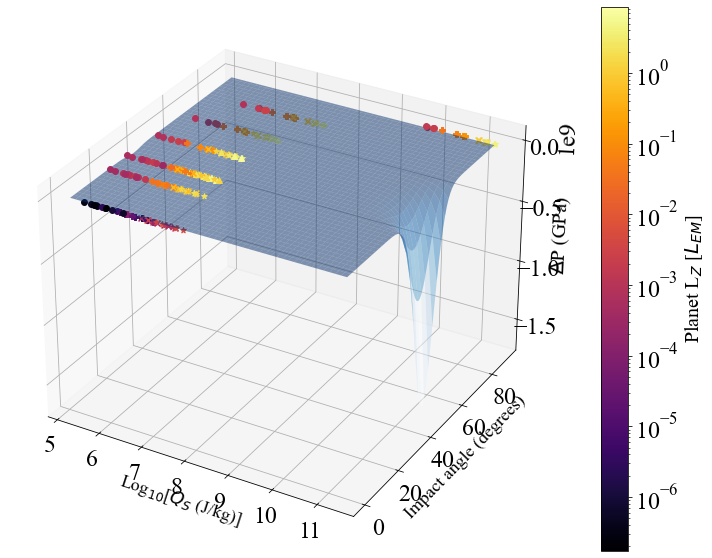

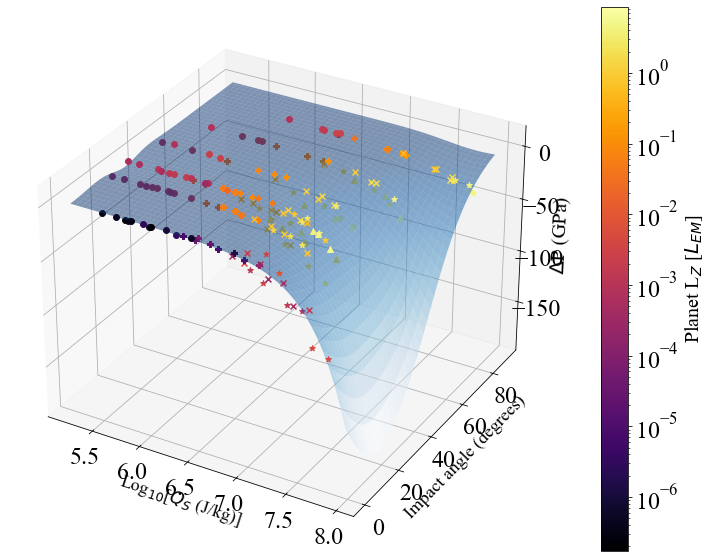

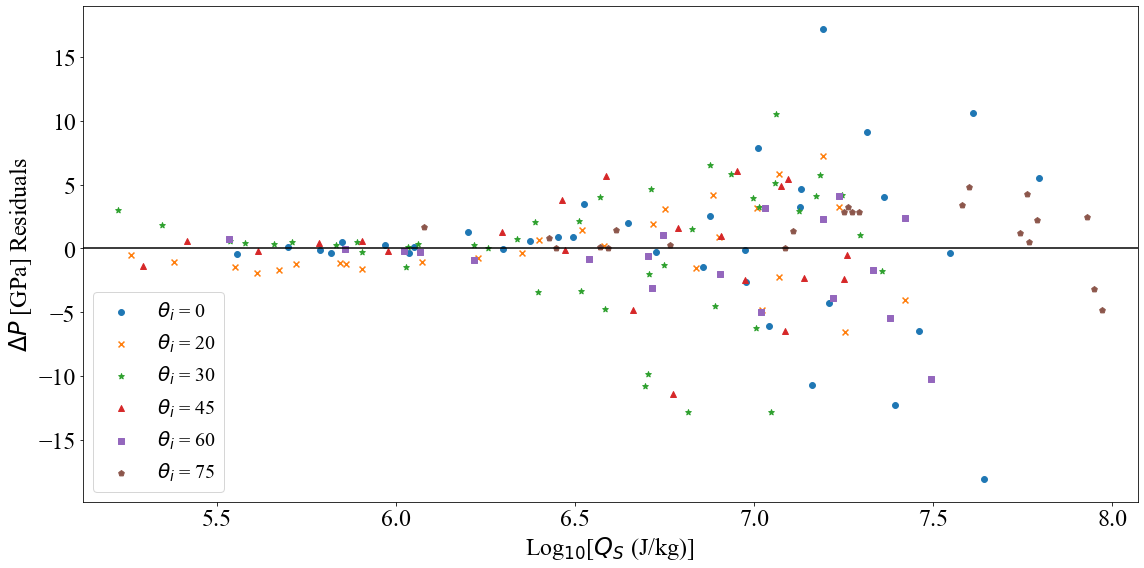

In [64]:
%matplotlib inline
deltaP_CMB_QS3D([accretion010list+partialaccretion010list,accretion20list+partialaccretion20list,accretion30list+partialaccretion30list,accretion45list,accretion60list,accretion75list,accretion897list],labels=None,colors='Lz',legend=False,markers='size',fitlist=quadlogfit)
deltaP_CMB_QS3D([accretion010list+partialaccretion010list,accretion20list+partialaccretion20list,accretion30list+partialaccretion30list,accretion45list,accretion60list,accretion75list],labels=None,colors='Lz',legend=False,markers='size',fullparams=betterquadfit,residuals=True,savefig='deltaP_0-75')

### Hit-and-run data by angle

In [ ]:
dPT_rubie([hitandrun20list],labels=None,colors='QS',legend=False,markers='size')
dPT_rubie([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size')
dPT_rubie([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPT_CMB([hitandrun20list],labels=None,colors='QS',legend=False,markers='size')
dPT_CMB([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size')
dPT_CMB([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_rubie_QS([hitandrun20list],labels=None,colors='QS',legend=False,markers='size')
T_rubie_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size')
T_rubie_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size')
T_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,loglog=True,markers='size')
T_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,loglog=True,markers='size',Lzstar=True)
dT_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',logfit=2)
dT_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',logfit=2,normalize=True)
dT_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
#dT_CMB_QS([accretion20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',normalize=True)
#dT_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_QS([hitandrun20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=2)
dT_CMB_QS([hitandrun20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=1)
deltaT_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',logfit=2)
deltaT_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
deltaT_CMB_QS([hitandrun20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=2)
deltaT_CMB_QS([hitandrun20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=1)
dT_CMB_Lz([hitandrun20list],labels=None,colors='QS',legend=False,markers='size',logfit=2)
dT_CMB_Lz([hitandrun20list],labels=None,colors='QS',loglog=True,legend=False,markers='size')
dT_CMB_Lz([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dT_CMB_Lz([hitandrun20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=2)
T_core_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size')
T_core_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',loglog=True)
P_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',loglog=True,Lzstar=True)
dP_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size')
dP_CMB_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_scaled_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_scaled_QS([hitandrun20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
S_CMB_QS([hitandrun20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
S_CMB_QS([hitandrun20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
M_RCMB([hitandrun20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
M_RCMB([hitandrun20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
Pcore_M([hitandrun20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
Pcore_M([hitandrun20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
mant_misc_QS([hitandrun20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
mant_misc_QS([hitandrun20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
QS_Lz([hitandrun20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
QS_Lz([hitandrun20list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=True)

In [ ]:
dPT_rubie([hitandrun30list],labels=None,colors='QS',legend=False,markers='size')
dPT_rubie([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size')
dPT_rubie([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPT_CMB([hitandrun30list],labels=None,colors='QS',legend=False,markers='size')
dPT_CMB([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size')
dPT_CMB([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_rubie_QS([hitandrun30list],labels=None,colors='QS',legend=False,markers='size')
T_rubie_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size')
T_rubie_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size')
T_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,loglog=True,markers='size')
T_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,loglog=True,markers='size',Lzstar=True)
dT_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',logfit=2)
dT_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',logfit=2,normalize=True)
dT_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
#dT_CMB_QS([accretion20list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',normalize=True)
#dT_CMB_QS([accretion20list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_QS([hitandrun30list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=2)
dT_CMB_QS([hitandrun30list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=1)
deltaT_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',logfit=2)
deltaT_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
deltaT_CMB_QS([hitandrun30list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=2)
deltaT_CMB_QS([hitandrun30list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=1)
dT_CMB_Lz([hitandrun30list],labels=None,colors='QS',legend=False,markers='size',logfit=2)
dT_CMB_Lz([hitandrun30list],labels=None,colors='QS',loglog=True,legend=False,markers='size')
dT_CMB_Lz([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dT_CMB_Lz([hitandrun30list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=2)
T_core_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size')
T_core_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',loglog=True)
P_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',loglog=True,Lzstar=True)
dP_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size')
dP_CMB_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dP_CMB_Lz([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size')
dP_CMB_Lz([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
#P_CMB_scaled_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size')
#P_CMB_scaled_QS([hitandrun30list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
S_CMB_QS([hitandrun30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
S_CMB_QS([hitandrun30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
M_RCMB([hitandrun30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
M_RCMB([hitandrun30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
Pcore_M([hitandrun30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
Pcore_M([hitandrun30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
mant_misc_QS([hitandrun30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
mant_misc_QS([hitandrun30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
QS_Lz([hitandrun30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
QS_Lz([hitandrun30list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=True)

In [ ]:
dPT_rubie([hitandrun45list],labels=None,colors='QS',legend=False,markers='size')
dPT_rubie([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size')
dPT_rubie([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dPT_CMB([hitandrun45list],labels=None,colors='QS',legend=False,markers='size')
dPT_CMB([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size')
dPT_CMB([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_rubie_QS([hitandrun45list],labels=None,colors='QS',legend=False,markers='size')
T_rubie_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size')
T_rubie_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_rubie_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size')
P_rubie_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size')
T_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
T_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,loglog=True,markers='size')
T_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,loglog=True,markers='size',Lzstar=True)
dT_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',logfit=2)
dT_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',logfit=2,normalize=True)
dT_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
#dT_CMB_QS([accretio450list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',normalize=True)
#dT_CMB_QS([accretio450list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True)
dT_CMB_QS([hitandrun45list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=2)
dT_CMB_QS([hitandrun45list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=1)
deltaT_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',logfit=2)
deltaT_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',logfit=1)
deltaT_CMB_QS([hitandrun45list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=2)
deltaT_CMB_QS([hitandrun45list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=1)
dT_CMB_Lz([hitandrun45list],labels=None,colors='QS',legend=False,markers='size',logfit=2)
dT_CMB_Lz([hitandrun45list],labels=None,colors='QS',loglog=True,legend=False,markers='size')
dT_CMB_Lz([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
dT_CMB_Lz([hitandrun45list],labels=None,colors='Lz',loglog=True,legend=False,markers='size',Lzstar=True,logfit=2)
T_core_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size')
T_core_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',loglog=True)
P_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',loglog=True,Lzstar=True)
dP_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size')
dP_CMB_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
P_CMB_scaled_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size')
P_CMB_scaled_QS([hitandrun45list],labels=None,colors='Lz',legend=False,markers='size',Lzstar=True)
S_CMB_QS([hitandrun45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
S_CMB_QS([hitandrun45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
M_RCMB([hitandrun45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
M_RCMB([hitandrun45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
Pcore_M([hitandrun45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
Pcore_M([hitandrun45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
mant_misc_QS([hitandrun45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size')
mant_misc_QS([hitandrun45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True)
QS_Lz([hitandrun45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,logfit=True)
QS_Lz([hitandrun45list],labels=None,loglog=True,colors='Lz',legend=False,markers='size',Lzstar=True,normalize=True,logfit=True)

In [ ]:
dPT_rubie([hitandrun60list],labels=None,colors='QS',legend=False,markers='ratio',fP=.73)
dPT_rubie([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',fP=.73)
dPT_rubie([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',Lzstar=True,fP=.73)
dPT_CMB([hitandrun60list],labels=None,colors='QS',legend=False,markers='ratio')
dPT_CMB([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio')
dPT_CMB([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',Lzstar=True)
T_rubie_QS([hitandrun60list],labels=None,colors='QS',legend=False,markers='ratio',fP=.73)
T_rubie_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',fP=.73)
T_rubie_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',Lzstar=True,fP=.73)
P_rubie_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio')
P_rubie_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',Lzstar=True)
T_CMB_QS([hitandrun60list],labels=None,legend=True)
T_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio')
T_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',Lzstar=True)
T_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,loglog=True,markers='ratio')
T_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,loglog=True,markers='ratio',Lzstar=True)
dT_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',logfit=2)
dT_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',logfit=2,normalize=True)
dT_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',logfit=1)
#dT_CMB_QS([accretio450list],labels=None,colors='Lz',loglog=True,legend=False,markers='ratio',normalize=True)
#dT_CMB_QS([accretio450list],labels=None,colors='Lz',legend=False,markers='ratio',Lzstar=True,normalize=True)
dT_CMB_QS([hitandrun60list],labels=None,colors='Lz',loglog=True,legend=False,markers='ratio',Lzstar=True,logfit=2)
dT_CMB_QS([hitandrun60list],labels=None,colors='Lz',loglog=True,legend=False,markers='ratio',Lzstar=True,logfit=1)
deltaT_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',logfit=2)
deltaT_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',logfit=1)
deltaT_CMB_QS([hitandrun60list],labels=None,colors='Lz',loglog=True,legend=False,markers='ratio',Lzstar=True,logfit=2)
deltaT_CMB_QS([hitandrun60list],labels=None,colors='Lz',loglog=True,legend=False,markers='ratio',Lzstar=True,logfit=1)
dT_CMB_Lz([hitandrun60list],labels=None,colors='QS',legend=False,markers='ratio',logfit=2)
dT_CMB_Lz([hitandrun60list],labels=None,colors='QS',loglog=True,legend=False,markers='ratio')
dT_CMB_Lz([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',Lzstar=True)
dT_CMB_Lz([hitandrun60list],labels=None,colors='Lz',loglog=True,legend=False,markers='ratio',Lzstar=True,logfit=2)
T_core_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio')
T_core_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',Lzstar=True)
P_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio')
P_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',normalize=True)
P_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',loglog=True)
P_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',loglog=True,normalize=True)
P_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',Lzstar=True)
P_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',loglog=True,Lzstar=True)
dP_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio')
dP_CMB_QS([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',Lzstar=True)
dP_CMB_Lz([hitandrun60list],labels=None,colors='QS',legend=False,markers='ratio')
dP_CMB_Lz([hitandrun60list],labels=None,colors='Lz',legend=False,markers='ratio',Lzstar=True)
S_CMB_QS([hitandrun60list],labels=None,loglog=True,colors='Lz',legend=False,markers='ratio')
S_CMB_QS([hitandrun60list],labels=None,loglog=True,colors='Lz',legend=False,markers='ratio',Lzstar=True)
M_RCMB([hitandrun60list],labels=None,loglog=True,colors='Lz',legend=False,markers='ratio')
M_RCMB([hitandrun60list],labels=None,loglog=True,colors='Lz',legend=False,markers='ratio',Lzstar=True)
Pcore_M([hitandrun60list],labels=None,loglog=True,colors='Lz',legend=False,markers='ratio')
Pcore_M([hitandrun60list],labels=None,loglog=True,colors='Lz',legend=False,markers='ratio',Lzstar=True)
mant_misc_QS([hitandrun60list],labels=None,loglog=True,colors='Lz',legend=False,markers='ratio')
mant_misc_QS([hitandrun60list],labels=None,loglog=True,colors='Lz',legend=False,markers='ratio',Lzstar=True)
QS_Lz([hitandrun60list],labels=None,loglog=True,colors='Lz',legend=False,markers='ratio',Lzstar=True,logfit=True)
QS_Lz([hitandrun60list],labels=None,loglog=True,colors='Lz',legend=False,markers='ratio',Lzstar=True,normalize=True,logfit=True)

### QS data by angle, Lz and QS colors, with HNR
2
'o'=0 degrees, 
3
'+'=10,
4
'x'=20,
5
'\*'=30,
6
'^'=45,
7
's'=60

In [ ]:
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='theta')
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta')
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dPT_CMB([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='theta')
dPT_CMB([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta')
dPT_CMB([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='theta')
T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta')
T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta')
P_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta')
T_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dT_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta')
dT_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_core_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta')
T_core_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta')
P_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dP_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta')
dP_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
S_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta')
S_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
M_RCMB([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta')
M_RCMB([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
Pcore_M([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta')
Pcore_M([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
mant_misc_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta')
mant_misc_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
QS_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)

### QS data by angle, Lz and QS colors, no HNR
'o'=0 degrees, 
'+'=10,
'x'=20,
'\*'=30,
'^'=45,
's'=60

In [ ]:
dPT_rubie([accretionlist,partialaccretionlist],labels=None,colors='QS',legend=False,markers='theta')
dPT_rubie([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta')
dPT_rubie([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dPT_CMB([accretionlist,partialaccretionlist],labels=None,colors='QS',legend=False,markers='theta')
dPT_CMB([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta')
dPT_CMB([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='QS',legend=False,markers='theta')
T_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta')
T_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta')
P_rubie_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta')
T_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dT_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta')
dT_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_core_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta')
T_core_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta')
P_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dP_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta')
dP_CMB_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_CMB_scaled_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta')
P_CMB_scaled_QS([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
rho_CMB_QS([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta')
S_CMB_QS([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta')
S_CMB_QS([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
M_RCMB([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta')
M_RCMB([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
Pcore_M([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta')
Pcore_M([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
mant_misc_QS([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta')
mant_misc_QS([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
QS_Lz([accretionlist,partialaccretionlist],labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)

### Moon QS data:

In [ ]:
QS_u_planet(moonlists,labels=moonlabels)
QS_u_mantle(moonlists,labels=moonlabels)
QS_u_core(moonlists,labels=moonlabels)
QS_u_fraction(moonlists,labels=moonlabels)
QS_u_massfraction(moonlists,labels=moonlabels)
QS_u_planetmass(moonlists,labels=moonlabels)
QS_u_xi(moonlists,labels=moonlabels)
#QS_u_scaled_xi(moonlists,labels=moonlabels,arctanfit=True,erfcfit=True)
#QS_u_scaled_xi([moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list],labels=None)
#QS_u_scaled_xi([moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list],labels=None)
#QS_u_scaled_xi([moon01x0017th30list,moon01x0017th45list,moon01x0017th60list],labels=None)
accretion_eff(moonlists,labels=moonlabels)
QS_u_scaled_planetmass(moonlists,labels=moonlabels)
dPT_rubie(moonlists,labels=None,colors='QS',legend=False,markers='theta')
dPT_rubie(moonlists,labels=None,colors='Lz',legend=False,markers='outcome')
dPT_rubie(moonlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dPT_CMB(moonlists,labels=None,colors='QS',legend=False,markers='theta')
dPT_CMB(moonlists,labels=None,colors='Lz',legend=False,markers='outcome')
dPT_CMB(moonlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_rubie_QS(moonlists,labels=None,colors='Lz',legend=False,markers='outcome')
T_rubie_QS(moonlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_rubie_QS(moonlists,labels=None,colors='Lz',legend=False,markers='outcome')
P_rubie_QS(moonlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_CMB_QS(moonlists,labels=None,colors='Lz',legend=False,markers='outcome')
T_CMB_QS(moonlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dT_CMB_QS(moonlists,labels=None,colors='Lz',legend=False,markers='outcome')
dT_CMB_QS(moonlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_core_CMB_QS(moonlists,labels=None,colors='Lz',legend=False,markers='outcome')
T_core_CMB_QS(moonlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_CMB_QS(moonlists,labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_QS(moonlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dP_CMB_QS(moonlists,labels=None,colors='Lz',legend=False,markers='outcome')
dP_CMB_QS(moonlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_CMB_scaled_QS(moonlists,labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_scaled_QS(moonlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
S_CMB_QS(moonlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
S_CMB_QS(moonlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
M_RCMB(moonlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
M_RCMB(moonlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
Pcore_M(moonlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
Pcore_M(moonlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
mant_misc_QS(moonlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
mant_misc_QS(moonlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
QS_Lz(moonlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
QS_Lz(moonlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)

### Mars QS data:

In [ ]:
QS_u_planet(marslists,labels=marslabels)
QS_u_mantle(marslists,labels=marslabels)
QS_u_core(marslists,labels=marslabels)
QS_u_fraction(marslists,labels=marslabels)
QS_u_massfraction(marslists,labels=marslabels)
QS_u_planetmass(marslists,labels=marslabels)
QS_u_xi(marslists,labels=marslabels)
#QS_u_scaled_xi(marslists,labels=marslabels,arctanfit=True,erfcfit=True)
accretion_eff(marslists,labels=marslabels)
QS_u_scaled_planetmass(marslists,labels=marslabels)
dPT_rubie(marslists,labels=None,colors='QS',legend=False,markers='theta')
dPT_rubie(marslists,labels=None,colors='Lz',legend=False,markers='outcome')
dPT_rubie(marslists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dPT_CMB(marslists,labels=None,colors='QS',legend=False,markers='theta')
dPT_CMB(marslists,labels=None,colors='Lz',legend=False,markers='outcome')
dPT_CMB(marslists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_rubie_QS(marslists,labels=None,colors='Lz',legend=False,markers='outcome')
T_rubie_QS(marslists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_rubie_QS(marslists,labels=None,colors='Lz',legend=False,markers='outcome')
P_rubie_QS(marslists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_CMB_QS(marslists,labels=None,colors='Lz',legend=False,markers='outcome')
T_CMB_QS(marslists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dT_CMB_QS(marslists,labels=None,colors='Lz',legend=False,markers='outcome')
dT_CMB_QS(marslists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_core_CMB_QS(marslists,labels=None,colors='Lz',legend=False,markers='outcome')
T_core_CMB_QS(marslists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_CMB_QS(marslists,labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_QS(marslists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dP_CMB_QS(marslists,labels=None,colors='Lz',legend=False,markers='outcome')
dP_CMB_QS(marslists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_CMB_scaled_QS(marslists,labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_scaled_QS(marslists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
S_CMB_QS(marslists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
S_CMB_QS(marslists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
M_RCMB(marslists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
M_RCMB(marslists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
Pcore_M(marslists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
Pcore_M(marslists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
mant_misc_QS(marslists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
mant_misc_QS(marslists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
QS_Lz(marslists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
QS_Lz(marslists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)

### Halfearth QS data:

In [ ]:
QS_u_planet(halfearthlists,labels=halfearthlabels)
QS_u_mantle(halfearthlists,labels=halfearthlabels)
QS_u_core(halfearthlists,labels=halfearthlabels)
QS_u_fraction(halfearthlists,labels=halfearthlabels)
QS_u_massfraction(halfearthlists,labels=halfearthlabels)
QS_u_planetmass(halfearthlists,labels=halfearthlabels)
QS_u_xi(halfearthlists,labels=halfearthlabels)
#QS_u_scaled_xi(halfearthlists,labels=halfearthlabels,arctanfit=True,erfcfit=True)
accretion_eff(halfearthlists,labels=halfearthlabels)
QS_u_scaled_planetmass(halfearthlists,labels=halfearthlabels)
dPT_rubie(halfearthlists,labels=None,colors='QS',legend=False,markers='theta')
dPT_rubie(halfearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
dPT_rubie(halfearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dPT_CMB(halfearthlists,labels=None,colors='QS',legend=False,markers='theta')
dPT_CMB(halfearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
dPT_CMB(halfearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_rubie_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
T_rubie_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_rubie_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
P_rubie_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_CMB_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
T_CMB_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dT_CMB_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
dT_CMB_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_core_CMB_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
T_core_CMB_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_CMB_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dP_CMB_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
dP_CMB_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_CMB_scaled_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_scaled_QS(halfearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
S_CMB_QS(halfearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
S_CMB_QS(halfearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
M_RCMB(halfearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
M_RCMB(halfearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
Pcore_M(halfearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
Pcore_M(halfearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
mant_misc_QS(halfearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
mant_misc_QS(halfearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
QS_Lz(halfearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
QS_Lz(halfearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)

### Protoearth QS data:

In [ ]:
QS_u_planet(protoearthlists,labels=protoearthlabels)
QS_u_mantle(protoearthlists,labels=protoearthlabels)
QS_u_core(protoearthlists,labels=protoearthlabels)
QS_u_fraction(protoearthlists,labels=protoearthlabels)
QS_u_massfraction(protoearthlists,labels=protoearthlabels)
QS_u_planetmass(protoearthlists,labels=protoearthlabels)
QS_u_xi(protoearthlists,labels=protoearthlabels)
#QS_u_scaled_xi(protoearthlists,labels=protoearthlabels,arctanfit=True,erfcfit=True)
accretion_eff(protoearthlists,labels=protoearthlabels)
QS_u_scaled_planetmass(protoearthlists,labels=protoearthlabels)
dPT_rubie(protoearthlists,labels=None,colors='QS',legend=False,markers='theta')
dPT_rubie(protoearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
dPT_rubie(protoearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dPT_CMB(protoearthlists,labels=None,colors='QS',legend=False,markers='theta')
dPT_CMB(protoearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
dPT_CMB(protoearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_rubie_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
T_rubie_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_rubie_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
P_rubie_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_CMB_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
T_CMB_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dT_CMB_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
dT_CMB_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
T_core_CMB_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
T_core_CMB_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_CMB_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
dP_CMB_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
dP_CMB_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
P_CMB_scaled_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='outcome')
P_CMB_scaled_QS(protoearthlists,labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
S_CMB_QS(protoearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
S_CMB_QS(protoearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
M_RCMB(protoearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
M_RCMB(protoearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
Pcore_M(protoearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
Pcore_M(protoearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
mant_misc_QS(protoearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome')
mant_misc_QS(protoearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)
QS_Lz(protoearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='outcome',Lzstar=True)
QS_Lz(protoearthlists,labels=None,loglog=True,colors='Lz',legend=False,markers='theta',Lzstar=True)

### Accretionary data:

In [ ]:
QS_u_planet([accretionlist],labels=None,loglog=True)
QS_u_mantle([accretionlist],labels=None,loglog=True)
QS_u_core([accretionlist],labels=None,loglog=True)
QS_u_core_mantle([accretionlist],labels=None,loglog=True,logfit=True)
QS_uPGPE_core_mantle([accretionlist],labels=None,loglog=True,logfit=True)
QS_u_mantle_fraction([accretionlist],labels=None)
QS_u_core_fraction([accretionlist],labels=None)
QS_u_core_mantle_fraction([accretionlist],labels=None)
QS_u_fraction([accretionlist],labels=None)
QS_u_massfraction([accretionlist],labels=None,loglog=True)
QS_u_planetmass([accretionlist],labels=None)
QS_u_xi([accretionlist],labels=None)
#QS_u_scaled_xi([accretionlist],labels=None)
accretion_eff([accretionlist],labels=None)
QS_u_scaled_planetmass([accretionlist],labels=None)
u_xi([accretionlist],labels=None,loglog=True)
u_accretion_eff([accretionlist],labels=None,loglog=True)
u_bound_mass([accretionlist],labels=None,loglog=True,logfit=True)
u_core_mantle_bound_mass([accretionlist],labels=None,loglog=True,logfit=True)
uPGPE_core_mantle_bound_mass([accretionlist],labels=None,loglog=True,logfit=True)
PGPE_core_mantle_bound_mass([accretionlist],labels=None,loglog=True,logfit=True)
u_plus_PGPE_core_mantle_bound_mass([accretionlist],labels=None,loglog=True,logfit=True)
#QS_delta_u_planet([accretionlist],labels=None,loglog=True)
dPT_rubie([accretionlist],labels=None)
T_rubie_QS([accretionlist])
S_CMB_QS([accretionlist],labels=None,loglog=True)
P_CMB_QS([accretionlist],labels=None)
dP_CMB_QS([accretionlist],labels=None)
P_CMB_core([accretionlist],labels=None,loglog=True)
PTrubie_plot([accretionlist],labels=None)
M_RCMB([accretionlist],labels=None,loglog=True)

In [ ]:
QS_u_planet([accretionlistno0],labels=None,loglog=True)
QS_u_mantle([accretionlistno0],labels=None,loglog=True)
QS_u_core([accretionlistno0],labels=None,loglog=True)
QS_u_core_mantle([accretionlistno0],labels=None,loglog=True,logfit=True)
#QS_u_core_mantle_0([accretionlistno0],labels=None,loglog=True,logfit=True)
QS_u_mantle_fraction([accretionlistno0],labels=None)
QS_u_core_fraction([accretionlistno0],labels=None)
QS_u_core_mantle_fraction([accretionlistno0],labels=None,savefig='IE_core_mant_no0')
QS_u_fraction([accretionlistno0],labels=None)
QS_u_massfraction([accretionlistno0],labels=None,loglog=True)
QS_u_planetmass([accretionlistno0],labels=None)
QS_u_xi([accretionlistno0],labels=None)
#QS_u_scaled_xi([accretionlistno0],labels=None)
accretion_eff([accretionlistno0],labels=None)
QS_u_scaled_planetmass([accretionlistno0],labels=None)
u_xi([accretionlistno0],labels=None,loglog=True)
u_accretion_eff([accretionlistno0],labels=None,loglog=True)
u_bound_mass([accretionlistno0],labels=None,loglog=False,logfit=True)
u_core_mantle_bound_mass([accretionlistno0],labels=None,loglog=True,logfit=True)
uPGPE_core_mantle_bound_mass([accretionlistno0],labels=None,loglog=True,logfit=True)
PGPE_core_mantle_bound_mass([accretionlistno0],labels=None,loglog=True,logfit=True)
u_plus_PGPE_core_mantle_bound_mass([accretionlistno0],labels=None,loglog=True,logfit=True)
#u_plus_PGPE_core_mantle_bound_mass([accretionlistno0],labels=None,loglog=True,logfit=True)
#QS_delta_u_planet([accretionlist],labels=None,loglog=True)
dPT_rubie([accretionlistno0],labels=None)
T_rubie_QS([accretionlistno0])
S_CMB_QS([accretionlistno0],labels=None,loglog=True)
P_CMB_QS([accretionlistno0],labels=None)
P_CMB_core([accretionlistno0],labels=None,loglog=True)
PTrubie_plot([accretionlistno0],labels=None)
M_RCMB([accretionlistno0],labels=None,loglog=True)

In [ ]:
QS_u_core_mantle([accretion010list],labels=None,loglog=True,logfit=True)
#QS_u_core_mantle_0([accretion010list],labels=None,loglog=True,logfit=True)
QS_u_core_mantle_fraction([accretion010list],labels=None,savefig='QS_core_mant_010')
u_core_mantle_bound_mass([accretion010list],labels=None,loglog=True,logfit=True,savefig='QS_IE_acc010')
u_plus_PGPE_core_mantle_bound_mass([accretion010list],labels=None,loglog=True,logfit=True)

In [ ]:
QS_u_core_mantle([accretion20list,accretion30list,accretion45list,accretion60list],labels=None,loglog=True,logfit=True)
#QS_u_core_mantle_0([accretion010list],labels=None,loglog=True,logfit=True)
QS_u_core_mantle_fraction([accretion20list,accretion30list,accretion45list,accretion60list],labels=None)
u_core_mantle_bound_mass([accretion20list,accretion30list,accretion45list,accretion60list],labels=None,loglog=True,logfit=True,savefig='QS_IE_acc20-60')
u_plus_PGPE_core_mantle_bound_mass([accretion20list,accretion30list,accretion45list,accretion60list],labels=None,loglog=True,logfit=True,savefig='QS_IE_PGPE_acc20-60')

In [ ]:
QS_u_mantle([accretion75list],labels=None,loglog=True,logfit=True)
QS_u_core_mantle([accretion75list],labels=None,loglog=True,logfit=True)
#QS_u_core_mantle_0([accretion010list],labels=None,loglog=True,logfit=True)
QS_u_core_mantle_fraction([accretion75list],labels=None)
u_core_mantle_bound_mass([accretion75list],labels=None,loglog=True,logfit=True,savefig='QS_IE_acc75')
#u_plus_PGPE_core_mantle_bound_mass([accretion010list],labels=None,loglog=True,logfit=True)

In [ ]:
QS_u_mantle([accretion897list],labels=None,loglog=True,logfit=True)
QS_u_core_mantle([accretion897list],labels=None,loglog=True,logfit=True)
#QS_u_core_mantle_0([accretion010list],labels=None,loglog=True,logfit=True)
QS_u_core_mantle_fraction([accretion897list],labels=None)
u_core_mantle_bound_mass([accretion897list],labels=None,loglog=True,logfit=True,savefig='QS_IE_acc897')
#u_plus_PGPE_core_mantle_bound_mass([accretion010list],labels=None,loglog=True,logfit=True)

### Accretion data by target size:

In [ ]:
QS_u_planet([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True,markers='theta')
QS_u_mantle([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True)
QS_u_core([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True)
QS_u_fraction([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels)
QS_u_massfraction([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels)
QS_u_planetmass([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels)
QS_u_xi([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels)
accretion_eff([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels)
QS_u_scaled_planetmass([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels)
u_xi([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True)
u_accretion_eff([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True)
u_bound_mass([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True,logfit=1)
u_mantle_bound_mass([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True,logfit=1)
u_core_bound_mass([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True,logfit=1)
scaled_u_bound_mass([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True,logfit=1)
T_CMB_QS([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True)
T_core_CMB_QS([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True)
dPT_rubie([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels)
T_rubie_QS([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels)
PTrubie_plot([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels)
M_RCMB([moonaccretionlist,marsaccretionlist,halfearthaccretionlist,protoearthaccretionlist],labels=sizelabels,loglog=True)

### Accretion data by impact angle:

In [ ]:
QS_u_planet([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels,loglog=True)
QS_u_mantle([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels,loglog=True)
QS_u_core([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels,loglog=True)
QS_u_fraction([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels)
QS_u_massfraction([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels,loglog=True)
QS_u_planetmass([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels)
QS_u_xi([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels)
accretion_eff([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels)
QS_u_scaled_planetmass([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels)
u_xi([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels,loglog=True)
u_accretion_eff([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels,loglog=True)

### Hit and run data:

In [ ]:
QS_u_planet([hitandrunlist],labels=None,loglog=True,logfit=1)
QS_u_mantle([hitandrunlist],labels=None,loglog=True,logfit=1)
QS_u_core([hitandrunlist],labels=None,loglog=True,logfit=1)
QS_u_core_mantle([hitandrunlist],labels=None,loglog=True,logfit=1)
QS_u_mantle_fraction([hitandrunlist],labels=None)
QS_u_core_fraction([hitandrunlist],labels=None)
QS_u_core_mantle_fraction([hitandrunlist],labels=None,savefig='IE_core_mant_hnr')
QS_u_mantle_gain([hitandrunlist],labels=None,loglog=True)
QS_u_core_gain([hitandrunlist],labels=None,loglog=True)
QS_u_fraction([hitandrunlist],labels=None)
QS_u_massfraction([hitandrunlist],labels=None)
QS_u_planetmass([hitandrunlist],labels=None)
QS_u_xi([hitandrunlist],labels=None)
QS_u_scaled_xi([hitandrunlist],labels=None)
accretion_eff([hitandrunlist],labels=None)
QS_u_scaled_planetmass([hitandrunlist],loglog=True,labels=None)
u_bound_mass([hitandrunlist],labels=None)
u_plus_PGPE_core_mantle_bound_mass([hitandrunlist],labels=None,loglog=True,logfit=True)
PTrubie_plot([hitandrunlist])
dPT_rubie([hitandrunlist])
T_rubie_QS([hitandrunlist])
T_core_CMB_QS([hitandrunlist],markers='size')

In [ ]:
QS_u_core_mantle([hitandrun20list,hitandrun30list,hitandrun45list,hitandrun60list],labels=None,loglog=True,logfit=1,savefig='QS_IE_hnr20-60')

In [ ]:
print('0: ',np.sin(0*np.pi/180))
print('10: ',np.sin(10*np.pi/180))
print('20: ',np.sin(20*np.pi/180))
print('30: ',np.sin(30*np.pi/180))
print('45: ',np.sin(45*np.pi/180))
print('60: ',np.sin(60*np.pi/180))

In [ ]:
pdt_arr=np.array([[0.0, 1706.3],
             [0.1, 1706.319],
             [2.3522, 1706.3197],
             [2.7285, 1780.6691],
             [3.4812, 1862.9846],
             [4.2339, 1939.9893],
             [5.1747, 2009.0281],
             [6.3038, 2088.6883],
             [7.621, 2157.7269],
             [9.0323, 2221.4551],
             [10.7258, 2269.2511],
             [12.9839, 2303.7706],
             [15.1478, 2322.3578],
             [16.1828, 2364.8433],
             [17.1237, 2402.0181],
             [18.1586, 2407.3287],
             [19.8521, 2409.9841],
             [21.5457, 2417.9501],
             [22.7688, 2441.8481],
             [23.8978, 2473.7122],
             [30.9543, 2648.9644],
             [35.0941, 2747.2119],
             [39.422, 2853.4254],
             [43.2796, 2941.0515],
             [46.1962, 3010.0903],
             [49.5833, 3079.129],
             [54.7581, 3187.9979],
             [58.0511, 3251.726],
             [64.2608, 3368.5608],
             [70.0941, 3474.7743],
             [77.8091, 3596.9198],
             [85.7124, 3719.0653],
             [91.6398, 3798.7254],
             [98.2258, 3878.3856],
             [105.0941, 3950.0796],
             [112.1505, 4021.7738],
             [118.7366, 4069.5697],
             [126.3575, 4125.3319],
             [131.9085, 4154.5406],
             [140.0, 4194.3707],
             [240.0, 4686.6168]])
plt.plot(pdt_arr[:,0],pdt_arr[:,1])
plt.gca().set_ylabel('K',size=18)
plt.gca().set_xlabel('GPa',size=18)